In [1]:
import os

Aquí es donde es necesario cambiar la ruta de trabajo. Se guarda el csv en donde se encuentra la ruta de trabajo antes de ejecutar el codigo.

In [2]:
os.chdir('C:/Users/Scarl/Dropbox/Maestría ITESM/Tesina/Modelos/Definitivos/completo/Revision')

Instalación de paqueterías

In [3]:
#Tensorflow
!pip install tensorflow --trusted-host=pypi.python.org --trusted-host=pypi.org --trusted-host=files.pythonhosted.org

You should consider upgrading via the 'C:\Users\Scarl\OneDrive\Documentos\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
#Instalar Scikit-learn
!pip install -U scikit-learn --trusted-host=pypi.python.org --trusted-host=pypi.org --trusted-host=files.pythonhosted.org

You should consider upgrading via the 'C:\Users\Scarl\OneDrive\Documentos\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [6]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, LSTM,  Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

Establecemos una semilla aleatoria

In [9]:
np.random.seed(0)
tf.random.set_seed(0)

In [10]:
#Significado de las letras según sea el caso
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hideen units 
# K = number of output units

Hacemos lectura del archivo csv

In [11]:
df = pd.read_csv('Resumen_petroleo.csv', index_col='Fecha', parse_dates=True)

Transformamos a logaritmo los datos

In [12]:
df['LogMM'] = np.log(df['MM'])
df['LogBRENT'] = np.log(df['BRENT'])
df['LogWTI'] = np.log(df['WTI'])
df['LogOILC1'] = np.log(df['OILC1'])
df['LogDJI'] = np.log(df['DJI'])
df['LogXAU'] = np.log(df['XAU'])

Preparamos los datos que se usaran para entrenamiento así como para pruebas

In [13]:
Ntest = 69
train = df.iloc[:-Ntest] #todos -Ntest
test = df.iloc[-Ntest:] #solo las últimas Ntest observaciones

In [14]:
train_idx = df.index <= train.index[-1] #pone true a lo que sea train del data set y lo demás false en train
test_idx = df.index > train.index[-1] #pone true a lo que sea train del data set y lo demás false en test

Diferenciamos las variables y eliminamos los "NA" generados

In [15]:
df['DiffLogMM'] = df['LogMM'].diff() #crea una nueva columna con la diferencia del logaritmo de los pasajeros
df['DiffLogBRENT'] = df['LogBRENT'].diff()
df['DiffLogWTI'] = df['LogWTI'].diff()
df['DiffLogOILC1'] = df['LogOILC1'].diff()
df['DiffLogDJI'] = df['LogDJI'].diff()
df['DiffLogXAU'] = df['LogXAU'].diff()

In [16]:
DiffLogMM =df['DiffLogMM'].dropna().to_numpy()
DiffLogBRENT = df['DiffLogBRENT'].dropna().to_numpy()
DiffLogWTI = df['DiffLogWTI'].dropna().to_numpy()
DiffLogOILC1 = df['DiffLogOILC1'].dropna().to_numpy()
DiffLogDJI = df['DiffLogDJI'].dropna().to_numpy()
DiffLogXAU = df['DiffLogXAU'].dropna().to_numpy()

In [17]:
series = np.hstack([a.reshape(len(df)-1,-1) for a in [DiffLogMM, DiffLogBRENT, DiffLogWTI, DiffLogOILC1, DiffLogDJI, DiffLogXAU]])
series.shape

(317, 6)

Separamos la base de datos de acuerdo a la estructura seleccionada de rezagos y variables utilizadas. 

In [18]:
#Base de datos supervisada
T = 4
X = []
Y = []
for t in range(len(series) - T): 
  x = series[t:t+T] 
  X.append(x) 
  y = series[t+T] 
  Y.append(y) 

X = np.array(X).reshape(-1,T,6) 
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape",Y.shape)

X.shape (313, 4, 6) Y.shape (313, 6)


Asignamos las bases de datos en entrenamiento y pruebas tanto de las variables dependientes como de las independientes

In [19]:
Xtrain, Ytrain = X[: -Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [20]:
XT , YT = Xtest[-T:], Ytest[-T:] 

In [21]:
Ytrain = Ytrain[:, 0]
Ytest = Ytest[:, 0]

In [22]:
##--------------- Acá hacemos uno red neuronal bidireccional de prueba---------

In [23]:
 i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
x = layers.Dense(1)(x)
model = Model(i,x)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 6)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 4, 128)           36352     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 135,297
Trainable params: 135,297
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [26]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=300,
    validation_data=(Xtest,Ytest), verbose = False
)
print("modelo entrenado")

modelo entrenado


Gráfica de los resultados del entrenamiento

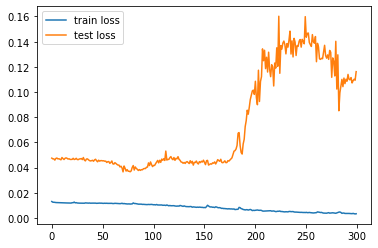

In [27]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [28]:
train_idx[:T+1] = False

Usamos la base de datos para predecir y gráficar los resultados

In [29]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

3/3 [==============================] - 0s 3ms/step


In [30]:
#Needed to compute un-differenced predictions
df['ShiftLogMM'] = df['LogMM'].shift(1) #cambia 1 periodo hacia adelante los datos
prev = df['ShiftLogMM']

In [31]:
#último valor del entrenamiento
last_train = train.iloc[-1]['LogMM']

In [32]:
# último valor de la prueba
last_test = test.iloc[-1]['LogMM']

In [33]:
# 1-step forecast[]
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain #Te regresa las n observaciones con true //con el loc me regresa del df algo en específico /
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest #Te regresa las n observaciones con true //

In [34]:
#Regreso los datos diferenciados a su fecha orginal
df.loc[test_idx, '1step_test'] = df.loc[test_idx, '1step_test'].shift(-1) 
df.loc[train_idx, '1step_train'] = df.loc[train_idx, '1step_train'].shift(-1)

In [35]:
#Al regresar los datos se pierde un dato al final, se añade aquí:
last_forecast_test = prev[test_idx][-2] + Ptest[-1] 
df.loc[test_idx, '1step_test'] = df.loc[test_idx, '1step_test'].replace(np.nan, last_forecast_test)

last_forecast_train = prev[train_idx][-2] + Ptrain[-1] 
df.loc[train_idx, '1step_train'] = df.loc[train_idx, '1step_train'].replace(np.nan, last_forecast_train)

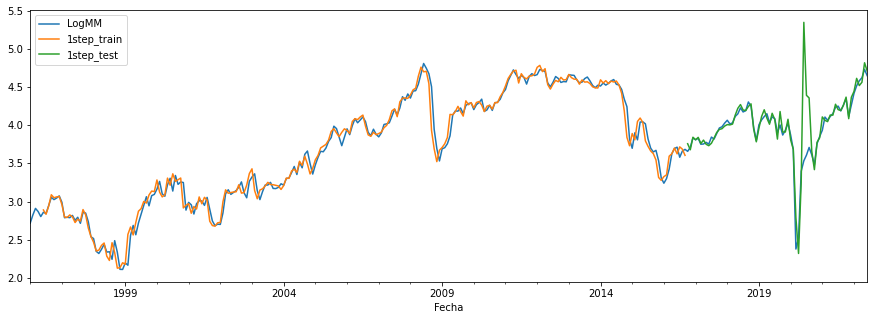

In [36]:
# Plot 1-step forecast []
df[['LogMM','1step_train','1step_test']].plot(figsize=(15,5));

In [37]:
test_log_pass = df.iloc[-Ntest:]['LogMM']

In [38]:
df.loc[test_idx, '1step_test']

Fecha
2016-10-31    3.758680
2016-11-30    3.679426
2016-12-30    3.844287
2017-01-31    3.810741
2017-02-28    3.842448
                ...   
2022-02-28    4.617223
2022-03-31    4.522333
2022-04-29    4.565668
2022-05-31    4.822040
2022-06-30    4.712503
Name: 1step_test, Length: 69, dtype: float64

In [39]:
MSE = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test']) #test_idx en vez de 
RMSE = math.sqrt(MSE)
print("1-step( RMSE:", RMSE)

1-step( RMSE: 0.26285656647696637


In [40]:
#----------Acá termina la prueba, vamos con las redes neuronales:

Tomamos como referencia la base de datos de la sección anterior

In [41]:
Xtrain_m, Ytrain_m = Xtrain, Ytrain
Xtest_m, Ytest_m = Xtest, Ytest
Tx = T

Se hace el diseño de todas las redes neuronales propuestas

In [42]:
import tensorflow as tf

In [43]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(2, return_sequences=False)(i)
x = Dense(1)(x)
model2 = Model(i,x)

In [44]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(3, return_sequences=False)(i)
x = Dense(1)(x) 
model3 = Model(i,x)

In [45]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(4, return_sequences=False)(i)
x = Dense(1)(x) 
model4 = Model(i,x)

In [46]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(5, return_sequences=False)(i)
x = Dense(1)(x)
model5 = Model(i,x)

In [47]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(6, return_sequences=False)(i)
x = Dense(1)(x) 
model6 = Model(i,x)

In [48]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(7, return_sequences=False)(i)
x = Dense(1)(x) 
model7 = Model(i,x)

In [49]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(8, return_sequences=False)(i)
x = Dense(1)(x) 
model8 = Model(i,x)

In [50]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(9, return_sequences=False)(i)
x = Dense(1)(x) 
model9 = Model(i,x)

In [51]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(10, return_sequences=False)(i)
x = Dense(1)(x)
model10 = Model(i,x)

In [52]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(11, return_sequences=False)(i)
x = Dense(1)(x)
model11 = Model(i,x)

In [53]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(12, return_sequences=False)(i)
x = Dense(1)(x)
model12 = Model(i,x)

In [54]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(13, return_sequences=False)(i)
x = Dense(1)(x)
model13 = Model(i,x)

In [55]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(14, return_sequences=False)(i)
x = Dense(1)(x) 
model14 = Model(i,x)

In [56]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(15, return_sequences=False)(i)
x = Dense(1)(x) 
model15 = Model(i,x)

In [57]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(16, return_sequences=False)(i)
x = Dense(1)(x)
model16 = Model(i,x)

In [58]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(17, return_sequences=False)(i)
x = Dense(1)(x)
model17 = Model(i,x)

In [59]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(18, return_sequences=False)(i)
x = Dense(1)(x) 
model18 = Model(i,x)

In [60]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(19, return_sequences=False)(i)
x = Dense(1)(x) 
model19 = Model(i,x)

In [61]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(20, return_sequences=False)(i)
x = Dense(1)(x)
model20 = Model(i,x)

In [62]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(21, return_sequences=False)(i)
x = Dense(1)(x) 
model21 = Model(i,x)

In [63]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(22, return_sequences=False)(i)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model22 = Model(i,x)

In [64]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(23, return_sequences=False)(i)
x = Dense(1)(x) 
model23 = Model(i,x)

In [65]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(24, return_sequences=False)(i)
x = Dense(1)(x) 
model24 = Model(i,x)

In [66]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(25, return_sequences=False)(i)
x = Dense(1)(x) 
model25 = Model(i,x)

In [67]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(26, return_sequences=False)(i)
x = Dense(1)(x) 
model26 = Model(i,x)

In [68]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(27, return_sequences=False)(i)
x = Dense(1)(x) 
model27 = Model(i,x)

In [69]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(28, return_sequences=False)(i)
x = Dense(1)(x) 
model28 = Model(i,x)

In [70]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(29, return_sequences=False)(i)
x = Dense(1)(x) 
model29 = Model(i,x)

In [71]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(30, return_sequences=False)(i)
x = Dense(1)(x)
model30 = Model(i,x)

In [72]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(31, return_sequences=False)(i)
x = Dense(1)(x) 
model31 = Model(i,x)

In [73]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(32, return_sequences=False)(i)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model32 = Model(i,x)

In [74]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(33, return_sequences=False)(i)
x = Dense(1)(x) 
model33 = Model(i,x)

In [75]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(34, return_sequences=False)(i)
x = Dense(1)(x) 
model34 = Model(i,x)

In [76]:
#RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(35, return_sequences=False)(i)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model35 = Model(i,x)

In [77]:
#RNN 
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(36, return_sequences=False)(i)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model36 = Model(i,x)

In [78]:
#Bi-layer RNN
i = Input(shape=(T,6)) #recuerda Tx = T 
x = SimpleRNN(2, return_sequences=True)(i) #uno debe ser True y otro False para un dense(1)
x = SimpleRNN(2, return_sequences=False)(x)
x = Dense(1)(x)
model2b = Model(i,x)

In [79]:
#Bi-layer RNN
i = Input(shape=(T,6)) #recuerda Tx = T 
x = SimpleRNN(3, return_sequences=True)(i)
x = SimpleRNN(3, return_sequences=False)(x)
x = Dense(1)(x) 
model3b = Model(i,x)

In [80]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(4, return_sequences=True)(i)
x = SimpleRNN(4, return_sequences=False)(x)
x = Dense(1)(x) 
model4b = Model(i,x)

In [81]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(5, return_sequences=True)(i)
x = SimpleRNN(5, return_sequences=False)(x)
x = Dense(1)(x)
model5b = Model(i,x)

In [82]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(6, return_sequences=True)(i)
x = SimpleRNN(6, return_sequences=False)(x)
x = Dense(1)(x) 
model6b = Model(i,x)

In [83]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(7, return_sequences=True)(i)
x = SimpleRNN(7, return_sequences=False)(x)
x = Dense(1)(x) 
model7b = Model(i,x)

In [84]:
#RBi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(8, return_sequences=True)(i)
x = SimpleRNN(8, return_sequences=False)(x)
x = Dense(1)(x) 
model8b = Model(i,x)

In [85]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(9, return_sequences=True)(i)
x = SimpleRNN(9, return_sequences=False)(x)
x = Dense(1)(x) 
model9b = Model(i,x)

In [86]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(10, return_sequences=True)(i)
x = SimpleRNN(10, return_sequences=False)(x)
x = Dense(1)(x)
model10b = Model(i,x)

In [87]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(11, return_sequences=True)(i)
x = SimpleRNN(11, return_sequences=False)(x)
x = Dense(1)(x)
model11b = Model(i,x)

In [88]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(12, return_sequences=True)(i)
x = SimpleRNN(12, return_sequences=False)(x)
x = Dense(1)(x)
model12b = Model(i,x)

In [89]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(13, return_sequences=True)(i)
x = SimpleRNN(13, return_sequences=False)(x)
x = Dense(1)(x)
model13b = Model(i,x)

In [90]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(14, return_sequences=True)(i)
x = SimpleRNN(14, return_sequences=False)(x)
x = Dense(1)(x) 
model14b = Model(i,x)

In [91]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(15, return_sequences=True)(i)
x = SimpleRNN(15, return_sequences=False)(x)
x = Dense(1)(x) 
model15b = Model(i,x)

In [92]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(16, return_sequences=True)(i)
x = SimpleRNN(16, return_sequences=False)(x)
x = Dense(1)(x)
model16b = Model(i,x)

In [93]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(17, return_sequences=True)(i)
x = SimpleRNN(17, return_sequences=False)(x)
x = Dense(1)(x)
model17b = Model(i,x)

In [94]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(18, return_sequences=True)(i)
x = SimpleRNN(18, return_sequences=False)(x)
x = Dense(1)(x) 
model18b = Model(i,x)

In [95]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(19, return_sequences=True)(i)
x = SimpleRNN(19, return_sequences=False)(x)
x = Dense(1)(x) 
model19b = Model(i,x)

In [96]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(20, return_sequences=True)(i)
x = SimpleRNN(20, return_sequences=False)(x)
x = Dense(1)(x)
model20b = Model(i,x)

In [97]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(21, return_sequences=True)(i)
x = SimpleRNN(21, return_sequences=False)(x)
x = Dense(1)(x) 
model21b = Model(i,x)

In [98]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(22, return_sequences=True)(i)
x = SimpleRNN(22, return_sequences=False)(x)
x = Dense(1)(x) 
model22b = Model(i,x)

In [99]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(23, return_sequences=True)(i)
x = SimpleRNN(23, return_sequences=False)(x)
x = Dense(1)(x) 
model23b = Model(i,x)

In [100]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(24, return_sequences=True)(i)
x = SimpleRNN(24, return_sequences=False)(x)
x = Dense(1)(x) 
model24b = Model(i,x)

In [101]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(25, return_sequences=True)(i)
x = SimpleRNN(25, return_sequences=False)(x)
x = Dense(1)(x) 
model25b = Model(i,x)

In [102]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(26, return_sequences=True)(i)
x = SimpleRNN(26, return_sequences=False)(x)
x = Dense(1)(x) 
model26b = Model(i,x)

In [103]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(27, return_sequences=True)(i)
x = SimpleRNN(27, return_sequences=False)(x)
x = Dense(1)(x) 
model27b = Model(i,x)

In [104]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(28, return_sequences=True)(i)
x = SimpleRNN(28, return_sequences=False)(x)
x = Dense(1)(x) 
model28b = Model(i,x)

In [105]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(29, return_sequences=True)(i)
x = SimpleRNN(29, return_sequences=False)(x)
x = Dense(1)(x) 
model29b = Model(i,x)

In [106]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(30, return_sequences=True)(i)
x = SimpleRNN(30, return_sequences=False)(x)
x = Dense(1)(x)
model30b = Model(i,x)

In [107]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(31, return_sequences=True)(i)
x = SimpleRNN(31, return_sequences=False)(x)
x = Dense(1)(x) 
model31b = Model(i,x)

In [108]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(32, return_sequences=True)(i)
x = SimpleRNN(32, return_sequences=False)(x)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model32b = Model(i,x)

In [109]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(33, return_sequences=True)(i)
x = SimpleRNN(33, return_sequences=False)(x)
x = Dense(1)(x) 
model33b = Model(i,x)

In [110]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(34, return_sequences=True)(i)
x = SimpleRNN(34, return_sequences=False)(x)
x = Dense(1)(x) 
model34b = Model(i,x)

In [111]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(35, return_sequences=True)(i)
x = SimpleRNN(35, return_sequences=False)(x)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model35b = Model(i,x)

In [112]:
#Bi-layer RNN
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = SimpleRNN(36, return_sequences=True)(i)
x = SimpleRNN(36, return_sequences=False)(x)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model36b = Model(i,x)

In [113]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(2)(i)
x = Dense(1)(x) 
model2c = Model(i,x)

In [114]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(3)(i)
x = Dense(1)(x)
model3c = Model(i,x)

In [115]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(4)(i)
x = Dense(1)(x)
model4c = Model(i,x)

In [116]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(5)(i)
x = Dense(1)(x)
model5c = Model(i,x)

In [117]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(6)(i)
x = Dense(1)(x) 
model6c = Model(i,x)

In [118]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(7)(i)
x = Dense(1)(x)
model7c = Model(i,x)

In [119]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(8)(i)
x = Dense(1)(x)
model8c = Model(i,x)

In [120]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(9)(i)
x = Dense(1)(x) #en este caso es 12 =Ty
model9c = Model(i,x)

In [121]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(10)(i)
x = Dense(1)(x)
model10c = Model(i,x)

In [122]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(11)(i)
x = Dense(1)(x)
model11c = Model(i,x)

In [123]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(12)(i)
x = Dense(1)(x) 
model12c = Model(i,x)

In [124]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(13)(i)
x = Dense(1)(x) 
model13c = Model(i,x)

In [125]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(14)(i)
x = Dense(1)(x)
model14c = Model(i,x)

In [126]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(15)(i)
x = Dense(1)(x) 
model15c = Model(i,x)

In [127]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(16)(i)
x = Dense(1)(x) 
model16c = Model(i,x)

In [128]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(17)(i)
x = Dense(1)(x)
model17c = Model(i,x)

In [129]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(18)(i)
x = Dense(1)(x)
model18c = Model(i,x)

In [130]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(19)(i)
x = Dense(1)(x)
model19c = Model(i,x)

In [131]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(20)(i)
x = Dense(1)(x)
model20c = Model(i,x)

In [132]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(21)(i)
x = Dense(1)(x)
model21c = Model(i,x)

In [133]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(22)(i)
x = Dense(1)(x) 
model22c = Model(i,x)

In [134]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(23)(i)
x = Dense(1)(x)
model23c = Model(i,x)

In [135]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(24)(i)
x = Dense(1)(x) 
model24c = Model(i,x)

In [136]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(25)(i)
x = Dense(1)(x)
model25c = Model(i,x)

In [137]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(26)(i)
x = Dense(1)(x)
model26c = Model(i,x)

In [138]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(27)(i)
x = Dense(1)(x)
model27c = Model(i,x)

In [139]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(28)(i)
x = Dense(1)(x)
model28c = Model(i,x)

In [140]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(29)(i)
x = Dense(1)(x)
model29c = Model(i,x)

In [141]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(30)(i)
x = Dense(1)(x)
model30c = Model(i,x)

In [142]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(31)(i)
x = Dense(1)(x) 
model31c = Model(i,x)

In [143]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(32)(i)
x = Dense(1)(x) 
model32c = Model(i,x)

In [144]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(33)(i)
x = Dense(1)(x) 
model33c = Model(i,x)

In [145]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(34)(i)
x = Dense(1)(x)
model34c = Model(i,x)

In [146]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(35)(i)
x = Dense(1)(x) 
model35c = Model(i,x)

In [147]:
#LSTM
i = Input(shape=(Tx,6))
x = LSTM(36)(i)
x = Dense(1)(x) 
model36c = Model(i,x)

In [148]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(2, return_sequences=True)(i)
x = LSTM(2, return_sequences=False)(x)
x = Dense(1)(x)
model2d = Model(i,x)

In [149]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(3, return_sequences=True)(i)
x = LSTM(3, return_sequences=False)(x)
x = Dense(1)(x)
model3d = Model(i,x)

In [150]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(4, return_sequences=True)(i)
x = LSTM(4, return_sequences=False)(x)
x = Dense(1)(x) 
model4d = Model(i,x)

In [151]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(5, return_sequences=True)(i)
x = LSTM(5, return_sequences=False)(x)
x = Dense(1)(x)
model5d = Model(i,x)

In [152]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(6, return_sequences=True)(i)
x = LSTM(6, return_sequences=False)(x)
x = Dense(1)(x)
model6d = Model(i,x)

In [153]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(7, return_sequences=True)(i)
x = LSTM(7, return_sequences=False)(x)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model7d = Model(i,x)

In [154]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(8, return_sequences=True)(i)
x = LSTM(8, return_sequences=False)(x)
x = Dense(1)(x) 
model8d = Model(i,x)

In [155]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(9, return_sequences=True)(i)
x = LSTM(9, return_sequences=False)(x)
x = Dense(1)(x)
model9d = Model(i,x)

In [156]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(10, return_sequences=True)(i)
x = LSTM(10, return_sequences=False)(x)
x = Dense(1)(x)
model10d = Model(i,x)

In [157]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(11, return_sequences=True)(i)
x = LSTM(11, return_sequences=False)(x)
x = Dense(1)(x)
model11d = Model(i,x)

In [158]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(12, return_sequences=True)(i)
x = LSTM(12, return_sequences=False)(x)
x = Dense(1)(x)
model12d = Model(i,x)

In [159]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(13, return_sequences=True)(i)
x = LSTM(13, return_sequences=False)(x)
x = Dense(1)(x)
model13d = Model(i,x)

In [160]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(14, return_sequences=True)(i)
x = LSTM(14, return_sequences=False)(x)
x = Dense(1)(x)
model14d = Model(i,x)

In [161]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(15, return_sequences=True)(i)
x = LSTM(15, return_sequences=False)(x)
x = Dense(1)(x)
model15d = Model(i,x)

In [162]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=False)(x)
x = Dense(1)(x)
model16d = Model(i,x)

In [163]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(17, return_sequences=True)(i)
x = LSTM(17, return_sequences=False)(x)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model17d = Model(i,x)

In [164]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(18, return_sequences=True)(i)
x = LSTM(18, return_sequences=False)(x)
x = Dense(1)(x)
model18d = Model(i,x)

In [165]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(19, return_sequences=True)(i)
x = LSTM(19, return_sequences=False)(x)
x = Dense(1)(x)
model19d = Model(i,x)

In [166]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(20, return_sequences=True)(i)
x = LSTM(20, return_sequences=False)(x)
x = Dense(1)(x)
model20d = Model(i,x)

In [167]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(21, return_sequences=True)(i)
x = LSTM(21, return_sequences=False)(x)
x = Dense(1)(x)
model21d = Model(i,x)

In [168]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(22, return_sequences=True)(i)
x = LSTM(22, return_sequences=False)(x)
x = Dense(1)(x)
model22d = Model(i,x)

In [169]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(23, return_sequences=True)(i)
x = LSTM(23, return_sequences=False)(x)
x = Dense(1)(x)
model23d = Model(i,x)

In [170]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(24, return_sequences=True)(i)
x = LSTM(24, return_sequences=False)(x)
x = Dense(1)(x)
model24d = Model(i,x)

In [171]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(25, return_sequences=True)(i)
x = LSTM(25, return_sequences=False)(x)
x = Dense(1)(x)
model25d = Model(i,x)

In [172]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(26, return_sequences=True)(i)
x = LSTM(26, return_sequences=False)(x)
x = Dense(1)(x) 
model26d = Model(i,x)

In [173]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(27, return_sequences=True)(i)
x = LSTM(27, return_sequences=False)(x)
x = Dense(1)(x) 
model27d = Model(i,x)

In [174]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(28, return_sequences=True)(i)
x = LSTM(28, return_sequences=False)(x)
x = Dense(1)(x) 
model28d = Model(i,x)

In [175]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(29, return_sequences=True)(i)
x = LSTM(29, return_sequences=False)(x)
x = Dense(1)(x)
model29d = Model(i,x)

In [176]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(30, return_sequences=True)(i)
x = LSTM(30, return_sequences=False)(x)
x = Dense(1)(x)
model30d = Model(i,x)

In [177]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(31, return_sequences=True)(i)
x = LSTM(31, return_sequences=False)(x)
x = Dense(1)(x) 
model31d = Model(i,x)

In [178]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(32, return_sequences=True)(i)
x = LSTM(32, return_sequences=False)(x)
x = Dense(1)(x)
model32d = Model(i,x)

In [179]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(33, return_sequences=True)(i)
x = LSTM(33, return_sequences=False)(x)
x = Dense(1)(x)
model33d = Model(i,x)

In [180]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(34, return_sequences=True)(i)
x = LSTM(34, return_sequences=False)(x)
x = Dense(1)(x)
model34d = Model(i,x)

In [181]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(35, return_sequences=True)(i)
x = LSTM(35, return_sequences=False)(x)
x = Dense(1)(x)
model35d = Model(i,x)

In [182]:
#Bi-layer LSTM
i = Input(shape=(Tx,6)) #recuerda Tx = T 
x = LSTM(36, return_sequences=True)(i)
x = LSTM(36, return_sequences=False)(x)
x = Dense(1)(x) #Ty = Ntest el cual es 12 en el ejemplo
model36d = Model(i,x)

In [183]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(2, return_sequences=False))(i)
x = layers.Dense(1)(x)
model2e = Model(i,x)

In [184]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(3, return_sequences=False))(i)
x = layers.Dense(1)(x)
model3e = Model(i,x)

In [185]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(4, return_sequences=False))(i)
x = layers.Dense(1)(x)
model4e = Model(i,x)

In [186]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(5, return_sequences=False))(i)
x = layers.Dense(1)(x)
model5e = Model(i,x)

In [187]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(6, return_sequences=False))(i)
x = layers.Dense(1)(x)
model6e = Model(i,x)

In [188]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(7, return_sequences=False))(i)
x = layers.Dense(1)(x)
model7e = Model(i,x)

In [189]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(8, return_sequences=False))(i)
x = layers.Dense(1)(x)
model8e = Model(i,x)

In [190]:
# Bi-directional LSTM 
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(9, return_sequences=False))(i)
x = layers.Dense(1)(x)
model9e = Model(i,x)

In [191]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(10, return_sequences=False))(i)
x = layers.Dense(1)(x)
model10e = Model(i,x)

In [192]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(11, return_sequences=False))(i)
x = layers.Dense(1)(x)
model11e = Model(i,x)

In [193]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(12, return_sequences=False))(i)
x = layers.Dense(1)(x)
model12e = Model(i,x)

In [194]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(13, return_sequences=False))(i)
x = layers.Dense(1)(x)
model13e = Model(i,x)

In [195]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(14, return_sequences=False))(i)
x = layers.Dense(1)(x)
model14e = Model(i,x)

In [196]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(15, return_sequences=False))(i)
x = layers.Dense(1)(x)
model15e = Model(i,x)

In [197]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(16, return_sequences=False))(i)
x = layers.Dense(1)(x)
model16e = Model(i,x)

In [198]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(17, return_sequences=False))(i)
x = layers.Dense(1)(x)
model17e = Model(i,x)

In [199]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(18, return_sequences=False))(i)
x = layers.Dense(1)(x)
model18e = Model(i,x)

In [200]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(19, return_sequences=False))(i)
x = layers.Dense(1)(x)
model19e = Model(i,x)

In [201]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(20, return_sequences=False))(i)
x = layers.Dense(1)(x)
model20e = Model(i,x)

In [202]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(21, return_sequences=False))(i)
x = layers.Dense(1)(x)
model21e = Model(i,x)

In [203]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(22, return_sequences=False))(i)
x = layers.Dense(1)(x)
model22e = Model(i,x)

In [204]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(23, return_sequences=False))(i)
x = layers.Dense(1)(x)
model23e = Model(i,x)

In [205]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(24, return_sequences=False))(i)
x = layers.Dense(1)(x)
model24e = Model(i,x)

In [206]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(25, return_sequences=False))(i)
x = layers.Dense(1)(x)
model25e = Model(i,x)

In [207]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(26, return_sequences=False))(i)
x = layers.Dense(1)(x)
model26e = Model(i,x)

In [208]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(27, return_sequences=False))(i)
x = layers.Dense(1)(x)
model27e = Model(i,x)

In [209]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(28, return_sequences=False))(i)
x = layers.Dense(1)(x)
model28e = Model(i,x)

In [210]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(29, return_sequences=False))(i)
x = layers.Dense(1)(x)
model29e = Model(i,x)

In [211]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(30, return_sequences=False))(i)
x = layers.Dense(1)(x)
model30e = Model(i,x)

In [212]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(31, return_sequences=False))(i)
x = layers.Dense(1)(x)
model31e = Model(i,x)

In [213]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(i)
x = layers.Dense(1)(x)
model32e = Model(i,x)

In [214]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(33, return_sequences=False))(i)
x = layers.Dense(1)(x)
model33e = Model(i,x)

In [215]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(34, return_sequences=False))(i)
x = layers.Dense(1)(x)
model34e = Model(i,x)

In [216]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(35, return_sequences=False))(i)
x = layers.Dense(1)(x)
model35e = Model(i,x)

In [217]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(36, return_sequences=False))(i)
x = layers.Dense(1)(x)
model36e = Model(i,x)

In [218]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(2, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(2, return_sequences=False))(x)
x = layers.Dense(1)(x)
model2f = Model(i,x)

In [219]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(3, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(3, return_sequences=False))(x)
x = layers.Dense(1)(x)
model3f = Model(i,x)

In [220]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(4, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(4, return_sequences=False))(x)
x = layers.Dense(1)(x)
model4f = Model(i,x)

In [221]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(5, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(5, return_sequences=False))(x)
x = layers.Dense(1)(x)
model5f = Model(i,x)

In [222]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(6, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(6, return_sequences=False))(x)
x = layers.Dense(1)(x)
model6f = Model(i,x)

In [223]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(7, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(7, return_sequences=False))(x)
x = layers.Dense(1)(x)
model7f = Model(i,x)

In [224]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(8, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(8, return_sequences=False))(x)
x = layers.Dense(1)(x)
model8f = Model(i,x)

In [225]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(9, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(9, return_sequences=False))(x)
x = layers.Dense(1)(x)
model9f = Model(i,x)

In [226]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(10, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(10, return_sequences=False))(x)
x = layers.Dense(1)(x)
model10f = Model(i,x)

In [227]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(11, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(11, return_sequences=False))(x)
x = layers.Dense(1)(x)
model11f = Model(i,x)

In [228]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(12, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(12, return_sequences=False))(x)
x = layers.Dense(1)(x)
model12f = Model(i,x)

In [229]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(13, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(13, return_sequences=False))(x)
x = layers.Dense(1)(x)
model13f = Model(i,x)

In [230]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(14, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(14, return_sequences=False))(x)
x = layers.Dense(1)(x)
model14f = Model(i,x)

In [231]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(15, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(15, return_sequences=False))(x)
x = layers.Dense(1)(x)
model15f = Model(i,x)

In [232]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(16, return_sequences=False))(x)
x = layers.Dense(1)(x)
model16f = Model(i,x)

In [233]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(17, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(17, return_sequences=False))(x)
x = layers.Dense(1)(x)
model17f = Model(i,x)

In [234]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(18, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(18, return_sequences=False))(x)
x = layers.Dense(1)(x)
model18f = Model(i,x)

In [235]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(19, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(19, return_sequences=False))(x)
x = layers.Dense(1)(x)
model19f = Model(i,x)

In [236]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(20, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(20, return_sequences=False))(x)
x = layers.Dense(1)(x)
model20f = Model(i,x)

In [237]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(21, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(21, return_sequences=False))(x)
x = layers.Dense(1)(x)
model21f = Model(i,x)

In [238]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(22, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(22, return_sequences=False))(x)
x = layers.Dense(1)(x)
model22f = Model(i,x)

In [239]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(23, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(23, return_sequences=False))(x)
x = layers.Dense(1)(x)
model23f = Model(i,x)

In [240]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(24, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(24, return_sequences=False))(x)
x = layers.Dense(1)(x)
model24f = Model(i,x)

In [241]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(25, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(25, return_sequences=False))(x)
x = layers.Dense(1)(x)
model25f = Model(i,x)

In [242]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(26, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(26, return_sequences=False))(x)
x = layers.Dense(1)(x)
model26f = Model(i,x)

In [243]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(27, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(27, return_sequences=False))(x)
x = layers.Dense(1)(x)
model27f = Model(i,x)

In [244]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(28, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(28, return_sequences=False))(x)
x = layers.Dense(1)(x)
model28f = Model(i,x)

In [245]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(29, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(29, return_sequences=False))(x)
x = layers.Dense(1)(x)
model29f = Model(i,x)

In [246]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(30, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(30, return_sequences=False))(x)
x = layers.Dense(1)(x)
model30f = Model(i,x)

In [247]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(31, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(31, return_sequences=False))(x)
x = layers.Dense(1)(x)
model31f = Model(i,x)

In [248]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(x)
x = layers.Dense(1)(x)
model32f = Model(i,x)

In [249]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(33, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(33, return_sequences=False))(x)
x = layers.Dense(1)(x)
model33f = Model(i,x)

In [250]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(34, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(34, return_sequences=False))(x)
x = layers.Dense(1)(x)
model34f = Model(i,x)

In [251]:
# Bi-directional Bi-layer LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(35, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(35, return_sequences=False))(x)
x = layers.Dense(1)(x)
model35f = Model(i,x)

In [252]:
# Bi-directional LSTM
i = Input(shape=(T,6))#Son 6 variables de entrada por T = 4 rezagos
x = layers.Bidirectional(layers.LSTM(36, return_sequences=True))(i)
x = layers.Bidirectional(layers.LSTM(36, return_sequences=False))(x)
x = layers.Dense(1)(x)
model36f = Model(i,x)

In [253]:
#Recordar: batch size por defecto es 32 y debe ser menor a las muestras

Se hace un check point solo a forma de control

In [254]:
check_point = ModelCheckpoint(
    'best_model.h5',monitor='val_loss',save_best_only=True)

Hacemos la compilación de los modelos, estableciendo el MSE como función de pérdida y al método adam como optimizador.

In [255]:
model2.compile(
    loss='mse',
    optimizer='adam',
)

In [256]:
model3.compile(
    loss='mse',
    optimizer='adam',
)

In [257]:
model4.compile(
    loss='mse',
    optimizer='adam',
)

In [258]:
model5.compile(
    loss='mse',
    optimizer='adam',
)

In [259]:
model6.compile(
    loss='mse',
    optimizer='adam',
)

In [260]:
model7.compile(
    loss='mse',
    optimizer='adam',
)

In [261]:
model8.compile(
    loss='mse',
    optimizer='adam',
)

In [262]:
model9.compile(
    loss='mse',
    optimizer='adam',
)

In [263]:
model10.compile(
    loss='mse',
    optimizer='adam',
)

In [264]:
model11.compile(
    loss='mse',
    optimizer='adam',
)

In [265]:
model12.compile(
    loss='mse',
    optimizer='adam',
)

In [266]:
model13.compile(
    loss='mse',
    optimizer='adam',
)

In [267]:
model14.compile(
    loss='mse',
    optimizer='adam',
)

In [268]:
model15.compile(
    loss='mse',
    optimizer='adam',
)

In [269]:
model16.compile(
    loss='mse',
    optimizer='adam',
)

In [270]:
model17.compile(
    loss='mse',
    optimizer='adam',
)

In [271]:
model18.compile(
    loss='mse',
    optimizer='adam',
)

In [272]:
model19.compile(
    loss='mse',
    optimizer='adam',
)

In [273]:
model20.compile(
    loss='mse',
    optimizer='adam',
)

In [274]:
model21.compile(
    loss='mse',
    optimizer='adam',
)

In [275]:
model22.compile(
    loss='mse',
    optimizer='adam',
)

In [276]:
model23.compile(
    loss='mse',
    optimizer='adam',
)

In [277]:
model24.compile(
    loss='mse',
    optimizer='adam',
)

In [278]:
model25.compile(
    loss='mse',
    optimizer='adam',
)

In [279]:
model26.compile(
    loss='mse',
    optimizer='adam',
)

In [280]:
model27.compile(
    loss='mse',
    optimizer='adam',
)

In [281]:
model28.compile(
    loss='mse',
    optimizer='adam',
)

In [282]:
model29.compile(
    loss='mse',
    optimizer='adam',
)

In [283]:
model30.compile(
    loss='mse',
    optimizer='adam',
)

In [284]:
model31.compile(
    loss='mse',
    optimizer='adam',
)

In [285]:
model32.compile(
    loss='mse',
    optimizer='adam',
)

In [286]:
model33.compile(
    loss='mse',
    optimizer='adam',
)

In [287]:
model34.compile(
    loss='mse',
    optimizer='adam',
)

In [288]:
model35.compile(
    loss='mse',
    optimizer='adam',
)

In [289]:
model36.compile(
    loss='mse',
    optimizer='adam',
)

In [290]:
model2b.compile(
    loss='mse',
    optimizer='adam',
)

In [291]:
model3b.compile(
    loss='mse',
    optimizer='adam',
)

In [292]:
model4b.compile(
    loss='mse',
    optimizer='adam',
)

In [293]:
model5b.compile(
    loss='mse',
    optimizer='adam',
)

In [294]:
model6b.compile(
    loss='mse',
    optimizer='adam',
)

In [295]:
model7b.compile(
    loss='mse',
    optimizer='adam',
)

In [296]:
model8b.compile(
    loss='mse',
    optimizer='adam',
)

In [297]:
model9b.compile(
    loss='mse',
    optimizer='adam',
)

In [298]:
model10b.compile(
    loss='mse',
    optimizer='adam',
)

In [299]:
model11b.compile(
    loss='mse',
    optimizer='adam',
)

In [300]:
model12b.compile(
    loss='mse',
    optimizer='adam',
)

In [301]:
model13b.compile(
    loss='mse',
    optimizer='adam',
)

In [302]:
model14b.compile(
    loss='mse',
    optimizer='adam',
)

In [303]:
model15b.compile(
    loss='mse',
    optimizer='adam',
)

In [304]:
model16b.compile(
    loss='mse',
    optimizer='adam',
)

In [305]:
model17b.compile(
    loss='mse',
    optimizer='adam',
)

In [306]:
model18b.compile(
    loss='mse',
    optimizer='adam',
)

In [307]:
model19b.compile(
    loss='mse',
    optimizer='adam',
)

In [308]:
model10b.compile(
    loss='mse',
    optimizer='adam',
)

In [309]:
model11b.compile(
    loss='mse',
    optimizer='adam',
)

In [310]:
model12b.compile(
    loss='mse',
    optimizer='adam',
)

In [311]:
model13b.compile(
    loss='mse',
    optimizer='adam',
)

In [312]:
model14b.compile(
    loss='mse',
    optimizer='adam',
)

In [313]:
model15b.compile(
    loss='mse',
    optimizer='adam',
)

In [314]:
model16b.compile(
    loss='mse',
    optimizer='adam',
)

In [315]:
model17b.compile(
    loss='mse',
    optimizer='adam',
)

In [316]:
model18b.compile(
    loss='mse',
    optimizer='adam',
)

In [317]:
model19b.compile(
    loss='mse',
    optimizer='adam',
)

In [318]:
model20b.compile(
    loss='mse',
    optimizer='adam',
)

In [319]:
model21b.compile(
    loss='mse',
    optimizer='adam',
)

In [320]:
model22b.compile(
    loss='mse',
    optimizer='adam',
)

In [321]:
model23b.compile(
    loss='mse',
    optimizer='adam',
)

In [322]:
model24b.compile(
    loss='mse',
    optimizer='adam',
)

In [323]:
model25b.compile(
    loss='mse',
    optimizer='adam',
)

In [324]:
model26b.compile(
    loss='mse',
    optimizer='adam',
)

In [325]:
model27b.compile(
    loss='mse',
    optimizer='adam',
)

In [326]:
model28b.compile(
    loss='mse',
    optimizer='adam',
)

In [327]:
model29b.compile(
    loss='mse',
    optimizer='adam',
)

In [328]:
model30b.compile(
    loss='mse',
    optimizer='adam',
)

In [329]:
model31b.compile(
    loss='mse',
    optimizer='adam',
)

In [330]:
model32b.compile(
    loss='mse',
    optimizer='adam',
)

In [331]:
model33b.compile(
    loss='mse',
    optimizer='adam',
)

In [332]:
model34b.compile(
    loss='mse',
    optimizer='adam',
)

In [333]:
model35b.compile(
    loss='mse',
    optimizer='adam',
)

In [334]:
model36b.compile(
    loss='mse',
    optimizer='adam',
)

In [335]:
model2c.compile(
    loss='mse',
    optimizer='adam',
)

In [336]:
model3c.compile(
    loss='mse',
    optimizer='adam',
)

In [337]:
model4c.compile(
    loss='mse',
    optimizer='adam',
)

In [338]:
model5c.compile(
    loss='mse',
    optimizer='adam',
)

In [339]:
model6c.compile(
    loss='mse',
    optimizer='adam',
)

In [340]:
model7c.compile(
    loss='mse',
    optimizer='adam',
)

In [341]:
model8c.compile(
    loss='mse',
    optimizer='adam',
)

In [342]:
model9c.compile(
    loss='mse',
    optimizer='adam',
)

In [343]:
model10c.compile(
    loss='mse',
    optimizer='adam',
)

In [344]:
model11c.compile(
    loss='mse',
    optimizer='adam',
)

In [345]:
model12c.compile(
    loss='mse',
    optimizer='adam',
)

In [346]:
model13c.compile(
    loss='mse',
    optimizer='adam',
)

In [347]:
model14c.compile(
    loss='mse',
    optimizer='adam',
)

In [348]:
model15c.compile(
    loss='mse',
    optimizer='adam',
)

In [349]:
model16c.compile(
    loss='mse',
    optimizer='adam',
)

In [350]:
model17c.compile(
    loss='mse',
    optimizer='adam',
)

In [351]:
model18c.compile(
    loss='mse',
    optimizer='adam',
)

In [352]:
model19c.compile(
    loss='mse',
    optimizer='adam',
)

In [353]:
model20c.compile(
    loss='mse',
    optimizer='adam',
)

In [354]:
model21c.compile(
    loss='mse',
    optimizer='adam',
)

In [355]:
model22c.compile(
    loss='mse',
    optimizer='adam',
)

In [356]:
model22c.compile(
    loss='mse',
    optimizer='adam',
)

In [357]:
model23c.compile(
    loss='mse',
    optimizer='adam',
)

In [358]:
model24c.compile(
    loss='mse',
    optimizer='adam',
)

In [359]:
model25c.compile(
    loss='mse',
    optimizer='adam',
)

In [360]:
model26c.compile(
    loss='mse',
    optimizer='adam',
)

In [361]:
model27c.compile(
    loss='mse',
    optimizer='adam',
)

In [362]:
model28c.compile(
    loss='mse',
    optimizer='adam',
)

In [363]:
model29c.compile(
    loss='mse',
    optimizer='adam',
)

In [364]:
model30c.compile(
    loss='mse',
    optimizer='adam',
)

In [365]:
model31c.compile(
    loss='mse',
    optimizer='adam',
)

In [366]:
model32c.compile(
    loss='mse',
    optimizer='adam',
)

In [367]:
model33c.compile(
    loss='mse',
    optimizer='adam',
)

In [368]:
model34c.compile(
    loss='mse',
    optimizer='adam',
)

In [369]:
model35c.compile(
    loss='mse',
    optimizer='adam',
)

In [370]:
model36c.compile(
    loss='mse',
    optimizer='adam',
)

In [371]:
model2d.compile(
    loss='mse',
    optimizer='adam',
)

In [372]:
model3d.compile(
    loss='mse',
    optimizer='adam',
)

In [373]:
model4d.compile(
    loss='mse',
    optimizer='adam',
)

In [374]:
model5d.compile(
    loss='mse',
    optimizer='adam',
)

In [375]:
model6d.compile(
    loss='mse',
    optimizer='adam',
)

In [376]:
model7d.compile(
    loss='mse',
    optimizer='adam',
)

In [377]:
model8d.compile(
    loss='mse',
    optimizer='adam',
)

In [378]:
model9d.compile(
    loss='mse',
    optimizer='adam',
)

In [379]:
model10d.compile(
    loss='mse',
    optimizer='adam',
)

In [380]:
model8d.compile(
    loss='mse',
    optimizer='adam',
)

In [381]:
model9d.compile(
    loss='mse',
    optimizer='adam',
)

In [382]:
model10d.compile(
    loss='mse',
    optimizer='adam',
)

In [383]:
model11d.compile(
    loss='mse',
    optimizer='adam',
)

In [384]:
model12d.compile(
    loss='mse',
    optimizer='adam',
)

In [385]:
model13d.compile(
    loss='mse',
    optimizer='adam',
)

In [386]:
model14d.compile(
    loss='mse',
    optimizer='adam',
)

In [387]:
model15d.compile(
    loss='mse',
    optimizer='adam',
)

In [388]:
model16d.compile(
    loss='mse',
    optimizer='adam',
)

In [389]:
model17d.compile(
    loss='mse',
    optimizer='adam',
)

In [390]:
model18d.compile(
    loss='mse',
    optimizer='adam',
)

In [391]:
model19d.compile(
    loss='mse',
    optimizer='adam',
)

In [392]:
model20d.compile(
    loss='mse',
    optimizer='adam',
)

In [393]:
model21d.compile(
    loss='mse',
    optimizer='adam',
)

In [394]:
model22d.compile(
    loss='mse',
    optimizer='adam',
)

In [395]:
model23d.compile(
    loss='mse',
    optimizer='adam',
)

In [396]:
model24d.compile(
    loss='mse',
    optimizer='adam',
)

In [397]:
model25d.compile(
    loss='mse',
    optimizer='adam',
)

In [398]:
model26d.compile(
    loss='mse',
    optimizer='adam',
)

In [399]:
model27d.compile(
    loss='mse',
    optimizer='adam',
)

In [400]:
model28d.compile(
    loss='mse',
    optimizer='adam',
)

In [401]:
model29d.compile(
    loss='mse',
    optimizer='adam',
)

In [402]:
model30d.compile(
    loss='mse',
    optimizer='adam',
)

In [403]:
model31d.compile(
    loss='mse',
    optimizer='adam',
)

In [404]:
model32d.compile(
    loss='mse',
    optimizer='adam',
)

In [405]:
model33d.compile(
    loss='mse',
    optimizer='adam',
)

In [406]:
model34d.compile(
    loss='mse',
    optimizer='adam',
)

In [407]:
model35d.compile(
    loss='mse',
    optimizer='adam',
)

In [408]:
model36d.compile(
    loss='mse',
    optimizer='adam',
)

In [409]:
model2e.compile(
    loss='mse',
    optimizer='adam',
)

In [410]:
model3e.compile(
    loss='mse',
    optimizer='adam',
)

In [411]:
model4e.compile(
    loss='mse',
    optimizer='adam',
)

In [412]:
model5e.compile(
    loss='mse',
    optimizer='adam',
)

In [413]:
model6e.compile(
    loss='mse',
    optimizer='adam',
)

In [414]:
model7e.compile(
    loss='mse',
    optimizer='adam',
)

In [415]:
model8e.compile(
    loss='mse',
    optimizer='adam',
)

In [416]:
model9e.compile(
    loss='mse',
    optimizer='adam',
)

In [417]:
model10e.compile(
    loss='mse',
    optimizer='adam',
)

In [418]:
model11e.compile(
    loss='mse',
    optimizer='adam',
)

In [419]:
model12e.compile(
    loss='mse',
    optimizer='adam',
)

In [420]:
model13e.compile(
    loss='mse',
    optimizer='adam',
)

In [421]:
model14e.compile(
    loss='mse',
    optimizer='adam',
)

In [422]:
model15e.compile(
    loss='mse',
    optimizer='adam',
)

In [423]:
model16e.compile(
    loss='mse',
    optimizer='adam',
)

In [424]:
model17e.compile(
    loss='mse',
    optimizer='adam',
)

In [425]:
model18e.compile(
    loss='mse',
    optimizer='adam',
)

In [426]:
model19e.compile(
    loss='mse',
    optimizer='adam',
)

In [427]:
model20e.compile(
    loss='mse',
    optimizer='adam',
)

In [428]:
model21e.compile(
    loss='mse',
    optimizer='adam',
)

In [429]:
model22e.compile(
    loss='mse',
    optimizer='adam',
)

In [430]:
model23e.compile(
    loss='mse',
    optimizer='adam',
)

In [431]:
model24e.compile(
    loss='mse',
    optimizer='adam',
)

In [432]:
model25e.compile(
    loss='mse',
    optimizer='adam',
)

In [433]:
model26e.compile(
    loss='mse',
    optimizer='adam',
)

In [434]:
model27e.compile(
    loss='mse',
    optimizer='adam',
)

In [435]:
model28e.compile(
    loss='mse',
    optimizer='adam',
)

In [436]:
model29e.compile(
    loss='mse',
    optimizer='adam',
)

In [437]:
model30e.compile(
    loss='mse',
    optimizer='adam',
)

In [438]:
model31e.compile(
    loss='mse',
    optimizer='adam',
)

In [439]:
model32e.compile(
    loss='mse',
    optimizer='adam',
)

In [440]:
model33e.compile(
    loss='mse',
    optimizer='adam',
)

In [441]:
model34e.compile(
    loss='mse',
    optimizer='adam',
)

In [442]:
model35e.compile(
    loss='mse',
    optimizer='adam',
)

In [443]:
model36e.compile(
    loss='mse',
    optimizer='adam',
)

In [444]:
model2f.compile(
    loss='mse',
    optimizer='adam',
)

In [445]:
model3f.compile(
    loss='mse',
    optimizer='adam',
)

In [446]:
model3f.compile(
    loss='mse',
    optimizer='adam',
)

In [447]:
model4f.compile(
    loss='mse',
    optimizer='adam',
)

In [448]:
model5f.compile(
    loss='mse',
    optimizer='adam',
)

In [449]:
model6f.compile(
    loss='mse',
    optimizer='adam',
)

In [450]:
model7f.compile(
    loss='mse',
    optimizer='adam',
)

In [451]:
model8f.compile(
    loss='mse',
    optimizer='adam',
)

In [452]:
model9f.compile(
    loss='mse',
    optimizer='adam',
)

In [453]:
model10f.compile(
    loss='mse',
    optimizer='adam',
)

In [454]:
model11f.compile(
    loss='mse',
    optimizer='adam',
)

In [455]:
model12f.compile(
    loss='mse',
    optimizer='adam',
)

In [456]:
model13f.compile(
    loss='mse',
    optimizer='adam',
)

In [457]:
model14f.compile(
    loss='mse',
    optimizer='adam',
)

In [458]:
model15f.compile(
    loss='mse',
    optimizer='adam',
)

In [459]:
model16f.compile(
    loss='mse',
    optimizer='adam',
)

In [460]:
model17f.compile(
    loss='mse',
    optimizer='adam',
)

In [461]:
model18f.compile(
    loss='mse',
    optimizer='adam',
)

In [462]:
model19f.compile(
    loss='mse',
    optimizer='adam',
)

In [463]:
model20f.compile(
    loss='mse',
    optimizer='adam',
)

In [464]:
model21f.compile(
    loss='mse',
    optimizer='adam',
)

In [465]:
model22f.compile(
    loss='mse',
    optimizer='adam',
)

In [466]:
model23f.compile(
    loss='mse',
    optimizer='adam',
)

In [467]:
model24f.compile(
    loss='mse',
    optimizer='adam',
)

In [468]:
model25f.compile(
    loss='mse',
    optimizer='adam',
)

In [469]:
model26f.compile(
    loss='mse',
    optimizer='adam',
)

In [470]:
model27f.compile(
    loss='mse',
    optimizer='adam',
)

In [471]:
model28f.compile(
    loss='mse',
    optimizer='adam',
)

In [472]:
model29f.compile(
    loss='mse',
    optimizer='adam',
)

In [473]:
model30f.compile(
    loss='mse',
    optimizer='adam',
)

In [474]:
model31f.compile(
    loss='mse',
    optimizer='adam',
)

In [475]:
model32f.compile(
    loss='mse',
    optimizer='adam',
)

In [476]:
model33f.compile(
    loss='mse',
    optimizer='adam',
)

In [477]:
model34f.compile(
    loss='mse',
    optimizer='adam',
)

In [478]:
model35f.compile(
    loss='mse',
    optimizer='adam',
)

In [479]:
model36f.compile(
    loss='mse',
    optimizer='adam',
)

modelo entrenado


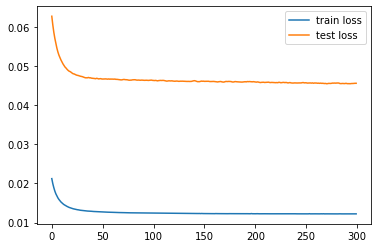

In [480]:
r = model2.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m), verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


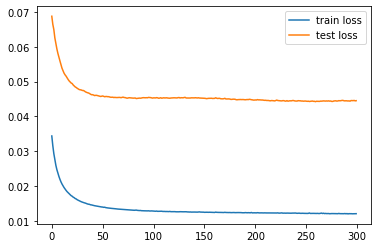

In [481]:
r = model3.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m), verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


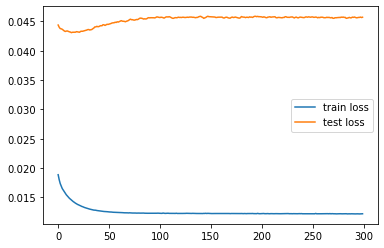

In [482]:
r = model4.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m), verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


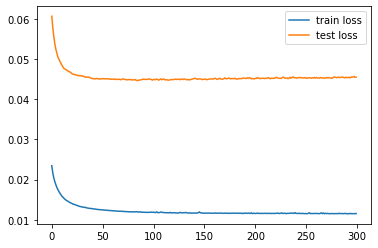

In [483]:
r = model5.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


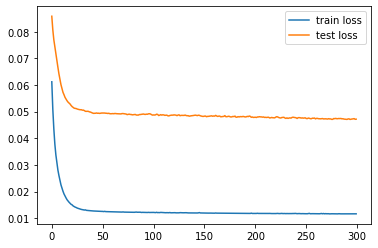

In [484]:
r = model6.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


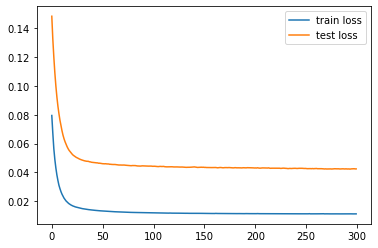

In [485]:
r = model7.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


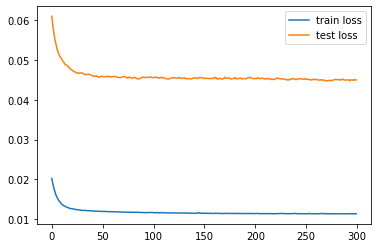

In [486]:
r = model8.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


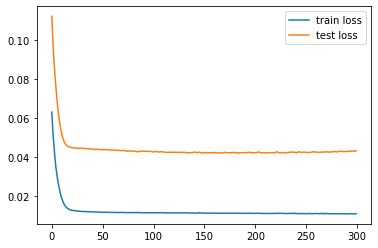

In [487]:
r = model9.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


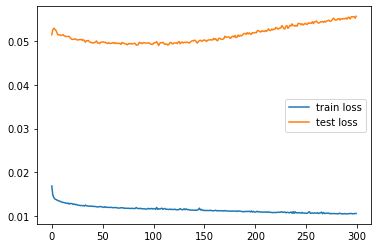

In [488]:
r = model10.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


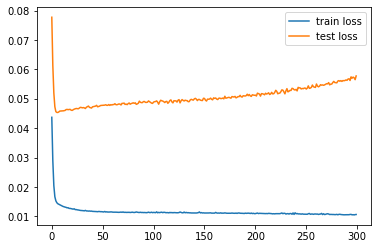

In [489]:
r = model11.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


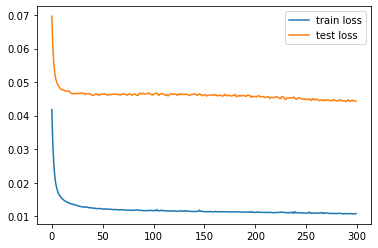

In [490]:
r = model12.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


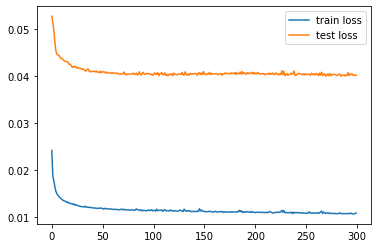

In [491]:
r = model13.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


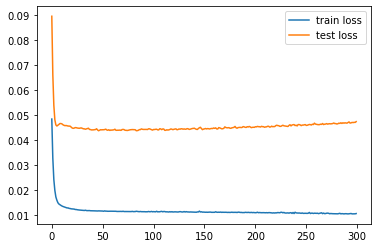

In [492]:
r = model14.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


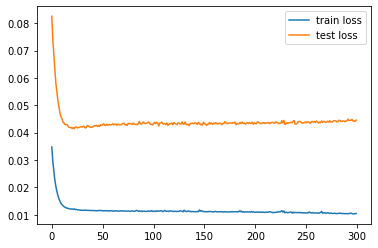

In [493]:
r = model15.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


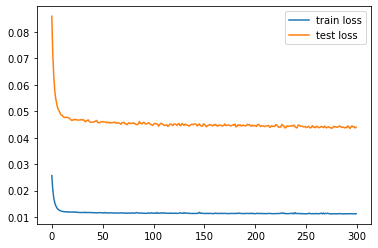

In [494]:
r = model16.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


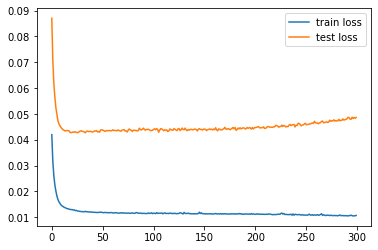

In [495]:
r = model17.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


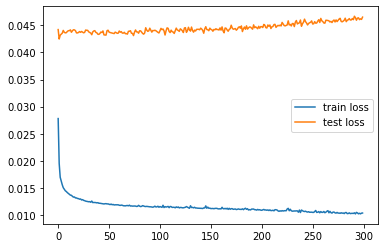

In [496]:
r = model18.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


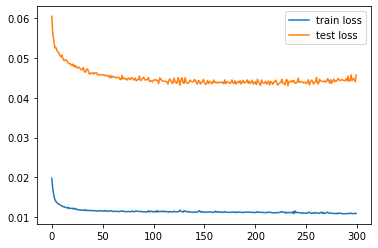

In [497]:
r = model19.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


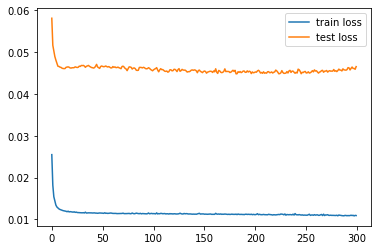

In [498]:
r = model20.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


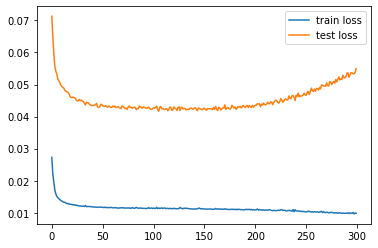

In [499]:
r = model21.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


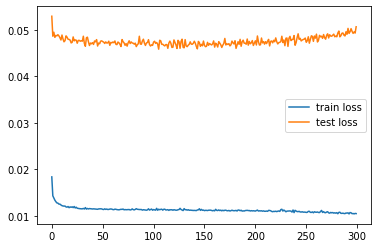

In [500]:
r = model22.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


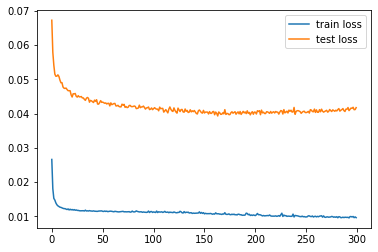

In [501]:
r = model23.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


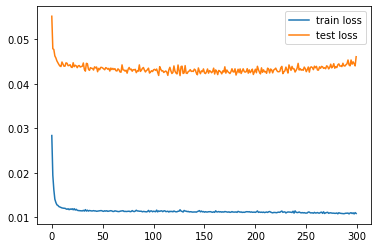

In [502]:
r = model24.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


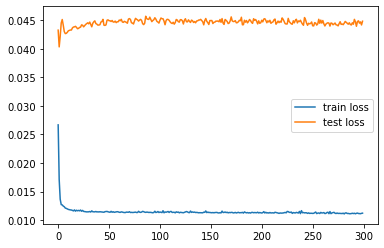

In [503]:
r = model25.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


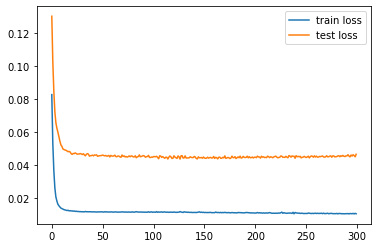

In [504]:
r = model26.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


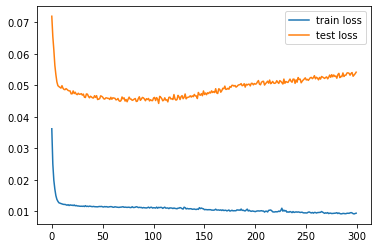

In [505]:
r = model27.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


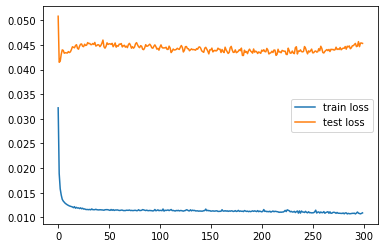

In [506]:
r = model28.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


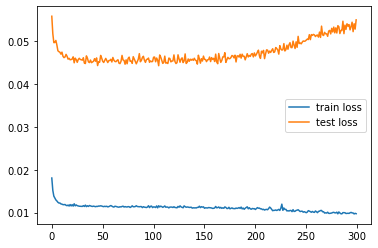

In [507]:
r = model29.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


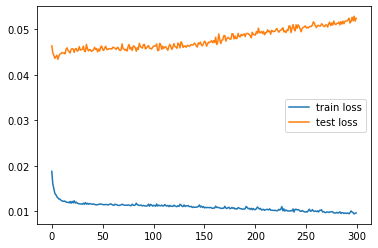

In [508]:
r = model30.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


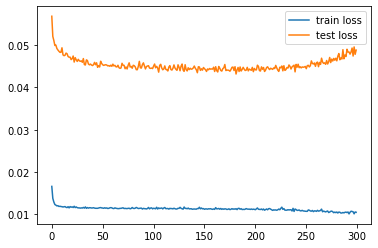

In [509]:
r = model31.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


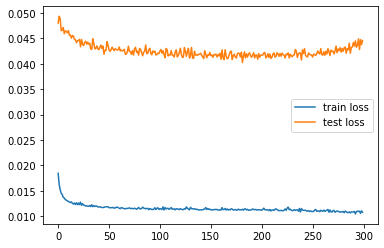

In [510]:
r = model32.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


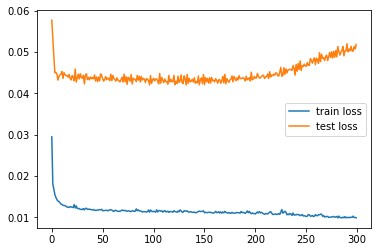

In [511]:
r = model33.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")


#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


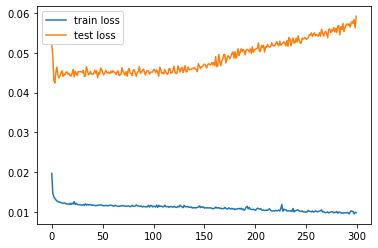

In [512]:
r = model34.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


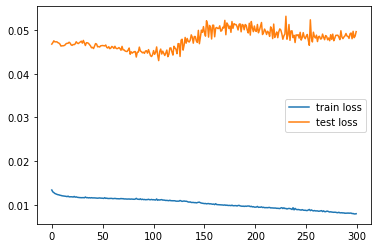

In [513]:
r = model35.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


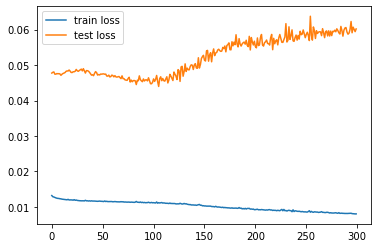

In [514]:
r = model36.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


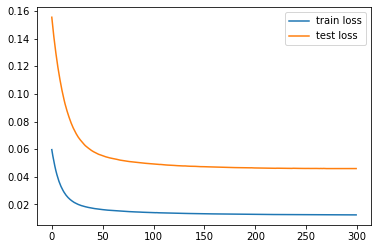

In [515]:
r = model2b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


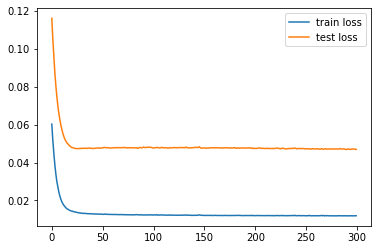

In [516]:
r = model3b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


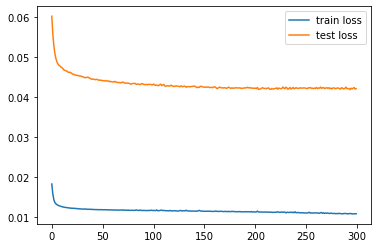

In [517]:
r = model4b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


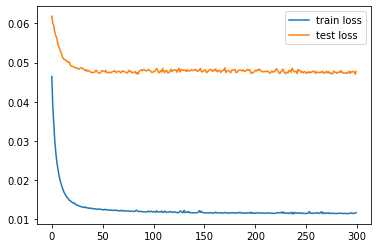

In [518]:
r = model5b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


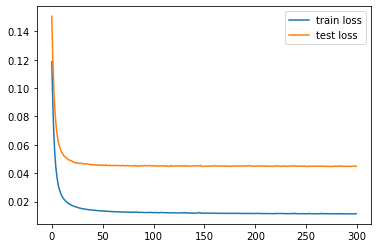

In [519]:
r = model6b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


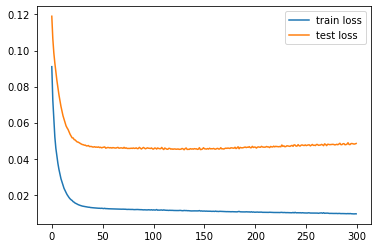

In [520]:
r = model7b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


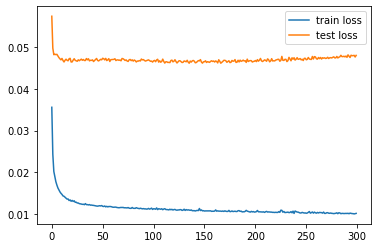

In [521]:
r = model8b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


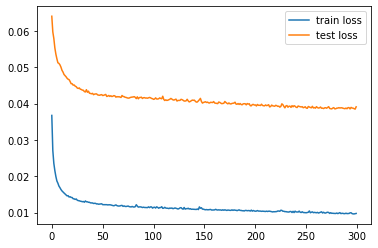

In [522]:
r = model9b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


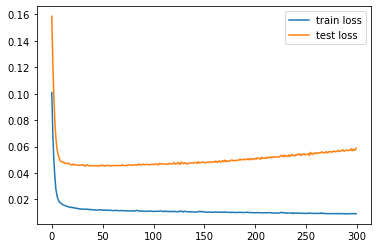

In [523]:
r = model10b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


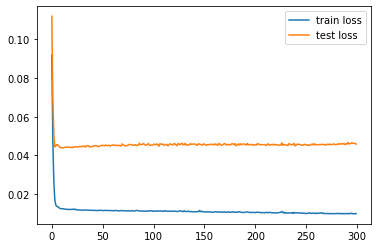

In [524]:
r = model11b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


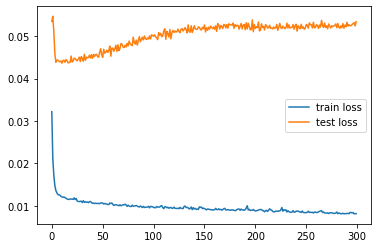

In [525]:
r = model12b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


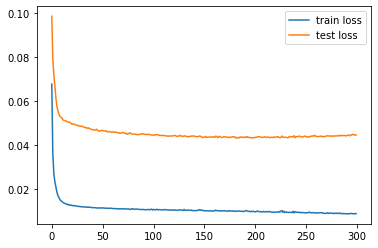

In [526]:
r = model13b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


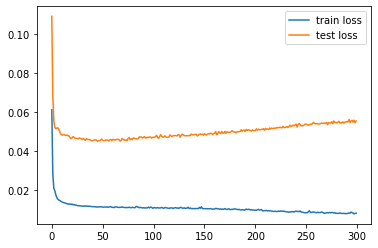

In [527]:
r = model14b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


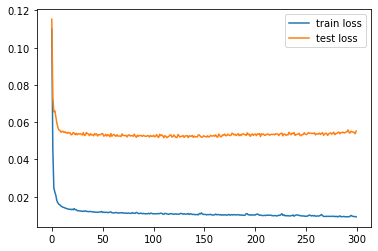

In [528]:
r = model15b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


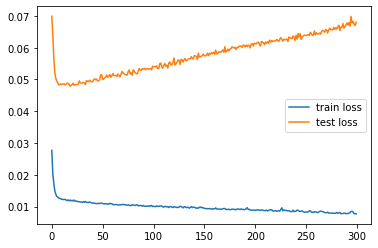

In [529]:
r = model16b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


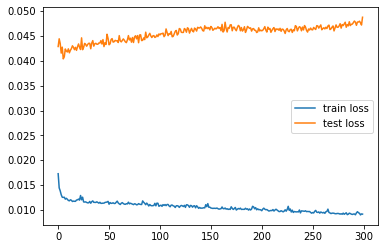

In [530]:
r = model17b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


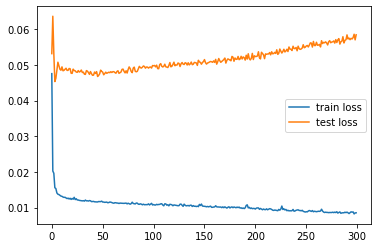

In [531]:
r = model18b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


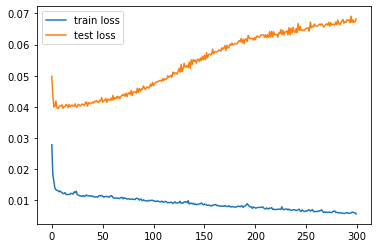

In [532]:
r = model19b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


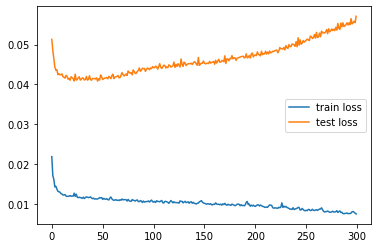

In [533]:
r = model20b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


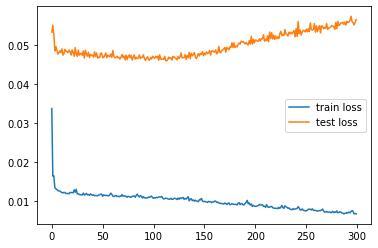

In [534]:
r = model21b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


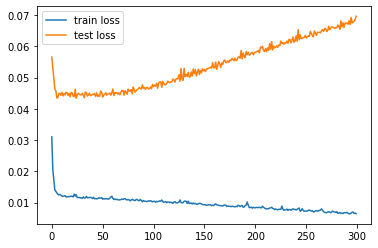

In [535]:
r = model22b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


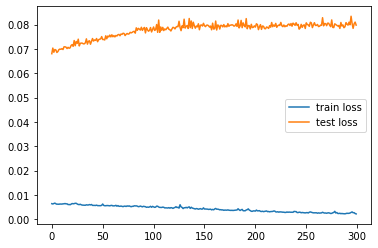

In [536]:
r = model22b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


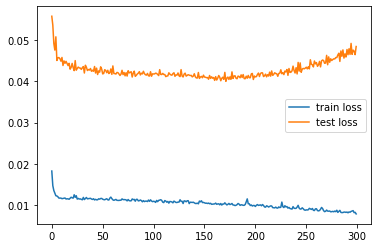

In [537]:
r = model23b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


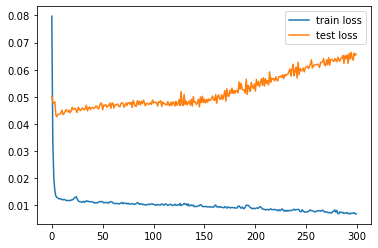

In [538]:
r = model24b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


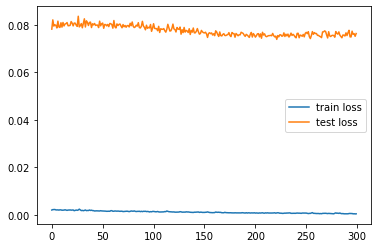

In [539]:
r = model22b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


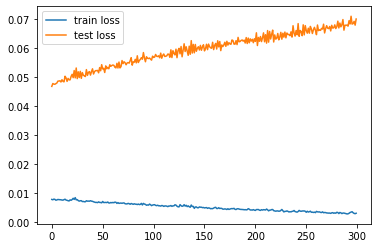

In [540]:
r = model23b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


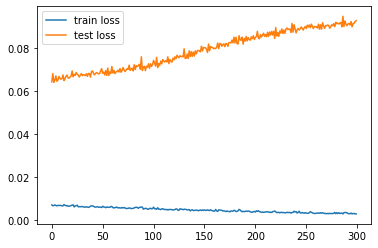

In [541]:
r = model24b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


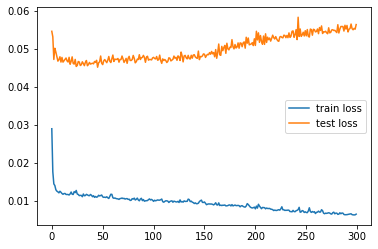

In [542]:
r = model25b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


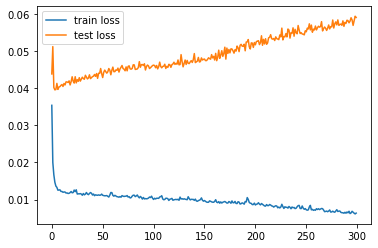

In [543]:
r = model26b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


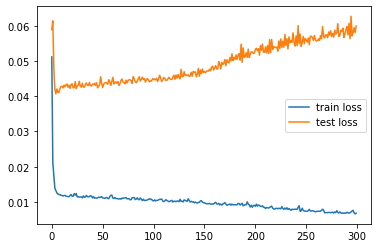

In [544]:
r = model27b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


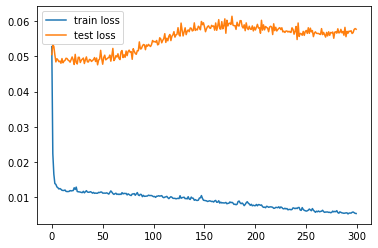

In [545]:
r = model28b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


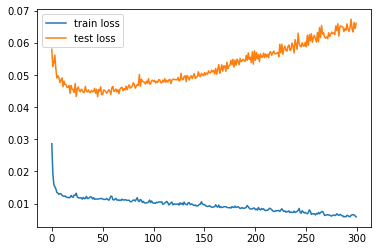

In [546]:
r = model29b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


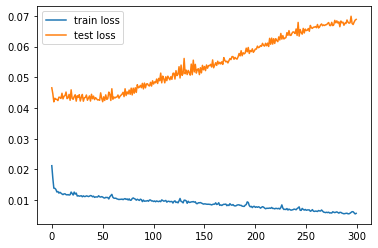

In [547]:
r = model30b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


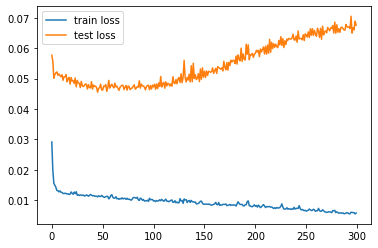

In [548]:
r = model31b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


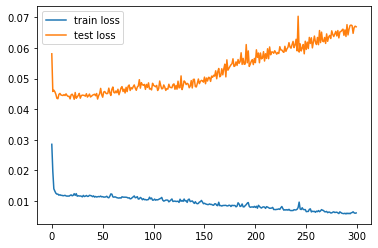

In [549]:
r = model32b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


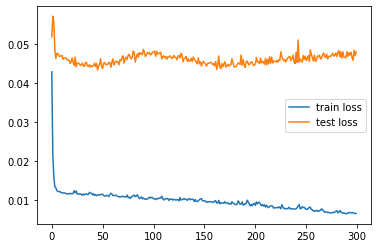

In [550]:
r = model33b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


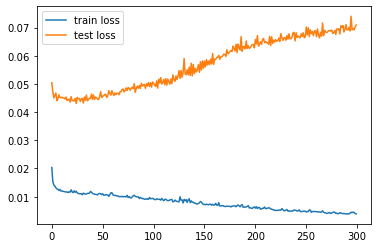

In [551]:
r = model34b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


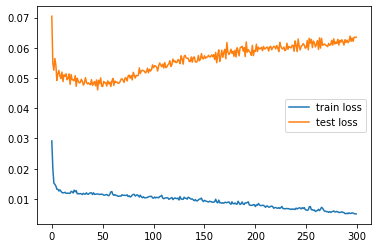

In [552]:
r = model35b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


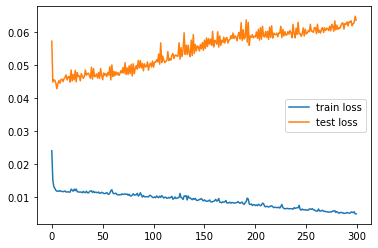

In [553]:
r = model36b.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


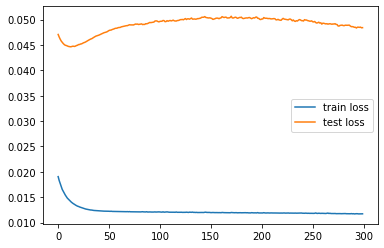

In [554]:
r = model2c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


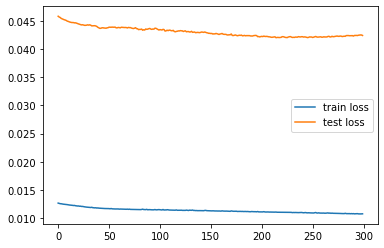

In [555]:
r = model3c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


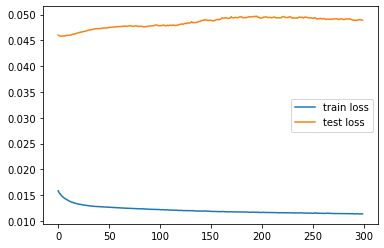

In [556]:
r = model4c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


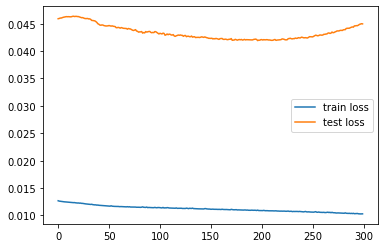

In [557]:
r = model5c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


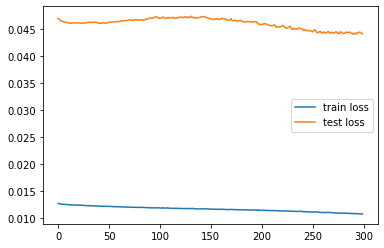

In [558]:
r = model6c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


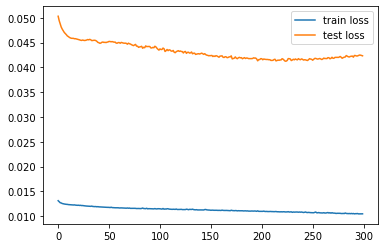

In [559]:
r = model7c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


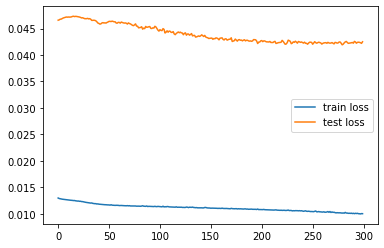

In [560]:
r = model8c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


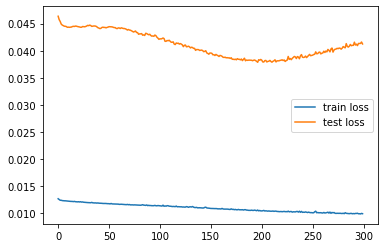

In [561]:
r = model9c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


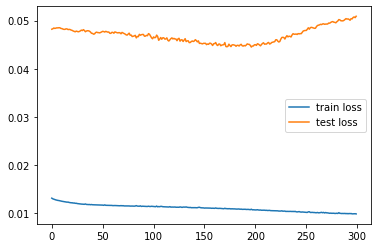

In [562]:
r = model10c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


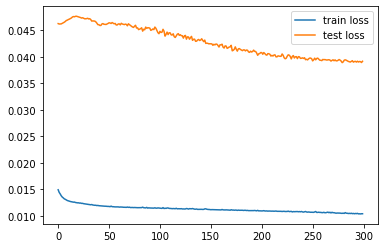

In [563]:
r = model11c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


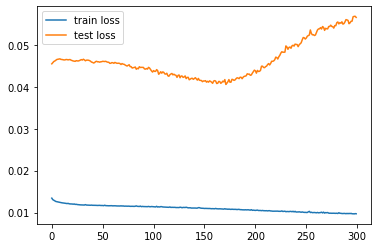

In [564]:
r = model12c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


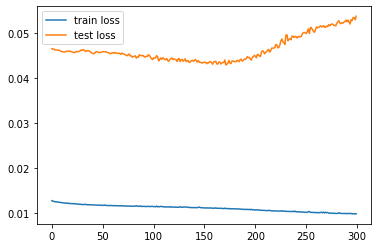

In [565]:
r = model13c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


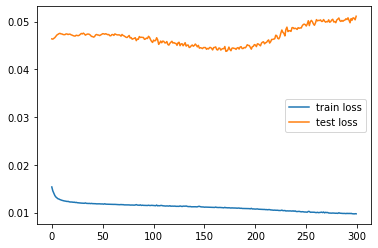

In [566]:
r = model14c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


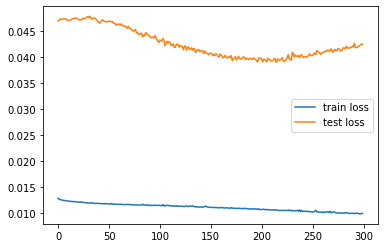

In [567]:
r = model15c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


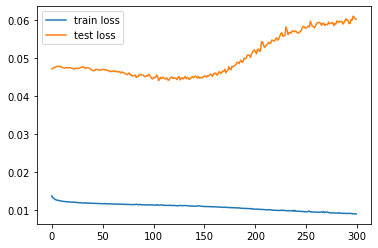

In [568]:
r = model16c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


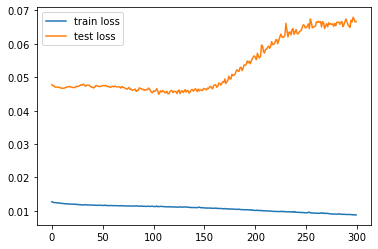

In [569]:
r = model17c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


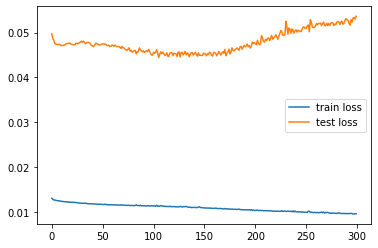

In [570]:
r = model18c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


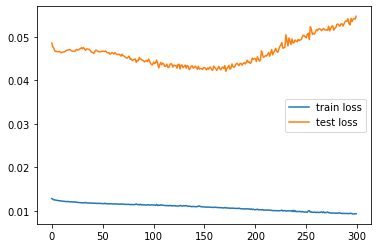

In [571]:
r = model19c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


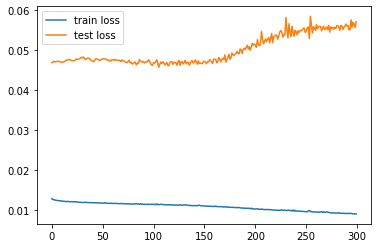

In [572]:
r = model20c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


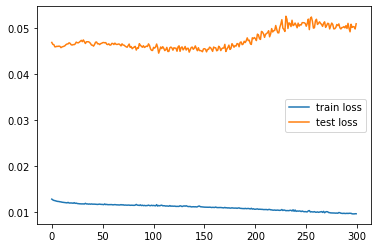

In [573]:
r = model21c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


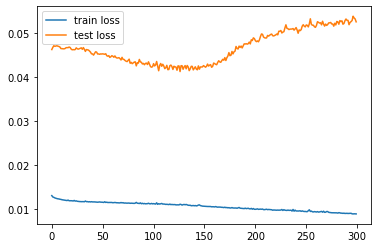

In [574]:
r = model22c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


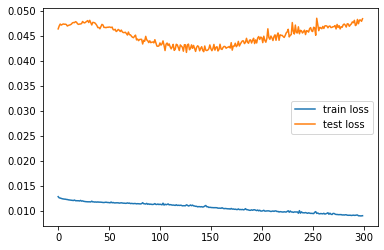

In [575]:
r = model23c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


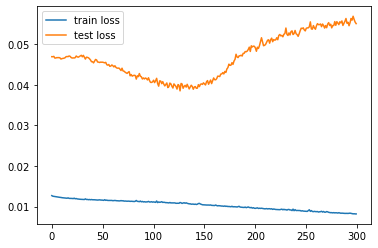

In [576]:
r = model24c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


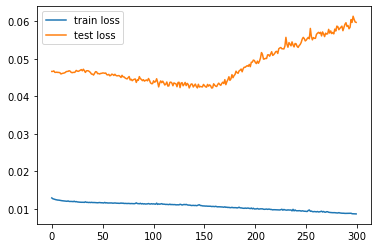

In [577]:
r = model25c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


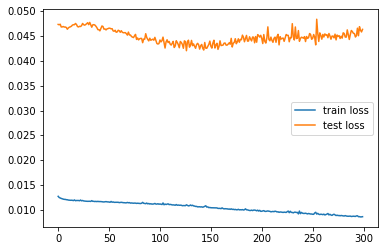

In [578]:
r = model26c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


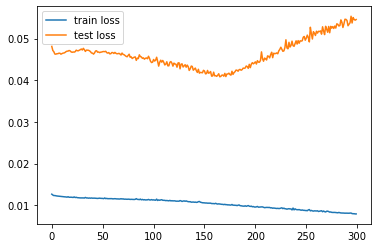

In [579]:
r = model27c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


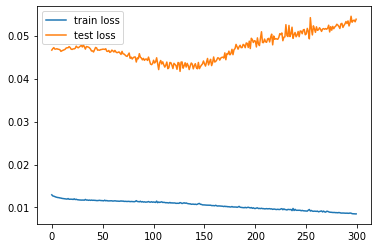

In [580]:
r = model28c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


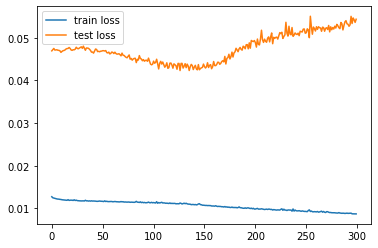

In [581]:
r = model29c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


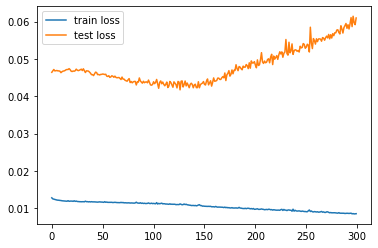

In [582]:
r = model30c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


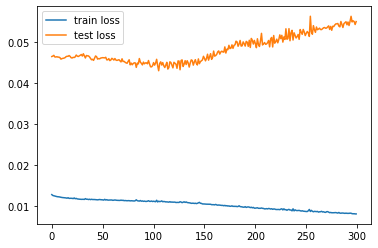

In [583]:
r = model31c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


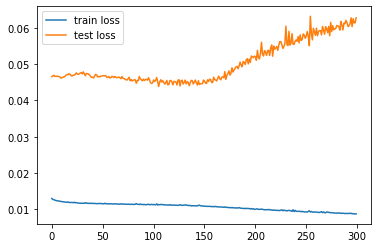

In [584]:
r = model32c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


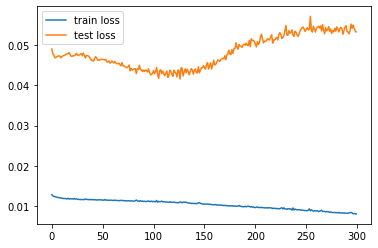

In [585]:
r = model33c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


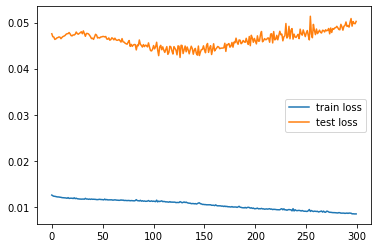

In [586]:
r = model34c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


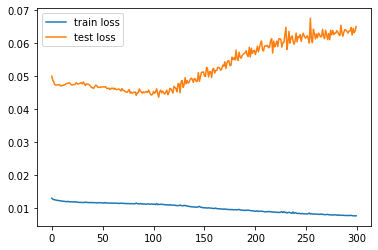

In [587]:
r = model35c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


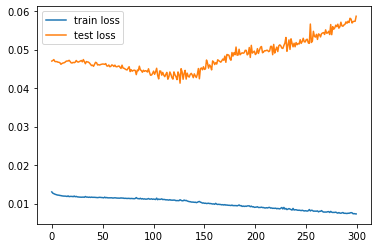

In [588]:
r = model36c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


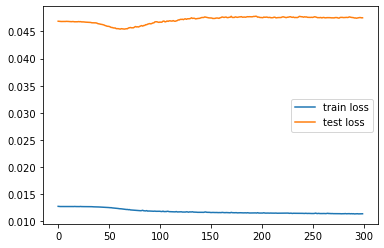

In [589]:
r = model2d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


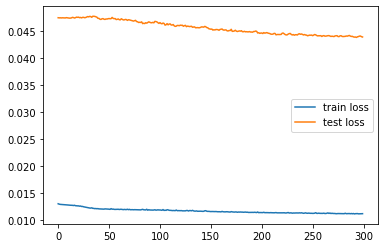

In [590]:
r = model3d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


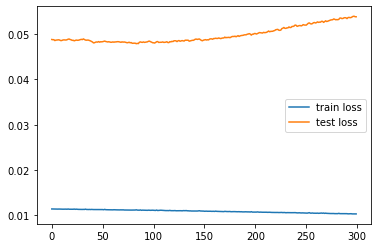

In [591]:
r = model4c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


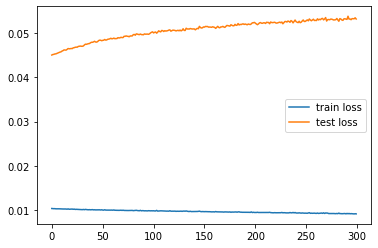

In [592]:
r = model5c.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


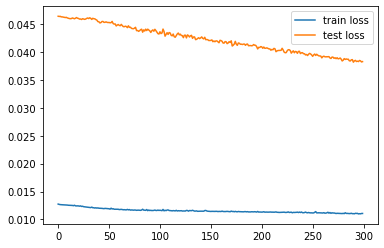

In [593]:
r = model6d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


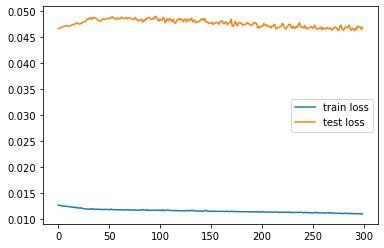

In [594]:
r = model7d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


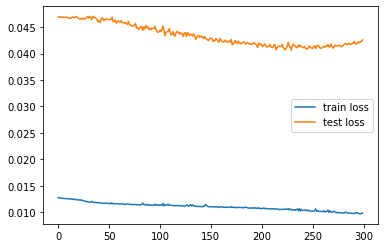

In [595]:
r = model8d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


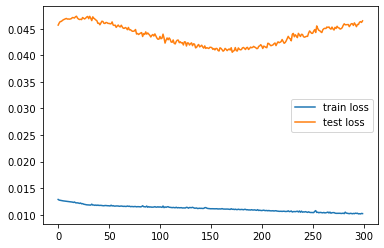

In [596]:
r = model9d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


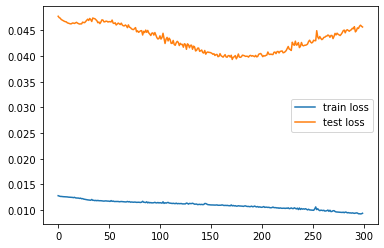

In [597]:
r = model10d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


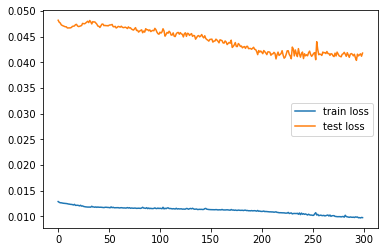

In [598]:
r = model11d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


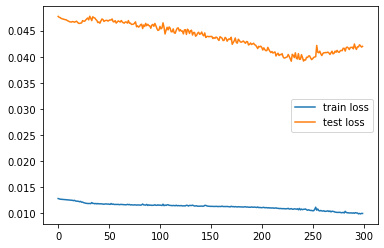

In [599]:
r = model12d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


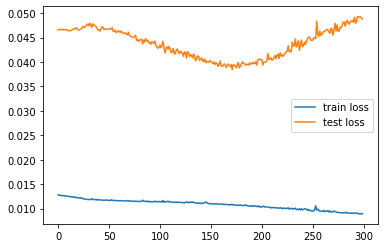

In [600]:
r = model13d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


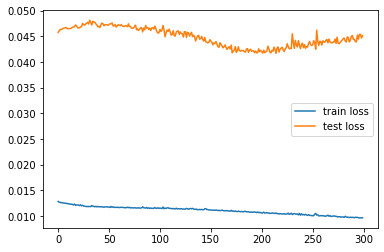

In [601]:
r = model14d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


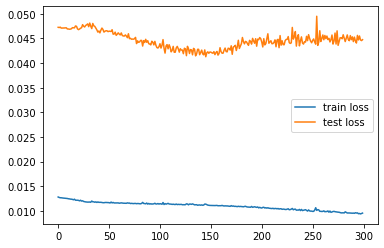

In [602]:
r = model15d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


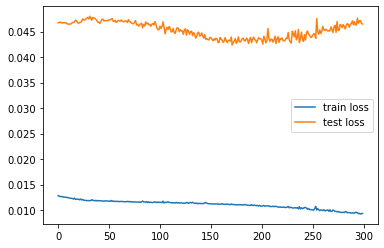

In [603]:
r = model16d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


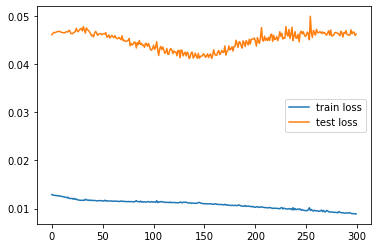

In [604]:
r = model17d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


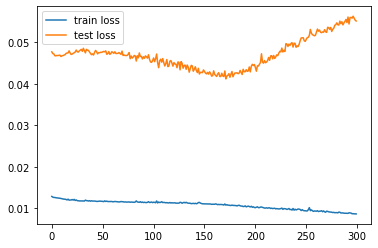

In [605]:
r = model18d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


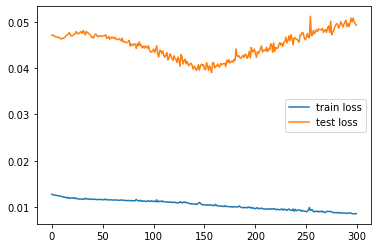

In [606]:
r = model19d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


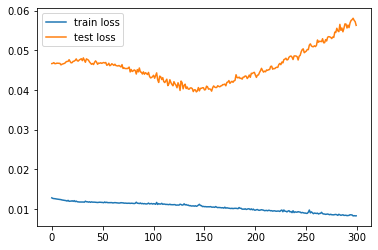

In [607]:
r = model20d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


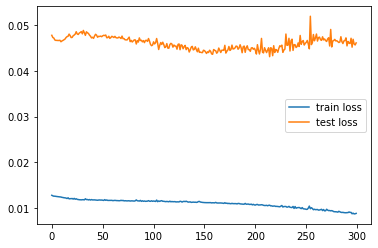

In [608]:
r = model21d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


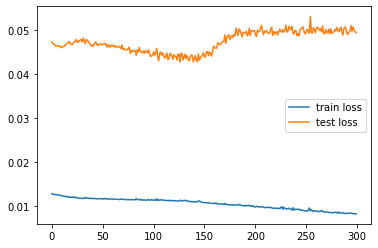

In [609]:
r = model22d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


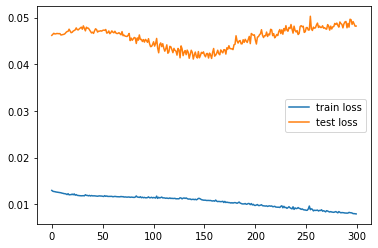

In [610]:
r = model23d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


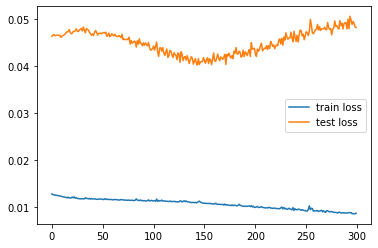

In [611]:
r = model24d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


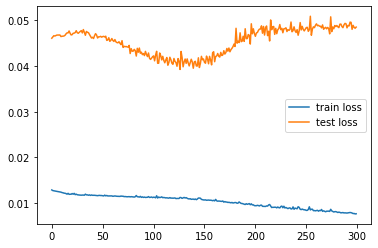

In [612]:
r = model25d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


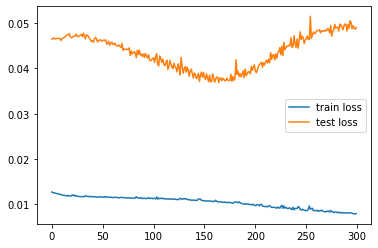

In [613]:
r = model26d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


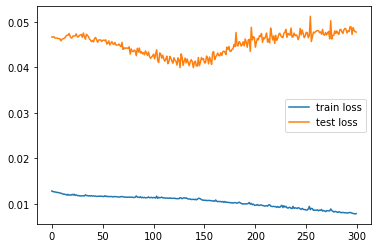

In [614]:
r = model27d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


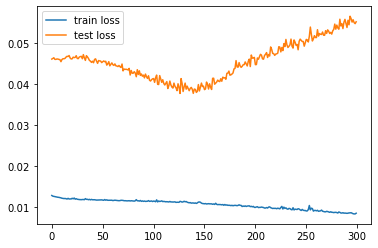

In [615]:
r = model28d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


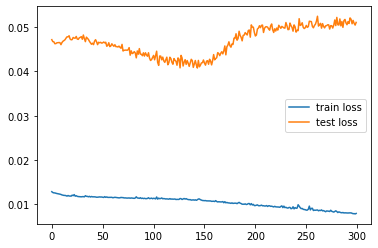

In [616]:
r = model29d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


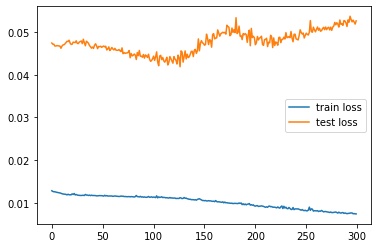

In [617]:
r = model30d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


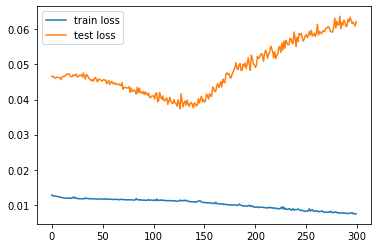

In [618]:
r = model31d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


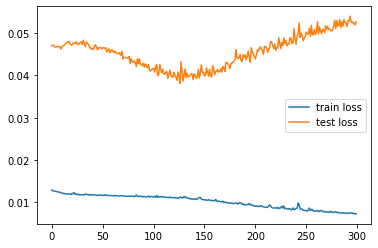

In [619]:
r = model32d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


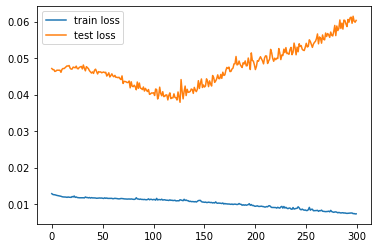

In [620]:
r = model33d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


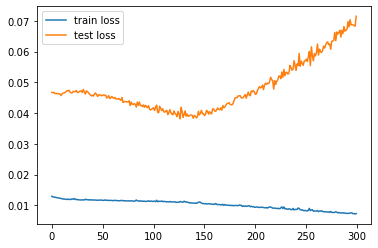

In [621]:
r = model34d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


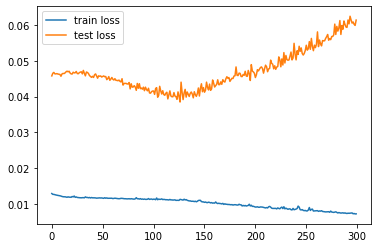

In [622]:
r = model35d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


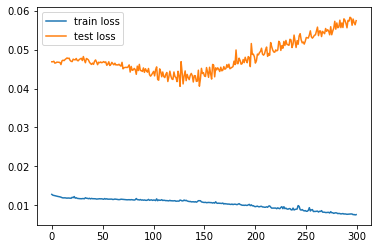

In [623]:
r = model36d.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


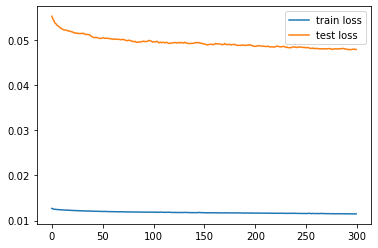

In [624]:
r = model2e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


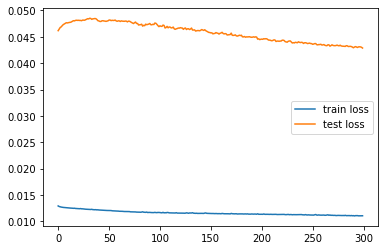

In [625]:
r = model3e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


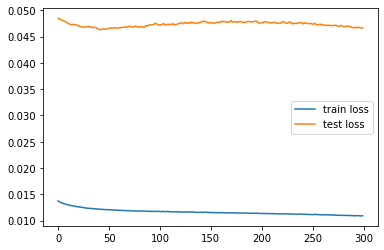

In [626]:
r = model4e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


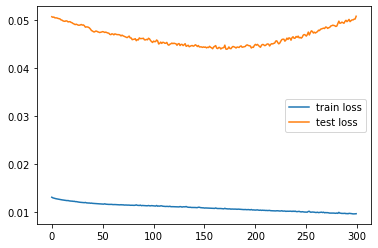

In [627]:
r = model5e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


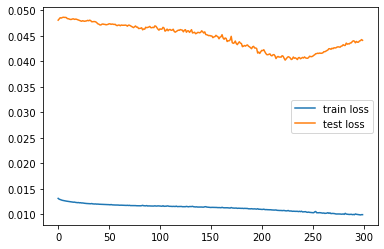

In [628]:
r = model6e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


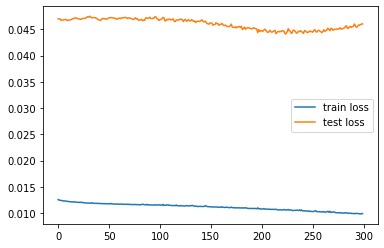

In [629]:
r = model7e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


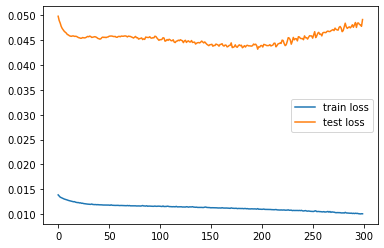

In [630]:
r = model8e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


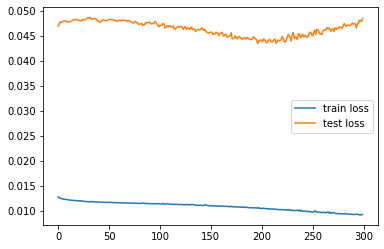

In [631]:
r = model9e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


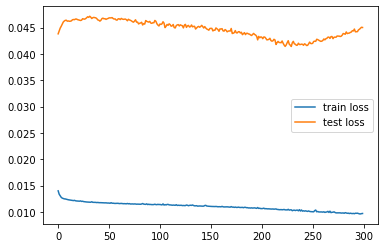

In [632]:
r = model10e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


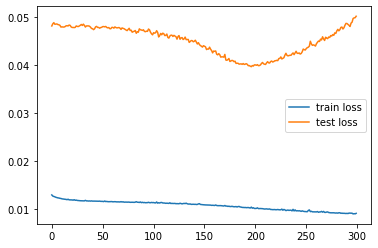

In [633]:
r = model11e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


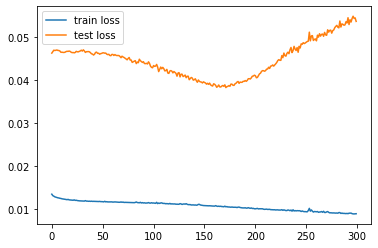

In [634]:
r = model12e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


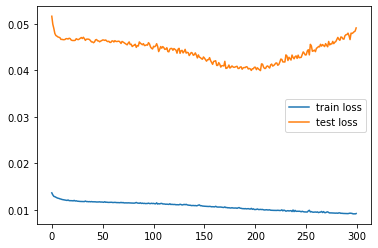

In [635]:
r = model13e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


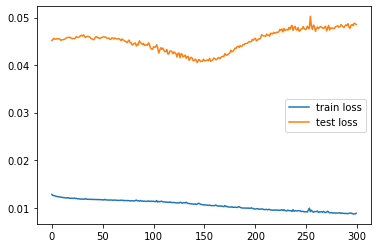

In [636]:
r = model14e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


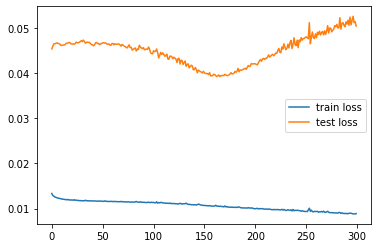

In [637]:
r = model15e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


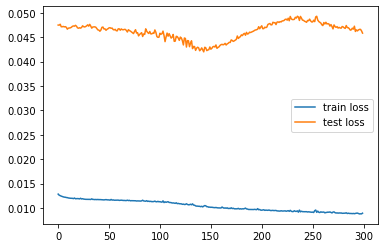

In [638]:
r = model16e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


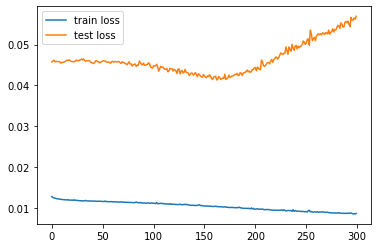

In [639]:
r = model17e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


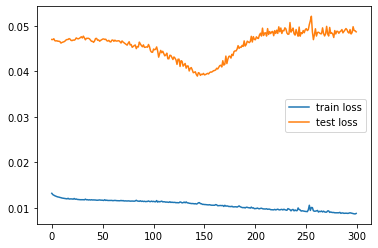

In [640]:
r = model18e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


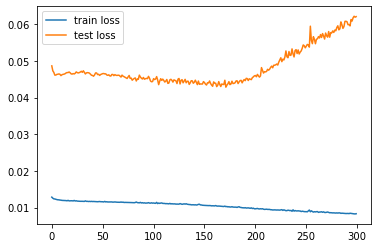

In [641]:
r = model19e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


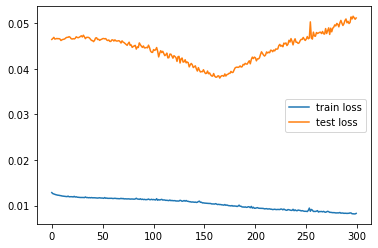

In [642]:
r = model20e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


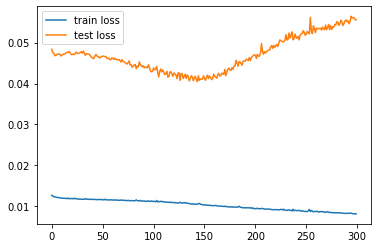

In [643]:
r = model21e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


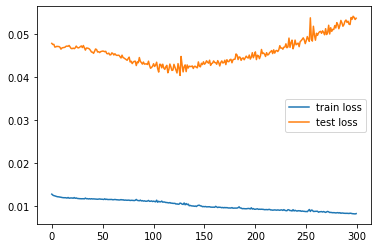

In [644]:
r = model22e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


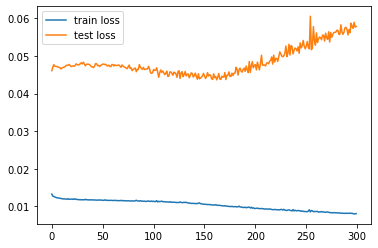

In [645]:
r = model23e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


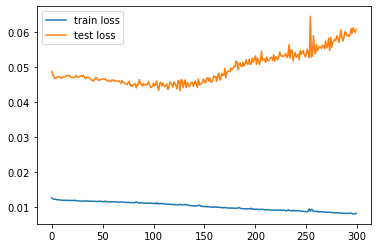

In [646]:
r = model24e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


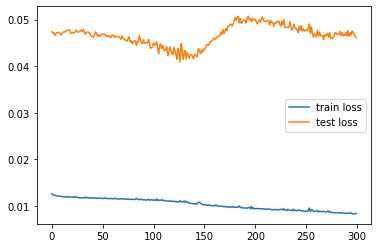

In [647]:
r = model25e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


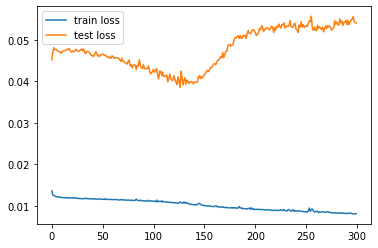

In [648]:
r = model26e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


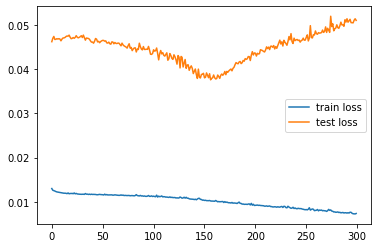

In [649]:
r = model27e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


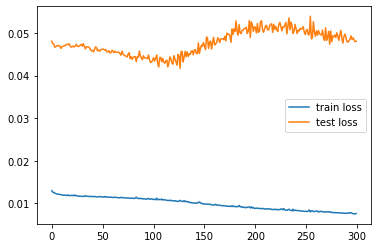

In [650]:
r = model28e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


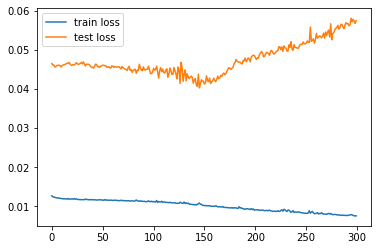

In [651]:
r = model29e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


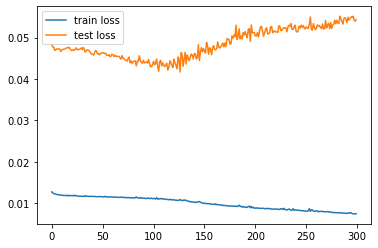

In [652]:
r = model30e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


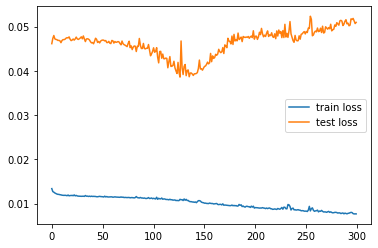

In [653]:
r = model31e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")
#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


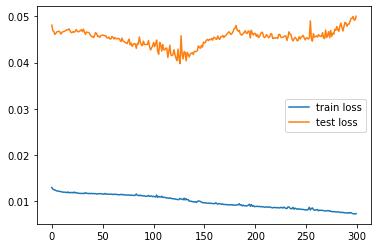

In [654]:
r = model32e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


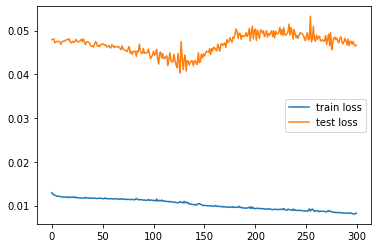

In [655]:
r = model33e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


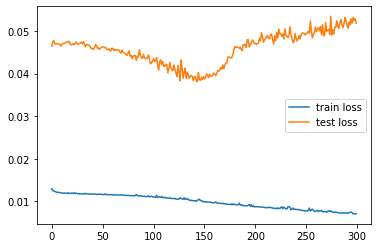

In [656]:
r = model34e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


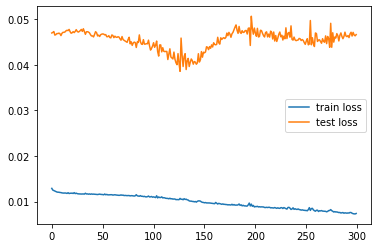

In [657]:
r = model35e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


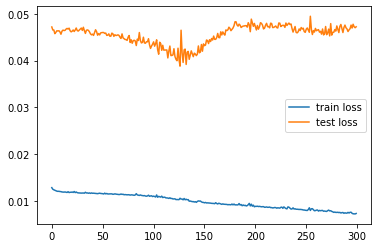

In [658]:
r = model36e.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


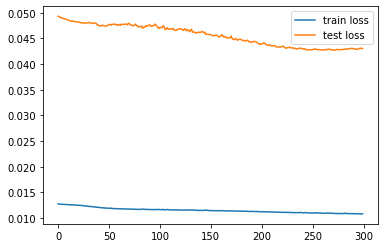

In [659]:
r = model2f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


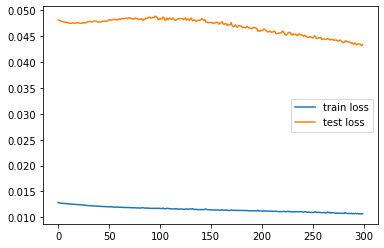

In [660]:
r = model3f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


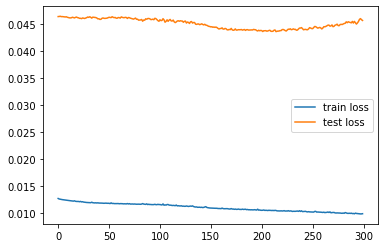

In [661]:
r = model4f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


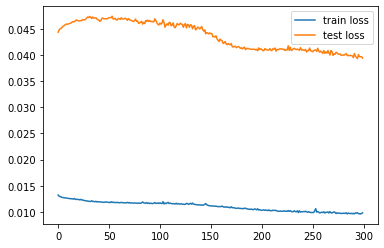

In [662]:
r = model5f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


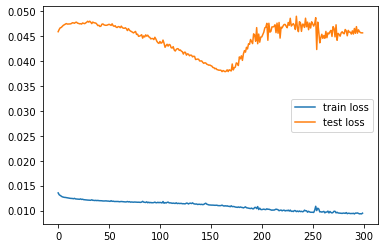

In [663]:
r = model6f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


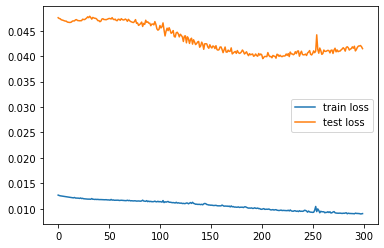

In [664]:
r = model7f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


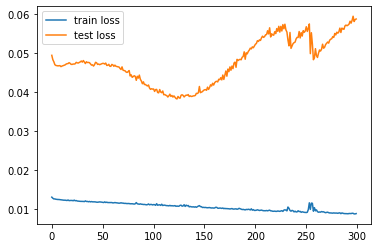

In [665]:
r = model8f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


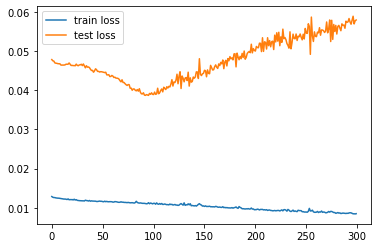

In [666]:
r = model9f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


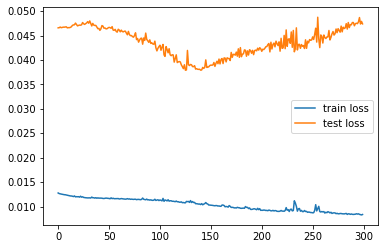

In [667]:
r = model10f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


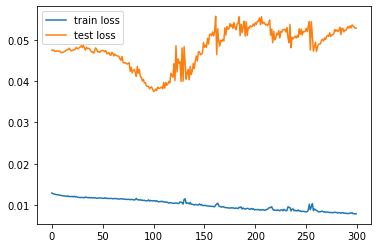

In [668]:
r = model11f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


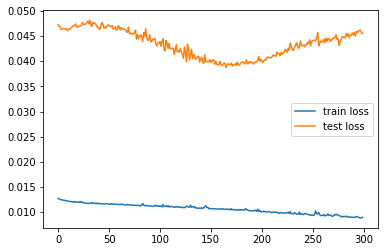

In [669]:
r = model12f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


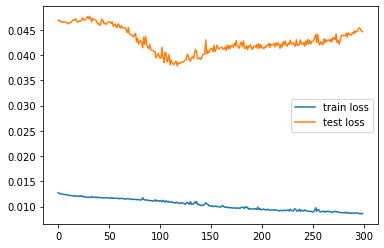

In [670]:
r = model13f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


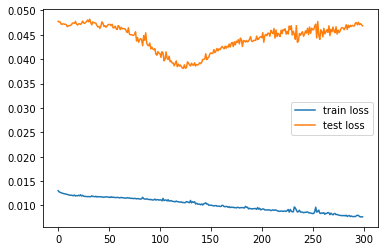

In [671]:
r = model14f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


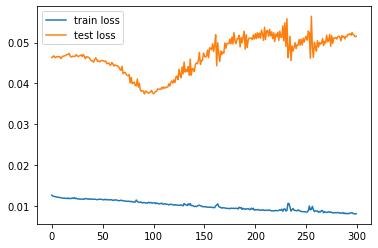

In [672]:
r = model15f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


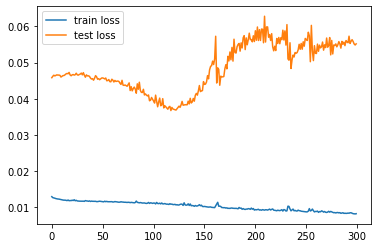

In [673]:
r = model16f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


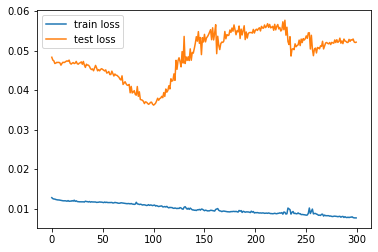

In [674]:
r = model17f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


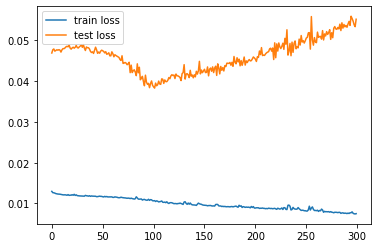

In [675]:
r = model18f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


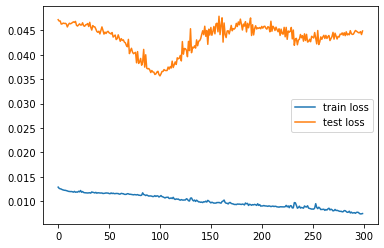

In [676]:
r = model19f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


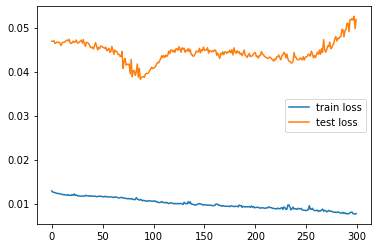

In [677]:
r = model20f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


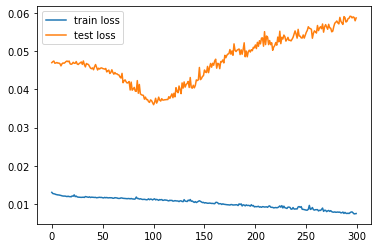

In [678]:
r = model21f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


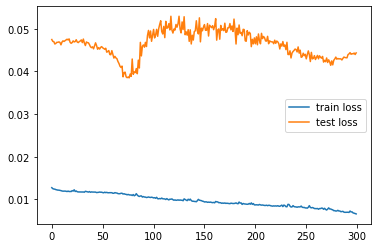

In [679]:
r = model22f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


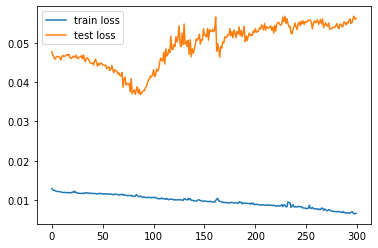

In [680]:
r = model23f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


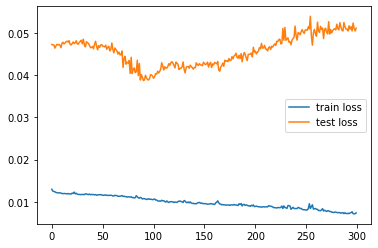

In [681]:
r = model24f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


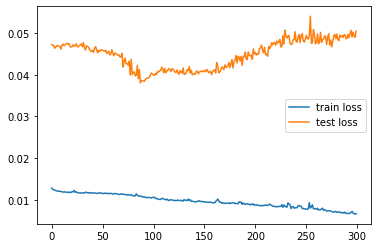

In [682]:
r = model25f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


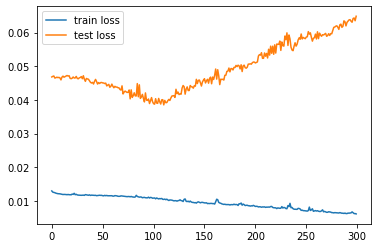

In [683]:
r = model26f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


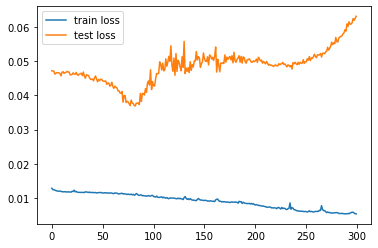

In [684]:
r = model27f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


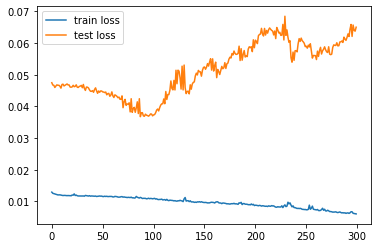

In [685]:
r = model28f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


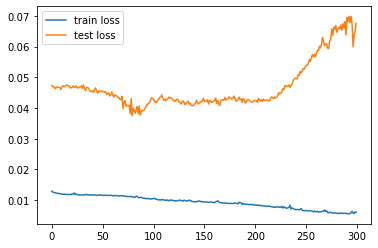

In [686]:
r = model29f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


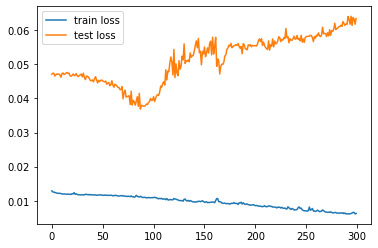

In [687]:
r = model30f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


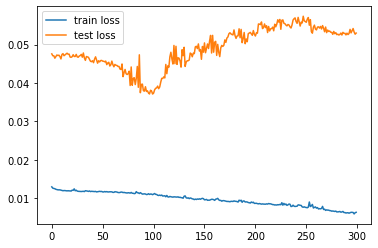

In [688]:
r = model31f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


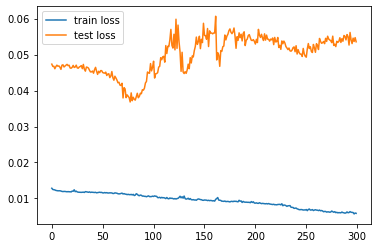

In [689]:
r = model32f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


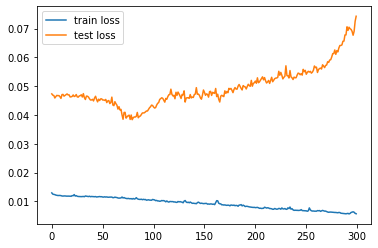

In [690]:
r = model33f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


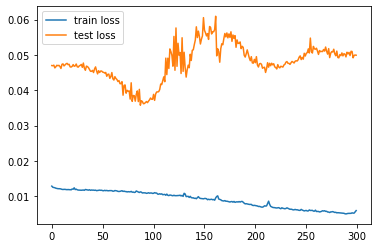

In [691]:
r = model34f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


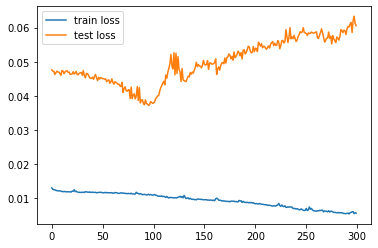

In [692]:
r = model35f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

modelo entrenado


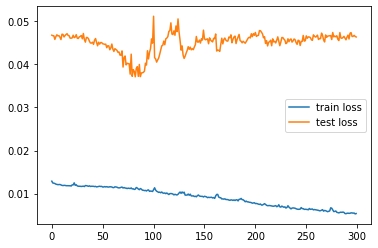

In [693]:
r = model36f.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),verbose = False
)
print("modelo entrenado")

#Gráfica
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

Usamos los modelos para hacer las predicciones del entrenamiento y pruebas

In [694]:
#Simple RNN 1 Capa

Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

Ptrain2 = model2.predict(Xtrain_m)
Ptest2 = model2.predict(Xtest_m)
Ptrain2 = Ptrain2[:,0]
Ptest2 = Ptest2[0]

Ptrain3 = model3.predict(Xtrain_m)
Ptest3 = model3.predict(Xtest_m)
Ptrain3 = Ptrain3[:,0]
Ptest3 = Ptest3[0]

Ptrain4 = model4.predict(Xtrain_m)
Ptest4 = model4.predict(Xtest_m)
Ptrain4 = Ptrain4[:,0]
Ptest4 = Ptest4[0]

Ptrain5 = model5.predict(Xtrain_m)
Ptest5 = model5.predict(Xtest_m)
Ptrain5 = Ptrain5[:,0]
Ptest5 = Ptest5[0]

Ptrain6 = model6.predict(Xtrain_m)
Ptest6 = model6.predict(Xtest_m)
Ptrain6 = Ptrain6[:,0]
Ptest6 = Ptest6[0]

Ptrain7 = model7.predict(Xtrain_m)
Ptest7 = model7.predict(Xtest_m)
Ptrain7 = Ptrain7[:,0]
Ptest7 = Ptest7[0]

Ptrain8 = model8.predict(Xtrain_m)
Ptest8 = model8.predict(Xtest_m)
Ptrain8 = Ptrain8[:,0]
Ptest8 = Ptest8[0]

Ptrain9 = model9.predict(Xtrain_m)
Ptest9 = model9.predict(Xtest_m)
Ptrain9 = Ptrain9[:,0]
Ptest9 = Ptest9[0]

Ptrain10 = model10.predict(Xtrain_m)
Ptest10 = model10.predict(Xtest_m)
Ptrain10 = Ptrain10[:,0]
Ptest10 = Ptest10[0]

Ptrain11 = model11.predict(Xtrain_m)
Ptest11 = model11.predict(Xtest_m)
Ptrain11 = Ptrain11[:,0]
Ptest11 = Ptest11[0]

Ptrain12 = model12.predict(Xtrain_m)
Ptest12 = model12.predict(Xtest_m)
Ptrain12 = Ptrain12[:,0]
Ptest12 = Ptest12[0]

Ptrain13 = model13.predict(Xtrain_m)
Ptest13 = model13.predict(Xtest_m)
Ptrain13 = Ptrain13[:,0]
Ptest13 = Ptest13[0]

Ptrain14 = model14.predict(Xtrain_m)
Ptest14 = model14.predict(Xtest_m)
Ptrain14 = Ptrain14[:,0]
Ptest14 = Ptest14[0]

Ptrain15 = model15.predict(Xtrain_m)
Ptest15 = model15.predict(Xtest_m)
Ptrain15 = Ptrain15[:,0]
Ptest15 = Ptest15[0]

Ptrain16 = model16.predict(Xtrain_m)
Ptest16 = model16.predict(Xtest_m)
Ptrain16 = Ptrain16[:,0]
Ptest16 = Ptest16[0]

Ptrain17 = model17.predict(Xtrain_m)
Ptest17 = model17.predict(Xtest_m)
Ptrain17 = Ptrain17[:,0]
Ptest17 = Ptest17[0]

Ptrain18 = model18.predict(Xtrain_m)
Ptest18 = model18.predict(Xtest_m)
Ptrain18 = Ptrain18[:,0]
Ptest18 = Ptest18[0]

Ptrain19 = model19.predict(Xtrain_m)
Ptest19 = model19.predict(Xtest_m)
Ptrain19 = Ptrain19[:,0]
Ptest19 = Ptest19[0]

Ptrain20 = model20.predict(Xtrain_m)
Ptest20 = model20.predict(Xtest_m)
Ptrain20 = Ptrain20[:,0]
Ptest120 = Ptest20[0]

Ptrain21 = model21.predict(Xtrain_m)
Ptest21 = model21.predict(Xtest_m)
Ptrain21 = Ptrain21[:,0]
Ptest21 = Ptest21[0]

Ptrain22 = model22.predict(Xtrain_m)
Ptest22 = model22.predict(Xtest_m)
Ptrain22 = Ptrain22[:,0]
Ptest22 = Ptest22[0]

Ptrain23 = model23.predict(Xtrain_m)
Ptest23 = model23.predict(Xtest_m)
Ptrain23 = Ptrain23[:,0]
Ptest23 = Ptest23[0]

Ptrain24 = model24.predict(Xtrain_m)
Ptest24 = model24.predict(Xtest_m)
Ptrain24 = Ptrain24[:,0]
Ptest24 = Ptest24[0]

Ptrain25 = model25.predict(Xtrain_m)
Ptest25 = model25.predict(Xtest_m)
Ptrain25 = Ptrain25[:,0]
Ptest25 = Ptest25[0]

Ptrain26 = model26.predict(Xtrain_m)
Ptest26 = model26.predict(Xtest_m)
Ptrain26 = Ptrain26[:,0]
Ptest26 = Ptest26[0]

Ptrain27 = model27.predict(Xtrain_m)
Ptest27 = model27.predict(Xtest_m)
Ptrain27 = Ptrain27[:,0]
Ptest27 = Ptest27[0]

Ptrain28 = model28.predict(Xtrain_m)
Ptest28 = model28.predict(Xtest_m)
Ptrain28 = Ptrain28[:,0]
Ptest28 = Ptest28[0]

Ptrain29 = model29.predict(Xtrain_m)
Ptest29 = model29.predict(Xtest_m)
Ptrain29 = Ptrain29[:,0]
Ptest29 = Ptest29[0]

Ptrain30 = model30.predict(Xtrain_m)
Ptest30 = model30.predict(Xtest_m)
Ptrain30 = Ptrain30[:,0]
Ptest30 = Ptest30[0]

Ptrain31 = model31.predict(Xtrain_m)
Ptest31 = model31.predict(Xtest_m)
Ptrain31 = Ptrain31[:,0]
Ptest31 = Ptest31[0]

Ptrain32 = model32.predict(Xtrain_m)
Ptest32 = model32.predict(Xtest_m)
Ptrain32 = Ptrain32[:,0]
Ptest32 = Ptest32[0]

Ptrain33 = model33.predict(Xtrain_m)
Ptest33 = model33.predict(Xtest_m)
Ptrain33 = Ptrain33[:,0]
Ptest33 = Ptest33[0]

Ptrain34 = model34.predict(Xtrain_m)
Ptest34 = model34.predict(Xtest_m)
Ptrain34 = Ptrain34[:,0]
Ptest34 = Ptest34[0]

Ptrain35 = model35.predict(Xtrain_m)
Ptest35 = model35.predict(Xtest_m)
Ptrain35 = Ptrain35[:,0]
Ptest35 = Ptest35[0]

Ptrain36 = model36.predict(Xtrain_m)
Ptest36 = model36.predict(Xtest_m)
Ptrain36 = Ptrain36[:,0]
Ptest36 = Ptest36[0]

3/3 [==============================] - 0s 2ms/step


In [695]:
# RNN con 2 capas
Ptrain2 = model2.predict(Xtrain_m)
Ptest2 = model2.predict(Xtest_m)
Ptrain2 = Ptrain2[:,0]
Ptest2 = Ptest2[0]

Ptrain3 = model3.predict(Xtrain_m)
Ptest3 = model3.predict(Xtest_m)
Ptrain3 = Ptrain3[:,0]
Ptest3 = Ptest3[0]

Ptrain4 = model4.predict(Xtrain_m)
Ptest4 = model4.predict(Xtest_m)
Ptrain4 = Ptrain4[:,0]
Ptest4 = Ptest4[0]

Ptrain5 = model5.predict(Xtrain_m)
Ptest5 = model5.predict(Xtest_m)
Ptrain5 = Ptrain5[:,0]
Ptest5 = Ptest5[0]

Ptrain6 = model6.predict(Xtrain_m)
Ptest6 = model6.predict(Xtest_m)
Ptrain6 = Ptrain6[:,0]
Ptest6 = Ptest6[0]

Ptrain7 = model7.predict(Xtrain_m)
Ptest7 = model7.predict(Xtest_m)
Ptrain7 = Ptrain7[:,0]
Ptest7 = Ptest7[0]

Ptrain8 = model8.predict(Xtrain_m)
Ptest8 = model8.predict(Xtest_m)
Ptrain8 = Ptrain8[:,0]
Ptest8 = Ptest8[0]

Ptrain9 = model9.predict(Xtrain_m)
Ptest9 = model9.predict(Xtest_m)
Ptrain9 = Ptrain9[:,0]
Ptest9 = Ptest9[0]

Ptrain10 = model10.predict(Xtrain_m)
Ptest10 = model10.predict(Xtest_m)
Ptrain10 = Ptrain10[:,0]
Ptest10 = Ptest10[0]

Ptrain11 = model11.predict(Xtrain_m)
Ptest11 = model11.predict(Xtest_m)
Ptrain11 = Ptrain11[:,0]
Ptest11 = Ptest11[0]

Ptrain12 = model12.predict(Xtrain_m)
Ptest12 = model12.predict(Xtest_m)
Ptrain12 = Ptrain12[:,0]
Ptest12 = Ptest12[0]

Ptrain13 = model13.predict(Xtrain_m)
Ptest13 = model13.predict(Xtest_m)
Ptrain13 = Ptrain13[:,0]
Ptest13 = Ptest13[0]

Ptrain14 = model14.predict(Xtrain_m)
Ptest14 = model14.predict(Xtest_m)
Ptrain14 = Ptrain14[:,0]
Ptest14 = Ptest14[0]

Ptrain15 = model15.predict(Xtrain_m)
Ptest15 = model15.predict(Xtest_m)
Ptrain15 = Ptrain15[:,0]
Ptest15 = Ptest15[0]

Ptrain16 = model16.predict(Xtrain_m)
Ptest16 = model16.predict(Xtest_m)
Ptrain16 = Ptrain16[:,0]
Ptest16 = Ptest16[0]

Ptrain17 = model17.predict(Xtrain_m)
Ptest17 = model17.predict(Xtest_m)
Ptrain17 = Ptrain17[:,0]
Ptest17 = Ptest17[0]

Ptrain18 = model18.predict(Xtrain_m)
Ptest18 = model18.predict(Xtest_m)
Ptrain18 = Ptrain18[:,0]
Ptest18 = Ptest18[0]

Ptrain19 = model19.predict(Xtrain_m)
Ptest19 = model19.predict(Xtest_m)
Ptrain19 = Ptrain19[:,0]
Ptest19 = Ptest19[0]

Ptrain20 = model20.predict(Xtrain_m)
Ptest20 = model20.predict(Xtest_m)
Ptrain20 = Ptrain20[:,0]
Ptest20 = Ptest20[0]

Ptrain21 = model21.predict(Xtrain_m)
Ptest21 = model21.predict(Xtest_m)
Ptrain21 = Ptrain21[:,0]
Ptest21 = Ptest21[0]

Ptrain22 = model22.predict(Xtrain_m)
Ptest22 = model22.predict(Xtest_m)
Ptrain22 = Ptrain22[:,0]
Ptest22 = Ptest22[0]

Ptrain23 = model23.predict(Xtrain_m)
Ptest23 = model23.predict(Xtest_m)
Ptrain23 = Ptrain23[:,0]
Ptest23 = Ptest23[0]

Ptrain24 = model24.predict(Xtrain_m)
Ptest24 = model24.predict(Xtest_m)
Ptrain24 = Ptrain24[:,0]
Ptest24 = Ptest24[0]

Ptrain25 = model25.predict(Xtrain_m)
Ptest25 = model25.predict(Xtest_m)
Ptrain25 = Ptrain25[:,0]
Ptest25 = Ptest25[0]

Ptrain26 = model26.predict(Xtrain_m)
Ptest26 = model26.predict(Xtest_m)
Ptrain26 = Ptrain26[:,0]
Ptest26 = Ptest26[0]

Ptrain27 = model27.predict(Xtrain_m)
Ptest27 = model27.predict(Xtest_m)
Ptrain27 = Ptrain27[:,0]
Ptest27 = Ptest27[0]

Ptrain28 = model28.predict(Xtrain_m)
Ptest28 = model28.predict(Xtest_m)
Ptrain28 = Ptrain28[:,0]
Ptest28 = Ptest28[0]

Ptrain29 = model29.predict(Xtrain_m)
Ptest29 = model29.predict(Xtest_m)
Ptrain29 = Ptrain29[:,0]
Ptest29 = Ptest29[0]

Ptrain30 = model30.predict(Xtrain_m)
Ptest30 = model30.predict(Xtest_m)
Ptrain30 = Ptrain30[:,0]
Ptest30 = Ptest30[0]

Ptrain31 = model31.predict(Xtrain_m)
Ptest31 = model31.predict(Xtest_m)
Ptrain31 = Ptrain31[:,0]
Ptest31 = Ptest31[0]

Ptrain32 = model32.predict(Xtrain_m)
Ptest32 = model32.predict(Xtest_m)
Ptrain32 = Ptrain32[:,0]
Ptest32 = Ptest32[0]

Ptrain33 = model33.predict(Xtrain_m)
Ptest33 = model33.predict(Xtest_m)
Ptrain33 = Ptrain33[:,0]
Ptest33 = Ptest33[0]

Ptrain34 = model34.predict(Xtrain_m)
Ptest34 = model34.predict(Xtest_m)
Ptrain34 = Ptrain34[:,0]
Ptest34 = Ptest34[0]

Ptrain35 = model35.predict(Xtrain_m)
Ptest35 = model35.predict(Xtest_m)
Ptrain35 = Ptrain35[:,0]
Ptest35 = Ptest35[0]

Ptrain36 = model36.predict(Xtrain_m)
Ptest36 = model36.predict(Xtest_m)
Ptrain36 = Ptrain36[:,0]
Ptest36 = Ptest36[0]

Ptrain2b = model2b.predict(Xtrain_m)
Ptest2b = model2b.predict(Xtest_m)
Ptrain2b = Ptrain2b[:,0]
Ptest2b = Ptest2b[0]

Ptrain3b = model3b.predict(Xtrain_m)
Ptest3b = model3b.predict(Xtest_m)
Ptrain3b = Ptrain3b[:,0]
Ptest3b = Ptest3b[0]

Ptrain4b = model4b.predict(Xtrain_m)
Ptest4b = model4b.predict(Xtest_m)
Ptrain4b = Ptrain4b[:,0]
Ptest4b = Ptest4b[0]

Ptrain5b = model5b.predict(Xtrain_m)
Ptest5b = model5b.predict(Xtest_m)
Ptrain5b = Ptrain5b[:,0]
Ptest5b = Ptest5b[0]

Ptrain6b = model6b.predict(Xtrain_m)
Ptest6b = model6b.predict(Xtest_m)
Ptrain6b = Ptrain6b[:,0]
Ptest6b = Ptest6b[0]

Ptrain7b = model7b.predict(Xtrain_m)
Ptest7b = model7b.predict(Xtest_m)
Ptrain7b = Ptrain7b[:,0]
Ptest7b = Ptest7b[0]

Ptrain8b = model8b.predict(Xtrain_m)
Ptest8b = model8b.predict(Xtest_m)
Ptrain8b = Ptrain8b[:,0]
Ptest8b = Ptest8b[0]

Ptrain9b = model9b.predict(Xtrain_m)
Ptest9b = model9b.predict(Xtest_m)
Ptrain9b = Ptrain9b[:,0]
Ptest9b = Ptest9b[0]

Ptrain10b = model10b.predict(Xtrain_m)
Ptest10b = model10b.predict(Xtest_m)
Ptrain10b = Ptrain10b[:,0]
Ptest10b = Ptest10b[0]

Ptrain11b = model11b.predict(Xtrain_m)
Ptest11b = model11b.predict(Xtest_m)
Ptrain11b = Ptrain11b[:,0]
Ptest11b = Ptest11b[0]

Ptrain12b = model12b.predict(Xtrain_m)
Ptest12b = model12b.predict(Xtest_m)
Ptrain12b = Ptrain12b[:,0]
Ptest12b = Ptest12b[0]

Ptrain13b = model13b.predict(Xtrain_m)
Ptest13b = model13b.predict(Xtest_m)
Ptrain13b = Ptrain13b[:,0]
Ptest13b = Ptest13b[0]

Ptrain14b = model14b.predict(Xtrain_m)
Ptest14b = model14b.predict(Xtest_m)
Ptrain14b = Ptrain14b[:,0]
Ptest14b = Ptest14b[0]

Ptrain15b = model15b.predict(Xtrain_m)
Ptest15b = model15b.predict(Xtest_m)
Ptrain15b = Ptrain15b[:,0]
Ptest15b = Ptest15b[0]

Ptrain16b = model16b.predict(Xtrain_m)
Ptest16b = model16b.predict(Xtest_m)
Ptrain16b = Ptrain16b[:,0]
Ptest16b = Ptest16b[0]

Ptrain17b = model17b.predict(Xtrain_m)
Ptest17b = model17b.predict(Xtest_m)
Ptrain17b = Ptrain17b[:,0]
Ptest17b = Ptest17b[0]

Ptrain18b = model18b.predict(Xtrain_m)
Ptest18b = model18b.predict(Xtest_m)
Ptrain18b = Ptrain18b[:,0]
Ptest18b = Ptest18b[0]

Ptrain19b = model19b.predict(Xtrain_m)
Ptest19b = model19b.predict(Xtest_m)
Ptrain19b = Ptrain19b[:,0]
Ptest19b = Ptest19b[0]

Ptrain20b = model20b.predict(Xtrain_m)
Ptest20b = model20b.predict(Xtest_m)
Ptrain20b = Ptrain20b[:,0]
Ptest20b = Ptest20b[0]

Ptrain21b = model21b.predict(Xtrain_m)
Ptest21b = model21b.predict(Xtest_m)
Ptrain21b = Ptrain21b[:,0]
Ptest21b = Ptest21b[0]

Ptrain22b = model22b.predict(Xtrain_m)
Ptest22b = model22b.predict(Xtest_m)
Ptrain22b = Ptrain22b[:,0]
Ptest22b = Ptest22b[0]

Ptrain23b = model23b.predict(Xtrain_m)
Ptest23b = model23b.predict(Xtest_m)
Ptrain23b = Ptrain23b[:,0]
Ptest23b = Ptest23b[0]

Ptrain24b = model24b.predict(Xtrain_m)
Ptest24b = model24b.predict(Xtest_m)
Ptrain24b = Ptrain24b[:,0]
Ptest24b = Ptest24b[0]

Ptrain25b = model25b.predict(Xtrain_m)
Ptest25b = model25b.predict(Xtest_m)
Ptrain25b = Ptrain25b[:,0]
Ptest25b = Ptest25b[0]

Ptrain26b = model26b.predict(Xtrain_m)
Ptest26b = model26b.predict(Xtest_m)
Ptrain26b = Ptrain26b[:,0]
Ptest26b = Ptest26b[0]

Ptrain27b = model27b.predict(Xtrain_m)
Ptest27b = model27b.predict(Xtest_m)
Ptrain27b = Ptrain27b[:,0]
Ptest27b = Ptest27b[0]

Ptrain28b = model28b.predict(Xtrain_m)
Ptest28b = model28b.predict(Xtest_m)
Ptrain28b = Ptrain28b[:,0]
Ptest28b = Ptest28b[0]

Ptrain29b = model29b.predict(Xtrain_m)
Ptest29b = model29b.predict(Xtest_m)
Ptrain29b = Ptrain29b[:,0]
Ptest29b = Ptest29b[0]

Ptrain30b = model30b.predict(Xtrain_m)
Ptest30b = model30b.predict(Xtest_m)
Ptrain30b = Ptrain30b[:,0]
Ptest30b = Ptest30b[0]

Ptrain31b = model31b.predict(Xtrain_m)
Ptest31b = model31b.predict(Xtest_m)
Ptrain31b = Ptrain31b[:,0]
Ptest31b = Ptest31b[0]

Ptrain32b = model32b.predict(Xtrain_m)
Ptest32b = model32b.predict(Xtest_m)
Ptrain32b = Ptrain32b[:,0]
Ptest32b = Ptest32b[0]

Ptrain33b = model33b.predict(Xtrain_m)
Ptest33b = model33b.predict(Xtest_m)
Ptrain33b = Ptrain33b[:,0]
Ptest33b = Ptest33b[0]

Ptrain34b = model34b.predict(Xtrain_m)
Ptest34b = model34b.predict(Xtest_m)
Ptrain34b = Ptrain34b[:,0]
Ptest34b = Ptest34b[0]

Ptrain35b = model35b.predict(Xtrain_m)
Ptest35b = model35b.predict(Xtest_m)
Ptrain35b = Ptrain35b[:,0]
Ptest35b = Ptest35b[0]

Ptrain36b = model36b.predict(Xtrain_m)
Ptest36b = model36b.predict(Xtest_m)
Ptrain36b = Ptrain36b[:,0]
Ptest36b = Ptest36b[0]

3/3 [==============================] - 0s 2ms/step


In [696]:
#LSTM con 1 capa
Ptrain2c = model2c.predict(Xtrain_m)
Ptest2c = model2c.predict(Xtest_m)
Ptrain2c = Ptrain2c[:,0]
Ptest2c = Ptest2c[0]

Ptrain3c = model3c.predict(Xtrain_m)
Ptest3c = model3c.predict(Xtest_m)
Ptrain3c = Ptrain3c[:,0]
Ptest3c = Ptest3c[0]


Ptrain4c = model4c.predict(Xtrain_m)
Ptest4c = model4c.predict(Xtest_m)
Ptrain4c = Ptrain4c[:,0]
Ptest4c = Ptest4c[0]

Ptrain5c = model5c.predict(Xtrain_m)
Ptest5c = model5c.predict(Xtest_m)
Ptrain5c = Ptrain5c[:,0]
Ptest5c = Ptest5c[0]

Ptrain6c = model6c.predict(Xtrain_m)
Ptest6c = model6c.predict(Xtest_m)
Ptrain6c = Ptrain6c[:,0]
Ptest6c = Ptest6c[0]

Ptrain7c = model7c.predict(Xtrain_m)
Ptest7c = model7c.predict(Xtest_m)
Ptrain7c = Ptrain7c[:,0]
Ptest7c = Ptest7c[0]

Ptrain8c = model8c.predict(Xtrain_m)
Ptest8c = model8c.predict(Xtest_m)
Ptrain8c = Ptrain8c[:,0]
Ptest8c = Ptest8c[0]

Ptrain9c = model9c.predict(Xtrain_m)
Ptest9c = model9c.predict(Xtest_m)
Ptrain9c = Ptrain9c[:,0]
Ptest9c = Ptest9c[0]

Ptrain10c = model10c.predict(Xtrain_m)
Ptest10c = model10c.predict(Xtest_m)
Ptrain10c = Ptrain10c[:,0]
Ptest10c = Ptest10c[0]

Ptrain11c = model11c.predict(Xtrain_m)
Ptest11c = model11c.predict(Xtest_m)
Ptrain11c = Ptrain11c[:,0]
Ptest11c = Ptest11c[0]

Ptrain12c = model12c.predict(Xtrain_m)
Ptest12c = model12c.predict(Xtest_m)
Ptrain12c = Ptrain12c[:,0]
Ptest12c = Ptest12c[0]

Ptrain13c = model13c.predict(Xtrain_m)
Ptest13c = model13c.predict(Xtest_m)
Ptrain13c = Ptrain13c[:,0]
Ptest13c = Ptest13c[0]

Ptrain14c = model14c.predict(Xtrain_m)
Ptest14c = model14c.predict(Xtest_m)
Ptrain14c = Ptrain14c[:,0]
Ptest14c = Ptest14c[0]

Ptrain15c = model15c.predict(Xtrain_m)
Ptest15c = model15c.predict(Xtest_m)
Ptrain15c = Ptrain15c[:,0]
Ptest15c = Ptest15c[0]

Ptrain16c = model16c.predict(Xtrain_m)
Ptest16c = model16c.predict(Xtest_m)
Ptrain16c = Ptrain16c[:,0]
Ptest16c = Ptest16c[0]

Ptrain17c = model17c.predict(Xtrain_m)
Ptest17c = model17c.predict(Xtest_m)
Ptrain17c = Ptrain17c[:,0]
Ptest17c = Ptest17c[0]

Ptrain18c = model18c.predict(Xtrain_m)
Ptest18c = model18c.predict(Xtest_m)
Ptrain18c = Ptrain18c[:,0]
Ptest18c = Ptest18c[0]

Ptrain19c = model19c.predict(Xtrain_m)
Ptest19c = model19c.predict(Xtest_m)
Ptrain19c = Ptrain19c[:,0]
Ptest19c = Ptest19c[0]

Ptrain20c = model20c.predict(Xtrain_m)
Ptest20c = model20c.predict(Xtest_m)
Ptrain20c = Ptrain20c[:,0]
Ptest20c = Ptest20c[0]

Ptrain21c = model21c.predict(Xtrain_m)
Ptest21c = model21c.predict(Xtest_m)
Ptrain21c = Ptrain21c[:,0]
Ptest21c = Ptest21c[0]

Ptrain22c = model22c.predict(Xtrain_m)
Ptest22c = model22c.predict(Xtest_m)
Ptrain22c = Ptrain22c[:,0]
Ptest22c = Ptest22c[0]

Ptrain23c = model23c.predict(Xtrain_m)
Ptest23c = model23c.predict(Xtest_m)
Ptrain23c = Ptrain23c[:,0]
Ptest23c = Ptest23c[0]

Ptrain24c = model24c.predict(Xtrain_m)
Ptest24c = model24c.predict(Xtest_m)
Ptrain24c = Ptrain24c[:,0]
Ptest24c = Ptest24c[0]

Ptrain25c = model25c.predict(Xtrain_m)
Ptest25c = model25c.predict(Xtest_m)
Ptrain25c = Ptrain25c[:,0]
Ptest25c = Ptest25c[0]

Ptrain26c = model26c.predict(Xtrain_m)
Ptest26c = model26c.predict(Xtest_m)
Ptrain26c = Ptrain26c[:,0]
Ptest26c = Ptest26c[0]

Ptrain27c = model27c.predict(Xtrain_m)
Ptest27c = model27c.predict(Xtest_m)
Ptrain27c = Ptrain27c[:,0]
Ptest27c = Ptest27c[0]

Ptrain28c = model28c.predict(Xtrain_m)
Ptest28c = model28c.predict(Xtest_m)
Ptrain28c = Ptrain28c[:,0]
Ptest28c = Ptest28c[0]

Ptrain29c = model29c.predict(Xtrain_m)
Ptest29c = model29c.predict(Xtest_m)
Ptrain29c = Ptrain29c[:,0]
Ptest29c = Ptest29c[0]

Ptrain30c = model30c.predict(Xtrain_m)
Ptest30c = model30c.predict(Xtest_m)
Ptrain30c = Ptrain30c[:,0]
Ptest30c = Ptest30c[0]

Ptrain31c = model31c.predict(Xtrain_m)
Ptest31c = model31c.predict(Xtest_m)
Ptrain31c = Ptrain31c[:,0]
Ptest31c = Ptest31c[0]

Ptrain32c = model32c.predict(Xtrain_m)
Ptest32c = model32c.predict(Xtest_m)
Ptrain32c = Ptrain32c[:,0]
Ptest32c = Ptest32c[0]

Ptrain33c = model33c.predict(Xtrain_m)
Ptest33c = model33c.predict(Xtest_m)
Ptrain33c = Ptrain33c[:,0]
Ptest33c = Ptest33c[0]

Ptrain34c = model34c.predict(Xtrain_m)
Ptest34c = model34c.predict(Xtest_m)
Ptrain34c = Ptrain34c[:,0]
Ptest34c = Ptest34c[0]

Ptrain35c = model35c.predict(Xtrain_m)
Ptest35c = model35c.predict(Xtest_m)
Ptrain35c = Ptrain35c[:,0]
Ptest35c = Ptest35c[0]

Ptrain36c = model36c.predict(Xtrain_m)
Ptest36c = model36c.predict(Xtest_m)
Ptrain36c = Ptrain36c[:,0]
Ptest36c = Ptest36c[0]

3/3 [==============================] - 0s 2ms/step


In [697]:
#LSTM con 2 capas
Ptrain2d = model2d.predict(Xtrain_m)
Ptest2d = model2d.predict(Xtest_m)
Ptrain2d = Ptrain2d[:,0]
Ptest2d = Ptest2d[0]

Ptrain3d = model3d.predict(Xtrain_m)
Ptest3d = model3d.predict(Xtest_m)
Ptrain3d = Ptrain3d[:,0]
Ptest3d = Ptest3d[0]

Ptrain4d = model4d.predict(Xtrain_m)
Ptest4d = model4d.predict(Xtest_m)
Ptrain4d = Ptrain4d[:,0]
Ptest4d = Ptest4d[0]

Ptrain5d = model5d.predict(Xtrain_m)
Ptest5d = model5d.predict(Xtest_m)
Ptrain5d = Ptrain5d[:,0]
Ptest5d = Ptest5d[0]

Ptrain6d = model6d.predict(Xtrain_m)
Ptest6d = model6d.predict(Xtest_m)
Ptrain6d = Ptrain6d[:,0]
Ptest6d = Ptest6d[0]

Ptrain7d = model7d.predict(Xtrain_m)
Ptest7d = model7d.predict(Xtest_m)
Ptrain7d = Ptrain7d[:,0]
Ptest7d = Ptest7d[0]

Ptrain8d = model8d.predict(Xtrain_m)
Ptest8d = model8d.predict(Xtest_m)
Ptrain8d = Ptrain8d[:,0]
Ptest8d = Ptest8d[0]

Ptrain9d = model9d.predict(Xtrain_m)
Ptest9d = model9d.predict(Xtest_m)
Ptrain9d = Ptrain9d[:,0]
Ptest9d = Ptest9d[0]

Ptrain10d = model10d.predict(Xtrain_m)
Ptest10d = model10d.predict(Xtest_m)
Ptrain10d = Ptrain10d[:,0]
Ptest10d = Ptest10d[0]

Ptrain11d = model11d.predict(Xtrain_m)
Ptest11d = model11d.predict(Xtest_m)
Ptrain11d = Ptrain11d[:,0]
Ptest11d = Ptest11d[0]

Ptrain12d = model12d.predict(Xtrain_m)
Ptest12d = model12d.predict(Xtest_m)
Ptrain12d = Ptrain12d[:,0]
Ptest12d = Ptest12d[0]

Ptrain13d = model13d.predict(Xtrain_m)
Ptest13d = model13d.predict(Xtest_m)
Ptrain13d = Ptrain13d[:,0]
Ptest13d = Ptest13d[0]

Ptrain14d = model14d.predict(Xtrain_m)
Ptest14d = model14d.predict(Xtest_m)
Ptrain14d = Ptrain14d[:,0]
Ptest14d = Ptest14d[0]

Ptrain15d = model15d.predict(Xtrain_m)
Ptest15d = model15d.predict(Xtest_m)
Ptrain15d = Ptrain15d[:,0]
Ptest15d = Ptest15d[0]

Ptrain16d = model16d.predict(Xtrain_m)
Ptest16d = model16d.predict(Xtest_m)
Ptrain16d = Ptrain16d[:,0]
Ptest16d = Ptest16d[0]

Ptrain17d = model17d.predict(Xtrain_m)
Ptest17d = model17d.predict(Xtest_m)
Ptrain17d = Ptrain17d[:,0]
Ptest17d = Ptest17d[0]

Ptrain18d = model18d.predict(Xtrain_m)
Ptest18d = model18d.predict(Xtest_m)
Ptrain18d = Ptrain18d[:,0]
Ptest18d = Ptest18d[0]

Ptrain19d = model19d.predict(Xtrain_m)
Ptest19d = model19d.predict(Xtest_m)
Ptrain19d = Ptrain19d[:,0]
Ptest19d = Ptest19d[0]

Ptrain20d = model20d.predict(Xtrain_m)
Ptest20d = model20d.predict(Xtest_m)
Ptrain20d = Ptrain20d[:,0]
Ptest20d = Ptest20d[0]

Ptrain21d = model21d.predict(Xtrain_m)
Ptest21d = model21d.predict(Xtest_m)
Ptrain21d = Ptrain21d[:,0]
Ptest21d = Ptest21d[0]

Ptrain22d = model22d.predict(Xtrain_m)
Ptest22d = model22d.predict(Xtest_m)
Ptrain22d = Ptrain22d[:,0]
Ptest22d = Ptest22d[0]

Ptrain23d = model23d.predict(Xtrain_m)
Ptest23d = model23d.predict(Xtest_m)
Ptrain23d = Ptrain23d[:,0]
Ptest23d = Ptest23d[0]

Ptrain24d = model24d.predict(Xtrain_m)
Ptest24d = model24d.predict(Xtest_m)
Ptrain24d = Ptrain24d[:,0]
Ptest24d = Ptest24d[0]

Ptrain25d = model25d.predict(Xtrain_m)
Ptest25d = model25d.predict(Xtest_m)
Ptrain25d = Ptrain25d[:,0]
Ptest25d = Ptest25d[0]

Ptrain26d = model26d.predict(Xtrain_m)
Ptest26d = model26d.predict(Xtest_m)
Ptrain26d = Ptrain26d[:,0]
Ptest26d = Ptest26d[0]

Ptrain27d = model27d.predict(Xtrain_m)
Ptest27d = model27d.predict(Xtest_m)
Ptrain27d = Ptrain27d[:,0]
Ptest27d = Ptest27d[0]

Ptrain28d = model28d.predict(Xtrain_m)
Ptest28d = model28d.predict(Xtest_m)
Ptrain28d = Ptrain28d[:,0]
Ptest28d = Ptest28d[0]

Ptrain29d = model29d.predict(Xtrain_m)
Ptest29d = model29d.predict(Xtest_m)
Ptrain29d = Ptrain29d[:,0]
Ptest29d = Ptest29d[0]

Ptrain30d = model30d.predict(Xtrain_m)
Ptest30d = model30d.predict(Xtest_m)
Ptrain30d = Ptrain30d[:,0]
Ptest30d = Ptest30d[0]

Ptrain31d = model31d.predict(Xtrain_m)
Ptest31d = model31d.predict(Xtest_m)
Ptrain31d = Ptrain31d[:,0]
Ptest31d = Ptest31d[0]

Ptrain32d = model32d.predict(Xtrain_m)
Ptest32d = model32d.predict(Xtest_m)
Ptrain32d = Ptrain32d[:,0]
Ptest32d = Ptest32d[0]

Ptrain33d = model33d.predict(Xtrain_m)
Ptest33d = model33d.predict(Xtest_m)
Ptrain33d = Ptrain33d[:,0]
Ptest33d = Ptest33d[0]

Ptrain34d = model34d.predict(Xtrain_m)
Ptest34d = model34d.predict(Xtest_m)
Ptrain34d = Ptrain34d[:,0]
Ptest34d = Ptest34d[0]

Ptrain35d = model35d.predict(Xtrain_m)
Ptest35d = model35d.predict(Xtest_m)
Ptrain35d = Ptrain35d[:,0]
Ptest35d = Ptest35d[0]

Ptrain36d = model36d.predict(Xtrain_m)
Ptest36d = model36d.predict(Xtest_m)
Ptrain36d = Ptrain36d[:,0]
Ptest36d = Ptest36d[0]

3/3 [==============================] - 0s 3ms/step


In [699]:
# Bi-directional LSTM con 1 capa
Ptrain2e = model2e.predict(Xtrain_m)
Ptest2e = model2e.predict(Xtest_m)
Ptrain2e = Ptrain2e[:,0]
Ptest2e = Ptest2e[0]

Ptrain3e = model3e.predict(Xtrain_m)
Ptest3e = model3e.predict(Xtest_m)
Ptrain3e = Ptrain3e[:,0]
Ptest3e = Ptest3e[0]

Ptrain4e = model4e.predict(Xtrain_m)
Ptest4e = model4e.predict(Xtest_m)
Ptrain4e = Ptrain4e[:,0]
Ptest4e = Ptest4e[0]

Ptrain5e = model5e.predict(Xtrain_m)
Ptest5e = model5e.predict(Xtest_m)
Ptrain5e = Ptrain5e[:,0]
Ptest5e = Ptest5e[0]

Ptrain6e = model6e.predict(Xtrain_m)
Ptest6e = model6e.predict(Xtest_m)
Ptrain6e = Ptrain6e[:,0]
Ptest6e = Ptest6e[0]

Ptrain7e = model7e.predict(Xtrain_m)
Ptest7e = model7e.predict(Xtest_m)
Ptrain7e = Ptrain7e[:,0]
Ptest7e = Ptest7e[0]

Ptrain8e = model8e.predict(Xtrain_m)
Ptest8e = model8e.predict(Xtest_m)
Ptrain8e = Ptrain8e[:,0]
Ptest8e = Ptest8e[0]

Ptrain9e = model9e.predict(Xtrain_m)
Ptest9e = model9e.predict(Xtest_m)
Ptrain9e = Ptrain9e[:,0]
Ptest9e = Ptest9e[0]

Ptrain10e = model10e.predict(Xtrain_m)
Ptest10e = model10e.predict(Xtest_m)
Ptrain10e = Ptrain10e[:,0]
Ptest10e = Ptest10e[0]

Ptrain11e = model11e.predict(Xtrain_m)
Ptest11e = model11e.predict(Xtest_m)
Ptrain11e = Ptrain11e[:,0]
Ptest11e = Ptest11e[0]

Ptrain12e = model12e.predict(Xtrain_m)
Ptest12e = model12e.predict(Xtest_m)
Ptrain12e = Ptrain12e[:,0]
Ptest12e = Ptest12e[0]

Ptrain13e = model13e.predict(Xtrain_m)
Ptest13e = model13e.predict(Xtest_m)
Ptrain13e = Ptrain13e[:,0]
Ptest13e = Ptest13e[0]

Ptrain14e = model14e.predict(Xtrain_m)
Ptest14e = model14e.predict(Xtest_m)
Ptrain14e = Ptrain14e[:,0]
Ptest14e = Ptest14e[0]

Ptrain15e = model15e.predict(Xtrain_m)
Ptest15e = model15e.predict(Xtest_m)
Ptrain15e = Ptrain15e[:,0]
Ptest15e = Ptest15e[0]

Ptrain16e = model16e.predict(Xtrain_m)
Ptest16e = model16e.predict(Xtest_m)
Ptrain16e = Ptrain16e[:,0]
Ptest16e = Ptest16e[0]

Ptrain17e = model17e.predict(Xtrain_m)
Ptest17e = model17e.predict(Xtest_m)
Ptrain17e = Ptrain17e[:,0]
Ptest17e = Ptest17e[0]

Ptrain18e = model18e.predict(Xtrain_m)
Ptest18e = model18e.predict(Xtest_m)
Ptrain18e = Ptrain18e[:,0]
Ptest18e = Ptest18e[0]

Ptrain19e = model19e.predict(Xtrain_m)
Ptest19e = model19e.predict(Xtest_m)
Ptrain19e = Ptrain19e[:,0]
Ptest19e = Ptest19e[0]

Ptrain20e = model20e.predict(Xtrain_m)
Ptest20e = model20e.predict(Xtest_m)
Ptrain20e = Ptrain20e[:,0]
Ptest20e = Ptest20e[0]

Ptrain21e = model21e.predict(Xtrain_m)
Ptest21e = model21e.predict(Xtest_m)
Ptrain21e = Ptrain21e[:,0]
Ptest21e = Ptest21e[0]

Ptrain22e = model22e.predict(Xtrain_m)
Ptest22e = model22e.predict(Xtest_m)
Ptrain22e = Ptrain22e[:,0]
Ptest22e = Ptest22e[0]

Ptrain23e = model23e.predict(Xtrain_m)
Ptest23e = model23e.predict(Xtest_m)
Ptrain23e = Ptrain23e[:,0]
Ptest23e = Ptest23e[0]

Ptrain24e = model24e.predict(Xtrain_m)
Ptest24e = model24e.predict(Xtest_m)
Ptrain24e = Ptrain24e[:,0]
Ptest24e = Ptest24e[0]

Ptrain25e = model25e.predict(Xtrain_m)
Ptest25e = model25e.predict(Xtest_m)
Ptrain25e = Ptrain25e[:,0]
Ptest25e = Ptest25e[0]

Ptrain26e = model26e.predict(Xtrain_m)
Ptest26e = model26e.predict(Xtest_m)
Ptrain26e = Ptrain26e[:,0]
Ptest26e = Ptest26e[0]

Ptrain27e = model27e.predict(Xtrain_m)
Ptest27e = model27e.predict(Xtest_m)
Ptrain27e = Ptrain27e[:,0]
Ptest27e = Ptest27e[0]

Ptrain28e = model28e.predict(Xtrain_m)
Ptest28e = model28e.predict(Xtest_m)
Ptrain28e = Ptrain28e[:,0]
Ptest28e = Ptest28e[0]

Ptrain29e = model29e.predict(Xtrain_m)
Ptest29e = model29e.predict(Xtest_m)
Ptrain29e = Ptrain29e[:,0]
Ptest29e = Ptest29e[0]

Ptrain30e = model30e.predict(Xtrain_m)
Ptest30e = model30e.predict(Xtest_m)
Ptrain30e = Ptrain30e[:,0]
Ptest30e = Ptest30e[0]

Ptrain31e = model31e.predict(Xtrain_m)
Ptest31e = model31e.predict(Xtest_m)
Ptrain31e = Ptrain31e[:,0]
Ptest31e = Ptest31e[0]

Ptrain32e = model32e.predict(Xtrain_m)
Ptest32e = model32e.predict(Xtest_m)
Ptrain32e = Ptrain32e[:,0]
Ptest32e = Ptest32e[0]

Ptrain33e = model33e.predict(Xtrain_m)
Ptest33e = model33e.predict(Xtest_m)
Ptrain33e = Ptrain33e[:,0]
Ptest33e = Ptest33e[0]

Ptrain34e = model34e.predict(Xtrain_m)
Ptest34e = model34e.predict(Xtest_m)
Ptrain34e = Ptrain34e[:,0]
Ptest34e = Ptest34e[0]

Ptrain35e = model35e.predict(Xtrain_m)
Ptest35e = model35e.predict(Xtest_m)
Ptrain35e = Ptrain35e[:,0]
Ptest35e = Ptest35e[0]

Ptrain36e = model36e.predict(Xtrain_m)
Ptest36e = model36e.predict(Xtest_m)
Ptrain36e = Ptrain36e[:,0]
Ptest36e = Ptest36e[0]

3/3 [==============================] - 0s 1ms/step


In [700]:
#Bi-directional LSTM con 2 capas
Ptrain2f = model2f.predict(Xtrain_m)
Ptest2f = model2f.predict(Xtest_m)
Ptrain2f = Ptrain2f[:,0]
Ptest2f = Ptest2f[0]

Ptrain3f = model3f.predict(Xtrain_m)
Ptest3f = model3f.predict(Xtest_m)
Ptrain3f = Ptrain3f[:,0]
Ptest3f = Ptest3f[0]

Ptrain4f = model4f.predict(Xtrain_m)
Ptest4f = model4f.predict(Xtest_m)
Ptrain4f = Ptrain4f[:,0]
Ptest4f = Ptest4f[0]

Ptrain5f = model5f.predict(Xtrain_m)
Ptest5f = model5f.predict(Xtest_m)
Ptrain5f = Ptrain5f[:,0]
Ptest5f = Ptest5f[0]

Ptrain6f = model6f.predict(Xtrain_m)
Ptest6f = model6f.predict(Xtest_m)
Ptrain6f = Ptrain6f[:,0]
Ptest6f = Ptest6f[0]

Ptrain7f = model7f.predict(Xtrain_m)
Ptest7f = model7f.predict(Xtest_m)
Ptrain7f = Ptrain7f[:,0]
Ptest7f = Ptest7f[0]

Ptrain8f = model8f.predict(Xtrain_m)
Ptest8f = model8f.predict(Xtest_m)
Ptrain8f = Ptrain8f[:,0]
Ptest8f = Ptest8f[0]

Ptrain9f = model9f.predict(Xtrain_m)
Ptest9f = model9f.predict(Xtest_m)
Ptrain9f = Ptrain9f[:,0]
Ptest9f = Ptest9f[0]

Ptrain10f = model10f.predict(Xtrain_m)
Ptest10f = model10f.predict(Xtest_m)
Ptrain10f = Ptrain10f[:,0]
Ptest10f = Ptest10f[0]

Ptrain11f = model11f.predict(Xtrain_m)
Ptest11f = model11f.predict(Xtest_m)
Ptrain11f = Ptrain11f[:,0]
Ptest11f = Ptest11f[0]

Ptrain12f = model12f.predict(Xtrain_m)
Ptest12f = model12f.predict(Xtest_m)
Ptrain12f = Ptrain12f[:,0]
Ptest12f = Ptest12f[0]

Ptrain13f = model13f.predict(Xtrain_m)
Ptest13f = model13f.predict(Xtest_m)
Ptrain13f = Ptrain13f[:,0]
Ptest13f = Ptest13f[0]

Ptrain14f = model14f.predict(Xtrain_m)
Ptest14f = model14f.predict(Xtest_m)
Ptrain14f = Ptrain14f[:,0]
Ptest14f = Ptest14f[0]

Ptrain15f = model15f.predict(Xtrain_m)
Ptest15f = model15f.predict(Xtest_m)
Ptrain15f = Ptrain15f[:,0]
Ptest15f = Ptest15f[0]


Ptrain16f = model16f.predict(Xtrain_m)
Ptest16f = model16f.predict(Xtest_m)
Ptrain16f = Ptrain16f[:,0]
Ptest16f = Ptest16f[0]

Ptrain17f = model17f.predict(Xtrain_m)
Ptest17f = model17f.predict(Xtest_m)
Ptrain17f = Ptrain17f[:,0]
Ptest17f = Ptest17f[0]

Ptrain18f = model18f.predict(Xtrain_m)
Ptest18f = model18f.predict(Xtest_m)
Ptrain18f = Ptrain18f[:,0]
Ptest18f = Ptest18f[0]

Ptrain19f = model19f.predict(Xtrain_m)
Ptest19f = model19f.predict(Xtest_m)
Ptrain19f = Ptrain19f[:,0]
Ptest19f = Ptest19f[0]

Ptrain20f = model20f.predict(Xtrain_m)
Ptest20f = model20f.predict(Xtest_m)
Ptrain20f = Ptrain20f[:,0]
Ptest20f = Ptest20f[0]

Ptrain21f = model21f.predict(Xtrain_m)
Ptest21f = model21f.predict(Xtest_m)
Ptrain21f = Ptrain21f[:,0]
Ptest21f = Ptest21f[0]

Ptrain22f = model22f.predict(Xtrain_m)
Ptest22f = model22f.predict(Xtest_m)
Ptrain22f = Ptrain22f[:,0]
Ptest22f = Ptest22f[0]

Ptrain23f = model23f.predict(Xtrain_m)
Ptest23f = model23f.predict(Xtest_m)
Ptrain23f = Ptrain23f[:,0]
Ptest23f = Ptest23f[0]

Ptrain24f = model24f.predict(Xtrain_m)
Ptest24f = model24f.predict(Xtest_m)
Ptrain24f = Ptrain24f[:,0]
Ptest24f = Ptest24f[0]

Ptrain25f = model25f.predict(Xtrain_m)
Ptest25f = model25f.predict(Xtest_m)
Ptrain25f = Ptrain25f[:,0]
Ptest25f = Ptest25f[0]

Ptrain26f = model26f.predict(Xtrain_m)
Ptest26f = model26f.predict(Xtest_m)
Ptrain26f = Ptrain26f[:,0]
Ptest26f = Ptest26f[0]

Ptrain27f = model27f.predict(Xtrain_m)
Ptest27f = model27f.predict(Xtest_m)
Ptrain27f = Ptrain27f[:,0]
Ptest27f = Ptest27f[0]

Ptrain28f = model28f.predict(Xtrain_m)
Ptest28f = model28f.predict(Xtest_m)
Ptrain28f = Ptrain28f[:,0]
Ptest28f = Ptest28f[0]

Ptrain29f = model29f.predict(Xtrain_m)
Ptest29f = model29f.predict(Xtest_m)
Ptrain29f = Ptrain29f[:,0]
Ptest29f = Ptest29f[0]

Ptrain30f = model30f.predict(Xtrain_m)
Ptest30f = model30f.predict(Xtest_m)
Ptrain30f = Ptrain30f[:,0]
Ptest30f = Ptest30f[0]

Ptrain31f = model31f.predict(Xtrain_m)
Ptest31f = model31f.predict(Xtest_m)
Ptrain31f = Ptrain31f[:,0]
Ptest31f = Ptest31f[0]

Ptrain32f = model32f.predict(Xtrain_m)
Ptest32f = model32f.predict(Xtest_m)
Ptrain32f = Ptrain32f[:,0]
Ptest32f = Ptest32f[0]

Ptrain33f = model33f.predict(Xtrain_m)
Ptest33f = model33f.predict(Xtest_m)
Ptrain33f = Ptrain33f[:,0]
Ptest33f = Ptest33f[0]

Ptrain34f = model34f.predict(Xtrain_m)
Ptest34f = model34f.predict(Xtest_m)
Ptrain34f = Ptrain34f[:,0]
Ptest34f = Ptest34f[0]

Ptrain35f = model35f.predict(Xtrain_m)
Ptest35f = model35f.predict(Xtest_m)
Ptrain35f = Ptrain35f[:,0]
Ptest35f = Ptest35f[0]

Ptrain36f = model36f.predict(Xtrain_m)
Ptest36f = model36f.predict(Xtest_m)
Ptrain36f = Ptrain36f[:,0]
Ptest36f = Ptest36f[0]

3/3 [==============================] - 0s 3ms/step


Preparación de datos para el forecast 1-step

In [701]:
# 1-step forecast RNN 1 Capa
df.loc[train_idx, '1step_train2'] = prev[train_idx] + Ptrain3
df.loc[test_idx, '1step_test2'] = prev[test_idx] + Ptest3

df.loc[train_idx, '1step_train3'] = prev[train_idx] + Ptrain3
df.loc[test_idx, '1step_test3'] = prev[test_idx] + Ptest3

df.loc[train_idx, '1step_train4'] = prev[train_idx] + Ptrain4
df.loc[test_idx, '1step_test4'] = prev[test_idx] + Ptest4

df.loc[train_idx, '1step_train5'] = prev[train_idx] + Ptrain5
df.loc[test_idx, '1step_test5'] = prev[test_idx] + Ptest5

df.loc[train_idx, '1step_train6'] = prev[train_idx] + Ptrain6
df.loc[test_idx, '1step_test6'] = prev[test_idx] + Ptest6

df.loc[train_idx, '1step_train7'] = prev[train_idx] + Ptrain7 
df.loc[test_idx, '1step_test7'] = prev[test_idx] + Ptest7

df.loc[train_idx, '1step_train8'] = prev[train_idx] + Ptrain8 
df.loc[test_idx, '1step_test8'] = prev[test_idx] + Ptest8

df.loc[train_idx, '1step_train9'] = prev[train_idx] + Ptrain9 
df.loc[test_idx, '1step_test9'] = prev[test_idx] + Ptest9

df.loc[train_idx, '1step_train10'] = prev[train_idx] + Ptrain10 
df.loc[test_idx, '1step_test10'] = prev[test_idx] + Ptest10

df.loc[train_idx, '1step_train11'] = prev[train_idx] + Ptrain11 
df.loc[test_idx, '1step_test11'] = prev[test_idx] + Ptest11

df.loc[train_idx, '1step_train12'] = prev[train_idx] + Ptrain12
df.loc[test_idx, '1step_test12'] = prev[test_idx] + Ptest12

df.loc[train_idx, '1step_train13'] = prev[train_idx] + Ptrain13
df.loc[test_idx, '1step_test13'] = prev[test_idx] + Ptest13

df.loc[train_idx, '1step_train14'] = prev[train_idx] + Ptrain14 
df.loc[test_idx, '1step_test14'] = prev[test_idx] + Ptest14

df.loc[train_idx, '1step_train15'] = prev[train_idx] + Ptrain15 
df.loc[test_idx, '1step_test15'] = prev[test_idx] + Ptest15

df.loc[train_idx, '1step_train16'] = prev[train_idx] + Ptrain16 
df.loc[test_idx, '1step_test16'] = prev[test_idx] + Ptest16

df.loc[train_idx, '1step_train17'] = prev[train_idx] + Ptrain17 
df.loc[test_idx, '1step_test17'] = prev[test_idx] + Ptest17

df.loc[train_idx, '1step_train18'] = prev[train_idx] + Ptrain18 
df.loc[test_idx, '1step_test18'] = prev[test_idx] + Ptest18

df.loc[train_idx, '1step_train19'] = prev[train_idx] + Ptrain19 
df.loc[test_idx, '1step_test19'] = prev[test_idx] + Ptest19

df.loc[train_idx, '1step_train20'] = prev[train_idx] + Ptrain20 
df.loc[test_idx, '1step_test20'] = prev[test_idx] + Ptest20

df.loc[train_idx, '1step_train21'] = prev[train_idx] + Ptrain21
df.loc[test_idx, '1step_test21'] = prev[test_idx] + Ptest21

df.loc[train_idx, '1step_train22'] = prev[train_idx] + Ptrain22 
df.loc[test_idx, '1step_test22'] = prev[test_idx] + Ptest22

df.loc[train_idx, '1step_train23'] = prev[train_idx] + Ptrain23 
df.loc[test_idx, '1step_test23'] = prev[test_idx] + Ptest23

df.loc[train_idx, '1step_train24'] = prev[train_idx] + Ptrain24 
df.loc[test_idx, '1step_test24'] = prev[test_idx] + Ptest24

df.loc[train_idx, '1step_train25'] = prev[train_idx] + Ptrain25 
df.loc[test_idx, '1step_test25'] = prev[test_idx] + Ptest25

df.loc[train_idx, '1step_train26'] = prev[train_idx] + Ptrain26 
df.loc[test_idx, '1step_test26'] = prev[test_idx] + Ptest26

df.loc[train_idx, '1step_train27'] = prev[train_idx] + Ptrain27 
df.loc[test_idx, '1step_test27'] = prev[test_idx] + Ptest27

df.loc[train_idx, '1step_train28'] = prev[train_idx] + Ptrain28 
df.loc[test_idx, '1step_test28'] = prev[test_idx] + Ptest28

df.loc[train_idx, '1step_train29'] = prev[train_idx] + Ptrain29 
df.loc[test_idx, '1step_test29'] = prev[test_idx] + Ptest29

df.loc[train_idx, '1step_train30'] = prev[train_idx] + Ptrain30
df.loc[test_idx, '1step_test30'] = prev[test_idx] + Ptest30

df.loc[train_idx, '1step_train31'] = prev[train_idx] + Ptrain31
df.loc[test_idx, '1step_test31'] = prev[test_idx] + Ptest31

df.loc[train_idx, '1step_train32'] = prev[train_idx] + Ptrain32
df.loc[test_idx, '1step_test32'] = prev[test_idx] + Ptest32

df.loc[train_idx, '1step_train33'] = prev[train_idx] + Ptrain33
df.loc[test_idx, '1step_test33'] = prev[test_idx] + Ptest33

df.loc[train_idx, '1step_train34'] = prev[train_idx] + Ptrain34
df.loc[test_idx, '1step_test34'] = prev[test_idx] + Ptest34

df.loc[train_idx, '1step_train35'] = prev[train_idx] + Ptrain35
df.loc[test_idx, '1step_test35'] = prev[test_idx] + Ptest35

df.loc[train_idx, '1step_train36'] = prev[train_idx] + Ptrain36
df.loc[test_idx, '1step_test36'] = prev[test_idx] + Ptest36

In [702]:
# 1-step forecast RNN 2 Capa
df.loc[train_idx, '1step_train2b'] = prev[train_idx] + Ptrain3b
df.loc[test_idx, '1step_test2b'] = prev[test_idx] + Ptest3b

df.loc[train_idx, '1step_train3b'] = prev[train_idx] + Ptrain3b
df.loc[test_idx, '1step_test3b'] = prev[test_idx] + Ptest3b

df.loc[train_idx, '1step_train4b'] = prev[train_idx] + Ptrain4b
df.loc[test_idx, '1step_test4b'] = prev[test_idx] + Ptest4b

df.loc[train_idx, '1step_train5b'] = prev[train_idx] + Ptrain5b
df.loc[test_idx, '1step_test5b'] = prev[test_idx] + Ptest5b

df.loc[train_idx, '1step_train6b'] = prev[train_idx] + Ptrain6b
df.loc[test_idx, '1step_test6b'] = prev[test_idx] + Ptest6b

df.loc[train_idx, '1step_train7b'] = prev[train_idx] + Ptrain7b
df.loc[test_idx, '1step_test7b'] = prev[test_idx] + Ptest7b

df.loc[train_idx, '1step_train8b'] = prev[train_idx] + Ptrain8b 
df.loc[test_idx, '1step_test8b'] = prev[test_idx] + Ptest8b

df.loc[train_idx, '1step_train9b'] = prev[train_idx] + Ptrain9b
df.loc[test_idx, '1step_test9b'] = prev[test_idx] + Ptest9b

df.loc[train_idx, '1step_train10b'] = prev[train_idx] + Ptrain10b
df.loc[test_idx, '1step_test10b'] = prev[test_idx] + Ptest10b

df.loc[train_idx, '1step_train11b'] = prev[train_idx] + Ptrain11b
df.loc[test_idx, '1step_test11b'] = prev[test_idx] + Ptest11b

df.loc[train_idx, '1step_train12b'] = prev[train_idx] + Ptrain12b
df.loc[test_idx, '1step_test12b'] = prev[test_idx] + Ptest12b

df.loc[train_idx, '1step_train13b'] = prev[train_idx] + Ptrain13b
df.loc[test_idx, '1step_test13b'] = prev[test_idx] + Ptest13b

df.loc[train_idx, '1step_train14b'] = prev[train_idx] + Ptrain14b
df.loc[test_idx, '1step_test14b'] = prev[test_idx] + Ptest14b

df.loc[train_idx, '1step_train15b'] = prev[train_idx] + Ptrain15b
df.loc[test_idx, '1step_test15b'] = prev[test_idx] + Ptest15b

df.loc[train_idx, '1step_train16b'] = prev[train_idx] + Ptrain16b 
df.loc[test_idx, '1step_test16b'] = prev[test_idx] + Ptest16b

df.loc[train_idx, '1step_train17b'] = prev[train_idx] + Ptrain17b
df.loc[test_idx, '1step_test17b'] = prev[test_idx] + Ptest17b

df.loc[train_idx, '1step_train18b'] = prev[train_idx] + Ptrain18b
df.loc[test_idx, '1step_test18b'] = prev[test_idx] + Ptest18b

df.loc[train_idx, '1step_train19b'] = prev[train_idx] + Ptrain19b
df.loc[test_idx, '1step_test19b'] = prev[test_idx] + Ptest19b

df.loc[train_idx, '1step_train20b'] = prev[train_idx] + Ptrain20b
df.loc[test_idx, '1step_test20b'] = prev[test_idx] + Ptest20b

df.loc[train_idx, '1step_train21b'] = prev[train_idx] + Ptrain21b
df.loc[test_idx, '1step_test21b'] = prev[test_idx] + Ptest21b

df.loc[train_idx, '1step_train22b'] = prev[train_idx] + Ptrain22b
df.loc[test_idx, '1step_test22b'] = prev[test_idx] + Ptest22b

df.loc[train_idx, '1step_train23b'] = prev[train_idx] + Ptrain23b
df.loc[test_idx, '1step_test23b'] = prev[test_idx] + Ptest23b

df.loc[train_idx, '1step_train24b'] = prev[train_idx] + Ptrain24b
df.loc[test_idx, '1step_test24b'] = prev[test_idx] + Ptest24b

df.loc[train_idx, '1step_train25b'] = prev[train_idx] + Ptrain25b
df.loc[test_idx, '1step_test25b'] = prev[test_idx] + Ptest25b

df.loc[train_idx, '1step_train26b'] = prev[train_idx] + Ptrain26b 
df.loc[test_idx, '1step_test26b'] = prev[test_idx] + Ptest26b

df.loc[train_idx, '1step_train27b'] = prev[train_idx] + Ptrain27b 
df.loc[test_idx, '1step_test27b'] = prev[test_idx] + Ptest27b

df.loc[train_idx, '1step_train28b'] = prev[train_idx] + Ptrain28b 
df.loc[test_idx, '1step_test28b'] = prev[test_idx] + Ptest28b

df.loc[train_idx, '1step_train29b'] = prev[train_idx] + Ptrain29b 
df.loc[test_idx, '1step_test29b'] = prev[test_idx] + Ptest29b

df.loc[train_idx, '1step_train30b'] = prev[train_idx] + Ptrain30b
df.loc[test_idx, '1step_test30b'] = prev[test_idx] + Ptest30b

df.loc[train_idx, '1step_train31b'] = prev[train_idx] + Ptrain31b
df.loc[test_idx, '1step_test31b'] = prev[test_idx] + Ptest31b

df.loc[train_idx, '1step_train32b'] = prev[train_idx] + Ptrain32b
df.loc[test_idx, '1step_test32b'] = prev[test_idx] + Ptest32b

df.loc[train_idx, '1step_train33b'] = prev[train_idx] + Ptrain33b
df.loc[test_idx, '1step_test33b'] = prev[test_idx] + Ptest33b

df.loc[train_idx, '1step_train34b'] = prev[train_idx] + Ptrain34b
df.loc[test_idx, '1step_test34b'] = prev[test_idx] + Ptest34b

df.loc[train_idx, '1step_train35b'] = prev[train_idx] + Ptrain35b
df.loc[test_idx, '1step_test35b'] = prev[test_idx] + Ptest35b

df.loc[train_idx, '1step_train36b'] = prev[train_idx] + Ptrain36b
df.loc[test_idx, '1step_test36b'] = prev[test_idx] + Ptest36b


In [703]:
# 1-step forecast LSTM 1 Capa

df.loc[train_idx, '1step_train2c'] = prev[train_idx] + Ptrain3c
df.loc[test_idx, '1step_test2c'] = prev[test_idx] + Ptest3c

df.loc[train_idx, '1step_train3c'] = prev[train_idx] + Ptrain3c
df.loc[test_idx, '1step_test3c'] = prev[test_idx] + Ptest3c

df.loc[train_idx, '1step_train4c'] = prev[train_idx] + Ptrain4c
df.loc[test_idx, '1step_test4c'] = prev[test_idx] + Ptest4c

df.loc[train_idx, '1step_train5c'] = prev[train_idx] + Ptrain5c
df.loc[test_idx, '1step_test5c'] = prev[test_idx] + Ptest5c

df.loc[train_idx, '1step_train6c'] = prev[train_idx] + Ptrain6c
df.loc[test_idx, '1step_test6c'] = prev[test_idx] + Ptest6c

df.loc[train_idx, '1step_train7c'] = prev[train_idx] + Ptrain7c
df.loc[test_idx, '1step_test7c'] = prev[test_idx] + Ptest7c

df.loc[train_idx, '1step_train8c'] = prev[train_idx] + Ptrain8c 
df.loc[test_idx, '1step_test8c'] = prev[test_idx] + Ptest8c

df.loc[train_idx, '1step_train9c'] = prev[train_idx] + Ptrain9c
df.loc[test_idx, '1step_test9c'] = prev[test_idx] + Ptest9c

df.loc[train_idx, '1step_train10c'] = prev[train_idx] + Ptrain10c
df.loc[test_idx, '1step_test10c'] = prev[test_idx] + Ptest10c

df.loc[train_idx, '1step_train11c'] = prev[train_idx] + Ptrain11c
df.loc[test_idx, '1step_test11c'] = prev[test_idx] + Ptest11c

df.loc[train_idx, '1step_train12c'] = prev[train_idx] + Ptrain12c
df.loc[test_idx, '1step_test12c'] = prev[test_idx] + Ptest12c

df.loc[train_idx, '1step_train13c'] = prev[train_idx] + Ptrain13c
df.loc[test_idx, '1step_test13c'] = prev[test_idx] + Ptest13c

df.loc[train_idx, '1step_train14c'] = prev[train_idx] + Ptrain14c
df.loc[test_idx, '1step_test14c'] = prev[test_idx] + Ptest14c

df.loc[train_idx, '1step_train15c'] = prev[train_idx] + Ptrain15c
df.loc[test_idx, '1step_test15c'] = prev[test_idx] + Ptest15c

df.loc[train_idx, '1step_train16c'] = prev[train_idx] + Ptrain16c 
df.loc[test_idx, '1step_test16c'] = prev[test_idx] + Ptest16c

df.loc[train_idx, '1step_train17c'] = prev[train_idx] + Ptrain17c
df.loc[test_idx, '1step_test17c'] = prev[test_idx] + Ptest17c

df.loc[train_idx, '1step_train18c'] = prev[train_idx] + Ptrain18c
df.loc[test_idx, '1step_test18c'] = prev[test_idx] + Ptest18c

df.loc[train_idx, '1step_train19c'] = prev[train_idx] + Ptrain19c
df.loc[test_idx, '1step_test19c'] = prev[test_idx] + Ptest19c

df.loc[train_idx, '1step_train20c'] = prev[train_idx] + Ptrain20c
df.loc[test_idx, '1step_test20c'] = prev[test_idx] + Ptest20c

df.loc[train_idx, '1step_train21c'] = prev[train_idx] + Ptrain21c
df.loc[test_idx, '1step_test21c'] = prev[test_idx] + Ptest21c

df.loc[train_idx, '1step_train22c'] = prev[train_idx] + Ptrain22c
df.loc[test_idx, '1step_test22c'] = prev[test_idx] + Ptest22c

df.loc[train_idx, '1step_train23c'] = prev[train_idx] + Ptrain23c
df.loc[test_idx, '1step_test23c'] = prev[test_idx] + Ptest23c

df.loc[train_idx, '1step_train24c'] = prev[train_idx] + Ptrain24c
df.loc[test_idx, '1step_test24c'] = prev[test_idx] + Ptest24c

df.loc[train_idx, '1step_train25c'] = prev[train_idx] + Ptrain25c
df.loc[test_idx, '1step_test25c'] = prev[test_idx] + Ptest25c

df.loc[train_idx, '1step_train26c'] = prev[train_idx] + Ptrain26c 
df.loc[test_idx, '1step_test26c'] = prev[test_idx] + Ptest26c

df.loc[train_idx, '1step_train27c'] = prev[train_idx] + Ptrain27c 
df.loc[test_idx, '1step_test27c'] = prev[test_idx] + Ptest27c

df.loc[train_idx, '1step_train28c'] = prev[train_idx] + Ptrain28c 
df.loc[test_idx, '1step_test28c'] = prev[test_idx] + Ptest28c

df.loc[train_idx, '1step_train29c'] = prev[train_idx] + Ptrain29c 
df.loc[test_idx, '1step_test29c'] = prev[test_idx] + Ptest29c

df.loc[train_idx, '1step_train30c'] = prev[train_idx] + Ptrain30c
df.loc[test_idx, '1step_test30c'] = prev[test_idx] + Ptest30c

df.loc[train_idx, '1step_train31c'] = prev[train_idx] + Ptrain31c
df.loc[test_idx, '1step_test31c'] = prev[test_idx] + Ptest31c

df.loc[train_idx, '1step_train32c'] = prev[train_idx] + Ptrain32c
df.loc[test_idx, '1step_test32c'] = prev[test_idx] + Ptest32c

df.loc[train_idx, '1step_train33c'] = prev[train_idx] + Ptrain33c
df.loc[test_idx, '1step_test33c'] = prev[test_idx] + Ptest33c

df.loc[train_idx, '1step_train34c'] = prev[train_idx] + Ptrain34c
df.loc[test_idx, '1step_test34c'] = prev[test_idx] + Ptest34c

df.loc[train_idx, '1step_train35c'] = prev[train_idx] + Ptrain35c
df.loc[test_idx, '1step_test35c'] = prev[test_idx] + Ptest35c

df.loc[train_idx, '1step_train36c'] = prev[train_idx] + Ptrain36c
df.loc[test_idx, '1step_test36c'] = prev[test_idx] + Ptest36c

In [704]:
# 1-step forecast LSTM 2 Capa

df.loc[train_idx, '1step_train2d'] = prev[train_idx] + Ptrain3d
df.loc[test_idx, '1step_test2d'] = prev[test_idx] + Ptest3d

df.loc[train_idx, '1step_train3d'] = prev[train_idx] + Ptrain3d
df.loc[test_idx, '1step_test3d'] = prev[test_idx] + Ptest3d

df.loc[train_idx, '1step_train4d'] = prev[train_idx] + Ptrain4d
df.loc[test_idx, '1step_test4d'] = prev[test_idx] + Ptest4d

df.loc[train_idx, '1step_train5d'] = prev[train_idx] + Ptrain5d
df.loc[test_idx, '1step_test5d'] = prev[test_idx] + Ptest5d

df.loc[train_idx, '1step_train6d'] = prev[train_idx] + Ptrain6d
df.loc[test_idx, '1step_test6d'] = prev[test_idx] + Ptest6d

df.loc[train_idx, '1step_train7d'] = prev[train_idx] + Ptrain7d
df.loc[test_idx, '1step_test7d'] = prev[test_idx] + Ptest7d

df.loc[train_idx, '1step_train8d'] = prev[train_idx] + Ptrain8d 
df.loc[test_idx, '1step_test8d'] = prev[test_idx] + Ptest8d

df.loc[train_idx, '1step_train9d'] = prev[train_idx] + Ptrain9d
df.loc[test_idx, '1step_test9d'] = prev[test_idx] + Ptest9d

df.loc[train_idx, '1step_train10d'] = prev[train_idx] + Ptrain10d
df.loc[test_idx, '1step_test10d'] = prev[test_idx] + Ptest10d

df.loc[train_idx, '1step_train11d'] = prev[train_idx] + Ptrain11d
df.loc[test_idx, '1step_test11d'] = prev[test_idx] + Ptest11d

df.loc[train_idx, '1step_train12d'] = prev[train_idx] + Ptrain12d
df.loc[test_idx, '1step_test12d'] = prev[test_idx] + Ptest12d

df.loc[train_idx, '1step_train13d'] = prev[train_idx] + Ptrain13d
df.loc[test_idx, '1step_test13d'] = prev[test_idx] + Ptest13d

df.loc[train_idx, '1step_train14d'] = prev[train_idx] + Ptrain14d
df.loc[test_idx, '1step_test14d'] = prev[test_idx] + Ptest14d

df.loc[train_idx, '1step_train15d'] = prev[train_idx] + Ptrain15d
df.loc[test_idx, '1step_test15d'] = prev[test_idx] + Ptest15d

df.loc[train_idx, '1step_train16d'] = prev[train_idx] + Ptrain16d 
df.loc[test_idx, '1step_test16d'] = prev[test_idx] + Ptest16d

df.loc[train_idx, '1step_train17d'] = prev[train_idx] + Ptrain17d
df.loc[test_idx, '1step_test17d'] = prev[test_idx] + Ptest17d

df.loc[train_idx, '1step_train18d'] = prev[train_idx] + Ptrain18d
df.loc[test_idx, '1step_test18d'] = prev[test_idx] + Ptest18d

df.loc[train_idx, '1step_train19d'] = prev[train_idx] + Ptrain19d
df.loc[test_idx, '1step_test19d'] = prev[test_idx] + Ptest19d

df.loc[train_idx, '1step_train20d'] = prev[train_idx] + Ptrain20d
df.loc[test_idx, '1step_test20d'] = prev[test_idx] + Ptest20d

df.loc[train_idx, '1step_train21d'] = prev[train_idx] + Ptrain21d
df.loc[test_idx, '1step_test21d'] = prev[test_idx] + Ptest21d

df.loc[train_idx, '1step_train22d'] = prev[train_idx] + Ptrain22d
df.loc[test_idx, '1step_test22d'] = prev[test_idx] + Ptest22d

df.loc[train_idx, '1step_train23d'] = prev[train_idx] + Ptrain23d
df.loc[test_idx, '1step_test23d'] = prev[test_idx] + Ptest23d

df.loc[train_idx, '1step_train24d'] = prev[train_idx] + Ptrain24d
df.loc[test_idx, '1step_test24d'] = prev[test_idx] + Ptest24d

df.loc[train_idx, '1step_train25d'] = prev[train_idx] + Ptrain25d
df.loc[test_idx, '1step_test25d'] = prev[test_idx] + Ptest25d

df.loc[train_idx, '1step_train26d'] = prev[train_idx] + Ptrain26d 
df.loc[test_idx, '1step_test26d'] = prev[test_idx] + Ptest26d

df.loc[train_idx, '1step_train27d'] = prev[train_idx] + Ptrain27d 
df.loc[test_idx, '1step_test27d'] = prev[test_idx] + Ptest27d

df.loc[train_idx, '1step_train28d'] = prev[train_idx] + Ptrain28d 
df.loc[test_idx, '1step_test28d'] = prev[test_idx] + Ptest28d

df.loc[train_idx, '1step_train29d'] = prev[train_idx] + Ptrain29d 
df.loc[test_idx, '1step_test29d'] = prev[test_idx] + Ptest29d

df.loc[train_idx, '1step_train30d'] = prev[train_idx] + Ptrain30d
df.loc[test_idx, '1step_test30d'] = prev[test_idx] + Ptest30d

df.loc[train_idx, '1step_train31d'] = prev[train_idx] + Ptrain31d
df.loc[test_idx, '1step_test31d'] = prev[test_idx] + Ptest31d

df.loc[train_idx, '1step_train32d'] = prev[train_idx] + Ptrain32d
df.loc[test_idx, '1step_test32d'] = prev[test_idx] + Ptest32d

df.loc[train_idx, '1step_train33d'] = prev[train_idx] + Ptrain33d
df.loc[test_idx, '1step_test33d'] = prev[test_idx] + Ptest33d

df.loc[train_idx, '1step_train34d'] = prev[train_idx] + Ptrain34d
df.loc[test_idx, '1step_test34d'] = prev[test_idx] + Ptest34d

df.loc[train_idx, '1step_train35d'] = prev[train_idx] + Ptrain35d
df.loc[test_idx, '1step_test35d'] = prev[test_idx] + Ptest35d

df.loc[train_idx, '1step_train36d'] = prev[train_idx] + Ptrain36d
df.loc[test_idx, '1step_test36d'] = prev[test_idx] + Ptest36d

In [705]:
# 1-step forecast Bi-LSTM 1 Capa

df.loc[train_idx, '1step_train2e'] = prev[train_idx] + Ptrain3e
df.loc[test_idx, '1step_test2e'] = prev[test_idx] + Ptest3e

df.loc[train_idx, '1step_train3e'] = prev[train_idx] + Ptrain3e
df.loc[test_idx, '1step_test3e'] = prev[test_idx] + Ptest3e

df.loc[train_idx, '1step_train4e'] = prev[train_idx] + Ptrain4e
df.loc[test_idx, '1step_test4e'] = prev[test_idx] + Ptest4e

df.loc[train_idx, '1step_train5e'] = prev[train_idx] + Ptrain5e
df.loc[test_idx, '1step_test5e'] = prev[test_idx] + Ptest5e

df.loc[train_idx, '1step_train6e'] = prev[train_idx] + Ptrain6e
df.loc[test_idx, '1step_test6e'] = prev[test_idx] + Ptest6e

df.loc[train_idx, '1step_train7e'] = prev[train_idx] + Ptrain7e
df.loc[test_idx, '1step_test7e'] = prev[test_idx] + Ptest7e

df.loc[train_idx, '1step_train8e'] = prev[train_idx] + Ptrain8e 
df.loc[test_idx, '1step_test8e'] = prev[test_idx] + Ptest8e

df.loc[train_idx, '1step_train9e'] = prev[train_idx] + Ptrain9e
df.loc[test_idx, '1step_test9e'] = prev[test_idx] + Ptest9e

df.loc[train_idx, '1step_train10e'] = prev[train_idx] + Ptrain10e
df.loc[test_idx, '1step_test10e'] = prev[test_idx] + Ptest10e

df.loc[train_idx, '1step_train11e'] = prev[train_idx] + Ptrain11e
df.loc[test_idx, '1step_test11e'] = prev[test_idx] + Ptest11e

df.loc[train_idx, '1step_train12e'] = prev[train_idx] + Ptrain12e
df.loc[test_idx, '1step_test12e'] = prev[test_idx] + Ptest12e

df.loc[train_idx, '1step_train13e'] = prev[train_idx] + Ptrain13e
df.loc[test_idx, '1step_test13e'] = prev[test_idx] + Ptest13e

df.loc[train_idx, '1step_train14e'] = prev[train_idx] + Ptrain14e
df.loc[test_idx, '1step_test14e'] = prev[test_idx] + Ptest14e

df.loc[train_idx, '1step_train15e'] = prev[train_idx] + Ptrain15e
df.loc[test_idx, '1step_test15e'] = prev[test_idx] + Ptest15e

df.loc[train_idx, '1step_train16e'] = prev[train_idx] + Ptrain16e 
df.loc[test_idx, '1step_test16e'] = prev[test_idx] + Ptest16e

df.loc[train_idx, '1step_train17e'] = prev[train_idx] + Ptrain17e
df.loc[test_idx, '1step_test17e'] = prev[test_idx] + Ptest17e

df.loc[train_idx, '1step_train18e'] = prev[train_idx] + Ptrain18e
df.loc[test_idx, '1step_test18e'] = prev[test_idx] + Ptest18e

df.loc[train_idx, '1step_train19e'] = prev[train_idx] + Ptrain19e
df.loc[test_idx, '1step_test19e'] = prev[test_idx] + Ptest19e

df.loc[train_idx, '1step_train20e'] = prev[train_idx] + Ptrain20e
df.loc[test_idx, '1step_test20e'] = prev[test_idx] + Ptest20e

df.loc[train_idx, '1step_train21e'] = prev[train_idx] + Ptrain21e
df.loc[test_idx, '1step_test21e'] = prev[test_idx] + Ptest21e

df.loc[train_idx, '1step_train22e'] = prev[train_idx] + Ptrain22e
df.loc[test_idx, '1step_test22e'] = prev[test_idx] + Ptest22e

df.loc[train_idx, '1step_train23e'] = prev[train_idx] + Ptrain23e
df.loc[test_idx, '1step_test23e'] = prev[test_idx] + Ptest23e

df.loc[train_idx, '1step_train24e'] = prev[train_idx] + Ptrain24e
df.loc[test_idx, '1step_test24e'] = prev[test_idx] + Ptest24e

df.loc[train_idx, '1step_train25e'] = prev[train_idx] + Ptrain25e
df.loc[test_idx, '1step_test25e'] = prev[test_idx] + Ptest25e

df.loc[train_idx, '1step_train26e'] = prev[train_idx] + Ptrain26e 
df.loc[test_idx, '1step_test26e'] = prev[test_idx] + Ptest26e

df.loc[train_idx, '1step_train27e'] = prev[train_idx] + Ptrain27e 
df.loc[test_idx, '1step_test27e'] = prev[test_idx] + Ptest27e

df.loc[train_idx, '1step_train28e'] = prev[train_idx] + Ptrain28e 
df.loc[test_idx, '1step_test28e'] = prev[test_idx] + Ptest28e

df.loc[train_idx, '1step_train29e'] = prev[train_idx] + Ptrain29e 
df.loc[test_idx, '1step_test29e'] = prev[test_idx] + Ptest29e

df.loc[train_idx, '1step_train30e'] = prev[train_idx] + Ptrain30e
df.loc[test_idx, '1step_test30e'] = prev[test_idx] + Ptest30e

df.loc[train_idx, '1step_train31e'] = prev[train_idx] + Ptrain31e
df.loc[test_idx, '1step_test31e'] = prev[test_idx] + Ptest31e

df.loc[train_idx, '1step_train32e'] = prev[train_idx] + Ptrain32e
df.loc[test_idx, '1step_test32e'] = prev[test_idx] + Ptest32e

df.loc[train_idx, '1step_train33e'] = prev[train_idx] + Ptrain33e
df.loc[test_idx, '1step_test33e'] = prev[test_idx] + Ptest33e

df.loc[train_idx, '1step_train34e'] = prev[train_idx] + Ptrain34e
df.loc[test_idx, '1step_test34e'] = prev[test_idx] + Ptest34e

df.loc[train_idx, '1step_train35e'] = prev[train_idx] + Ptrain35e
df.loc[test_idx, '1step_test35e'] = prev[test_idx] + Ptest35e

df.loc[train_idx, '1step_train36e'] = prev[train_idx] + Ptrain36e
df.loc[test_idx, '1step_test36e'] = prev[test_idx] + Ptest36e

In [706]:
# 1-step forecast Bi-LSTM 2 Capa

df.loc[train_idx, '1step_train2f'] = prev[train_idx] + Ptrain3f
df.loc[test_idx, '1step_test2f'] = prev[test_idx] + Ptest3f

df.loc[train_idx, '1step_train3f'] = prev[train_idx] + Ptrain3f
df.loc[test_idx, '1step_test3f'] = prev[test_idx] + Ptest3f

df.loc[train_idx, '1step_train4f'] = prev[train_idx] + Ptrain4f
df.loc[test_idx, '1step_test4f'] = prev[test_idx] + Ptest4f

df.loc[train_idx, '1step_train5f'] = prev[train_idx] + Ptrain5f
df.loc[test_idx, '1step_test5f'] = prev[test_idx] + Ptest5f

df.loc[train_idx, '1step_train6f'] = prev[train_idx] + Ptrain6f
df.loc[test_idx, '1step_test6f'] = prev[test_idx] + Ptest6f

df.loc[train_idx, '1step_train7f'] = prev[train_idx] + Ptrain7f
df.loc[test_idx, '1step_test7f'] = prev[test_idx] + Ptest7f

df.loc[train_idx, '1step_train8f'] = prev[train_idx] + Ptrain8f 
df.loc[test_idx, '1step_test8f'] = prev[test_idx] + Ptest8f

df.loc[train_idx, '1step_train9f'] = prev[train_idx] + Ptrain9f
df.loc[test_idx, '1step_test9f'] = prev[test_idx] + Ptest9f

df.loc[train_idx, '1step_train10f'] = prev[train_idx] + Ptrain10f
df.loc[test_idx, '1step_test10f'] = prev[test_idx] + Ptest10f

df.loc[train_idx, '1step_train11f'] = prev[train_idx] + Ptrain11f
df.loc[test_idx, '1step_test11f'] = prev[test_idx] + Ptest11f

df.loc[train_idx, '1step_train12f'] = prev[train_idx] + Ptrain12f
df.loc[test_idx, '1step_test12f'] = prev[test_idx] + Ptest12f

df.loc[train_idx, '1step_train13f'] = prev[train_idx] + Ptrain13f
df.loc[test_idx, '1step_test13f'] = prev[test_idx] + Ptest13f

df.loc[train_idx, '1step_train14f'] = prev[train_idx] + Ptrain14f
df.loc[test_idx, '1step_test14f'] = prev[test_idx] + Ptest14f

df.loc[train_idx, '1step_train15f'] = prev[train_idx] + Ptrain15f
df.loc[test_idx, '1step_test15f'] = prev[test_idx] + Ptest15f

df.loc[train_idx, '1step_train16f'] = prev[train_idx] + Ptrain16f 
df.loc[test_idx, '1step_test16f'] = prev[test_idx] + Ptest16f

df.loc[train_idx, '1step_train17f'] = prev[train_idx] + Ptrain17f
df.loc[test_idx, '1step_test17f'] = prev[test_idx] + Ptest17f

df.loc[train_idx, '1step_train18f'] = prev[train_idx] + Ptrain18f
df.loc[test_idx, '1step_test18f'] = prev[test_idx] + Ptest18f

df.loc[train_idx, '1step_train19f'] = prev[train_idx] + Ptrain19f
df.loc[test_idx, '1step_test19f'] = prev[test_idx] + Ptest19f

df.loc[train_idx, '1step_train20f'] = prev[train_idx] + Ptrain20f
df.loc[test_idx, '1step_test20f'] = prev[test_idx] + Ptest20f

df.loc[train_idx, '1step_train21f'] = prev[train_idx] + Ptrain21f
df.loc[test_idx, '1step_test21f'] = prev[test_idx] + Ptest21f

df.loc[train_idx, '1step_train22f'] = prev[train_idx] + Ptrain22f
df.loc[test_idx, '1step_test22f'] = prev[test_idx] + Ptest22f

df.loc[train_idx, '1step_train23f'] = prev[train_idx] + Ptrain23f
df.loc[test_idx, '1step_test23f'] = prev[test_idx] + Ptest23f

df.loc[train_idx, '1step_train24f'] = prev[train_idx] + Ptrain24f
df.loc[test_idx, '1step_test24f'] = prev[test_idx] + Ptest24f

df.loc[train_idx, '1step_train25f'] = prev[train_idx] + Ptrain25f
df.loc[test_idx, '1step_test25f'] = prev[test_idx] + Ptest25f

df.loc[train_idx, '1step_train26f'] = prev[train_idx] + Ptrain26f 
df.loc[test_idx, '1step_test26f'] = prev[test_idx] + Ptest26f

df.loc[train_idx, '1step_train27f'] = prev[train_idx] + Ptrain27f 
df.loc[test_idx, '1step_test27f'] = prev[test_idx] + Ptest27f

df.loc[train_idx, '1step_train28f'] = prev[train_idx] + Ptrain28f 
df.loc[test_idx, '1step_test28f'] = prev[test_idx] + Ptest28f

df.loc[train_idx, '1step_train29f'] = prev[train_idx] + Ptrain29f 
df.loc[test_idx, '1step_test29f'] = prev[test_idx] + Ptest29f

df.loc[train_idx, '1step_train30f'] = prev[train_idx] + Ptrain30f
df.loc[test_idx, '1step_test30f'] = prev[test_idx] + Ptest30f

df.loc[train_idx, '1step_train31f'] = prev[train_idx] + Ptrain31f
df.loc[test_idx, '1step_test31f'] = prev[test_idx] + Ptest31f

df.loc[train_idx, '1step_train32f'] = prev[train_idx] + Ptrain32f
df.loc[test_idx, '1step_test32f'] = prev[test_idx] + Ptest32f

df.loc[train_idx, '1step_train33f'] = prev[train_idx] + Ptrain33f
df.loc[test_idx, '1step_test33f'] = prev[test_idx] + Ptest33f

df.loc[train_idx, '1step_train34f'] = prev[train_idx] + Ptrain34f
df.loc[test_idx, '1step_test34f'] = prev[test_idx] + Ptest34f

df.loc[train_idx, '1step_train35f'] = prev[train_idx] + Ptrain35f
df.loc[test_idx, '1step_test35f'] = prev[test_idx] + Ptest35f

df.loc[train_idx, '1step_train36f'] = prev[train_idx] + Ptrain36f
df.loc[test_idx, '1step_test36f'] = prev[test_idx] + Ptest36f

In [707]:
#Vuelve a recorrerse a donde estaba situado. RNN 1 Capa
df.loc[test_idx, '1step_test2'] = df.loc[test_idx, '1step_test2'].shift(-1) 
df.loc[train_idx, '1step_train2'] = df.loc[train_idx, '1step_train2'].shift(-1)
df.loc[test_idx, '1step_test3'] = df.loc[test_idx, '1step_test3'].shift(-1) 
df.loc[train_idx, '1step_train3'] = df.loc[train_idx, '1step_train3'].shift(-1)
df.loc[test_idx, '1step_test4'] = df.loc[test_idx, '1step_test4'].shift(-1) 
df.loc[train_idx, '1step_train4'] = df.loc[train_idx, '1step_train4'].shift(-1)
df.loc[test_idx, '1step_test5'] = df.loc[test_idx, '1step_test5'].shift(-1) 
df.loc[train_idx, '1step_train5'] = df.loc[train_idx, '1step_train5'].shift(-1)
df.loc[test_idx, '1step_test6'] = df.loc[test_idx, '1step_test6'].shift(-1) 
df.loc[train_idx, '1step_train6'] = df.loc[train_idx, '1step_train6'].shift(-1)
df.loc[test_idx, '1step_test7'] = df.loc[test_idx, '1step_test7'].shift(-1) 
df.loc[train_idx, '1step_train7'] = df.loc[train_idx, '1step_train7'].shift(-1)
df.loc[test_idx, '1step_test8'] = df.loc[test_idx, '1step_test8'].shift(-1) 
df.loc[train_idx, '1step_train8'] = df.loc[train_idx, '1step_train8'].shift(-1)
df.loc[test_idx, '1step_test9'] = df.loc[test_idx, '1step_test9'].shift(-1) 
df.loc[train_idx, '1step_train9'] = df.loc[train_idx, '1step_train9'].shift(-1)
df.loc[test_idx, '1step_test10'] = df.loc[test_idx, '1step_test10'].shift(-1) 
df.loc[train_idx, '1step_train10'] = df.loc[train_idx, '1step_train10'].shift(-1)
df.loc[test_idx, '1step_test11'] = df.loc[test_idx, '1step_test11'].shift(-1) 
df.loc[train_idx, '1step_train11'] = df.loc[train_idx, '1step_train11'].shift(-1)
df.loc[test_idx, '1step_test12'] = df.loc[test_idx, '1step_test12'].shift(-1) 
df.loc[train_idx, '1step_train12'] = df.loc[train_idx, '1step_train12'].shift(-1)
df.loc[test_idx, '1step_test13'] = df.loc[test_idx, '1step_test13'].shift(-1) 
df.loc[train_idx, '1step_train13'] = df.loc[train_idx, '1step_train13'].shift(-1)
df.loc[test_idx, '1step_test14'] = df.loc[test_idx, '1step_test14'].shift(-1) 
df.loc[train_idx, '1step_train14'] = df.loc[train_idx, '1step_train14'].shift(-1)
df.loc[test_idx, '1step_test15'] = df.loc[test_idx, '1step_test15'].shift(-1) 
df.loc[train_idx, '1step_train15'] = df.loc[train_idx, '1step_train15'].shift(-1)
df.loc[test_idx, '1step_test16'] = df.loc[test_idx, '1step_test16'].shift(-1) 
df.loc[train_idx, '1step_train16'] = df.loc[train_idx, '1step_train16'].shift(-1)
df.loc[test_idx, '1step_test17'] = df.loc[test_idx, '1step_test17'].shift(-1) 
df.loc[train_idx, '1step_train17'] = df.loc[train_idx, '1step_train17'].shift(-1)
df.loc[test_idx, '1step_test18'] = df.loc[test_idx, '1step_test18'].shift(-1) 
df.loc[train_idx, '1step_train18'] = df.loc[train_idx, '1step_train18'].shift(-1)
df.loc[test_idx, '1step_test19'] = df.loc[test_idx, '1step_test19'].shift(-1) 
df.loc[train_idx, '1step_train19'] = df.loc[train_idx, '1step_train19'].shift(-1)
df.loc[test_idx, '1step_test20'] = df.loc[test_idx, '1step_test20'].shift(-1) 
df.loc[train_idx, '1step_train20'] = df.loc[train_idx, '1step_train20'].shift(-1)
df.loc[test_idx, '1step_test21'] = df.loc[test_idx, '1step_test21'].shift(-1) 
df.loc[train_idx, '1step_train21'] = df.loc[train_idx, '1step_train21'].shift(-1)
df.loc[test_idx, '1step_test22'] = df.loc[test_idx, '1step_test22'].shift(-1) 
df.loc[train_idx, '1step_train22'] = df.loc[train_idx, '1step_train22'].shift(-1)
df.loc[test_idx, '1step_test23'] = df.loc[test_idx, '1step_test23'].shift(-1) 
df.loc[train_idx, '1step_train23'] = df.loc[train_idx, '1step_train23'].shift(-1)
df.loc[test_idx, '1step_test24'] = df.loc[test_idx, '1step_test24'].shift(-1) 
df.loc[train_idx, '1step_train24'] = df.loc[train_idx, '1step_train24'].shift(-1)
df.loc[test_idx, '1step_test25'] = df.loc[test_idx, '1step_test25'].shift(-1) 
df.loc[train_idx, '1step_train25'] = df.loc[train_idx, '1step_train25'].shift(-1)
df.loc[test_idx, '1step_test26'] = df.loc[test_idx, '1step_test26'].shift(-1) 
df.loc[train_idx, '1step_train26'] = df.loc[train_idx, '1step_train26'].shift(-1)
df.loc[test_idx, '1step_test27'] = df.loc[test_idx, '1step_test27'].shift(-1) 
df.loc[train_idx, '1step_train27'] = df.loc[train_idx, '1step_train27'].shift(-1)
df.loc[test_idx, '1step_test28'] = df.loc[test_idx, '1step_test28'].shift(-1) 
df.loc[train_idx, '1step_train28'] = df.loc[train_idx, '1step_train28'].shift(-1)
df.loc[test_idx, '1step_test29'] = df.loc[test_idx, '1step_test29'].shift(-1) 
df.loc[train_idx, '1step_train29'] = df.loc[train_idx, '1step_train29'].shift(-1)
df.loc[test_idx, '1step_test30'] = df.loc[test_idx, '1step_test30'].shift(-1) 
df.loc[train_idx, '1step_train30'] = df.loc[train_idx, '1step_train30'].shift(-1)
df.loc[test_idx, '1step_test31'] = df.loc[test_idx, '1step_test31'].shift(-1) 
df.loc[train_idx, '1step_train31'] = df.loc[train_idx, '1step_train31'].shift(-1)
df.loc[test_idx, '1step_test32'] = df.loc[test_idx, '1step_test32'].shift(-1) 
df.loc[train_idx, '1step_train32'] = df.loc[train_idx, '1step_train32'].shift(-1)
df.loc[test_idx, '1step_test33'] = df.loc[test_idx, '1step_test33'].shift(-1) 
df.loc[train_idx, '1step_train33'] = df.loc[train_idx, '1step_train33'].shift(-1)
df.loc[test_idx, '1step_test34'] = df.loc[test_idx, '1step_test34'].shift(-1) 
df.loc[train_idx, '1step_train34'] = df.loc[train_idx, '1step_train34'].shift(-1)
df.loc[test_idx, '1step_test35'] = df.loc[test_idx, '1step_test35'].shift(-1) 
df.loc[train_idx, '1step_train35'] = df.loc[train_idx, '1step_train35'].shift(-1)
df.loc[test_idx, '1step_test36'] = df.loc[test_idx, '1step_test36'].shift(-1) 
df.loc[train_idx, '1step_train36'] = df.loc[train_idx, '1step_train36'].shift(-1)

In [708]:
#Regreso los datos diferenciados a su fecha orginal RNN 2 Capas
df.loc[test_idx, '1step_test2b'] = df.loc[test_idx, '1step_test2b'].shift(-1) 
df.loc[train_idx, '1step_train2b'] = df.loc[train_idx, '1step_train2b'].shift(-1)
df.loc[test_idx, '1step_test3b'] = df.loc[test_idx, '1step_test3b'].shift(-1) 
df.loc[train_idx, '1step_train3b'] = df.loc[train_idx, '1step_train3b'].shift(-1)
df.loc[test_idx, '1step_test4b'] = df.loc[test_idx, '1step_test4b'].shift(-1) 
df.loc[train_idx, '1step_train4b'] = df.loc[train_idx, '1step_train4b'].shift(-1)
df.loc[test_idx, '1step_test5b'] = df.loc[test_idx, '1step_test5b'].shift(-1) 
df.loc[train_idx, '1step_train5b'] = df.loc[train_idx, '1step_train5b'].shift(-1)
df.loc[test_idx, '1step_test6b'] = df.loc[test_idx, '1step_test6b'].shift(-1) 
df.loc[train_idx, '1step_train6b'] = df.loc[train_idx, '1step_train6b'].shift(-1)
df.loc[test_idx, '1step_test7b'] = df.loc[test_idx, '1step_test7b'].shift(-1) 
df.loc[train_idx, '1step_train7b'] = df.loc[train_idx, '1step_train7b'].shift(-1)
df.loc[test_idx, '1step_test8b'] = df.loc[test_idx, '1step_test8b'].shift(-1) 
df.loc[train_idx, '1step_train8b'] = df.loc[train_idx, '1step_train8b'].shift(-1)
df.loc[test_idx, '1step_test9b'] = df.loc[test_idx, '1step_test9b'].shift(-1) 
df.loc[train_idx, '1step_train9b'] = df.loc[train_idx, '1step_train9b'].shift(-1)
df.loc[test_idx, '1step_test10b'] = df.loc[test_idx, '1step_test10b'].shift(-1) 
df.loc[train_idx, '1step_train10b'] = df.loc[train_idx, '1step_train10b'].shift(-1)
df.loc[test_idx, '1step_test11b'] = df.loc[test_idx, '1step_test11b'].shift(-1) 
df.loc[train_idx, '1step_train11b'] = df.loc[train_idx, '1step_train11b'].shift(-1)
df.loc[test_idx, '1step_test12b'] = df.loc[test_idx, '1step_test12b'].shift(-1) 
df.loc[train_idx, '1step_train12b'] = df.loc[train_idx, '1step_train12b'].shift(-1)
df.loc[test_idx, '1step_test13b'] = df.loc[test_idx, '1step_test13b'].shift(-1) 
df.loc[train_idx, '1step_train13b'] = df.loc[train_idx, '1step_train13b'].shift(-1)
df.loc[test_idx, '1step_test14b'] = df.loc[test_idx, '1step_test14b'].shift(-1) 
df.loc[train_idx, '1step_train14b'] = df.loc[train_idx, '1step_train14b'].shift(-1)
df.loc[test_idx, '1step_test15b'] = df.loc[test_idx, '1step_test15b'].shift(-1) 
df.loc[train_idx, '1step_train15b'] = df.loc[train_idx, '1step_train15b'].shift(-1)
df.loc[test_idx, '1step_test16b'] = df.loc[test_idx, '1step_test16b'].shift(-1) 
df.loc[train_idx, '1step_train16b'] = df.loc[train_idx, '1step_train16b'].shift(-1)
df.loc[test_idx, '1step_test17b'] = df.loc[test_idx, '1step_test17b'].shift(-1) 
df.loc[train_idx, '1step_train17b'] = df.loc[train_idx, '1step_train17b'].shift(-1)
df.loc[test_idx, '1step_test18b'] = df.loc[test_idx, '1step_test18b'].shift(-1) 
df.loc[train_idx, '1step_train18b'] = df.loc[train_idx, '1step_train18b'].shift(-1)
df.loc[test_idx, '1step_test19b'] = df.loc[test_idx, '1step_test19b'].shift(-1) 
df.loc[train_idx, '1step_train19b'] = df.loc[train_idx, '1step_train19b'].shift(-1)
df.loc[test_idx, '1step_test20b'] = df.loc[test_idx, '1step_test20b'].shift(-1) 
df.loc[train_idx, '1step_train20b'] = df.loc[train_idx, '1step_train20b'].shift(-1)
df.loc[test_idx, '1step_test21b'] = df.loc[test_idx, '1step_test21b'].shift(-1) 
df.loc[train_idx, '1step_train21b'] = df.loc[train_idx, '1step_train21b'].shift(-1)
df.loc[test_idx, '1step_test22b'] = df.loc[test_idx, '1step_test22b'].shift(-1) 
df.loc[train_idx, '1step_train22b'] = df.loc[train_idx, '1step_train22b'].shift(-1)
df.loc[test_idx, '1step_test23b'] = df.loc[test_idx, '1step_test23b'].shift(-1) 
df.loc[train_idx, '1step_train23b'] = df.loc[train_idx, '1step_train23b'].shift(-1)
df.loc[test_idx, '1step_test24b'] = df.loc[test_idx, '1step_test24b'].shift(-1) 
df.loc[train_idx, '1step_train24b'] = df.loc[train_idx, '1step_train24b'].shift(-1)
df.loc[test_idx, '1step_test25b'] = df.loc[test_idx, '1step_test25b'].shift(-1) 
df.loc[train_idx, '1step_train25b'] = df.loc[train_idx, '1step_train25b'].shift(-1)
df.loc[test_idx, '1step_test26b'] = df.loc[test_idx, '1step_test26b'].shift(-1) 
df.loc[train_idx, '1step_train26b'] = df.loc[train_idx, '1step_train26b'].shift(-1)
df.loc[test_idx, '1step_test27b'] = df.loc[test_idx, '1step_test27b'].shift(-1) 
df.loc[train_idx, '1step_train27b'] = df.loc[train_idx, '1step_train27b'].shift(-1)
df.loc[test_idx, '1step_test28b'] = df.loc[test_idx, '1step_test28b'].shift(-1) 
df.loc[train_idx, '1step_train28b'] = df.loc[train_idx, '1step_train28b'].shift(-1)
df.loc[test_idx, '1step_test29b'] = df.loc[test_idx, '1step_test29b'].shift(-1) 
df.loc[train_idx, '1step_train29b'] = df.loc[train_idx, '1step_train29b'].shift(-1)
df.loc[test_idx, '1step_test30b'] = df.loc[test_idx, '1step_test30b'].shift(-1) 
df.loc[train_idx, '1step_train30b'] = df.loc[train_idx, '1step_train30b'].shift(-1)
df.loc[test_idx, '1step_test31b'] = df.loc[test_idx, '1step_test31b'].shift(-1) 
df.loc[train_idx, '1step_train31b'] = df.loc[train_idx, '1step_train31b'].shift(-1)
df.loc[test_idx, '1step_test32b'] = df.loc[test_idx, '1step_test32b'].shift(-1) 
df.loc[train_idx, '1step_train32b'] = df.loc[train_idx, '1step_train32b'].shift(-1)
df.loc[test_idx, '1step_test33b'] = df.loc[test_idx, '1step_test33b'].shift(-1) 
df.loc[train_idx, '1step_train33b'] = df.loc[train_idx, '1step_train33b'].shift(-1)
df.loc[test_idx, '1step_test34b'] = df.loc[test_idx, '1step_test34b'].shift(-1) 
df.loc[train_idx, '1step_train34b'] = df.loc[train_idx, '1step_train34b'].shift(-1)
df.loc[test_idx, '1step_test35b'] = df.loc[test_idx, '1step_test35b'].shift(-1) 
df.loc[train_idx, '1step_train35b'] = df.loc[train_idx, '1step_train35b'].shift(-1)
df.loc[test_idx, '1step_test36b'] = df.loc[test_idx, '1step_test36b'].shift(-1) 
df.loc[train_idx, '1step_train36b'] = df.loc[train_idx, '1step_train36b'].shift(-1)

In [709]:
#Regreso los datos diferenciados a su fecha original LSTM 1 Capa
df.loc[test_idx, '1step_test2c'] = df.loc[test_idx, '1step_test2c'].shift(-1) 
df.loc[train_idx, '1step_train2c'] = df.loc[train_idx, '1step_train2c'].shift(-1)
df.loc[test_idx, '1step_test3c'] = df.loc[test_idx, '1step_test3c'].shift(-1) 
df.loc[train_idx, '1step_train3c'] = df.loc[train_idx, '1step_train3c'].shift(-1)
df.loc[test_idx, '1step_test4c'] = df.loc[test_idx, '1step_test4c'].shift(-1) 
df.loc[train_idx, '1step_train4c'] = df.loc[train_idx, '1step_train4c'].shift(-1)
df.loc[test_idx, '1step_test5c'] = df.loc[test_idx, '1step_test5c'].shift(-1) 
df.loc[train_idx, '1step_train5c'] = df.loc[train_idx, '1step_train5c'].shift(-1)
df.loc[test_idx, '1step_test6c'] = df.loc[test_idx, '1step_test6c'].shift(-1) 
df.loc[train_idx, '1step_train6c'] = df.loc[train_idx, '1step_train6c'].shift(-1)
df.loc[test_idx, '1step_test7c'] = df.loc[test_idx, '1step_test7c'].shift(-1) 
df.loc[train_idx, '1step_train7c'] = df.loc[train_idx, '1step_train7c'].shift(-1)
df.loc[test_idx, '1step_test8c'] = df.loc[test_idx, '1step_test8c'].shift(-1) 
df.loc[train_idx, '1step_train8c'] = df.loc[train_idx, '1step_train8c'].shift(-1)
df.loc[test_idx, '1step_test9c'] = df.loc[test_idx, '1step_test9c'].shift(-1) 
df.loc[train_idx, '1step_train9c'] = df.loc[train_idx, '1step_train9c'].shift(-1)
df.loc[test_idx, '1step_test10c'] = df.loc[test_idx, '1step_test10c'].shift(-1) 
df.loc[train_idx, '1step_train10c'] = df.loc[train_idx, '1step_train10c'].shift(-1)
df.loc[test_idx, '1step_test11c'] = df.loc[test_idx, '1step_test11c'].shift(-1) 
df.loc[train_idx, '1step_train11c'] = df.loc[train_idx, '1step_train11c'].shift(-1)
df.loc[test_idx, '1step_test12c'] = df.loc[test_idx, '1step_test12c'].shift(-1) 
df.loc[train_idx, '1step_train12c'] = df.loc[train_idx, '1step_train12c'].shift(-1)
df.loc[test_idx, '1step_test13c'] = df.loc[test_idx, '1step_test13c'].shift(-1) 
df.loc[train_idx, '1step_train13c'] = df.loc[train_idx, '1step_train13c'].shift(-1)
df.loc[test_idx, '1step_test14c'] = df.loc[test_idx, '1step_test14c'].shift(-1) 
df.loc[train_idx, '1step_train14c'] = df.loc[train_idx, '1step_train14c'].shift(-1)
df.loc[test_idx, '1step_test15c'] = df.loc[test_idx, '1step_test15c'].shift(-1) 
df.loc[train_idx, '1step_train15c'] = df.loc[train_idx, '1step_train15c'].shift(-1)
df.loc[test_idx, '1step_test16c'] = df.loc[test_idx, '1step_test16c'].shift(-1) 
df.loc[train_idx, '1step_train16c'] = df.loc[train_idx, '1step_train16c'].shift(-1)
df.loc[test_idx, '1step_test17c'] = df.loc[test_idx, '1step_test17c'].shift(-1) 
df.loc[train_idx, '1step_train17c'] = df.loc[train_idx, '1step_train17c'].shift(-1)
df.loc[test_idx, '1step_test18c'] = df.loc[test_idx, '1step_test18c'].shift(-1) 
df.loc[train_idx, '1step_train18c'] = df.loc[train_idx, '1step_train18c'].shift(-1)
df.loc[test_idx, '1step_test19c'] = df.loc[test_idx, '1step_test19c'].shift(-1) 
df.loc[train_idx, '1step_train19c'] = df.loc[train_idx, '1step_train19c'].shift(-1)
df.loc[test_idx, '1step_test20c'] = df.loc[test_idx, '1step_test20c'].shift(-1) 
df.loc[train_idx, '1step_train20c'] = df.loc[train_idx, '1step_train20c'].shift(-1)
df.loc[test_idx, '1step_test21c'] = df.loc[test_idx, '1step_test21c'].shift(-1) 
df.loc[train_idx, '1step_train21c'] = df.loc[train_idx, '1step_train21c'].shift(-1)
df.loc[test_idx, '1step_test22c'] = df.loc[test_idx, '1step_test22c'].shift(-1) 
df.loc[train_idx, '1step_train22c'] = df.loc[train_idx, '1step_train22c'].shift(-1)
df.loc[test_idx, '1step_test23c'] = df.loc[test_idx, '1step_test23c'].shift(-1) 
df.loc[train_idx, '1step_train23c'] = df.loc[train_idx, '1step_train23c'].shift(-1)
df.loc[test_idx, '1step_test24c'] = df.loc[test_idx, '1step_test24c'].shift(-1) 
df.loc[train_idx, '1step_train24c'] = df.loc[train_idx, '1step_train24c'].shift(-1)
df.loc[test_idx, '1step_test25c'] = df.loc[test_idx, '1step_test25c'].shift(-1) 
df.loc[train_idx, '1step_train25c'] = df.loc[train_idx, '1step_train25c'].shift(-1)
df.loc[test_idx, '1step_test26c'] = df.loc[test_idx, '1step_test26c'].shift(-1) 
df.loc[train_idx, '1step_train26c'] = df.loc[train_idx, '1step_train26c'].shift(-1)
df.loc[test_idx, '1step_test27c'] = df.loc[test_idx, '1step_test27c'].shift(-1) 
df.loc[train_idx, '1step_train27c'] = df.loc[train_idx, '1step_train27c'].shift(-1)
df.loc[test_idx, '1step_test28c'] = df.loc[test_idx, '1step_test28c'].shift(-1) 
df.loc[train_idx, '1step_train28c'] = df.loc[train_idx, '1step_train28c'].shift(-1)
df.loc[test_idx, '1step_test29c'] = df.loc[test_idx, '1step_test29c'].shift(-1) 
df.loc[train_idx, '1step_train29c'] = df.loc[train_idx, '1step_train29c'].shift(-1)
df.loc[test_idx, '1step_test30c'] = df.loc[test_idx, '1step_test30c'].shift(-1) 
df.loc[train_idx, '1step_train30c'] = df.loc[train_idx, '1step_train30c'].shift(-1)
df.loc[test_idx, '1step_test31c'] = df.loc[test_idx, '1step_test31c'].shift(-1) 
df.loc[train_idx, '1step_train31c'] = df.loc[train_idx, '1step_train31c'].shift(-1)
df.loc[test_idx, '1step_test32c'] = df.loc[test_idx, '1step_test32c'].shift(-1) 
df.loc[train_idx, '1step_train32c'] = df.loc[train_idx, '1step_train32c'].shift(-1)
df.loc[test_idx, '1step_test33c'] = df.loc[test_idx, '1step_test33c'].shift(-1) 
df.loc[train_idx, '1step_train33c'] = df.loc[train_idx, '1step_train33c'].shift(-1)
df.loc[test_idx, '1step_test34c'] = df.loc[test_idx, '1step_test34c'].shift(-1) 
df.loc[train_idx, '1step_train34c'] = df.loc[train_idx, '1step_train34c'].shift(-1)
df.loc[test_idx, '1step_test35c'] = df.loc[test_idx, '1step_test35c'].shift(-1) 
df.loc[train_idx, '1step_train35c'] = df.loc[train_idx, '1step_train35c'].shift(-1)
df.loc[test_idx, '1step_test36c'] = df.loc[test_idx, '1step_test36c'].shift(-1) 
df.loc[train_idx, '1step_train36c'] = df.loc[train_idx, '1step_train36c'].shift(-1)

In [710]:
#Regreso los datos diferenciados a su fecha original LSTM 2 Capas
df.loc[test_idx, '1step_test2d'] = df.loc[test_idx, '1step_test2d'].shift(-1) 
df.loc[train_idx, '1step_train2d'] = df.loc[train_idx, '1step_train2d'].shift(-1)
df.loc[test_idx, '1step_test3d'] = df.loc[test_idx, '1step_test3d'].shift(-1) 
df.loc[train_idx, '1step_train3d'] = df.loc[train_idx, '1step_train3d'].shift(-1)
df.loc[test_idx, '1step_test4d'] = df.loc[test_idx, '1step_test4d'].shift(-1) 
df.loc[train_idx, '1step_train4d'] = df.loc[train_idx, '1step_train4d'].shift(-1)
df.loc[test_idx, '1step_test5d'] = df.loc[test_idx, '1step_test5d'].shift(-1) 
df.loc[train_idx, '1step_train5d'] = df.loc[train_idx, '1step_train5d'].shift(-1)
df.loc[test_idx, '1step_test6d'] = df.loc[test_idx, '1step_test6d'].shift(-1) 
df.loc[train_idx, '1step_train6d'] = df.loc[train_idx, '1step_train6d'].shift(-1)
df.loc[test_idx, '1step_test7d'] = df.loc[test_idx, '1step_test7d'].shift(-1) 
df.loc[train_idx, '1step_train7d'] = df.loc[train_idx, '1step_train7d'].shift(-1)
df.loc[test_idx, '1step_test8d'] = df.loc[test_idx, '1step_test8d'].shift(-1) 
df.loc[train_idx, '1step_train8d'] = df.loc[train_idx, '1step_train8d'].shift(-1)
df.loc[test_idx, '1step_test9d'] = df.loc[test_idx, '1step_test9d'].shift(-1) 
df.loc[train_idx, '1step_train9d'] = df.loc[train_idx, '1step_train9d'].shift(-1)
df.loc[test_idx, '1step_test10d'] = df.loc[test_idx, '1step_test10d'].shift(-1) 
df.loc[train_idx, '1step_train10d'] = df.loc[train_idx, '1step_train10d'].shift(-1)
df.loc[test_idx, '1step_test11d'] = df.loc[test_idx, '1step_test11d'].shift(-1) 
df.loc[train_idx, '1step_train11d'] = df.loc[train_idx, '1step_train11d'].shift(-1)
df.loc[test_idx, '1step_test12d'] = df.loc[test_idx, '1step_test12d'].shift(-1) 
df.loc[train_idx, '1step_train12d'] = df.loc[train_idx, '1step_train12d'].shift(-1)
df.loc[test_idx, '1step_test13d'] = df.loc[test_idx, '1step_test13d'].shift(-1) 
df.loc[train_idx, '1step_train13d'] = df.loc[train_idx, '1step_train13d'].shift(-1)
df.loc[test_idx, '1step_test14d'] = df.loc[test_idx, '1step_test14d'].shift(-1) 
df.loc[train_idx, '1step_train14d'] = df.loc[train_idx, '1step_train14d'].shift(-1)
df.loc[test_idx, '1step_test15d'] = df.loc[test_idx, '1step_test15d'].shift(-1) 
df.loc[train_idx, '1step_train15d'] = df.loc[train_idx, '1step_train15d'].shift(-1)
df.loc[test_idx, '1step_test16d'] = df.loc[test_idx, '1step_test16d'].shift(-1) 
df.loc[train_idx, '1step_train16d'] = df.loc[train_idx, '1step_train16d'].shift(-1)
df.loc[test_idx, '1step_test17d'] = df.loc[test_idx, '1step_test17d'].shift(-1) 
df.loc[train_idx, '1step_train17d'] = df.loc[train_idx, '1step_train17d'].shift(-1)
df.loc[test_idx, '1step_test18d'] = df.loc[test_idx, '1step_test18d'].shift(-1) 
df.loc[train_idx, '1step_train18d'] = df.loc[train_idx, '1step_train18d'].shift(-1)
df.loc[test_idx, '1step_test19d'] = df.loc[test_idx, '1step_test19d'].shift(-1) 
df.loc[train_idx, '1step_train19d'] = df.loc[train_idx, '1step_train19d'].shift(-1)
df.loc[test_idx, '1step_test20d'] = df.loc[test_idx, '1step_test20d'].shift(-1) 
df.loc[train_idx, '1step_train20d'] = df.loc[train_idx, '1step_train20d'].shift(-1)
df.loc[test_idx, '1step_test21d'] = df.loc[test_idx, '1step_test21d'].shift(-1) 
df.loc[train_idx, '1step_train21d'] = df.loc[train_idx, '1step_train21d'].shift(-1)
df.loc[test_idx, '1step_test22d'] = df.loc[test_idx, '1step_test22d'].shift(-1) 
df.loc[train_idx, '1step_train22d'] = df.loc[train_idx, '1step_train22d'].shift(-1)
df.loc[test_idx, '1step_test23d'] = df.loc[test_idx, '1step_test23d'].shift(-1) 
df.loc[train_idx, '1step_train23d'] = df.loc[train_idx, '1step_train23d'].shift(-1)
df.loc[test_idx, '1step_test24d'] = df.loc[test_idx, '1step_test24d'].shift(-1) 
df.loc[train_idx, '1step_train24d'] = df.loc[train_idx, '1step_train24d'].shift(-1)
df.loc[test_idx, '1step_test25d'] = df.loc[test_idx, '1step_test25d'].shift(-1) 
df.loc[train_idx, '1step_train25d'] = df.loc[train_idx, '1step_train25d'].shift(-1)
df.loc[test_idx, '1step_test26d'] = df.loc[test_idx, '1step_test26d'].shift(-1) 
df.loc[train_idx, '1step_train26d'] = df.loc[train_idx, '1step_train26d'].shift(-1)
df.loc[test_idx, '1step_test27d'] = df.loc[test_idx, '1step_test27d'].shift(-1) 
df.loc[train_idx, '1step_train27d'] = df.loc[train_idx, '1step_train27d'].shift(-1)
df.loc[test_idx, '1step_test28d'] = df.loc[test_idx, '1step_test28d'].shift(-1) 
df.loc[train_idx, '1step_train28d'] = df.loc[train_idx, '1step_train28d'].shift(-1)
df.loc[test_idx, '1step_test29d'] = df.loc[test_idx, '1step_test29d'].shift(-1) 
df.loc[train_idx, '1step_train29d'] = df.loc[train_idx, '1step_train29d'].shift(-1)
df.loc[test_idx, '1step_test30d'] = df.loc[test_idx, '1step_test30d'].shift(-1) 
df.loc[train_idx, '1step_train30d'] = df.loc[train_idx, '1step_train30d'].shift(-1)
df.loc[test_idx, '1step_test31d'] = df.loc[test_idx, '1step_test31d'].shift(-1) 
df.loc[train_idx, '1step_train31d'] = df.loc[train_idx, '1step_train31d'].shift(-1)
df.loc[test_idx, '1step_test32d'] = df.loc[test_idx, '1step_test32d'].shift(-1) 
df.loc[train_idx, '1step_train32d'] = df.loc[train_idx, '1step_train32d'].shift(-1)
df.loc[test_idx, '1step_test33d'] = df.loc[test_idx, '1step_test33d'].shift(-1) 
df.loc[train_idx, '1step_train33d'] = df.loc[train_idx, '1step_train33d'].shift(-1)
df.loc[test_idx, '1step_test34d'] = df.loc[test_idx, '1step_test34d'].shift(-1) 
df.loc[train_idx, '1step_train34d'] = df.loc[train_idx, '1step_train34d'].shift(-1)
df.loc[test_idx, '1step_test35d'] = df.loc[test_idx, '1step_test35d'].shift(-1) 
df.loc[train_idx, '1step_train35d'] = df.loc[train_idx, '1step_train35d'].shift(-1)
df.loc[test_idx, '1step_test36d'] = df.loc[test_idx, '1step_test36d'].shift(-1) 
df.loc[train_idx, '1step_train36d'] = df.loc[train_idx, '1step_train36d'].shift(-1)

In [711]:
#Regreso los datos diferenciados a su fecha original 2 BI-LSTM 2 Capas
df.loc[test_idx, '1step_test2e'] = df.loc[test_idx, '1step_test2e'].shift(-1) 
df.loc[train_idx, '1step_train2e'] = df.loc[train_idx, '1step_train2e'].shift(-1)
df.loc[test_idx, '1step_test3e'] = df.loc[test_idx, '1step_test3e'].shift(-1) 
df.loc[train_idx, '1step_train3e'] = df.loc[train_idx, '1step_train3e'].shift(-1)
df.loc[test_idx, '1step_test4e'] = df.loc[test_idx, '1step_test4e'].shift(-1) 
df.loc[train_idx, '1step_train4e'] = df.loc[train_idx, '1step_train4e'].shift(-1)
df.loc[test_idx, '1step_test5e'] = df.loc[test_idx, '1step_test5e'].shift(-1) 
df.loc[train_idx, '1step_train5e'] = df.loc[train_idx, '1step_train5e'].shift(-1)
df.loc[test_idx, '1step_test6e'] = df.loc[test_idx, '1step_test6e'].shift(-1) 
df.loc[train_idx, '1step_train6e'] = df.loc[train_idx, '1step_train6e'].shift(-1)
df.loc[test_idx, '1step_test7e'] = df.loc[test_idx, '1step_test7e'].shift(-1) 
df.loc[train_idx, '1step_train7e'] = df.loc[train_idx, '1step_train7e'].shift(-1)
df.loc[test_idx, '1step_test8e'] = df.loc[test_idx, '1step_test8e'].shift(-1) 
df.loc[train_idx, '1step_train8e'] = df.loc[train_idx, '1step_train8e'].shift(-1)
df.loc[test_idx, '1step_test9e'] = df.loc[test_idx, '1step_test9e'].shift(-1) 
df.loc[train_idx, '1step_train9e'] = df.loc[train_idx, '1step_train9e'].shift(-1)
df.loc[test_idx, '1step_test10e'] = df.loc[test_idx, '1step_test10e'].shift(-1) 
df.loc[train_idx, '1step_train10e'] = df.loc[train_idx, '1step_train10e'].shift(-1)
df.loc[test_idx, '1step_test11e'] = df.loc[test_idx, '1step_test11e'].shift(-1) 
df.loc[train_idx, '1step_train11e'] = df.loc[train_idx, '1step_train11e'].shift(-1)
df.loc[test_idx, '1step_test12e'] = df.loc[test_idx, '1step_test12e'].shift(-1) 
df.loc[train_idx, '1step_train12e'] = df.loc[train_idx, '1step_train12e'].shift(-1)
df.loc[test_idx, '1step_test13e'] = df.loc[test_idx, '1step_test13e'].shift(-1) 
df.loc[train_idx, '1step_train13e'] = df.loc[train_idx, '1step_train13e'].shift(-1)
df.loc[test_idx, '1step_test14e'] = df.loc[test_idx, '1step_test14e'].shift(-1) 
df.loc[train_idx, '1step_train14e'] = df.loc[train_idx, '1step_train14e'].shift(-1)
df.loc[test_idx, '1step_test15e'] = df.loc[test_idx, '1step_test15e'].shift(-1) 
df.loc[train_idx, '1step_train15e'] = df.loc[train_idx, '1step_train15e'].shift(-1)
df.loc[test_idx, '1step_test16e'] = df.loc[test_idx, '1step_test16e'].shift(-1) 
df.loc[train_idx, '1step_train16e'] = df.loc[train_idx, '1step_train16e'].shift(-1)
df.loc[test_idx, '1step_test17e'] = df.loc[test_idx, '1step_test17e'].shift(-1) 
df.loc[train_idx, '1step_train17e'] = df.loc[train_idx, '1step_train17e'].shift(-1)
df.loc[test_idx, '1step_test18e'] = df.loc[test_idx, '1step_test18e'].shift(-1) 
df.loc[train_idx, '1step_train18e'] = df.loc[train_idx, '1step_train18e'].shift(-1)
df.loc[test_idx, '1step_test19e'] = df.loc[test_idx, '1step_test19e'].shift(-1) 
df.loc[train_idx, '1step_train19e'] = df.loc[train_idx, '1step_train19e'].shift(-1)
df.loc[test_idx, '1step_test20e'] = df.loc[test_idx, '1step_test20e'].shift(-1) 
df.loc[train_idx, '1step_train20e'] = df.loc[train_idx, '1step_train20e'].shift(-1)
df.loc[test_idx, '1step_test21e'] = df.loc[test_idx, '1step_test21e'].shift(-1) 
df.loc[train_idx, '1step_train21e'] = df.loc[train_idx, '1step_train21e'].shift(-1)
df.loc[test_idx, '1step_test22e'] = df.loc[test_idx, '1step_test22e'].shift(-1) 
df.loc[train_idx, '1step_train22e'] = df.loc[train_idx, '1step_train22e'].shift(-1)
df.loc[test_idx, '1step_test23e'] = df.loc[test_idx, '1step_test23e'].shift(-1) 
df.loc[train_idx, '1step_train23e'] = df.loc[train_idx, '1step_train23e'].shift(-1)
df.loc[test_idx, '1step_test24e'] = df.loc[test_idx, '1step_test24e'].shift(-1) 
df.loc[train_idx, '1step_train24e'] = df.loc[train_idx, '1step_train24e'].shift(-1)
df.loc[test_idx, '1step_test25e'] = df.loc[test_idx, '1step_test25e'].shift(-1) 
df.loc[train_idx, '1step_train25e'] = df.loc[train_idx, '1step_train25e'].shift(-1)
df.loc[test_idx, '1step_test26e'] = df.loc[test_idx, '1step_test26e'].shift(-1) 
df.loc[train_idx, '1step_train26e'] = df.loc[train_idx, '1step_train26e'].shift(-1)
df.loc[test_idx, '1step_test27e'] = df.loc[test_idx, '1step_test27e'].shift(-1) 
df.loc[train_idx, '1step_train27e'] = df.loc[train_idx, '1step_train27e'].shift(-1)
df.loc[test_idx, '1step_test28e'] = df.loc[test_idx, '1step_test28e'].shift(-1) 
df.loc[train_idx, '1step_train28e'] = df.loc[train_idx, '1step_train28e'].shift(-1)
df.loc[test_idx, '1step_test29e'] = df.loc[test_idx, '1step_test29e'].shift(-1) 
df.loc[train_idx, '1step_train29e'] = df.loc[train_idx, '1step_train29e'].shift(-1)
df.loc[test_idx, '1step_test30e'] = df.loc[test_idx, '1step_test30e'].shift(-1) 
df.loc[train_idx, '1step_train30e'] = df.loc[train_idx, '1step_train30e'].shift(-1)
df.loc[test_idx, '1step_test31e'] = df.loc[test_idx, '1step_test31e'].shift(-1) 
df.loc[train_idx, '1step_train31e'] = df.loc[train_idx, '1step_train31e'].shift(-1)
df.loc[test_idx, '1step_test32e'] = df.loc[test_idx, '1step_test32e'].shift(-1) 
df.loc[train_idx, '1step_train32e'] = df.loc[train_idx, '1step_train32e'].shift(-1)
df.loc[test_idx, '1step_test33e'] = df.loc[test_idx, '1step_test33e'].shift(-1) 
df.loc[train_idx, '1step_train33e'] = df.loc[train_idx, '1step_train33e'].shift(-1)
df.loc[test_idx, '1step_test34e'] = df.loc[test_idx, '1step_test34e'].shift(-1) 
df.loc[train_idx, '1step_train34e'] = df.loc[train_idx, '1step_train34e'].shift(-1)
df.loc[test_idx, '1step_test35e'] = df.loc[test_idx, '1step_test35e'].shift(-1) 
df.loc[train_idx, '1step_train35e'] = df.loc[train_idx, '1step_train35e'].shift(-1)
df.loc[test_idx, '1step_test36e'] = df.loc[test_idx, '1step_test36e'].shift(-1) 
df.loc[train_idx, '1step_train36e'] = df.loc[train_idx, '1step_train36e'].shift(-1)

In [712]:
#Regreso los datos diferenciados a su fecha original 2 LSTM 2 Capas
df.loc[test_idx, '1step_test2f'] = df.loc[test_idx, '1step_test2f'].shift(-1) 
df.loc[train_idx, '1step_train2f'] = df.loc[train_idx, '1step_train2f'].shift(-1)
df.loc[test_idx, '1step_test3f'] = df.loc[test_idx, '1step_test3f'].shift(-1) 
df.loc[train_idx, '1step_train3f'] = df.loc[train_idx, '1step_train3f'].shift(-1)
df.loc[test_idx, '1step_test4f'] = df.loc[test_idx, '1step_test4f'].shift(-1) 
df.loc[train_idx, '1step_train4f'] = df.loc[train_idx, '1step_train4f'].shift(-1)
df.loc[test_idx, '1step_test5f'] = df.loc[test_idx, '1step_test5f'].shift(-1) 
df.loc[train_idx, '1step_train5f'] = df.loc[train_idx, '1step_train5f'].shift(-1)
df.loc[test_idx, '1step_test6f'] = df.loc[test_idx, '1step_test6f'].shift(-1) 
df.loc[train_idx, '1step_train6f'] = df.loc[train_idx, '1step_train6f'].shift(-1)
df.loc[test_idx, '1step_test7f'] = df.loc[test_idx, '1step_test7f'].shift(-1) 
df.loc[train_idx, '1step_train7f'] = df.loc[train_idx, '1step_train7f'].shift(-1)
df.loc[test_idx, '1step_test8f'] = df.loc[test_idx, '1step_test8f'].shift(-1) 
df.loc[train_idx, '1step_train8f'] = df.loc[train_idx, '1step_train8f'].shift(-1)
df.loc[test_idx, '1step_test9f'] = df.loc[test_idx, '1step_test9f'].shift(-1) 
df.loc[train_idx, '1step_train9f'] = df.loc[train_idx, '1step_train9f'].shift(-1)
df.loc[test_idx, '1step_test10f'] = df.loc[test_idx, '1step_test10f'].shift(-1) 
df.loc[train_idx, '1step_train10f'] = df.loc[train_idx, '1step_train10f'].shift(-1)
df.loc[test_idx, '1step_test11f'] = df.loc[test_idx, '1step_test11f'].shift(-1) 
df.loc[train_idx, '1step_train11f'] = df.loc[train_idx, '1step_train11f'].shift(-1)
df.loc[test_idx, '1step_test12f'] = df.loc[test_idx, '1step_test12f'].shift(-1) 
df.loc[train_idx, '1step_train12f'] = df.loc[train_idx, '1step_train12f'].shift(-1)
df.loc[test_idx, '1step_test13f'] = df.loc[test_idx, '1step_test13f'].shift(-1) 
df.loc[train_idx, '1step_train13f'] = df.loc[train_idx, '1step_train13f'].shift(-1)
df.loc[test_idx, '1step_test14f'] = df.loc[test_idx, '1step_test14f'].shift(-1) 
df.loc[train_idx, '1step_train14f'] = df.loc[train_idx, '1step_train14f'].shift(-1)
df.loc[test_idx, '1step_test15f'] = df.loc[test_idx, '1step_test15f'].shift(-1) 
df.loc[train_idx, '1step_train15f'] = df.loc[train_idx, '1step_train15f'].shift(-1)
df.loc[test_idx, '1step_test16f'] = df.loc[test_idx, '1step_test16f'].shift(-1) 
df.loc[train_idx, '1step_train16f'] = df.loc[train_idx, '1step_train16f'].shift(-1)
df.loc[test_idx, '1step_test17f'] = df.loc[test_idx, '1step_test17f'].shift(-1) 
df.loc[train_idx, '1step_train17f'] = df.loc[train_idx, '1step_train17f'].shift(-1)
df.loc[test_idx, '1step_test18f'] = df.loc[test_idx, '1step_test18f'].shift(-1) 
df.loc[train_idx, '1step_train18f'] = df.loc[train_idx, '1step_train18f'].shift(-1)
df.loc[test_idx, '1step_test19f'] = df.loc[test_idx, '1step_test19f'].shift(-1) 
df.loc[train_idx, '1step_train19f'] = df.loc[train_idx, '1step_train19f'].shift(-1)
df.loc[test_idx, '1step_test20f'] = df.loc[test_idx, '1step_test20f'].shift(-1) 
df.loc[train_idx, '1step_train20f'] = df.loc[train_idx, '1step_train20f'].shift(-1)
df.loc[test_idx, '1step_test21f'] = df.loc[test_idx, '1step_test21f'].shift(-1) 
df.loc[train_idx, '1step_train21f'] = df.loc[train_idx, '1step_train21f'].shift(-1)
df.loc[test_idx, '1step_test22f'] = df.loc[test_idx, '1step_test22f'].shift(-1) 
df.loc[train_idx, '1step_train22f'] = df.loc[train_idx, '1step_train22f'].shift(-1)
df.loc[test_idx, '1step_test23f'] = df.loc[test_idx, '1step_test23f'].shift(-1) 
df.loc[train_idx, '1step_train23f'] = df.loc[train_idx, '1step_train23f'].shift(-1)
df.loc[test_idx, '1step_test24f'] = df.loc[test_idx, '1step_test24f'].shift(-1) 
df.loc[train_idx, '1step_train24f'] = df.loc[train_idx, '1step_train24f'].shift(-1)
df.loc[test_idx, '1step_test25f'] = df.loc[test_idx, '1step_test25f'].shift(-1) 
df.loc[train_idx, '1step_train25f'] = df.loc[train_idx, '1step_train25f'].shift(-1)
df.loc[test_idx, '1step_test26f'] = df.loc[test_idx, '1step_test26f'].shift(-1) 
df.loc[train_idx, '1step_train26f'] = df.loc[train_idx, '1step_train26f'].shift(-1)
df.loc[test_idx, '1step_test27f'] = df.loc[test_idx, '1step_test27f'].shift(-1) 
df.loc[train_idx, '1step_train27f'] = df.loc[train_idx, '1step_train27f'].shift(-1)
df.loc[test_idx, '1step_test28f'] = df.loc[test_idx, '1step_test28f'].shift(-1) 
df.loc[train_idx, '1step_train28f'] = df.loc[train_idx, '1step_train28f'].shift(-1)
df.loc[test_idx, '1step_test29f'] = df.loc[test_idx, '1step_test29f'].shift(-1) 
df.loc[train_idx, '1step_train29f'] = df.loc[train_idx, '1step_train29f'].shift(-1)
df.loc[test_idx, '1step_test30f'] = df.loc[test_idx, '1step_test30f'].shift(-1) 
df.loc[train_idx, '1step_train30f'] = df.loc[train_idx, '1step_train30f'].shift(-1)
df.loc[test_idx, '1step_test31f'] = df.loc[test_idx, '1step_test31f'].shift(-1) 
df.loc[train_idx, '1step_train31f'] = df.loc[train_idx, '1step_train31f'].shift(-1)
df.loc[test_idx, '1step_test32f'] = df.loc[test_idx, '1step_test32f'].shift(-1) 
df.loc[train_idx, '1step_train32f'] = df.loc[train_idx, '1step_train32f'].shift(-1)
df.loc[test_idx, '1step_test33f'] = df.loc[test_idx, '1step_test33f'].shift(-1) 
df.loc[train_idx, '1step_train33f'] = df.loc[train_idx, '1step_train33f'].shift(-1)
df.loc[test_idx, '1step_test34f'] = df.loc[test_idx, '1step_test34f'].shift(-1) 
df.loc[train_idx, '1step_train34f'] = df.loc[train_idx, '1step_train34f'].shift(-1)
df.loc[test_idx, '1step_test35f'] = df.loc[test_idx, '1step_test35f'].shift(-1) 
df.loc[train_idx, '1step_train35f'] = df.loc[train_idx, '1step_train35f'].shift(-1)
df.loc[test_idx, '1step_test36f'] = df.loc[test_idx, '1step_test36f'].shift(-1) 
df.loc[train_idx, '1step_train36f'] = df.loc[train_idx, '1step_train36f'].shift(-1)

In [713]:
#Al regresar los datos se pierde un dato al final, se añade aquí: RNN 1 CAPA
last_forecast_test_2 = prev[test_idx][-2] + Ptest2[-1] 
df.loc[test_idx, '1step_test2'] = df.loc[test_idx, '1step_test2'].replace(np.nan, last_forecast_test_2)
last_forecast_train_2 = prev[train_idx][-2] + Ptrain2[-1] 
df.loc[train_idx, '1step_test2'] = df.loc[train_idx, '1step_train2'].replace(np.nan, last_forecast_train_2)
last_forecast_test_3 = prev[test_idx][-2] + Ptest3[-1] 
df.loc[test_idx, '1step_test3'] = df.loc[test_idx, '1step_test3'].replace(np.nan, last_forecast_test_3)
last_forecast_train_3 = prev[train_idx][-2] + Ptrain3[-1] 
df.loc[train_idx, '1step_test3'] = df.loc[train_idx, '1step_train3'].replace(np.nan, last_forecast_train_3)
last_forecast_test_4 = prev[test_idx][-2] + Ptest4[-1] 
df.loc[test_idx, '1step_test4'] = df.loc[test_idx, '1step_test4'].replace(np.nan, last_forecast_test_4)
last_forecast_train_4 = prev[train_idx][-2] + Ptrain4[-1] 
df.loc[train_idx, '1step_test4'] = df.loc[train_idx, '1step_train4'].replace(np.nan, last_forecast_train_4)
last_forecast_test_5 = prev[test_idx][-2] + Ptest5[-1] 
df.loc[test_idx, '1step_test5'] = df.loc[test_idx, '1step_test5'].replace(np.nan, last_forecast_test_5)
last_forecast_train_5 = prev[train_idx][-2] + Ptrain5[-1] 
df.loc[train_idx, '1step_test5'] = df.loc[train_idx, '1step_train5'].replace(np.nan, last_forecast_train_5)
last_forecast_test_6 = prev[test_idx][-2] + Ptest6[-1] 
df.loc[test_idx, '1step_test6'] = df.loc[test_idx, '1step_test6'].replace(np.nan, last_forecast_test_6)
last_forecast_train_6 = prev[train_idx][-2] + Ptrain6[-1] 
df.loc[train_idx, '1step_test6'] = df.loc[train_idx, '1step_train6'].replace(np.nan, last_forecast_train_6)
last_forecast_test_7 = prev[test_idx][-2] + Ptest7[-1] 
df.loc[test_idx, '1step_test7'] = df.loc[test_idx, '1step_test7'].replace(np.nan, last_forecast_test_7)
last_forecast_train_7 = prev[train_idx][-2] + Ptrain7[-1] 
df.loc[train_idx, '1step_test7'] = df.loc[train_idx, '1step_train7'].replace(np.nan, last_forecast_train_7)
last_forecast_test_8 = prev[test_idx][-2] + Ptest8[-1] 
df.loc[test_idx, '1step_test8'] = df.loc[test_idx, '1step_test8'].replace(np.nan, last_forecast_test_8)
last_forecast_train_8 = prev[train_idx][-2] + Ptrain8[-1] 
df.loc[train_idx, '1step_test8'] = df.loc[train_idx, '1step_train8'].replace(np.nan, last_forecast_train_8)
last_forecast_test_9 = prev[test_idx][-2] + Ptest9[-1] 
df.loc[test_idx, '1step_test9'] = df.loc[test_idx, '1step_test9'].replace(np.nan, last_forecast_test_9)
last_forecast_train_9 = prev[train_idx][-2] + Ptrain9[-1] 
df.loc[train_idx, '1step_test9'] = df.loc[train_idx, '1step_train9'].replace(np.nan, last_forecast_train_9)
last_forecast_test_10 = prev[test_idx][-2] + Ptest10[-1] 
df.loc[test_idx, '1step_test10'] = df.loc[test_idx, '1step_test10'].replace(np.nan, last_forecast_test_10)
last_forecast_train_10 = prev[train_idx][-2] + Ptrain10[-1] 
df.loc[train_idx, '1step_test10'] = df.loc[train_idx, '1step_train10'].replace(np.nan, last_forecast_train_10)
last_forecast_test_11 = prev[test_idx][-2] + Ptest11[-1] 
df.loc[test_idx, '1step_test11'] = df.loc[test_idx, '1step_test11'].replace(np.nan, last_forecast_test_11)
last_forecast_train_11 = prev[train_idx][-2] + Ptrain11[-1] 
df.loc[train_idx, '1step_test11'] = df.loc[train_idx, '1step_train11'].replace(np.nan, last_forecast_train_11)
last_forecast_test_12 = prev[test_idx][-2] + Ptest12[-1] 
df.loc[test_idx, '1step_test12'] = df.loc[test_idx, '1step_test12'].replace(np.nan, last_forecast_test_12)
last_forecast_train_12 = prev[train_idx][-2] + Ptrain12[-1] 
df.loc[train_idx, '1step_test12'] = df.loc[train_idx, '1step_train12'].replace(np.nan, last_forecast_train_12)
last_forecast_test_13 = prev[test_idx][-2] + Ptest13[-1] 
df.loc[test_idx, '1step_test13'] = df.loc[test_idx, '1step_test13'].replace(np.nan, last_forecast_test_13)
last_forecast_train_13 = prev[train_idx][-2] + Ptrain13[-1] 
df.loc[train_idx, '1step_test13'] = df.loc[train_idx, '1step_train13'].replace(np.nan, last_forecast_train_13)
last_forecast_test_14 = prev[test_idx][-2] + Ptest14[-1] 
df.loc[test_idx, '1step_test14'] = df.loc[test_idx, '1step_test14'].replace(np.nan, last_forecast_test_14)
last_forecast_train_14 = prev[train_idx][-2] + Ptrain14[-1] 
df.loc[train_idx, '1step_test14'] = df.loc[train_idx, '1step_train14'].replace(np.nan, last_forecast_train_14)
last_forecast_test_15 = prev[test_idx][-2] + Ptest15[-1] 
df.loc[test_idx, '1step_test15'] = df.loc[test_idx, '1step_test15'].replace(np.nan, last_forecast_test_15)
last_forecast_train_15 = prev[train_idx][-2] + Ptrain15[-1] 
df.loc[train_idx, '1step_test15'] = df.loc[train_idx, '1step_train15'].replace(np.nan, last_forecast_train_15)
last_forecast_test_16 = prev[test_idx][-2] + Ptest16[-1] 
df.loc[test_idx, '1step_test16'] = df.loc[test_idx, '1step_test16'].replace(np.nan, last_forecast_test_16)
last_forecast_train_16 = prev[train_idx][-2] + Ptrain16[-1] 
df.loc[train_idx, '1step_test16'] = df.loc[train_idx, '1step_train16'].replace(np.nan, last_forecast_train_16)
last_forecast_test_17 = prev[test_idx][-2] + Ptest17[-1] 
df.loc[test_idx, '1step_test17'] = df.loc[test_idx, '1step_test17'].replace(np.nan, last_forecast_test_17)
last_forecast_train_17 = prev[train_idx][-2] + Ptrain17[-1] 
df.loc[train_idx, '1step_test17'] = df.loc[train_idx, '1step_train17'].replace(np.nan, last_forecast_train_17)
last_forecast_test_18 = prev[test_idx][-2] + Ptest18[-1] 
df.loc[test_idx, '1step_test18'] = df.loc[test_idx, '1step_test18'].replace(np.nan, last_forecast_test_18)
last_forecast_train_18 = prev[train_idx][-2] + Ptrain18[-1] 
df.loc[train_idx, '1step_test18'] = df.loc[train_idx, '1step_train18'].replace(np.nan, last_forecast_train_18)
last_forecast_test_19 = prev[test_idx][-2] + Ptest19[-1] 
df.loc[test_idx, '1step_test19'] = df.loc[test_idx, '1step_test19'].replace(np.nan, last_forecast_test_19)
last_forecast_train_19 = prev[train_idx][-2] + Ptrain19[-1] 
df.loc[train_idx, '1step_test19'] = df.loc[train_idx, '1step_train19'].replace(np.nan, last_forecast_train_19)
last_forecast_test_20 = prev[test_idx][-2] + Ptest20[-1] 
df.loc[test_idx, '1step_test20'] = df.loc[test_idx, '1step_test20'].replace(np.nan, last_forecast_test_20)
last_forecast_train_20 = prev[train_idx][-2] + Ptrain20[-1] 
df.loc[train_idx, '1step_test20'] = df.loc[train_idx, '1step_train20'].replace(np.nan, last_forecast_train_20)
last_forecast_test_21 = prev[test_idx][-2] + Ptest21[-1] 
df.loc[test_idx, '1step_test21'] = df.loc[test_idx, '1step_test21'].replace(np.nan, last_forecast_test_21)
last_forecast_train_21 = prev[train_idx][-2] + Ptrain21[-1] 
df.loc[train_idx, '1step_test21'] = df.loc[train_idx, '1step_train21'].replace(np.nan, last_forecast_train_21)
last_forecast_test_22 = prev[test_idx][-2] + Ptest22[-1] 
df.loc[test_idx, '1step_test22'] = df.loc[test_idx, '1step_test22'].replace(np.nan, last_forecast_test_22)
last_forecast_train_22 = prev[train_idx][-2] + Ptrain22[-1] 
df.loc[train_idx, '1step_test22'] = df.loc[train_idx, '1step_train22'].replace(np.nan, last_forecast_train_22)
last_forecast_test_23 = prev[test_idx][-2] + Ptest23[-1] 
df.loc[test_idx, '1step_test23'] = df.loc[test_idx, '1step_test23'].replace(np.nan, last_forecast_test_23)
last_forecast_train_23 = prev[train_idx][-2] + Ptrain23[-1] 
df.loc[train_idx, '1step_test23'] = df.loc[train_idx, '1step_train23'].replace(np.nan, last_forecast_train_23)
last_forecast_test_24 = prev[test_idx][-2] + Ptest24[-1] 
df.loc[test_idx, '1step_test24'] = df.loc[test_idx, '1step_test24'].replace(np.nan, last_forecast_test_24)
last_forecast_train_24 = prev[train_idx][-2] + Ptrain24[-1] 
df.loc[train_idx, '1step_test24'] = df.loc[train_idx, '1step_train24'].replace(np.nan, last_forecast_train_24)
last_forecast_test_25 = prev[test_idx][-2] + Ptest25[-1] 
df.loc[test_idx, '1step_test25'] = df.loc[test_idx, '1step_test25'].replace(np.nan, last_forecast_test_25)
last_forecast_train_25 = prev[train_idx][-2] + Ptrain25[-1] 
df.loc[train_idx, '1step_test25'] = df.loc[train_idx, '1step_train25'].replace(np.nan, last_forecast_train_25)
last_forecast_test_26 = prev[test_idx][-2] + Ptest26[-1] 
df.loc[test_idx, '1step_test26'] = df.loc[test_idx, '1step_test26'].replace(np.nan, last_forecast_test_26)
last_forecast_train_26 = prev[train_idx][-2] + Ptrain26[-1] 
df.loc[train_idx, '1step_test26'] = df.loc[train_idx, '1step_train26'].replace(np.nan, last_forecast_train_26)
last_forecast_test_27 = prev[test_idx][-2] + Ptest27[-1] 
df.loc[test_idx, '1step_test27'] = df.loc[test_idx, '1step_test27'].replace(np.nan, last_forecast_test_27)
last_forecast_train_27 = prev[train_idx][-2] + Ptrain27[-1] 
df.loc[train_idx, '1step_test27'] = df.loc[train_idx, '1step_train27'].replace(np.nan, last_forecast_train_27)
last_forecast_test_28 = prev[test_idx][-2] + Ptest28[-1] 
df.loc[test_idx, '1step_test28'] = df.loc[test_idx, '1step_test28'].replace(np.nan, last_forecast_test_28)
last_forecast_train_28 = prev[train_idx][-2] + Ptrain28[-1] 
df.loc[train_idx, '1step_test28'] = df.loc[train_idx, '1step_train28'].replace(np.nan, last_forecast_train_28)
last_forecast_test_29 = prev[test_idx][-2] + Ptest29[-1] 
df.loc[test_idx, '1step_test29'] = df.loc[test_idx, '1step_test29'].replace(np.nan, last_forecast_test_29)
last_forecast_train_29 = prev[train_idx][-2] + Ptrain29[-1] 
df.loc[train_idx, '1step_test29'] = df.loc[train_idx, '1step_train29'].replace(np.nan, last_forecast_train_29)
last_forecast_test_30 = prev[test_idx][-2] + Ptest30[-1] 
df.loc[test_idx, '1step_test30'] = df.loc[test_idx, '1step_test30'].replace(np.nan, last_forecast_test_30)
last_forecast_train_30 = prev[train_idx][-2] + Ptrain30[-1] 
df.loc[train_idx, '1step_test30'] = df.loc[train_idx, '1step_train30'].replace(np.nan, last_forecast_train_30)
last_forecast_test_31 = prev[test_idx][-2] + Ptest31[-1] 
df.loc[test_idx, '1step_test31'] = df.loc[test_idx, '1step_test31'].replace(np.nan, last_forecast_test_31)
last_forecast_train_31 = prev[train_idx][-2] + Ptrain31[-1] 
df.loc[train_idx, '1step_test31'] = df.loc[train_idx, '1step_train31'].replace(np.nan, last_forecast_train_31)
last_forecast_test_32 = prev[test_idx][-2] + Ptest32[-1] 
df.loc[test_idx, '1step_test32'] = df.loc[test_idx, '1step_test32'].replace(np.nan, last_forecast_test_32)
last_forecast_train_32 = prev[train_idx][-2] + Ptrain32[-1] 
df.loc[train_idx, '1step_test32'] = df.loc[train_idx, '1step_train32'].replace(np.nan, last_forecast_train_32)
last_forecast_test_33 = prev[test_idx][-2] + Ptest33[-1] 
df.loc[test_idx, '1step_test33'] = df.loc[test_idx, '1step_test33'].replace(np.nan, last_forecast_test_33)
last_forecast_train_33 = prev[train_idx][-2] + Ptrain33[-1] 
df.loc[train_idx, '1step_test33'] = df.loc[train_idx, '1step_train33'].replace(np.nan, last_forecast_train_33)
last_forecast_test_34 = prev[test_idx][-2] + Ptest34[-1] 
df.loc[test_idx, '1step_test34'] = df.loc[test_idx, '1step_test34'].replace(np.nan, last_forecast_test_34)
last_forecast_train_34 = prev[train_idx][-2] + Ptrain34[-1] 
df.loc[train_idx, '1step_test34'] = df.loc[train_idx, '1step_train34'].replace(np.nan, last_forecast_train_34)
last_forecast_test_35 = prev[test_idx][-2] + Ptest35[-1] 
df.loc[test_idx, '1step_test35'] = df.loc[test_idx, '1step_test35'].replace(np.nan, last_forecast_test_35)
last_forecast_train_35 = prev[train_idx][-2] + Ptrain35[-1] 
df.loc[train_idx, '1step_test35'] = df.loc[train_idx, '1step_train35'].replace(np.nan, last_forecast_train_35)
last_forecast_test_36 = prev[test_idx][-2] + Ptest36[-1] 
df.loc[test_idx, '1step_test36'] = df.loc[test_idx, '1step_test36'].replace(np.nan, last_forecast_test_36)
last_forecast_train_36 = prev[train_idx][-2] + Ptrain36[-1] 
df.loc[train_idx, '1step_test36'] = df.loc[train_idx, '1step_train36'].replace(np.nan, last_forecast_train_36)

In [714]:
#Al regresar los datos se pierde un dato al final, se añade aquí: RNN 2 CAPAS
last_forecast_test_2b = prev[test_idx][-2] + Ptest2b[-1] 
df.loc[test_idx, '1step_test2b'] = df.loc[test_idx, '1step_test2b'].replace(np.nan, last_forecast_test_2b)
last_forecast_train_2b = prev[train_idx][-2] + Ptrain2b[-1] 
df.loc[train_idx, '1step_test2b'] = df.loc[train_idx, '1step_train2b'].replace(np.nan, last_forecast_train_2b)
last_forecast_test_3b = prev[test_idx][-2] + Ptest3b[-1] 
df.loc[test_idx, '1step_test3b'] = df.loc[test_idx, '1step_test3b'].replace(np.nan, last_forecast_test_3b)
last_forecast_train_3b= prev[train_idx][-2] + Ptrain3b[-1] 
df.loc[train_idx, '1step_test3b'] = df.loc[train_idx, '1step_train3b'].replace(np.nan, last_forecast_train_3b)
last_forecast_test_4b = prev[test_idx][-2] + Ptest4b[-1] 
df.loc[test_idx, '1step_test4b'] = df.loc[test_idx, '1step_test4b'].replace(np.nan, last_forecast_test_4b)
last_forecast_train_4b = prev[train_idx][-2] + Ptrain4b[-1] 
df.loc[train_idx, '1step_test4b'] = df.loc[train_idx, '1step_train4b'].replace(np.nan, last_forecast_train_4b)
last_forecast_test_5b = prev[test_idx][-2] + Ptest5b[-1] 
df.loc[test_idx, '1step_test5b'] = df.loc[test_idx, '1step_test5b'].replace(np.nan, last_forecast_test_5b)
last_forecast_train_5b = prev[train_idx][-2] + Ptrain5b[-1] 
df.loc[train_idx, '1step_test5b'] = df.loc[train_idx, '1step_train5b'].replace(np.nan, last_forecast_train_5b)
last_forecast_test_6b = prev[test_idx][-2] + Ptest6b[-1] 
df.loc[test_idx, '1step_test6b'] = df.loc[test_idx, '1step_test6b'].replace(np.nan, last_forecast_test_6b)
last_forecast_train_6b = prev[train_idx][-2] + Ptrain6b[-1] 
df.loc[train_idx, '1step_test6b'] = df.loc[train_idx, '1step_train6b'].replace(np.nan, last_forecast_train_6b)
last_forecast_test_7b = prev[test_idx][-2] + Ptest7b[-1] 
df.loc[test_idx, '1step_test7b'] = df.loc[test_idx, '1step_test7b'].replace(np.nan, last_forecast_test_7b)
last_forecast_train_7b = prev[train_idx][-2] + Ptrain7b[-1] 
df.loc[train_idx, '1step_test7b'] = df.loc[train_idx, '1step_train7b'].replace(np.nan, last_forecast_train_7b)
last_forecast_test_8b = prev[test_idx][-2] + Ptest8b[-1] 
df.loc[test_idx, '1step_test8b'] = df.loc[test_idx, '1step_test8b'].replace(np.nan, last_forecast_test_8b)
last_forecast_train_8b = prev[train_idx][-2] + Ptrain8b[-1] 
df.loc[train_idx, '1step_test8b'] = df.loc[train_idx, '1step_train8b'].replace(np.nan, last_forecast_train_8b)
last_forecast_test_9b = prev[test_idx][-2] + Ptest9b[-1] 
df.loc[test_idx, '1step_test9b'] = df.loc[test_idx, '1step_test9b'].replace(np.nan, last_forecast_test_9b)
last_forecast_train_9b = prev[train_idx][-2] + Ptrain9b[-1] 
df.loc[train_idx, '1step_test9b'] = df.loc[train_idx, '1step_train9b'].replace(np.nan, last_forecast_train_9b)
last_forecast_test_10b = prev[test_idx][-2] + Ptest10b[-1] 
df.loc[test_idx, '1step_test10b'] = df.loc[test_idx, '1step_test10b'].replace(np.nan, last_forecast_test_10b)
last_forecast_train_10b = prev[train_idx][-2] + Ptrain10b[-1] 
df.loc[train_idx, '1step_test10b'] = df.loc[train_idx, '1step_train10b'].replace(np.nan, last_forecast_train_10b)
last_forecast_test_11b = prev[test_idx][-2] + Ptest11b[-1] 
df.loc[test_idx, '1step_test11b'] = df.loc[test_idx, '1step_test11b'].replace(np.nan, last_forecast_test_11b)
last_forecast_train_11b = prev[train_idx][-2] + Ptrain11b[-1] 
df.loc[train_idx, '1step_test11b'] = df.loc[train_idx, '1step_train11b'].replace(np.nan, last_forecast_train_11b)
last_forecast_test_12b = prev[test_idx][-2] + Ptest12b[-1] 
df.loc[test_idx, '1step_test12b'] = df.loc[test_idx, '1step_test12b'].replace(np.nan, last_forecast_test_12b)
last_forecast_train_12b = prev[train_idx][-2] + Ptrain12b[-1] 
df.loc[train_idx, '1step_test12b'] = df.loc[train_idx, '1step_train12b'].replace(np.nan, last_forecast_train_12b)
last_forecast_test_13b = prev[test_idx][-2] + Ptest13b[-1] 
df.loc[test_idx, '1step_test13b'] = df.loc[test_idx, '1step_test13b'].replace(np.nan, last_forecast_test_13b)
last_forecast_train_13b = prev[train_idx][-2] + Ptrain13b[-1] 
df.loc[train_idx, '1step_test13b'] = df.loc[train_idx, '1step_train13b'].replace(np.nan, last_forecast_train_13b)
last_forecast_test_14b = prev[test_idx][-2] + Ptest14b[-1] 
df.loc[test_idx, '1step_test14b'] = df.loc[test_idx, '1step_test14b'].replace(np.nan, last_forecast_test_14b)
last_forecast_train_14b = prev[train_idx][-2] + Ptrain14b[-1] 
df.loc[train_idx, '1step_test14b'] = df.loc[train_idx, '1step_train14b'].replace(np.nan, last_forecast_train_14b)
last_forecast_test_15b = prev[test_idx][-2] + Ptest15b[-1] 
df.loc[test_idx, '1step_test15b'] = df.loc[test_idx, '1step_test15b'].replace(np.nan, last_forecast_test_15b)
last_forecast_train_15b = prev[train_idx][-2] + Ptrain15b[-1] 
df.loc[train_idx, '1step_test15b'] = df.loc[train_idx, '1step_train15b'].replace(np.nan, last_forecast_train_15b)
last_forecast_test_16b = prev[test_idx][-2] + Ptest16b[-1] 
df.loc[test_idx, '1step_test16b'] = df.loc[test_idx, '1step_test16b'].replace(np.nan, last_forecast_test_16b)
last_forecast_train_16b= prev[train_idx][-2] + Ptrain16b[-1] 
df.loc[train_idx, '1step_test16b'] = df.loc[train_idx, '1step_train16b'].replace(np.nan, last_forecast_train_16b)
last_forecast_test_17b = prev[test_idx][-2] + Ptest17b[-1] 
df.loc[test_idx, '1step_test17b'] = df.loc[test_idx, '1step_test17b'].replace(np.nan, last_forecast_test_17b)
last_forecast_train_17b = prev[train_idx][-2] + Ptrain17b[-1] 
df.loc[train_idx, '1step_test17b'] = df.loc[train_idx, '1step_train17b'].replace(np.nan, last_forecast_train_17b)
last_forecast_test_18b = prev[test_idx][-2] + Ptest18b[-1] 
df.loc[test_idx, '1step_test18b'] = df.loc[test_idx, '1step_test18b'].replace(np.nan, last_forecast_test_18b)
last_forecast_train_18b = prev[train_idx][-2] + Ptrain18b[-1] 
df.loc[train_idx, '1step_test18b'] = df.loc[train_idx, '1step_train18b'].replace(np.nan, last_forecast_train_18b)
last_forecast_test_19b = prev[test_idx][-2] + Ptest19b[-1] 
df.loc[test_idx, '1step_test19b'] = df.loc[test_idx, '1step_test19b'].replace(np.nan, last_forecast_test_19b)
last_forecast_train_19b = prev[train_idx][-2] + Ptrain19b[-1] 
df.loc[train_idx, '1step_test19b'] = df.loc[train_idx, '1step_train19b'].replace(np.nan, last_forecast_train_19b)
last_forecast_test_20b = prev[test_idx][-2] + Ptest20b[-1] 
df.loc[test_idx, '1step_test20b'] = df.loc[test_idx, '1step_test20b'].replace(np.nan, last_forecast_test_20b)
last_forecast_train_20b = prev[train_idx][-2] + Ptrain20b[-1] 
df.loc[train_idx, '1step_test20b'] = df.loc[train_idx, '1step_train20b'].replace(np.nan, last_forecast_train_20b)
last_forecast_test_21b = prev[test_idx][-2] + Ptest21b[-1] 
df.loc[test_idx, '1step_test21b'] = df.loc[test_idx, '1step_test21b'].replace(np.nan, last_forecast_test_21b)
last_forecast_train_21b = prev[train_idx][-2] + Ptrain21b[-1] 
df.loc[train_idx, '1step_test21b'] = df.loc[train_idx, '1step_train21b'].replace(np.nan, last_forecast_train_21b)
last_forecast_test_22b = prev[test_idx][-2] + Ptest22b[-1] 
df.loc[test_idx, '1step_test22b'] = df.loc[test_idx, '1step_test22b'].replace(np.nan, last_forecast_test_22b)
last_forecast_train_22b = prev[train_idx][-2] + Ptrain22b[-1] 
df.loc[train_idx, '1step_test22b'] = df.loc[train_idx, '1step_train22b'].replace(np.nan, last_forecast_train_22b)
last_forecast_test_23b = prev[test_idx][-2] + Ptest23b[-1] 
df.loc[test_idx, '1step_test23b'] = df.loc[test_idx, '1step_test23b'].replace(np.nan, last_forecast_test_23b)
last_forecast_train_23b = prev[train_idx][-2] + Ptrain23b[-1] 
df.loc[train_idx, '1step_test23b'] = df.loc[train_idx, '1step_train23b'].replace(np.nan, last_forecast_train_23b)
last_forecast_test_24b = prev[test_idx][-2] + Ptest24b[-1] 
df.loc[test_idx, '1step_test24b'] = df.loc[test_idx, '1step_test24b'].replace(np.nan, last_forecast_test_24b)
last_forecast_train_24b = prev[train_idx][-2] + Ptrain24b[-1] 
df.loc[train_idx, '1step_test24b'] = df.loc[train_idx, '1step_train24b'].replace(np.nan, last_forecast_train_24b)
last_forecast_test_25b = prev[test_idx][-2] + Ptest25b[-1] 
df.loc[test_idx, '1step_test25b'] = df.loc[test_idx, '1step_test25b'].replace(np.nan, last_forecast_test_25b)
last_forecast_train_25b = prev[train_idx][-2] + Ptrain25b[-1] 
df.loc[train_idx, '1step_test25b'] = df.loc[train_idx, '1step_train25b'].replace(np.nan, last_forecast_train_25b)
last_forecast_test_26b = prev[test_idx][-2] + Ptest26b[-1] 
df.loc[test_idx, '1step_test26b'] = df.loc[test_idx, '1step_test26b'].replace(np.nan, last_forecast_test_26b)
last_forecast_train_26b = prev[train_idx][-2] + Ptrain26b[-1] 
df.loc[train_idx, '1step_test26b'] = df.loc[train_idx, '1step_train26b'].replace(np.nan, last_forecast_train_26b)
last_forecast_test_27b = prev[test_idx][-2] + Ptest27b[-1] 
df.loc[test_idx, '1step_test27b'] = df.loc[test_idx, '1step_test27b'].replace(np.nan, last_forecast_test_27b)
last_forecast_train_27b = prev[train_idx][-2] + Ptrain27b[-1] 
df.loc[train_idx, '1step_test27b'] = df.loc[train_idx, '1step_train27b'].replace(np.nan, last_forecast_train_27b)
last_forecast_test_28b = prev[test_idx][-2] + Ptest28b[-1] 
df.loc[test_idx, '1step_test28b'] = df.loc[test_idx, '1step_test28b'].replace(np.nan, last_forecast_test_28b)
last_forecast_train_28b = prev[train_idx][-2] + Ptrain28b[-1] 
df.loc[train_idx, '1step_test28b'] = df.loc[train_idx, '1step_train28b'].replace(np.nan, last_forecast_train_28b)
last_forecast_test_29b = prev[test_idx][-2] + Ptest29b[-1] 
df.loc[test_idx, '1step_test29b'] = df.loc[test_idx, '1step_test29b'].replace(np.nan, last_forecast_test_29b)
last_forecast_train_29b = prev[train_idx][-2] + Ptrain29b[-1] 
df.loc[train_idx, '1step_test29b'] = df.loc[train_idx, '1step_train29b'].replace(np.nan, last_forecast_train_29b)
last_forecast_test_30b = prev[test_idx][-2] + Ptest30b[-1] 
df.loc[test_idx, '1step_test30b'] = df.loc[test_idx, '1step_test30b'].replace(np.nan, last_forecast_test_30b)
last_forecast_train_30b = prev[train_idx][-2] + Ptrain30b[-1] 
df.loc[train_idx, '1step_test30b'] = df.loc[train_idx, '1step_train30b'].replace(np.nan, last_forecast_train_30b)
last_forecast_test_31b = prev[test_idx][-2] + Ptest31b[-1] 
df.loc[test_idx, '1step_test31b'] = df.loc[test_idx, '1step_test31b'].replace(np.nan, last_forecast_test_31b)
last_forecast_train_31b = prev[train_idx][-2] + Ptrain31b[-1] 
df.loc[train_idx, '1step_test31b'] = df.loc[train_idx, '1step_train31b'].replace(np.nan, last_forecast_train_31b)
last_forecast_test_32b = prev[test_idx][-2] + Ptest32b[-1] 
df.loc[test_idx, '1step_test32b'] = df.loc[test_idx, '1step_test32b'].replace(np.nan, last_forecast_test_32b)
last_forecast_train_32b = prev[train_idx][-2] + Ptrain32b[-1] 
df.loc[train_idx, '1step_test32b'] = df.loc[train_idx, '1step_train32b'].replace(np.nan, last_forecast_train_32b)
last_forecast_test_33b = prev[test_idx][-2] + Ptest33b[-1] 
df.loc[test_idx, '1step_test33b'] = df.loc[test_idx, '1step_test33b'].replace(np.nan, last_forecast_test_33b)
last_forecast_train_33b = prev[train_idx][-2] + Ptrain33b[-1] 
df.loc[train_idx, '1step_test33b'] = df.loc[train_idx, '1step_train33b'].replace(np.nan, last_forecast_train_33b)
last_forecast_test_34b = prev[test_idx][-2] + Ptest34b[-1] 
df.loc[test_idx, '1step_test34b'] = df.loc[test_idx, '1step_test34b'].replace(np.nan, last_forecast_test_34b)
last_forecast_train_34b = prev[train_idx][-2] + Ptrain34b[-1] 
df.loc[train_idx, '1step_test34b'] = df.loc[train_idx, '1step_train34b'].replace(np.nan, last_forecast_train_34b)
last_forecast_test_35b = prev[test_idx][-2] + Ptest35b[-1] 
df.loc[test_idx, '1step_test35b'] = df.loc[test_idx, '1step_test35b'].replace(np.nan, last_forecast_test_35b)
last_forecast_train_35b = prev[train_idx][-2] + Ptrain35b[-1] 
df.loc[train_idx, '1step_test35b'] = df.loc[train_idx, '1step_train35b'].replace(np.nan, last_forecast_train_35b)
last_forecast_test_36b = prev[test_idx][-2] + Ptest36b[-1] 
df.loc[test_idx, '1step_test36b'] = df.loc[test_idx, '1step_test36b'].replace(np.nan, last_forecast_test_36b)
last_forecast_train_36b = prev[train_idx][-2] + Ptrain36b[-1] 
df.loc[train_idx, '1step_test36b'] = df.loc[train_idx, '1step_train36b'].replace(np.nan, last_forecast_train_36b)

In [715]:
#Al regresar los datos se pierde un dato al final, se añade aquí: LSTM 1 CAPA
last_forecast_test_2c = prev[test_idx][-2] + Ptest2c[-1] 
df.loc[test_idx, '1step_test2c'] = df.loc[test_idx, '1step_test2c'].replace(np.nan, last_forecast_test_2c)
last_forecast_train_2c = prev[train_idx][-2] + Ptrain2c[-1] 
df.loc[train_idx, '1step_test2c'] = df.loc[train_idx, '1step_train2c'].replace(np.nan, last_forecast_train_2c)
last_forecast_test_3c = prev[test_idx][-2] + Ptest3c[-1] 
df.loc[test_idx, '1step_test3c'] = df.loc[test_idx, '1step_test3c'].replace(np.nan, last_forecast_test_3c)
last_forecast_train_3c= prev[train_idx][-2] + Ptrain3c[-1] 
df.loc[train_idx, '1step_test3c'] = df.loc[train_idx, '1step_train3c'].replace(np.nan, last_forecast_train_3c)
last_forecast_test_4c = prev[test_idx][-2] + Ptest4c[-1] 
df.loc[test_idx, '1step_test4c'] = df.loc[test_idx, '1step_test4c'].replace(np.nan, last_forecast_test_4c)
last_forecast_train_4c = prev[train_idx][-2] + Ptrain4c[-1] 
df.loc[train_idx, '1step_test4c'] = df.loc[train_idx, '1step_train4c'].replace(np.nan, last_forecast_train_4c)
last_forecast_test_5c = prev[test_idx][-2] + Ptest5c[-1] 
df.loc[test_idx, '1step_test5c'] = df.loc[test_idx, '1step_test5c'].replace(np.nan, last_forecast_test_5c)
last_forecast_train_5c = prev[train_idx][-2] + Ptrain5c[-1] 
df.loc[train_idx, '1step_test5c'] = df.loc[train_idx, '1step_train5c'].replace(np.nan, last_forecast_train_5c)
last_forecast_test_6c = prev[test_idx][-2] + Ptest6c[-1] 
df.loc[test_idx, '1step_test6c'] = df.loc[test_idx, '1step_test6c'].replace(np.nan, last_forecast_test_6c)
last_forecast_train_6c = prev[train_idx][-2] + Ptrain6c[-1] 
df.loc[train_idx, '1step_test6c'] = df.loc[train_idx, '1step_train6c'].replace(np.nan, last_forecast_train_6c)
last_forecast_test_7c = prev[test_idx][-2] + Ptest7c[-1] 
df.loc[test_idx, '1step_test7c'] = df.loc[test_idx, '1step_test7c'].replace(np.nan, last_forecast_test_7c)
last_forecast_train_7c = prev[train_idx][-2] + Ptrain7c[-1] 
df.loc[train_idx, '1step_test7c'] = df.loc[train_idx, '1step_train7c'].replace(np.nan, last_forecast_train_7c)
last_forecast_test_8c = prev[test_idx][-2] + Ptest8c[-1] 
df.loc[test_idx, '1step_test8c'] = df.loc[test_idx, '1step_test8c'].replace(np.nan, last_forecast_test_8c)
last_forecast_train_8c = prev[train_idx][-2] + Ptrain8c[-1] 
df.loc[train_idx, '1step_test8c'] = df.loc[train_idx, '1step_train8c'].replace(np.nan, last_forecast_train_8c)
last_forecast_test_9c = prev[test_idx][-2] + Ptest9c[-1] 
df.loc[test_idx, '1step_test9c'] = df.loc[test_idx, '1step_test9c'].replace(np.nan, last_forecast_test_9c)
last_forecast_train_9c = prev[train_idx][-2] + Ptrain9c[-1] 
df.loc[train_idx, '1step_test9c'] = df.loc[train_idx, '1step_train9c'].replace(np.nan, last_forecast_train_9c)
last_forecast_test_10c = prev[test_idx][-2] + Ptest10c[-1] 
df.loc[test_idx, '1step_test10c'] = df.loc[test_idx, '1step_test10c'].replace(np.nan, last_forecast_test_10c)
last_forecast_train_10c = prev[train_idx][-2] + Ptrain10c[-1] 
df.loc[train_idx, '1step_test10c'] = df.loc[train_idx, '1step_train10c'].replace(np.nan, last_forecast_train_10c)
last_forecast_test_11c = prev[test_idx][-2] + Ptest11c[-1] 
df.loc[test_idx, '1step_test11c'] = df.loc[test_idx, '1step_test11c'].replace(np.nan, last_forecast_test_11c)
last_forecast_train_11c = prev[train_idx][-2] + Ptrain11c[-1] 
df.loc[train_idx, '1step_test11c'] = df.loc[train_idx, '1step_train11c'].replace(np.nan, last_forecast_train_11c)
last_forecast_test_12c = prev[test_idx][-2] + Ptest12c[-1] 
df.loc[test_idx, '1step_test12c'] = df.loc[test_idx, '1step_test12c'].replace(np.nan, last_forecast_test_12c)
last_forecast_train_12c = prev[train_idx][-2] + Ptrain12c[-1] 
df.loc[train_idx, '1step_test12c'] = df.loc[train_idx, '1step_train12c'].replace(np.nan, last_forecast_train_12c)
last_forecast_test_13c = prev[test_idx][-2] + Ptest13c[-1] 
df.loc[test_idx, '1step_test13c'] = df.loc[test_idx, '1step_test13c'].replace(np.nan, last_forecast_test_13c)
last_forecast_train_13c = prev[train_idx][-2] + Ptrain13c[-1] 
df.loc[train_idx, '1step_test13c'] = df.loc[train_idx, '1step_train13c'].replace(np.nan, last_forecast_train_13c)
last_forecast_test_14c = prev[test_idx][-2] + Ptest14c[-1] 
df.loc[test_idx, '1step_test14c'] = df.loc[test_idx, '1step_test14c'].replace(np.nan, last_forecast_test_14c)
last_forecast_train_14c = prev[train_idx][-2] + Ptrain14c[-1] 
df.loc[train_idx, '1step_test14c'] = df.loc[train_idx, '1step_train14c'].replace(np.nan, last_forecast_train_14c)
last_forecast_test_15c = prev[test_idx][-2] + Ptest15c[-1] 
df.loc[test_idx, '1step_test15c'] = df.loc[test_idx, '1step_test15c'].replace(np.nan, last_forecast_test_15c)
last_forecast_train_15c = prev[train_idx][-2] + Ptrain15c[-1] 
df.loc[train_idx, '1step_test15c'] = df.loc[train_idx, '1step_train15c'].replace(np.nan, last_forecast_train_15c)
last_forecast_test_16c = prev[test_idx][-2] + Ptest16c[-1] 
df.loc[test_idx, '1step_test16c'] = df.loc[test_idx, '1step_test16c'].replace(np.nan, last_forecast_test_16c)
last_forecast_train_16c= prev[train_idx][-2] + Ptrain16c[-1] 
df.loc[train_idx, '1step_test16c'] = df.loc[train_idx, '1step_train16c'].replace(np.nan, last_forecast_train_16c)
last_forecast_test_17c = prev[test_idx][-2] + Ptest17c[-1] 
df.loc[test_idx, '1step_test17c'] = df.loc[test_idx, '1step_test17c'].replace(np.nan, last_forecast_test_17c)
last_forecast_train_17c = prev[train_idx][-2] + Ptrain17c[-1] 
df.loc[train_idx, '1step_test17c'] = df.loc[train_idx, '1step_train17c'].replace(np.nan, last_forecast_train_17c)
last_forecast_test_18c = prev[test_idx][-2] + Ptest18c[-1] 
df.loc[test_idx, '1step_test18c'] = df.loc[test_idx, '1step_test18c'].replace(np.nan, last_forecast_test_18c)
last_forecast_train_18c = prev[train_idx][-2] + Ptrain18c[-1] 
df.loc[train_idx, '1step_test18c'] = df.loc[train_idx, '1step_train18c'].replace(np.nan, last_forecast_train_18c)
last_forecast_test_19c = prev[test_idx][-2] + Ptest19c[-1] 
df.loc[test_idx, '1step_test19c'] = df.loc[test_idx, '1step_test19c'].replace(np.nan, last_forecast_test_19c)
last_forecast_train_19c = prev[train_idx][-2] + Ptrain19c[-1] 
df.loc[train_idx, '1step_test19c'] = df.loc[train_idx, '1step_train19c'].replace(np.nan, last_forecast_train_19c)
last_forecast_test_20c = prev[test_idx][-2] + Ptest20c[-1] 
df.loc[test_idx, '1step_test20c'] = df.loc[test_idx, '1step_test20c'].replace(np.nan, last_forecast_test_20c)
last_forecast_train_20c = prev[train_idx][-2] + Ptrain20c[-1] 
df.loc[train_idx, '1step_test20c'] = df.loc[train_idx, '1step_train20c'].replace(np.nan, last_forecast_train_20c)
last_forecast_test_21c = prev[test_idx][-2] + Ptest21c[-1] 
df.loc[test_idx, '1step_test21c'] = df.loc[test_idx, '1step_test21c'].replace(np.nan, last_forecast_test_21c)
last_forecast_train_21c = prev[train_idx][-2] + Ptrain21c[-1] 
df.loc[train_idx, '1step_test21c'] = df.loc[train_idx, '1step_train21c'].replace(np.nan, last_forecast_train_21c)
last_forecast_test_22c = prev[test_idx][-2] + Ptest22c[-1] 
df.loc[test_idx, '1step_test22c'] = df.loc[test_idx, '1step_test22c'].replace(np.nan, last_forecast_test_22c)
last_forecast_train_22c = prev[train_idx][-2] + Ptrain22c[-1] 
df.loc[train_idx, '1step_test22c'] = df.loc[train_idx, '1step_train22c'].replace(np.nan, last_forecast_train_22c)
last_forecast_test_23c = prev[test_idx][-2] + Ptest23c[-1] 
df.loc[test_idx, '1step_test23c'] = df.loc[test_idx, '1step_test23c'].replace(np.nan, last_forecast_test_23c)
last_forecast_train_23c = prev[train_idx][-2] + Ptrain23c[-1] 
df.loc[train_idx, '1step_test23c'] = df.loc[train_idx, '1step_train23c'].replace(np.nan, last_forecast_train_23c)
last_forecast_test_24c = prev[test_idx][-2] + Ptest24c[-1] 
df.loc[test_idx, '1step_test24c'] = df.loc[test_idx, '1step_test24c'].replace(np.nan, last_forecast_test_24c)
last_forecast_train_24c = prev[train_idx][-2] + Ptrain24c[-1] 
df.loc[train_idx, '1step_test24c'] = df.loc[train_idx, '1step_train24c'].replace(np.nan, last_forecast_train_24c)
last_forecast_test_25c = prev[test_idx][-2] + Ptest25c[-1] 
df.loc[test_idx, '1step_test25c'] = df.loc[test_idx, '1step_test25c'].replace(np.nan, last_forecast_test_25c)
last_forecast_train_25c = prev[train_idx][-2] + Ptrain25c[-1] 
df.loc[train_idx, '1step_test25c'] = df.loc[train_idx, '1step_train25c'].replace(np.nan, last_forecast_train_25c)
last_forecast_test_26c = prev[test_idx][-2] + Ptest26c[-1] 
df.loc[test_idx, '1step_test26c'] = df.loc[test_idx, '1step_test26c'].replace(np.nan, last_forecast_test_26c)
last_forecast_train_26c = prev[train_idx][-2] + Ptrain26c[-1] 
df.loc[train_idx, '1step_test26c'] = df.loc[train_idx, '1step_train26c'].replace(np.nan, last_forecast_train_26c)
last_forecast_test_27c = prev[test_idx][-2] + Ptest27c[-1] 
df.loc[test_idx, '1step_test27c'] = df.loc[test_idx, '1step_test27c'].replace(np.nan, last_forecast_test_27c)
last_forecast_train_27c = prev[train_idx][-2] + Ptrain27c[-1] 
df.loc[train_idx, '1step_test27c'] = df.loc[train_idx, '1step_train27c'].replace(np.nan, last_forecast_train_27c)
last_forecast_test_28c = prev[test_idx][-2] + Ptest28c[-1] 
df.loc[test_idx, '1step_test28c'] = df.loc[test_idx, '1step_test28c'].replace(np.nan, last_forecast_test_28c)
last_forecast_train_28c = prev[train_idx][-2] + Ptrain28c[-1] 
df.loc[train_idx, '1step_test28c'] = df.loc[train_idx, '1step_train28c'].replace(np.nan, last_forecast_train_28c)
last_forecast_test_29c = prev[test_idx][-2] + Ptest29c[-1] 
df.loc[test_idx, '1step_test29c'] = df.loc[test_idx, '1step_test29c'].replace(np.nan, last_forecast_test_29c)
last_forecast_train_29c = prev[train_idx][-2] + Ptrain29c[-1] 
df.loc[train_idx, '1step_test29c'] = df.loc[train_idx, '1step_train29c'].replace(np.nan, last_forecast_train_29c)
last_forecast_test_30c = prev[test_idx][-2] + Ptest30c[-1] 
df.loc[test_idx, '1step_test30c'] = df.loc[test_idx, '1step_test30c'].replace(np.nan, last_forecast_test_30c)
last_forecast_train_30c = prev[train_idx][-2] + Ptrain30c[-1] 
df.loc[train_idx, '1step_test30c'] = df.loc[train_idx, '1step_train30c'].replace(np.nan, last_forecast_train_30c)
last_forecast_test_31c = prev[test_idx][-2] + Ptest31c[-1] 
df.loc[test_idx, '1step_test31c'] = df.loc[test_idx, '1step_test31c'].replace(np.nan, last_forecast_test_31c)
last_forecast_train_31c = prev[train_idx][-2] + Ptrain31c[-1] 
df.loc[train_idx, '1step_test31c'] = df.loc[train_idx, '1step_train31c'].replace(np.nan, last_forecast_train_31c)
last_forecast_test_32c = prev[test_idx][-2] + Ptest32c[-1] 
df.loc[test_idx, '1step_test32c'] = df.loc[test_idx, '1step_test32c'].replace(np.nan, last_forecast_test_32c)
last_forecast_train_32c = prev[train_idx][-2] + Ptrain32c[-1] 
df.loc[train_idx, '1step_test32c'] = df.loc[train_idx, '1step_train32c'].replace(np.nan, last_forecast_train_32c)
last_forecast_test_33c = prev[test_idx][-2] + Ptest33c[-1] 
df.loc[test_idx, '1step_test33c'] = df.loc[test_idx, '1step_test33c'].replace(np.nan, last_forecast_test_33c)
last_forecast_train_33c = prev[train_idx][-2] + Ptrain33c[-1] 
df.loc[train_idx, '1step_test33c'] = df.loc[train_idx, '1step_train33c'].replace(np.nan, last_forecast_train_33c)
last_forecast_test_34c = prev[test_idx][-2] + Ptest34c[-1] 
df.loc[test_idx, '1step_test34c'] = df.loc[test_idx, '1step_test34c'].replace(np.nan, last_forecast_test_34c)
last_forecast_train_34c = prev[train_idx][-2] + Ptrain34c[-1] 
df.loc[train_idx, '1step_test34c'] = df.loc[train_idx, '1step_train34c'].replace(np.nan, last_forecast_train_34c)
last_forecast_test_35c = prev[test_idx][-2] + Ptest35c[-1] 
df.loc[test_idx, '1step_test35c'] = df.loc[test_idx, '1step_test35c'].replace(np.nan, last_forecast_test_35c)
last_forecast_train_35c = prev[train_idx][-2] + Ptrain35c[-1] 
df.loc[train_idx, '1step_test35c'] = df.loc[train_idx, '1step_train35c'].replace(np.nan, last_forecast_train_35c)
last_forecast_test_36c = prev[test_idx][-2] + Ptest36c[-1] 
df.loc[test_idx, '1step_test36c'] = df.loc[test_idx, '1step_test36c'].replace(np.nan, last_forecast_test_36c)
last_forecast_train_36c = prev[train_idx][-2] + Ptrain36c[-1] 
df.loc[train_idx, '1step_test36c'] = df.loc[train_idx, '1step_train36c'].replace(np.nan, last_forecast_train_36c)

In [716]:
#Al regresar los datos se pierde un dato al final, se añade aquí: LSTM 2 CAPAS
last_forecast_test_2d = prev[test_idx][-2] + Ptest2d[-1] 
df.loc[test_idx, '1step_test2d'] = df.loc[test_idx, '1step_test2d'].replace(np.nan, last_forecast_test_2d)
last_forecast_train_2d = prev[train_idx][-2] + Ptrain2d[-1] 
df.loc[train_idx, '1step_test2d'] = df.loc[train_idx, '1step_train2d'].replace(np.nan, last_forecast_train_2d)
last_forecast_test_3d = prev[test_idx][-2] + Ptest3d[-1] 
df.loc[test_idx, '1step_test3d'] = df.loc[test_idx, '1step_test3d'].replace(np.nan, last_forecast_test_3d)
last_forecast_train_3d= prev[train_idx][-2] + Ptrain3d[-1] 
df.loc[train_idx, '1step_test3d'] = df.loc[train_idx, '1step_train3d'].replace(np.nan, last_forecast_train_3d)
last_forecast_test_4d = prev[test_idx][-2] + Ptest4d[-1] 
df.loc[test_idx, '1step_test4d'] = df.loc[test_idx, '1step_test4d'].replace(np.nan, last_forecast_test_4d)
last_forecast_train_4d = prev[train_idx][-2] + Ptrain4d[-1] 
df.loc[train_idx, '1step_test4d'] = df.loc[train_idx, '1step_train4d'].replace(np.nan, last_forecast_train_4d)
last_forecast_test_5d = prev[test_idx][-2] + Ptest5d[-1] 
df.loc[test_idx, '1step_test5d'] = df.loc[test_idx, '1step_test5d'].replace(np.nan, last_forecast_test_5d)
last_forecast_train_5d = prev[train_idx][-2] + Ptrain5d[-1] 
df.loc[train_idx, '1step_test5d'] = df.loc[train_idx, '1step_train5d'].replace(np.nan, last_forecast_train_5d)
last_forecast_test_6d = prev[test_idx][-2] + Ptest6d[-1] 
df.loc[test_idx, '1step_test6d'] = df.loc[test_idx, '1step_test6d'].replace(np.nan, last_forecast_test_6d)
last_forecast_train_6d = prev[train_idx][-2] + Ptrain6d[-1] 
df.loc[train_idx, '1step_test6d'] = df.loc[train_idx, '1step_train6d'].replace(np.nan, last_forecast_train_6d)
last_forecast_test_7d = prev[test_idx][-2] + Ptest7d[-1] 
df.loc[test_idx, '1step_test7d'] = df.loc[test_idx, '1step_test7d'].replace(np.nan, last_forecast_test_7d)
last_forecast_train_7d = prev[train_idx][-2] + Ptrain7d[-1] 
df.loc[train_idx, '1step_test7d'] = df.loc[train_idx, '1step_train7d'].replace(np.nan, last_forecast_train_7d)
last_forecast_test_8d = prev[test_idx][-2] + Ptest8d[-1] 
df.loc[test_idx, '1step_test8d'] = df.loc[test_idx, '1step_test8d'].replace(np.nan, last_forecast_test_8d)
last_forecast_train_8d = prev[train_idx][-2] + Ptrain8d[-1] 
df.loc[train_idx, '1step_test8d'] = df.loc[train_idx, '1step_train8d'].replace(np.nan, last_forecast_train_8d)
last_forecast_test_9d = prev[test_idx][-2] + Ptest9d[-1] 
df.loc[test_idx, '1step_test9d'] = df.loc[test_idx, '1step_test9d'].replace(np.nan, last_forecast_test_9d)
last_forecast_train_9d = prev[train_idx][-2] + Ptrain9d[-1] 
df.loc[train_idx, '1step_test9d'] = df.loc[train_idx, '1step_train9d'].replace(np.nan, last_forecast_train_9d)
last_forecast_test_10d = prev[test_idx][-2] + Ptest10d[-1] 
df.loc[test_idx, '1step_test10d'] = df.loc[test_idx, '1step_test10d'].replace(np.nan, last_forecast_test_10d)
last_forecast_train_10d = prev[train_idx][-2] + Ptrain10d[-1] 
df.loc[train_idx, '1step_test10d'] = df.loc[train_idx, '1step_train10d'].replace(np.nan, last_forecast_train_10d)
last_forecast_test_11d = prev[test_idx][-2] + Ptest11d[-1] 
df.loc[test_idx, '1step_test11d'] = df.loc[test_idx, '1step_test11d'].replace(np.nan, last_forecast_test_11d)
last_forecast_train_11d = prev[train_idx][-2] + Ptrain11d[-1] 
df.loc[train_idx, '1step_test11d'] = df.loc[train_idx, '1step_train11d'].replace(np.nan, last_forecast_train_11d)
last_forecast_test_12d = prev[test_idx][-2] + Ptest12d[-1] 
df.loc[test_idx, '1step_test12d'] = df.loc[test_idx, '1step_test12d'].replace(np.nan, last_forecast_test_12d)
last_forecast_train_12d = prev[train_idx][-2] + Ptrain12d[-1] 
df.loc[train_idx, '1step_test12d'] = df.loc[train_idx, '1step_train12d'].replace(np.nan, last_forecast_train_12d)
last_forecast_test_13d = prev[test_idx][-2] + Ptest13d[-1] 
df.loc[test_idx, '1step_test13d'] = df.loc[test_idx, '1step_test13d'].replace(np.nan, last_forecast_test_13d)
last_forecast_train_13d = prev[train_idx][-2] + Ptrain13d[-1] 
df.loc[train_idx, '1step_test13d'] = df.loc[train_idx, '1step_train13d'].replace(np.nan, last_forecast_train_13d)
last_forecast_test_14d = prev[test_idx][-2] + Ptest14d[-1] 
df.loc[test_idx, '1step_test14d'] = df.loc[test_idx, '1step_test14d'].replace(np.nan, last_forecast_test_14d)
last_forecast_train_14d = prev[train_idx][-2] + Ptrain14d[-1] 
df.loc[train_idx, '1step_test14d'] = df.loc[train_idx, '1step_train14d'].replace(np.nan, last_forecast_train_14d)
last_forecast_test_15d = prev[test_idx][-2] + Ptest15d[-1] 
df.loc[test_idx, '1step_test15d'] = df.loc[test_idx, '1step_test15d'].replace(np.nan, last_forecast_test_15d)
last_forecast_train_15d = prev[train_idx][-2] + Ptrain15d[-1] 
df.loc[train_idx, '1step_test15d'] = df.loc[train_idx, '1step_train15d'].replace(np.nan, last_forecast_train_15d)
last_forecast_test_16d = prev[test_idx][-2] + Ptest16d[-1] 
df.loc[test_idx, '1step_test16d'] = df.loc[test_idx, '1step_test16d'].replace(np.nan, last_forecast_test_16d)
last_forecast_train_16d= prev[train_idx][-2] + Ptrain16d[-1] 
df.loc[train_idx, '1step_test16d'] = df.loc[train_idx, '1step_train16d'].replace(np.nan, last_forecast_train_16d)
last_forecast_test_17d = prev[test_idx][-2] + Ptest17d[-1] 
df.loc[test_idx, '1step_test17d'] = df.loc[test_idx, '1step_test17d'].replace(np.nan, last_forecast_test_17d)
last_forecast_train_17d = prev[train_idx][-2] + Ptrain17d[-1] 
df.loc[train_idx, '1step_test17d'] = df.loc[train_idx, '1step_train17d'].replace(np.nan, last_forecast_train_17d)
last_forecast_test_18d = prev[test_idx][-2] + Ptest18d[-1] 
df.loc[test_idx, '1step_test18d'] = df.loc[test_idx, '1step_test18d'].replace(np.nan, last_forecast_test_18d)
last_forecast_train_18d = prev[train_idx][-2] + Ptrain18d[-1] 
df.loc[train_idx, '1step_test18d'] = df.loc[train_idx, '1step_train18d'].replace(np.nan, last_forecast_train_18d)
last_forecast_test_19d = prev[test_idx][-2] + Ptest19d[-1] 
df.loc[test_idx, '1step_test19d'] = df.loc[test_idx, '1step_test19d'].replace(np.nan, last_forecast_test_19d)
last_forecast_train_19d = prev[train_idx][-2] + Ptrain19d[-1] 
df.loc[train_idx, '1step_test19d'] = df.loc[train_idx, '1step_train19d'].replace(np.nan, last_forecast_train_19d)
last_forecast_test_20d = prev[test_idx][-2] + Ptest20d[-1] 
df.loc[test_idx, '1step_test20d'] = df.loc[test_idx, '1step_test20d'].replace(np.nan, last_forecast_test_20d)
last_forecast_train_20d = prev[train_idx][-2] + Ptrain20d[-1] 
df.loc[train_idx, '1step_test20d'] = df.loc[train_idx, '1step_train20d'].replace(np.nan, last_forecast_train_20d)
last_forecast_test_21d = prev[test_idx][-2] + Ptest21d[-1] 
df.loc[test_idx, '1step_test21d'] = df.loc[test_idx, '1step_test21d'].replace(np.nan, last_forecast_test_21d)
last_forecast_train_21d = prev[train_idx][-2] + Ptrain21d[-1] 
df.loc[train_idx, '1step_test21d'] = df.loc[train_idx, '1step_train21d'].replace(np.nan, last_forecast_train_21d)
last_forecast_test_22d = prev[test_idx][-2] + Ptest22d[-1] 
df.loc[test_idx, '1step_test22d'] = df.loc[test_idx, '1step_test22d'].replace(np.nan, last_forecast_test_22d)
last_forecast_train_22d = prev[train_idx][-2] + Ptrain22d[-1] 
df.loc[train_idx, '1step_test22d'] = df.loc[train_idx, '1step_train22d'].replace(np.nan, last_forecast_train_22d)
last_forecast_test_23d = prev[test_idx][-2] + Ptest23d[-1] 
df.loc[test_idx, '1step_test23d'] = df.loc[test_idx, '1step_test23d'].replace(np.nan, last_forecast_test_23d)
last_forecast_train_23d = prev[train_idx][-2] + Ptrain23d[-1] 
df.loc[train_idx, '1step_test23d'] = df.loc[train_idx, '1step_train23d'].replace(np.nan, last_forecast_train_23d)
last_forecast_test_24d = prev[test_idx][-2] + Ptest24d[-1] 
df.loc[test_idx, '1step_test24d'] = df.loc[test_idx, '1step_test24d'].replace(np.nan, last_forecast_test_24d)
last_forecast_train_24d = prev[train_idx][-2] + Ptrain24d[-1] 
df.loc[train_idx, '1step_test24d'] = df.loc[train_idx, '1step_train24d'].replace(np.nan, last_forecast_train_24d)
last_forecast_test_25d = prev[test_idx][-2] + Ptest25d[-1] 
df.loc[test_idx, '1step_test25d'] = df.loc[test_idx, '1step_test25d'].replace(np.nan, last_forecast_test_25d)
last_forecast_train_25d = prev[train_idx][-2] + Ptrain25d[-1] 
df.loc[train_idx, '1step_test25d'] = df.loc[train_idx, '1step_train25d'].replace(np.nan, last_forecast_train_25d)
last_forecast_test_26d = prev[test_idx][-2] + Ptest26d[-1] 
df.loc[test_idx, '1step_test26d'] = df.loc[test_idx, '1step_test26d'].replace(np.nan, last_forecast_test_26d)
last_forecast_train_26d = prev[train_idx][-2] + Ptrain26d[-1] 
df.loc[train_idx, '1step_test26d'] = df.loc[train_idx, '1step_train26d'].replace(np.nan, last_forecast_train_26d)
last_forecast_test_27d = prev[test_idx][-2] + Ptest27d[-1] 
df.loc[test_idx, '1step_test27d'] = df.loc[test_idx, '1step_test27d'].replace(np.nan, last_forecast_test_27d)
last_forecast_train_27d = prev[train_idx][-2] + Ptrain27d[-1] 
df.loc[train_idx, '1step_test27d'] = df.loc[train_idx, '1step_train27d'].replace(np.nan, last_forecast_train_27d)
last_forecast_test_28d = prev[test_idx][-2] + Ptest28d[-1] 
df.loc[test_idx, '1step_test28d'] = df.loc[test_idx, '1step_test28d'].replace(np.nan, last_forecast_test_28d)
last_forecast_train_28d = prev[train_idx][-2] + Ptrain28d[-1] 
df.loc[train_idx, '1step_test28d'] = df.loc[train_idx, '1step_train28d'].replace(np.nan, last_forecast_train_28d)
last_forecast_test_29d = prev[test_idx][-2] + Ptest29d[-1] 
df.loc[test_idx, '1step_test29d'] = df.loc[test_idx, '1step_test29d'].replace(np.nan, last_forecast_test_29d)
last_forecast_train_29d = prev[train_idx][-2] + Ptrain29d[-1] 
df.loc[train_idx, '1step_test29d'] = df.loc[train_idx, '1step_train29d'].replace(np.nan, last_forecast_train_29d)
last_forecast_test_30d = prev[test_idx][-2] + Ptest30d[-1] 
df.loc[test_idx, '1step_test30d'] = df.loc[test_idx, '1step_test30d'].replace(np.nan, last_forecast_test_30d)
last_forecast_train_30d = prev[train_idx][-2] + Ptrain30d[-1] 
df.loc[train_idx, '1step_test30d'] = df.loc[train_idx, '1step_train30d'].replace(np.nan, last_forecast_train_30d)
last_forecast_test_31d = prev[test_idx][-2] + Ptest31d[-1] 
df.loc[test_idx, '1step_test31d'] = df.loc[test_idx, '1step_test31d'].replace(np.nan, last_forecast_test_31d)
last_forecast_train_31d = prev[train_idx][-2] + Ptrain31d[-1] 
df.loc[train_idx, '1step_test31d'] = df.loc[train_idx, '1step_train31d'].replace(np.nan, last_forecast_train_31d)
last_forecast_test_32d = prev[test_idx][-2] + Ptest32d[-1] 
df.loc[test_idx, '1step_test32d'] = df.loc[test_idx, '1step_test32d'].replace(np.nan, last_forecast_test_32d)
last_forecast_train_32d = prev[train_idx][-2] + Ptrain32d[-1] 
df.loc[train_idx, '1step_test32d'] = df.loc[train_idx, '1step_train32d'].replace(np.nan, last_forecast_train_32d)
last_forecast_test_33d = prev[test_idx][-2] + Ptest33d[-1] 
df.loc[test_idx, '1step_test33d'] = df.loc[test_idx, '1step_test33d'].replace(np.nan, last_forecast_test_33d)
last_forecast_train_33d = prev[train_idx][-2] + Ptrain33d[-1] 
df.loc[train_idx, '1step_test33d'] = df.loc[train_idx, '1step_train33d'].replace(np.nan, last_forecast_train_33d)
last_forecast_test_34d = prev[test_idx][-2] + Ptest34d[-1] 
df.loc[test_idx, '1step_test34d'] = df.loc[test_idx, '1step_test34d'].replace(np.nan, last_forecast_test_34d)
last_forecast_train_34d = prev[train_idx][-2] + Ptrain34d[-1] 
df.loc[train_idx, '1step_test34d'] = df.loc[train_idx, '1step_train34d'].replace(np.nan, last_forecast_train_34d)
last_forecast_test_35d = prev[test_idx][-2] + Ptest35d[-1] 
df.loc[test_idx, '1step_test35d'] = df.loc[test_idx, '1step_test35d'].replace(np.nan, last_forecast_test_35d)
last_forecast_train_35d = prev[train_idx][-2] + Ptrain35d[-1] 
df.loc[train_idx, '1step_test35d'] = df.loc[train_idx, '1step_train35d'].replace(np.nan, last_forecast_train_35d)
last_forecast_test_36d = prev[test_idx][-2] + Ptest36d[-1] 
df.loc[test_idx, '1step_test36d'] = df.loc[test_idx, '1step_test36d'].replace(np.nan, last_forecast_test_36d)
last_forecast_train_36d = prev[train_idx][-2] + Ptrain36d[-1] 
df.loc[train_idx, '1step_test36d'] = df.loc[train_idx, '1step_train36d'].replace(np.nan, last_forecast_train_36d)

In [717]:
#Al regresar los datos se pierde un dato al final, se añade aquí: BI-LSTM 1 CAPA
last_forecast_test_2e = prev[test_idx][-2] + Ptest2e[-1] 
df.loc[test_idx, '1step_test2e'] = df.loc[test_idx, '1step_test2e'].replace(np.nan, last_forecast_test_2e)
last_forecast_train_2e = prev[train_idx][-2] + Ptrain2e[-1] 
df.loc[train_idx, '1step_test2e'] = df.loc[train_idx, '1step_train2e'].replace(np.nan, last_forecast_train_2e)
last_forecast_test_3e = prev[test_idx][-2] + Ptest3e[-1] 
df.loc[test_idx, '1step_test3e'] = df.loc[test_idx, '1step_test3e'].replace(np.nan, last_forecast_test_3e)
last_forecast_train_3e= prev[train_idx][-2] + Ptrain3e[-1] 
df.loc[train_idx, '1step_test3e'] = df.loc[train_idx, '1step_train3e'].replace(np.nan, last_forecast_train_3e)
last_forecast_test_4e = prev[test_idx][-2] + Ptest4e[-1] 
df.loc[test_idx, '1step_test4e'] = df.loc[test_idx, '1step_test4e'].replace(np.nan, last_forecast_test_4e)
last_forecast_train_4e = prev[train_idx][-2] + Ptrain4e[-1] 
df.loc[train_idx, '1step_test4e'] = df.loc[train_idx, '1step_train4e'].replace(np.nan, last_forecast_train_4e)
last_forecast_test_5e = prev[test_idx][-2] + Ptest5e[-1] 
df.loc[test_idx, '1step_test5e'] = df.loc[test_idx, '1step_test5e'].replace(np.nan, last_forecast_test_5e)
last_forecast_train_5e = prev[train_idx][-2] + Ptrain5e[-1] 
df.loc[train_idx, '1step_test5e'] = df.loc[train_idx, '1step_train5e'].replace(np.nan, last_forecast_train_5e)
last_forecast_test_6e = prev[test_idx][-2] + Ptest6e[-1] 
df.loc[test_idx, '1step_test6e'] = df.loc[test_idx, '1step_test6e'].replace(np.nan, last_forecast_test_6e)
last_forecast_train_6e = prev[train_idx][-2] + Ptrain6e[-1] 
df.loc[train_idx, '1step_test6e'] = df.loc[train_idx, '1step_train6e'].replace(np.nan, last_forecast_train_6e)
last_forecast_test_7e = prev[test_idx][-2] + Ptest7e[-1] 
df.loc[test_idx, '1step_test7e'] = df.loc[test_idx, '1step_test7e'].replace(np.nan, last_forecast_test_7e)
last_forecast_train_7e = prev[train_idx][-2] + Ptrain7e[-1] 
df.loc[train_idx, '1step_test7e'] = df.loc[train_idx, '1step_train7e'].replace(np.nan, last_forecast_train_7e)
last_forecast_test_8e = prev[test_idx][-2] + Ptest8e[-1] 
df.loc[test_idx, '1step_test8e'] = df.loc[test_idx, '1step_test8e'].replace(np.nan, last_forecast_test_8e)
last_forecast_train_8e = prev[train_idx][-2] + Ptrain8e[-1] 
df.loc[train_idx, '1step_test8e'] = df.loc[train_idx, '1step_train8e'].replace(np.nan, last_forecast_train_8e)
last_forecast_test_9e = prev[test_idx][-2] + Ptest9e[-1] 
df.loc[test_idx, '1step_test9e'] = df.loc[test_idx, '1step_test9e'].replace(np.nan, last_forecast_test_9e)
last_forecast_train_9e = prev[train_idx][-2] + Ptrain9e[-1] 
df.loc[train_idx, '1step_test9e'] = df.loc[train_idx, '1step_train9e'].replace(np.nan, last_forecast_train_9e)
last_forecast_test_10e = prev[test_idx][-2] + Ptest10e[-1] 
df.loc[test_idx, '1step_test10e'] = df.loc[test_idx, '1step_test10e'].replace(np.nan, last_forecast_test_10e)
last_forecast_train_10e = prev[train_idx][-2] + Ptrain10e[-1] 
df.loc[train_idx, '1step_test10e'] = df.loc[train_idx, '1step_train10e'].replace(np.nan, last_forecast_train_10e)
last_forecast_test_11e = prev[test_idx][-2] + Ptest11e[-1] 
df.loc[test_idx, '1step_test11e'] = df.loc[test_idx, '1step_test11e'].replace(np.nan, last_forecast_test_11e)
last_forecast_train_11e = prev[train_idx][-2] + Ptrain11e[-1] 
df.loc[train_idx, '1step_test11e'] = df.loc[train_idx, '1step_train11e'].replace(np.nan, last_forecast_train_11e)
last_forecast_test_12e = prev[test_idx][-2] + Ptest12e[-1] 
df.loc[test_idx, '1step_test12e'] = df.loc[test_idx, '1step_test12e'].replace(np.nan, last_forecast_test_12e)
last_forecast_train_12e = prev[train_idx][-2] + Ptrain12e[-1] 
df.loc[train_idx, '1step_test12e'] = df.loc[train_idx, '1step_train12e'].replace(np.nan, last_forecast_train_12e)
last_forecast_test_13e = prev[test_idx][-2] + Ptest13e[-1] 
df.loc[test_idx, '1step_test13e'] = df.loc[test_idx, '1step_test13e'].replace(np.nan, last_forecast_test_13e)
last_forecast_train_13e = prev[train_idx][-2] + Ptrain13e[-1] 
df.loc[train_idx, '1step_test13e'] = df.loc[train_idx, '1step_train13e'].replace(np.nan, last_forecast_train_13e)
last_forecast_test_14e = prev[test_idx][-2] + Ptest14e[-1] 
df.loc[test_idx, '1step_test14e'] = df.loc[test_idx, '1step_test14e'].replace(np.nan, last_forecast_test_14e)
last_forecast_train_14e = prev[train_idx][-2] + Ptrain14e[-1] 
df.loc[train_idx, '1step_test14e'] = df.loc[train_idx, '1step_train14e'].replace(np.nan, last_forecast_train_14e)
last_forecast_test_15e = prev[test_idx][-2] + Ptest15e[-1] 
df.loc[test_idx, '1step_test15e'] = df.loc[test_idx, '1step_test15e'].replace(np.nan, last_forecast_test_15e)
last_forecast_train_15e = prev[train_idx][-2] + Ptrain15e[-1] 
df.loc[train_idx, '1step_test15e'] = df.loc[train_idx, '1step_train15e'].replace(np.nan, last_forecast_train_15e)
last_forecast_test_16e = prev[test_idx][-2] + Ptest16e[-1] 
df.loc[test_idx, '1step_test16e'] = df.loc[test_idx, '1step_test16e'].replace(np.nan, last_forecast_test_16e)
last_forecast_train_16e= prev[train_idx][-2] + Ptrain16e[-1] 
df.loc[train_idx, '1step_test16e'] = df.loc[train_idx, '1step_train16e'].replace(np.nan, last_forecast_train_16e)
last_forecast_test_17e = prev[test_idx][-2] + Ptest17e[-1] 
df.loc[test_idx, '1step_test17e'] = df.loc[test_idx, '1step_test17e'].replace(np.nan, last_forecast_test_17e)
last_forecast_train_17e = prev[train_idx][-2] + Ptrain17e[-1] 
df.loc[train_idx, '1step_test17e'] = df.loc[train_idx, '1step_train17e'].replace(np.nan, last_forecast_train_17e)
last_forecast_test_18e = prev[test_idx][-2] + Ptest18e[-1] 
df.loc[test_idx, '1step_test18e'] = df.loc[test_idx, '1step_test18e'].replace(np.nan, last_forecast_test_18e)
last_forecast_train_18e = prev[train_idx][-2] + Ptrain18e[-1] 
df.loc[train_idx, '1step_test18e'] = df.loc[train_idx, '1step_train18e'].replace(np.nan, last_forecast_train_18e)
last_forecast_test_19e = prev[test_idx][-2] + Ptest19e[-1] 
df.loc[test_idx, '1step_test19e'] = df.loc[test_idx, '1step_test19e'].replace(np.nan, last_forecast_test_19e)
last_forecast_train_19e = prev[train_idx][-2] + Ptrain19e[-1] 
df.loc[train_idx, '1step_test19e'] = df.loc[train_idx, '1step_train19e'].replace(np.nan, last_forecast_train_19e)
last_forecast_test_20e = prev[test_idx][-2] + Ptest20e[-1] 
df.loc[test_idx, '1step_test20e'] = df.loc[test_idx, '1step_test20e'].replace(np.nan, last_forecast_test_20e)
last_forecast_train_20e = prev[train_idx][-2] + Ptrain20e[-1] 
df.loc[train_idx, '1step_test20e'] = df.loc[train_idx, '1step_train20e'].replace(np.nan, last_forecast_train_20e)
last_forecast_test_21e = prev[test_idx][-2] + Ptest21e[-1] 
df.loc[test_idx, '1step_test21e'] = df.loc[test_idx, '1step_test21e'].replace(np.nan, last_forecast_test_21e)
last_forecast_train_21e = prev[train_idx][-2] + Ptrain21e[-1] 
df.loc[train_idx, '1step_test21e'] = df.loc[train_idx, '1step_train21e'].replace(np.nan, last_forecast_train_21e)
last_forecast_test_22e = prev[test_idx][-2] + Ptest22e[-1] 
df.loc[test_idx, '1step_test22e'] = df.loc[test_idx, '1step_test22e'].replace(np.nan, last_forecast_test_22e)
last_forecast_train_22e = prev[train_idx][-2] + Ptrain22e[-1] 
df.loc[train_idx, '1step_test22e'] = df.loc[train_idx, '1step_train22e'].replace(np.nan, last_forecast_train_22e)
last_forecast_test_23e = prev[test_idx][-2] + Ptest23e[-1] 
df.loc[test_idx, '1step_test23e'] = df.loc[test_idx, '1step_test23e'].replace(np.nan, last_forecast_test_23e)
last_forecast_train_23e = prev[train_idx][-2] + Ptrain23e[-1] 
df.loc[train_idx, '1step_test23e'] = df.loc[train_idx, '1step_train23e'].replace(np.nan, last_forecast_train_23e)
last_forecast_test_24e = prev[test_idx][-2] + Ptest24e[-1] 
df.loc[test_idx, '1step_test24e'] = df.loc[test_idx, '1step_test24e'].replace(np.nan, last_forecast_test_24e)
last_forecast_train_24e = prev[train_idx][-2] + Ptrain24e[-1] 
df.loc[train_idx, '1step_test24e'] = df.loc[train_idx, '1step_train24e'].replace(np.nan, last_forecast_train_24e)
last_forecast_test_25e = prev[test_idx][-2] + Ptest25e[-1] 
df.loc[test_idx, '1step_test25e'] = df.loc[test_idx, '1step_test25e'].replace(np.nan, last_forecast_test_25e)
last_forecast_train_25e = prev[train_idx][-2] + Ptrain25e[-1] 
df.loc[train_idx, '1step_test25e'] = df.loc[train_idx, '1step_train25e'].replace(np.nan, last_forecast_train_25e)
last_forecast_test_26e = prev[test_idx][-2] + Ptest26e[-1] 
df.loc[test_idx, '1step_test26e'] = df.loc[test_idx, '1step_test26e'].replace(np.nan, last_forecast_test_26e)
last_forecast_train_26e = prev[train_idx][-2] + Ptrain26e[-1] 
df.loc[train_idx, '1step_test26e'] = df.loc[train_idx, '1step_train26e'].replace(np.nan, last_forecast_train_26e)
last_forecast_test_27e = prev[test_idx][-2] + Ptest27e[-1] 
df.loc[test_idx, '1step_test27e'] = df.loc[test_idx, '1step_test27e'].replace(np.nan, last_forecast_test_27e)
last_forecast_train_27e = prev[train_idx][-2] + Ptrain27e[-1] 
df.loc[train_idx, '1step_test27e'] = df.loc[train_idx, '1step_train27e'].replace(np.nan, last_forecast_train_27e)
last_forecast_test_28e = prev[test_idx][-2] + Ptest28e[-1] 
df.loc[test_idx, '1step_test28e'] = df.loc[test_idx, '1step_test28e'].replace(np.nan, last_forecast_test_28e)
last_forecast_train_28e = prev[train_idx][-2] + Ptrain28e[-1] 
df.loc[train_idx, '1step_test28e'] = df.loc[train_idx, '1step_train28e'].replace(np.nan, last_forecast_train_28e)
last_forecast_test_29e = prev[test_idx][-2] + Ptest29e[-1] 
df.loc[test_idx, '1step_test29e'] = df.loc[test_idx, '1step_test29e'].replace(np.nan, last_forecast_test_29e)
last_forecast_train_29e = prev[train_idx][-2] + Ptrain29e[-1] 
df.loc[train_idx, '1step_test29e'] = df.loc[train_idx, '1step_train29e'].replace(np.nan, last_forecast_train_29e)
last_forecast_test_30e = prev[test_idx][-2] + Ptest30e[-1] 
df.loc[test_idx, '1step_test30e'] = df.loc[test_idx, '1step_test30e'].replace(np.nan, last_forecast_test_30e)
last_forecast_train_30e = prev[train_idx][-2] + Ptrain30e[-1] 
df.loc[train_idx, '1step_test30e'] = df.loc[train_idx, '1step_train30e'].replace(np.nan, last_forecast_train_30e)
last_forecast_test_31e = prev[test_idx][-2] + Ptest31e[-1] 
df.loc[test_idx, '1step_test31e'] = df.loc[test_idx, '1step_test31e'].replace(np.nan, last_forecast_test_31e)
last_forecast_train_31e = prev[train_idx][-2] + Ptrain31e[-1] 
df.loc[train_idx, '1step_test31e'] = df.loc[train_idx, '1step_train31e'].replace(np.nan, last_forecast_train_31e)
last_forecast_test_32e = prev[test_idx][-2] + Ptest32e[-1] 
df.loc[test_idx, '1step_test32e'] = df.loc[test_idx, '1step_test32e'].replace(np.nan, last_forecast_test_32e)
last_forecast_train_32e = prev[train_idx][-2] + Ptrain32e[-1] 
df.loc[train_idx, '1step_test32e'] = df.loc[train_idx, '1step_train32e'].replace(np.nan, last_forecast_train_32e)
last_forecast_test_33e = prev[test_idx][-2] + Ptest33e[-1] 
df.loc[test_idx, '1step_test33e'] = df.loc[test_idx, '1step_test33e'].replace(np.nan, last_forecast_test_33e)
last_forecast_train_33e = prev[train_idx][-2] + Ptrain33e[-1] 
df.loc[train_idx, '1step_test33e'] = df.loc[train_idx, '1step_train33e'].replace(np.nan, last_forecast_train_33e)
last_forecast_test_34e = prev[test_idx][-2] + Ptest34e[-1] 
df.loc[test_idx, '1step_test34e'] = df.loc[test_idx, '1step_test34e'].replace(np.nan, last_forecast_test_34e)
last_forecast_train_34e = prev[train_idx][-2] + Ptrain34e[-1] 
df.loc[train_idx, '1step_test34e'] = df.loc[train_idx, '1step_train34e'].replace(np.nan, last_forecast_train_34e)
last_forecast_test_35e = prev[test_idx][-2] + Ptest35e[-1] 
df.loc[test_idx, '1step_test35e'] = df.loc[test_idx, '1step_test35e'].replace(np.nan, last_forecast_test_35e)
last_forecast_train_35e = prev[train_idx][-2] + Ptrain35e[-1] 
df.loc[train_idx, '1step_test35e'] = df.loc[train_idx, '1step_train35e'].replace(np.nan, last_forecast_train_35e)
last_forecast_test_36e = prev[test_idx][-2] + Ptest36e[-1] 
df.loc[test_idx, '1step_test36e'] = df.loc[test_idx, '1step_test36e'].replace(np.nan, last_forecast_test_36e)
last_forecast_train_36e = prev[train_idx][-2] + Ptrain36e[-1] 
df.loc[train_idx, '1step_test36e'] = df.loc[train_idx, '1step_train36e'].replace(np.nan, last_forecast_train_36e)

In [718]:
#Al regresar los datos se pierde un dato al final, se añade aquí: BI-LSTM 2 CAPAS
last_forecast_test_2f = prev[test_idx][-2] + Ptest2f[-1] 
df.loc[test_idx, '1step_test2f'] = df.loc[test_idx, '1step_test2f'].replace(np.nan, last_forecast_test_2f)
last_forecast_train_2f = prev[train_idx][-2] + Ptrain2f[-1] 
df.loc[train_idx, '1step_test2f'] = df.loc[train_idx, '1step_train2f'].replace(np.nan, last_forecast_train_2f)
last_forecast_test_3f = prev[test_idx][-2] + Ptest3f[-1] 
df.loc[test_idx, '1step_test3f'] = df.loc[test_idx, '1step_test3f'].replace(np.nan, last_forecast_test_3f)
last_forecast_train_3f= prev[train_idx][-2] + Ptrain3f[-1] 
df.loc[train_idx, '1step_test3f'] = df.loc[train_idx, '1step_train3f'].replace(np.nan, last_forecast_train_3f)
last_forecast_test_4f = prev[test_idx][-2] + Ptest4f[-1] 
df.loc[test_idx, '1step_test4f'] = df.loc[test_idx, '1step_test4f'].replace(np.nan, last_forecast_test_4f)
last_forecast_train_4f = prev[train_idx][-2] + Ptrain4f[-1] 
df.loc[train_idx, '1step_test4f'] = df.loc[train_idx, '1step_train4f'].replace(np.nan, last_forecast_train_4f)
last_forecast_test_5f = prev[test_idx][-2] + Ptest5f[-1] 
df.loc[test_idx, '1step_test5f'] = df.loc[test_idx, '1step_test5f'].replace(np.nan, last_forecast_test_5f)
last_forecast_train_5f = prev[train_idx][-2] + Ptrain5f[-1] 
df.loc[train_idx, '1step_test5f'] = df.loc[train_idx, '1step_train5f'].replace(np.nan, last_forecast_train_5f)
last_forecast_test_6f = prev[test_idx][-2] + Ptest6f[-1] 
df.loc[test_idx, '1step_test6f'] = df.loc[test_idx, '1step_test6f'].replace(np.nan, last_forecast_test_6f)
last_forecast_train_6f = prev[train_idx][-2] + Ptrain6f[-1] 
df.loc[train_idx, '1step_test6f'] = df.loc[train_idx, '1step_train6f'].replace(np.nan, last_forecast_train_6f)
last_forecast_test_7f = prev[test_idx][-2] + Ptest7f[-1] 
df.loc[test_idx, '1step_test7f'] = df.loc[test_idx, '1step_test7f'].replace(np.nan, last_forecast_test_7f)
last_forecast_train_7f = prev[train_idx][-2] + Ptrain7f[-1] 
df.loc[train_idx, '1step_test7f'] = df.loc[train_idx, '1step_train7f'].replace(np.nan, last_forecast_train_7f)
last_forecast_test_8f = prev[test_idx][-2] + Ptest8f[-1] 
df.loc[test_idx, '1step_test8f'] = df.loc[test_idx, '1step_test8f'].replace(np.nan, last_forecast_test_8f)
last_forecast_train_8f = prev[train_idx][-2] + Ptrain8f[-1] 
df.loc[train_idx, '1step_test8f'] = df.loc[train_idx, '1step_train8f'].replace(np.nan, last_forecast_train_8f)
last_forecast_test_9f = prev[test_idx][-2] + Ptest9f[-1] 
df.loc[test_idx, '1step_test9f'] = df.loc[test_idx, '1step_test9f'].replace(np.nan, last_forecast_test_9f)
last_forecast_train_9f = prev[train_idx][-2] + Ptrain9f[-1] 
df.loc[train_idx, '1step_test9f'] = df.loc[train_idx, '1step_train9f'].replace(np.nan, last_forecast_train_9f)
last_forecast_test_10f = prev[test_idx][-2] + Ptest10f[-1] 
df.loc[test_idx, '1step_test10f'] = df.loc[test_idx, '1step_test10f'].replace(np.nan, last_forecast_test_10f)
last_forecast_train_10f = prev[train_idx][-2] + Ptrain10f[-1] 
df.loc[train_idx, '1step_test10f'] = df.loc[train_idx, '1step_train10f'].replace(np.nan, last_forecast_train_10f)
last_forecast_test_11f = prev[test_idx][-2] + Ptest11f[-1] 
df.loc[test_idx, '1step_test11f'] = df.loc[test_idx, '1step_test11f'].replace(np.nan, last_forecast_test_11f)
last_forecast_train_11f = prev[train_idx][-2] + Ptrain11f[-1] 
df.loc[train_idx, '1step_test11f'] = df.loc[train_idx, '1step_train11f'].replace(np.nan, last_forecast_train_11f)
last_forecast_test_12f = prev[test_idx][-2] + Ptest12f[-1] 
df.loc[test_idx, '1step_test12f'] = df.loc[test_idx, '1step_test12f'].replace(np.nan, last_forecast_test_12f)
last_forecast_train_12f = prev[train_idx][-2] + Ptrain12f[-1] 
df.loc[train_idx, '1step_test12f'] = df.loc[train_idx, '1step_train12f'].replace(np.nan, last_forecast_train_12f)
last_forecast_test_13f = prev[test_idx][-2] + Ptest13f[-1] 
df.loc[test_idx, '1step_test13f'] = df.loc[test_idx, '1step_test13f'].replace(np.nan, last_forecast_test_13f)
last_forecast_train_13f = prev[train_idx][-2] + Ptrain13f[-1] 
df.loc[train_idx, '1step_test13f'] = df.loc[train_idx, '1step_train13f'].replace(np.nan, last_forecast_train_13f)
last_forecast_test_14f = prev[test_idx][-2] + Ptest14f[-1] 
df.loc[test_idx, '1step_test14f'] = df.loc[test_idx, '1step_test14f'].replace(np.nan, last_forecast_test_14f)
last_forecast_train_14f = prev[train_idx][-2] + Ptrain14f[-1] 
df.loc[train_idx, '1step_test14f'] = df.loc[train_idx, '1step_train14f'].replace(np.nan, last_forecast_train_14f)
last_forecast_test_15f = prev[test_idx][-2] + Ptest15f[-1] 
df.loc[test_idx, '1step_test15f'] = df.loc[test_idx, '1step_test15f'].replace(np.nan, last_forecast_test_15f)
last_forecast_train_15f = prev[train_idx][-2] + Ptrain15f[-1] 
df.loc[train_idx, '1step_test15f'] = df.loc[train_idx, '1step_train15f'].replace(np.nan, last_forecast_train_15f)
last_forecast_test_16f = prev[test_idx][-2] + Ptest16f[-1] 
df.loc[test_idx, '1step_test16f'] = df.loc[test_idx, '1step_test16f'].replace(np.nan, last_forecast_test_16f)
last_forecast_train_16f= prev[train_idx][-2] + Ptrain16f[-1] 
df.loc[train_idx, '1step_test16f'] = df.loc[train_idx, '1step_train16f'].replace(np.nan, last_forecast_train_16f)
last_forecast_test_17f = prev[test_idx][-2] + Ptest17f[-1] 
df.loc[test_idx, '1step_test17f'] = df.loc[test_idx, '1step_test17f'].replace(np.nan, last_forecast_test_17f)
last_forecast_train_17f = prev[train_idx][-2] + Ptrain17f[-1] 
df.loc[train_idx, '1step_test17f'] = df.loc[train_idx, '1step_train17f'].replace(np.nan, last_forecast_train_17f)
last_forecast_test_18f = prev[test_idx][-2] + Ptest18f[-1] 
df.loc[test_idx, '1step_test18f'] = df.loc[test_idx, '1step_test18f'].replace(np.nan, last_forecast_test_18f)
last_forecast_train_18f = prev[train_idx][-2] + Ptrain18f[-1] 
df.loc[train_idx, '1step_test18f'] = df.loc[train_idx, '1step_train18f'].replace(np.nan, last_forecast_train_18f)
last_forecast_test_19f = prev[test_idx][-2] + Ptest19f[-1] 
df.loc[test_idx, '1step_test19f'] = df.loc[test_idx, '1step_test19f'].replace(np.nan, last_forecast_test_19f)
last_forecast_train_19f = prev[train_idx][-2] + Ptrain19f[-1] 
df.loc[train_idx, '1step_test19f'] = df.loc[train_idx, '1step_train19f'].replace(np.nan, last_forecast_train_19f)
last_forecast_test_20f = prev[test_idx][-2] + Ptest20f[-1] 
df.loc[test_idx, '1step_test20f'] = df.loc[test_idx, '1step_test20f'].replace(np.nan, last_forecast_test_20f)
last_forecast_train_20f = prev[train_idx][-2] + Ptrain20f[-1] 
df.loc[train_idx, '1step_test20f'] = df.loc[train_idx, '1step_train20f'].replace(np.nan, last_forecast_train_20f)
last_forecast_test_21f = prev[test_idx][-2] + Ptest21f[-1] 
df.loc[test_idx, '1step_test21f'] = df.loc[test_idx, '1step_test21f'].replace(np.nan, last_forecast_test_21f)
last_forecast_train_21f = prev[train_idx][-2] + Ptrain21f[-1] 
df.loc[train_idx, '1step_test21f'] = df.loc[train_idx, '1step_train21f'].replace(np.nan, last_forecast_train_21f)
last_forecast_test_22f = prev[test_idx][-2] + Ptest22f[-1] 
df.loc[test_idx, '1step_test22f'] = df.loc[test_idx, '1step_test22f'].replace(np.nan, last_forecast_test_22f)
last_forecast_train_22f = prev[train_idx][-2] + Ptrain22f[-1] 
df.loc[train_idx, '1step_test22f'] = df.loc[train_idx, '1step_train22f'].replace(np.nan, last_forecast_train_22f)
last_forecast_test_23f = prev[test_idx][-2] + Ptest23f[-1] 
df.loc[test_idx, '1step_test23f'] = df.loc[test_idx, '1step_test23f'].replace(np.nan, last_forecast_test_23f)
last_forecast_train_23f = prev[train_idx][-2] + Ptrain23f[-1] 
df.loc[train_idx, '1step_test23f'] = df.loc[train_idx, '1step_train23f'].replace(np.nan, last_forecast_train_23f)
last_forecast_test_24f = prev[test_idx][-2] + Ptest24f[-1] 
df.loc[test_idx, '1step_test24f'] = df.loc[test_idx, '1step_test24f'].replace(np.nan, last_forecast_test_24f)
last_forecast_train_24f = prev[train_idx][-2] + Ptrain24f[-1] 
df.loc[train_idx, '1step_test24f'] = df.loc[train_idx, '1step_train24f'].replace(np.nan, last_forecast_train_24f)
last_forecast_test_25f = prev[test_idx][-2] + Ptest25f[-1] 
df.loc[test_idx, '1step_test25f'] = df.loc[test_idx, '1step_test25f'].replace(np.nan, last_forecast_test_25f)
last_forecast_train_25f = prev[train_idx][-2] + Ptrain25f[-1] 
df.loc[train_idx, '1step_test25f'] = df.loc[train_idx, '1step_train25f'].replace(np.nan, last_forecast_train_25f)
last_forecast_test_26f = prev[test_idx][-2] + Ptest26f[-1] 
df.loc[test_idx, '1step_test26f'] = df.loc[test_idx, '1step_test26f'].replace(np.nan, last_forecast_test_26f)
last_forecast_train_26f = prev[train_idx][-2] + Ptrain26f[-1] 
df.loc[train_idx, '1step_test26f'] = df.loc[train_idx, '1step_train26f'].replace(np.nan, last_forecast_train_26f)
last_forecast_test_27f = prev[test_idx][-2] + Ptest27f[-1] 
df.loc[test_idx, '1step_test27f'] = df.loc[test_idx, '1step_test27f'].replace(np.nan, last_forecast_test_27f)
last_forecast_train_27f = prev[train_idx][-2] + Ptrain27f[-1] 
df.loc[train_idx, '1step_test27f'] = df.loc[train_idx, '1step_train27f'].replace(np.nan, last_forecast_train_27f)
last_forecast_test_28f = prev[test_idx][-2] + Ptest28f[-1] 
df.loc[test_idx, '1step_test28f'] = df.loc[test_idx, '1step_test28f'].replace(np.nan, last_forecast_test_28f)
last_forecast_train_28f = prev[train_idx][-2] + Ptrain28f[-1] 
df.loc[train_idx, '1step_test28f'] = df.loc[train_idx, '1step_train28f'].replace(np.nan, last_forecast_train_28f)
last_forecast_test_29f = prev[test_idx][-2] + Ptest29f[-1] 
df.loc[test_idx, '1step_test29f'] = df.loc[test_idx, '1step_test29f'].replace(np.nan, last_forecast_test_29f)
last_forecast_train_29f = prev[train_idx][-2] + Ptrain29f[-1] 
df.loc[train_idx, '1step_test29f'] = df.loc[train_idx, '1step_train29f'].replace(np.nan, last_forecast_train_29f)
last_forecast_test_30f = prev[test_idx][-2] + Ptest30f[-1] 
df.loc[test_idx, '1step_test30f'] = df.loc[test_idx, '1step_test30f'].replace(np.nan, last_forecast_test_30f)
last_forecast_train_30f = prev[train_idx][-2] + Ptrain30f[-1] 
df.loc[train_idx, '1step_test30f'] = df.loc[train_idx, '1step_train30f'].replace(np.nan, last_forecast_train_30f)
last_forecast_test_31f = prev[test_idx][-2] + Ptest31f[-1] 
df.loc[test_idx, '1step_test31f'] = df.loc[test_idx, '1step_test31f'].replace(np.nan, last_forecast_test_31f)
last_forecast_train_31f = prev[train_idx][-2] + Ptrain31f[-1] 
df.loc[train_idx, '1step_test31f'] = df.loc[train_idx, '1step_train31f'].replace(np.nan, last_forecast_train_31f)
last_forecast_test_32f = prev[test_idx][-2] + Ptest32f[-1] 
df.loc[test_idx, '1step_test32f'] = df.loc[test_idx, '1step_test32f'].replace(np.nan, last_forecast_test_32f)
last_forecast_train_32f = prev[train_idx][-2] + Ptrain32f[-1] 
df.loc[train_idx, '1step_test32f'] = df.loc[train_idx, '1step_train32f'].replace(np.nan, last_forecast_train_32f)
last_forecast_test_33f = prev[test_idx][-2] + Ptest33f[-1] 
df.loc[test_idx, '1step_test33f'] = df.loc[test_idx, '1step_test33f'].replace(np.nan, last_forecast_test_33f)
last_forecast_train_33f = prev[train_idx][-2] + Ptrain33f[-1] 
df.loc[train_idx, '1step_test33f'] = df.loc[train_idx, '1step_train33f'].replace(np.nan, last_forecast_train_33f)
last_forecast_test_34f = prev[test_idx][-2] + Ptest34f[-1] 
df.loc[test_idx, '1step_test34f'] = df.loc[test_idx, '1step_test34f'].replace(np.nan, last_forecast_test_34f)
last_forecast_train_34f = prev[train_idx][-2] + Ptrain34f[-1] 
df.loc[train_idx, '1step_test34f'] = df.loc[train_idx, '1step_train34f'].replace(np.nan, last_forecast_train_34f)
last_forecast_test_35f = prev[test_idx][-2] + Ptest35f[-1] 
df.loc[test_idx, '1step_test35f'] = df.loc[test_idx, '1step_test35f'].replace(np.nan, last_forecast_test_35f)
last_forecast_train_35f = prev[train_idx][-2] + Ptrain35f[-1] 
df.loc[train_idx, '1step_test35f'] = df.loc[train_idx, '1step_train35f'].replace(np.nan, last_forecast_train_35f)
last_forecast_test_36f = prev[test_idx][-2] + Ptest36f[-1] 
df.loc[test_idx, '1step_test36f'] = df.loc[test_idx, '1step_test36f'].replace(np.nan, last_forecast_test_36f)
last_forecast_train_36f = prev[train_idx][-2] + Ptrain36f[-1] 
df.loc[train_idx, '1step_test36f'] = df.loc[train_idx, '1step_train36f'].replace(np.nan, last_forecast_train_36f)

In [719]:
test_log_pass = df.iloc[-Ntest:]['LogMM'] #Se encuentra arriba el mismo código pero lo usamos para recordar la serie

In [720]:
# MAPE RNN 1 CAPA
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test2'])
print("1-step(1c_2n RNN MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test3'])
print("1-step(1c_3n RNN MAPE:", mape3)
mape4 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test4'])
print("1-step(1c_4n RNN MAPE:", mape4)
mape5 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test5'])
print("1-step(1c_5n RNN MAPE:", mape5)
mape6 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test6'])
print("1-step(1c_6n RNN MAPE:", mape6)
mape7 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test7'])
print("1-step(1c_7n RNN MAPE:", mape7)
mape8 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test8'])
print("1-step(1c_8n RNN MAPE:", mape8)
mape9 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test9'])
print("1-step(1c_9n RNN MAPE:", mape9)
mape10 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test10'])
print("1-step(1c_10n RNN MAPE:", mape10)
mape11 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test11'])
print("1-step(1c_11n RNN MAPE:", mape11)
mape12 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test12'])
print("1-step(1c_12n RNN MAPE:", mape12)
mape13 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test13'])
print("1-step(1c_13n RNN MAPE:", mape13)
mape14 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test14'])
print("1-step(1c_14n RNN MAPE:", mape14)
mape15 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test15'])
print("1-step(1c_15n RNN MAPE:", mape15)
mape16 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test16'])
print("1-step(1c_16n RNN MAPE:", mape16)
mape17 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test17'])
print("1-step(1c_17n RNN MAPE:", mape17)
mape18 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test18'])
print("1-step(1c_18n RNN MAPE:", mape18)
mape19 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test19'])
print("1-step(1c_19n RNN MAPE:", mape19)
mape20 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test20'])
print("1-step(1c_20n RNN MAPE:", mape20)
mape21 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test21'])
print("1-step(1c_21n RNN MAPE:", mape21)
mape22 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test22'])
print("1-step(1c_22n RNN MAPE:", mape22)
mape23 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test23'])
print("1-step(1c_23n RNN MAPE:", mape23)
mape24 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test24'])
print("1-step(1c_24n RNN MAPE:", mape24)
mape25 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test25'])
print("1-step(1c_25n RNN MAPE:", mape25)
mape26 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test26'])
print("1-step(1c_26n RNN MAPE:", mape26)
mape27 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test27'])
print("1-step(1c_27n RNN MAPE:", mape27)
mape28 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test28'])
print("1-step(1c_28n RNN MAPE:", mape28)
mape29 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test29'])
print("1-step(1c_29n RNN MAPE:", mape29)
mape30 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test30'])
print("1-step(1c_30n RNN MAPE:", mape30)
mape31 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test31'])
print("1-step(1c_31n RNN MAPE:", mape31)
mape32 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test32'])
print("1-step(1c_32n RNN MAPE:", mape32)
mape33 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test33'])
print("1-step(1c_33n RNN MAPE:", mape33)
mape34 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test34'])
print("1-step(1c_34n RNN MAPE:", mape34)
mape35 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test35'])
print("1-step(1c_35n RNN MAPE:", mape35)
mape36 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test36'])
print("1-step(1c_36n RNN MAPE:", mape36)

1-step(1c_2n RNN MAPE: 0.003476297837738591
1-step(1c_3n RNN MAPE: 0.003406719290379155
1-step(1c_4n RNN MAPE: 0.00208995914353786
1-step(1c_5n RNN MAPE: 0.0024903122806434388
1-step(1c_6n RNN MAPE: 0.008027522978832987
1-step(1c_7n RNN MAPE: 0.007909642524430816
1-step(1c_8n RNN MAPE: 0.01054549418642795
1-step(1c_9n RNN MAPE: 0.007778137200111827
1-step(1c_10n RNN MAPE: 0.00919970766891517
1-step(1c_11n RNN MAPE: 0.012680370519027831
1-step(1c_12n RNN MAPE: 0.010820460037035837
1-step(1c_13n RNN MAPE: 0.012472723592954647
1-step(1c_14n RNN MAPE: 0.004638916610636115
1-step(1c_15n RNN MAPE: 0.01395422470562759
1-step(1c_16n RNN MAPE: 0.01181950775042264
1-step(1c_17n RNN MAPE: 0.01008561925142397
1-step(1c_18n RNN MAPE: 0.010335755432046276
1-step(1c_19n RNN MAPE: 0.00933122912070865
1-step(1c_20n RNN MAPE: 0.009323513547178953
1-step(1c_21n RNN MAPE: 0.008117967753107434
1-step(1c_22n RNN MAPE: 0.01313243975637998
1-step(1c_23n RNN MAPE: 0.005674747032273412
1-step(1c_24n RNN MAPE: 0

In [721]:
# MAPE RNN 2 capas
mape2b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test2b'])
print("1-step(2c_2n RNN MAPE:", mape2b)
mape3b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test3b'])
print("1-step(2c_3n RNN MAPE:", mape3b)
mape4b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test4b'])
print("1-step(2c_4n RNN MAPE:", mape4b)
mape5b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test5b'])
print("1-step(2c_5n RNN MAPE:", mape5b)
mape6b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test6b'])
print("1-step(2c_6n RNN MAPE:", mape6b)
mape7b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test7b'])
print("1-step(2c_7n RNN MAPE:", mape7b)
mape8b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test8b'])
print("1-step(2c_8n RNN MAPE:", mape8b)
mape9b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test9b'])
print("1-step(2c_9n RNN MAPE:", mape9b)
mape10b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test10b'])
print("1-step(2c_10n RNN MAPE:", mape10b)
mape11b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test11b'])
print("1-step(2c_11n RNN MAPE:", mape11b)
mape12b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test12b'])
print("1-step(2c_12n RNN MAPE:", mape12b)
mape13b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test13b'])
print("1-step(2c_13n RNN MAPE:", mape13b)
mape14b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test14b'])
print("1-step(2c_14n RNN MAPE:", mape14b)
mape15b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test15b'])
print("1-step(2c_15n RNN MAPE:", mape15b)
mape16b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test16b'])
print("1-step(2c_16n RNN MAPE:", mape16b)
mape17b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test17b'])
print("1-step(2c_17n RNN MAPE:", mape17b)
mape18b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test18b'])
print("1-step(2c_18n RNN MAPE:", mape18b)
mape19b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test19b'])
print("1-step(2c_19n RNN MAPE:", mape19b)
mape20b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test20b'])
print("1-step(2c_20n RNN MAPE:", mape20b)
mape21b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test21b'])
print("1-step(2c_21n RNN MAPE:", mape21b)
mape22b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test22b'])
print("1-step(2c_22n RNN MAPE:", mape22b)
mape23b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test23b'])
print("1-step(2c_23n RNN MAPE:", mape23b)
mape24b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test24b'])
print("1-step(2c_24n RNN MAPE:", mape24b)
mape25b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test25b'])
print("1-step(2c_25n RNN MAPE:", mape25b)
mape26b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test26b'])
print("1-step(2c_26n RNN MAPE:", mape26b)
mape27b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test27b'])
print("1-step(2c_27n RNN MAPE:", mape27b)
mape28b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test28b'])
print("1-step(2c_28n RNN MAPE:", mape28b)
mape29b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test29b'])
print("1-step(2c_29n RNN MAPE:", mape29b)
mape30b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test30b'])
print("1-step(2c_30n RNN MAPE:", mape30b)
mape31b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test31b'])
print("1-step(2c_31n RNN MAPE:", mape31b)
mape32b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test32b'])
print("1-step(2c_32n RNN MAPE:", mape32b)
mape33b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test33b'])
print("1-step(2c_33n RNN MAPE:", mape33b)
mape34b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test34b'])
print("1-step(2c_34n RNN MAPE:", mape34b)
mape35b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test35b'])
print("1-step(2c_35n RNN MAPE:", mape35b)
mape36b = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test36b'])
print("1-step(2c_36n RNN MAPE:", mape36b)

1-step(2c_2n RNN MAPE: 0.008821533695545556
1-step(2c_3n RNN MAPE: 0.00882493931413036
1-step(2c_4n RNN MAPE: 0.0024799901250260174
1-step(2c_5n RNN MAPE: 0.007195815838075842
1-step(2c_6n RNN MAPE: 0.005859900785423081
1-step(2c_7n RNN MAPE: 0.009609526717810605
1-step(2c_8n RNN MAPE: 0.007682873631328084
1-step(2c_9n RNN MAPE: 0.0075352156926351424
1-step(2c_10n RNN MAPE: 0.007060583169800356
1-step(2c_11n RNN MAPE: 0.015021830313059705
1-step(2c_12n RNN MAPE: 0.012533865694760726
1-step(2c_13n RNN MAPE: 0.018713904431525867
1-step(2c_14n RNN MAPE: 0.018633663605227002
1-step(2c_15n RNN MAPE: 0.004342478201763509
1-step(2c_16n RNN MAPE: 0.01683151418911202
1-step(2c_17n RNN MAPE: 0.006047236781182326
1-step(2c_18n RNN MAPE: 0.011744009350297999
1-step(2c_19n RNN MAPE: 0.000785666839120728
1-step(2c_20n RNN MAPE: 0.023241417778080517
1-step(2c_21n RNN MAPE: 0.015855789608195246
1-step(2c_22n RNN MAPE: 0.00893009044778724
1-step(2c_23n RNN MAPE: 0.0008254615323569478
1-step(2c_24n RNN 

In [722]:
# MAPE LSTM 1 capas
mape2c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test2c'])
print("1-step(1c_2n LSTM MAPE:", mape2c)
mape3c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test3c'])
print("1-step(1c_3n LSTM MAPE:", mape3c)
mape4c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test4c'])
print("1-step(1c_4n LSTM MAPE:", mape4c)
mape5c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test5c'])
print("1-step(1c_5n LSTM MAPE:", mape5c)
mape6c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test6c'])
print("1-step(1c_6n LSTM MAPE:", mape6c)
mape7c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test7c'])
print("1-step(1c_7n LSTM MAPE:", mape7c)
mape8c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test8c'])
print("1-step(1c_8n LSTM MAPE:", mape8c)
mape9c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test9c'])
print("1-step(1c_9n LSTM MAPE:", mape9c)
mape10c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test10c'])
print("1-step(1c_10n LSTM MAPE:", mape10c)
mape11c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test11c'])
print("1-step(1c_11n LSTM MAPE:", mape11c)
mape12c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test12c'])
print("1-step(1c_12n LSTM MAPE:", mape12c)
mape13c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test13c'])
print("1-step(1c_13n LSTM MAPE:", mape13c)
mape14c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test14c'])
print("1-step(1c_14n LSTM MAPE:", mape14c)
mape15c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test15c'])
print("1-step(1c_15n LSTM MAPE:", mape15c)
mape16c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test16c'])
print("1-step(1c_16n LSTM MAPE:", mape16c)
mape17c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test17c'])
print("1-step(1c_17n LSTM MAPE:", mape17c)
mape18c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test18c'])
print("1-step(1c_18n LSTM MAPE:", mape18c)
mape19c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test19c'])
print("1-step(1c_19n LSTM MAPE:", mape19c)
mape20c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test20c'])
print("1-step(1c_20n LSTM MAPE:", mape20c)
mape21c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test21c'])
print("1-step(1c_21n LSTM MAPE:", mape21c)
mape22c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test22c'])
print("1-step(1c_22n LSTM MAPE:", mape22c)
mape23c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test23c'])
print("1-step(1c_23n LSTM MAPE:", mape23c)
mape24c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test24c'])
print("1-step(1c_24n LSTM MAPE:", mape24c)
mape25c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test25c'])
print("1-step(1c_25n LSTM MAPE:", mape25c)
mape26c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test26c'])
print("1-step(1c_26n LSTM MAPE:", mape26c)
mape27c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test27c'])
print("1-step(1c_27n LSTM MAPE:", mape27c)
mape28c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test28c'])
print("1-step(1c_28n LSTM MAPE:", mape28c)
mape29c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test29c'])
print("1-step(1c_29n LSTM MAPE:", mape29c)
mape30c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test30c'])
print("1-step(1c_30n LSTM MAPE:", mape30c)
mape31c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test31c'])
print("1-step(1c_31n LSTM MAPE:", mape31c)
mape32c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test32c'])
print("1-step(1c_32n LSTM MAPE:", mape32c)
mape33c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test33c'])
print("1-step(1c_33n LSTM MAPE:", mape33c)
mape34c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test34c'])
print("1-step(1c_34n LSTM MAPE:", mape34c)
mape35c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test35c'])
print("1-step(1c_35n LSTM MAPE:", mape35c)
mape36c = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test36c'])
print("1-step(1c_36n LSTM MAPE:", mape36c)

1-step(1c_2n LSTM MAPE: 0.013914841565062583
1-step(1c_3n LSTM MAPE: 0.013985174277843593
1-step(1c_4n LSTM MAPE: 0.013814604415616605
1-step(1c_5n LSTM MAPE: 0.01712559674737368
1-step(1c_6n LSTM MAPE: 0.010985117756850795
1-step(1c_7n LSTM MAPE: 0.012986792534285613
1-step(1c_8n LSTM MAPE: 0.012757014918516038
1-step(1c_9n LSTM MAPE: 0.015206280238770404
1-step(1c_10n LSTM MAPE: 0.012535239376117054
1-step(1c_11n LSTM MAPE: 0.01161073759318517
1-step(1c_12n LSTM MAPE: 0.015189224011487682
1-step(1c_13n LSTM MAPE: 0.013062820295043428
1-step(1c_14n LSTM MAPE: 0.014584385849042583
1-step(1c_15n LSTM MAPE: 0.013202417816855138
1-step(1c_16n LSTM MAPE: 0.013277664818112775
1-step(1c_17n LSTM MAPE: 0.016121302861403668
1-step(1c_18n LSTM MAPE: 0.016226135240270678
1-step(1c_19n LSTM MAPE: 0.012846443661897789
1-step(1c_20n LSTM MAPE: 0.016527992231573595
1-step(1c_21n LSTM MAPE: 0.014401470879433083
1-step(1c_22n LSTM MAPE: 0.014745111311107563
1-step(1c_23n LSTM MAPE: 0.01186405088628146

In [723]:
# MAPE LSTM 2 capas
mape2d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test2d'])
print("1-step(2c_2n LSTM MAPE:", mape2d)
mape3d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test3d'])
print("1-step(2c_3n LSTM MAPE:", mape3d)
mape4d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test4d'])
print("1-step(2c_4n LSTM MAPE:", mape4d)
mape5d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test5d'])
print("1-step(2c_5n LSTM MAPE:", mape5d)
mape6d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test6d'])
print("1-step(2c_6n LSTM MAPE:", mape6d)
mape7d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test7d'])
print("1-step(2c_7n LSTM MAPE:", mape7d)
mape8d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test8d'])
print("1-step(2c_8n LSTM MAPE:", mape8d)
mape9d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test9d'])
print("1-step(2c_9n LSTM MAPE:", mape9d)
mape10d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test10d'])
print("1-step(2c_10n LSTM MAPE:", mape10d)
mape11d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test11d'])
print("1-step(2c_11n LSTM MAPE:", mape11d)
mape12d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test12d'])
print("1-step(2c_12n LSTM MAPE:", mape12d)
mape13d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test13d'])
print("1-step(2c_13n LSTM MAPE:", mape13d)
mape14d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test14d'])
print("1-step(2c_14n LSTM MAPE:", mape14d)
mape15d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test15d'])
print("1-step(2c_15n LSTM MAPE:", mape15d)
mape16d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test16d'])
print("1-step(2c_16n LSTM MAPE:", mape16d)
mape17d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test17d'])
print("1-step(2c_17n LSTM MAPE:", mape17d)
mape18d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test18d'])
print("1-step(2c_18n LSTM MAPE:", mape18d)
mape19d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test19d'])
print("1-step(2c_19n LSTM MAPE:", mape19d)
mape20d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test20d'])
print("1-step(2c_20n LSTM MAPE:", mape20d)
mape21d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test21d'])
print("1-step(2c_21n LSTM MAPE:", mape21d)
mape22d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test22d'])
print("1-step(2c_22n LSTM MAPE:", mape22d)
mape23d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test23d'])
print("1-step(2c_23n LSTM MAPE:", mape23d)
mape24d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test24d'])
print("1-step(2c_24n LSTM MAPE:", mape24d)
mape25d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test25d'])
print("1-step(2c_25n LSTM MAPE:", mape25d)
mape26d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test26d'])
print("1-step(2c_26n LSTM MAPE:", mape26d)
mape27d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test27d'])
print("1-step(2c_27n LSTM MAPE:", mape27d)
mape28d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test28d'])
print("1-step(2c_28n LSTM MAPE:", mape28d)
mape29d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test29d'])
print("1-step(2c_29n LSTM MAPE:", mape29d)
mape30d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test30d'])
print("1-step(2c_30n LSTM MAPE:", mape30d)
mape31d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test31d'])
print("1-step(2c_31n LSTM MAPE:", mape31d)
mape32d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test32d'])
print("1-step(2c_32n LSTM MAPE:", mape32d)
mape33d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test33d'])
print("1-step(2c_33n LSTM MAPE:", mape33d)
mape34d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test34d'])
print("1-step(2c_34n LSTM MAPE:", mape34d)
mape35d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test35d'])
print("1-step(2c_35n LSTM MAPE:", mape35d)
mape36d = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test36d'])
print("1-step(2c_36n LSTM MAPE:", mape36d)

1-step(2c_2n LSTM MAPE: 0.010895934357663135
1-step(2c_3n LSTM MAPE: 0.0108757051752294
1-step(2c_4n LSTM MAPE: 0.0002169355629570848
1-step(2c_5n LSTM MAPE: 0.0008816481394416963
1-step(2c_6n LSTM MAPE: 0.009964491482600044
1-step(2c_7n LSTM MAPE: 0.011471483491712542
1-step(2c_8n LSTM MAPE: 0.014774082896011457
1-step(2c_9n LSTM MAPE: 0.013943809203133732
1-step(2c_10n LSTM MAPE: 0.01842888831828752
1-step(2c_11n LSTM MAPE: 0.015337654645943553
1-step(2c_12n LSTM MAPE: 0.01311279838980445
1-step(2c_13n LSTM MAPE: 0.016741242980693613
1-step(2c_14n LSTM MAPE: 0.012868418768899128
1-step(2c_15n LSTM MAPE: 0.014708819750136394
1-step(2c_16n LSTM MAPE: 0.01588242081194855
1-step(2c_17n LSTM MAPE: 0.01814776746447533
1-step(2c_18n LSTM MAPE: 0.015804844813639963
1-step(2c_19n LSTM MAPE: 0.018140652402201543
1-step(2c_20n LSTM MAPE: 0.01912466361731641
1-step(2c_21n LSTM MAPE: 0.014618886311670694
1-step(2c_22n LSTM MAPE: 0.018729284350136887
1-step(2c_23n LSTM MAPE: 0.020797306608937284
1

In [724]:
#MAPE BILSTM 1 CAPA
mape2e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test2e'])
print("1-step(1c_2n BILSTM MAPE:", mape2e)
mape3e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test3e'])
print("1-step(1c_3n BILSTM MAPE:", mape3e)
mape4e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test4e'])
print("1-step(1c_4n BILSTM MAPE:", mape4e)
mape5e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test5e'])
print("1-step(1c_5n BILSTM MAPE:", mape5e)
mape6e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test6e'])
print("1-step(1c_6n BILSTM MAPE:", mape6e)
mape7e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test7e'])
print("1-step(1c_7n BILSTM MAPE:", mape7e)
mape8e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test8e'])
print("1-step(1c_8n BILSTM MAPE:", mape8e)
mape9e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test9e'])
print("1-step(1c_9n BILSTM MAPE:", mape9e)
mape10e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test10e'])
print("1-step(1c_10n BILSTM MAPE:", mape10e)
mape11e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test11e'])
print("1-step(1c_11n BILSTM MAPE:", mape11e)
mape12e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test12e'])
print("1-step(1c_12n BILSTM MAPE:", mape12e)
mape13e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test13e'])
print("1-step(1c_13n BILSTM MAPE:", mape13e)
mape14e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test14e'])
print("1-step(1c_14n BILSTM MAPE:", mape14e)
mape15e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test15e'])
print("1-step(1c_15n BILSTM MAPE:", mape15e)
mape16e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test16e'])
print("1-step(1c_16n BILSTM MAPE:", mape16e)
mape17e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test17e'])
print("1-step(1c_17n BILSTM MAPE:", mape17e)
mape18e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test18e'])
print("1-step(1c_18n BILSTM MAPE:", mape18e)
mape19e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test19e'])
print("1-step(1c_19n BILSTM MAPE:", mape19e)
mape20e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test20e'])
print("1-step(1c_20n BILSTM MAPE:", mape20e)
mape21e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test21e'])
print("1-step(1c_21n BILSTM MAPE:", mape21e)
mape22e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test22e'])
print("1-step(1c_22n BILSTM MAPE:", mape22e)
mape23e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test23e'])
print("1-step(1c_23n BILSTM MAPE:", mape23e)
mape24e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test24e'])
print("1-step(1c_24n BILSTM MAPE:", mape24e)
mape25e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test25e'])
print("1-step(1c_25n BILSTM MAPE:", mape25e)
mape26e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test26e'])
print("1-step(1c_26n BILSTM MAPE:", mape26e)
mape27e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test27e'])
print("1-step(1c_27n BILSTM MAPE:", mape27e)
mape28e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test28e'])
print("1-step(1c_28n BILSTM MAPE:", mape28e)
mape29e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test29e'])
print("1-step(1c_29n BILSTM MAPE:", mape29e)
mape30e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test30e'])
print("1-step(1c_30n BILSTM MAPE:", mape30e)
mape31e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test31e'])
print("1-step(1c_31n BILSTM MAPE:", mape31e)
mape32e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test32e'])
print("1-step(1c_32n BILSTM MAPE:", mape32e)
mape33e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test33e'])
print("1-step(1c_33n BILSTM MAPE:", mape33e)
mape34e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test34e'])
print("1-step(1c_34n BILSTM MAPE:", mape34e)
mape35e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test35e'])
print("1-sep(1c_35n BILSTM MAPE:", mape35e)
mape36e = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test36e'])
print("1-step(1c_36n BILSTM MAPE:", mape36e)

1-step(1c_2n BILSTM MAPE: 0.010634358644651605
1-step(1c_3n BILSTM MAPE: 0.01063234348256671
1-step(1c_4n BILSTM MAPE: 0.013632099273594073
1-step(1c_5n BILSTM MAPE: 0.016438033178883704
1-step(1c_6n BILSTM MAPE: 0.014992697453410942
1-step(1c_7n BILSTM MAPE: 0.014954931651536647
1-step(1c_8n BILSTM MAPE: 0.013576708039455154
1-step(1c_9n BILSTM MAPE: 0.014229132687062312
1-step(1c_10n BILSTM MAPE: 0.01617537733468445
1-step(1c_11n BILSTM MAPE: 0.01546895600514403
1-step(1c_12n BILSTM MAPE: 0.016347095093624947
1-step(1c_13n BILSTM MAPE: 0.017814630762066897
1-step(1c_14n BILSTM MAPE: 0.014927856467897462
1-step(1c_15n BILSTM MAPE: 0.015970180836058355
1-step(1c_16n BILSTM MAPE: 0.015102739955212306
1-step(1c_17n BILSTM MAPE: 0.014223348615771207
1-step(1c_18n BILSTM MAPE: 0.0173360261371334
1-step(1c_19n BILSTM MAPE: 0.01936940658073518
1-step(1c_20n BILSTM MAPE: 0.01755683972311297
1-step(1c_21n BILSTM MAPE: 0.020003709639068487
1-step(1c_22n BILSTM MAPE: 0.017375644701223786
1-step(

In [725]:
# MAPE BI-LSTM 2 Capas
mape2f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test2f'])
print("1-step(2c_2n BILSTM MAPE:", mape2f)
mape3f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test3f'])
print("1-step(2c_3n BILSTM MAPE:", mape3f)
mape4f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test4f'])
print("1-step(2c_4n BILSTM MAPE:", mape4f)
mape5f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test5f'])
print("1-step(2c_5n BILSTM MAPE:", mape5f)
mape6f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test6f'])
print("1-step(2c_6n BILSTM MAPE:", mape6f)
mape7f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test7f'])
print("1-step(2c_7n BILSTM MAPE:", mape7f)
mape8f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test8f'])
print("1-step(2c_8n BILSTM MAPE:", mape8f)
mape9f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test9f'])
print("1-step(2c_9n BILSTM MAPE:", mape9f)
mape10f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test10f'])
print("1-step(2c_10n BILSTM MAPE:", mape10f)
mape11f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test11f'])
print("1-step(2c_11n BILSTM MAPE:", mape11f)
mape12f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test12f'])
print("1-step(2c_12n BILSTM MAPE:", mape12f)
mape13f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test13f'])
print("1-step(2c_13n BILSTM MAPE:", mape13f)
mape14f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test14f'])
print("1-step(2c_14n BILSTM MAPE:", mape14f)
mape15f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test15f'])
print("1-step(2c_15n BILSTM MAPE:", mape15f)
mape16f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test16f'])
print("1-step(2c_16n BILSTM MAPE:", mape16f)
mape17f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test17f'])
print("1-step(2c_17n BILSTM MAPE:", mape17f)
mape18f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test18f'])
print("1-step(2c_18n BILSTM MAPE:", mape18f)
mape19f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test19f'])
print("1-step(2c_19n BILSTM MAPE:", mape19f)
mape20f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test20f'])
print("1-step(2c_20n BILSTM MAPE:", mape20f)
mape21f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test21f'])
print("1-step(2c_21n BILSTM MAPE:", mape21f)
mape22f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test22f'])
print("1-step(2c_22n BILSTM MAPE:", mape22f)
mape23f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test23f'])
print("1-step(2c_23n BILSTM MAPE:", mape23f)
mape24f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test24f'])
print("1-step(2c_24n BILSTM MAPE:", mape24f)
mape25f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test25f'])
print("1-step(2c_25n BILSTM MAPE:", mape25f)
mape26f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test26f'])
print("1-step(2c_26n BILSTM MAPE:", mape26f)
mape27f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test27f'])
print("1-step(2c_27n BILSTM MAPE:", mape27f)
mape28f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test28f'])
print("1-step(2c_28n BILSTM MAPE:", mape28f)
mape29f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test29f'])
print("1-step(2c_29n BILSTM MAPE:", mape29f)
mape30f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test30f'])
print("1-step(2c_30n BILSTM MAPE:", mape30f)
mape31f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test31f'])
print("1-step(2c_31n BILSTM MAPE:", mape31f)
mape32f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test32f'])
print("1-step(2c_32n BILSTM MAPE:", mape32f)
mape33f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test33f'])
print("1-step(2c_33n BILSTM MAPE:", mape33f)
mape34f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test34f'])
print("1-step(2c_34n BILSTM MAPE:", mape34f)
mape35f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test35f'])
print("1-step(2c_35n BILSTM MAPE:", mape35f)
mape36f = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test36f'])
print("1-step(2c_36n BILSTM MAPE:", mape36f)

1-step(2c_2n BILSTM MAPE: 0.01509251497550671
1-step(2c_3n BILSTM MAPE: 0.015157227102104974
1-step(2c_4n BILSTM MAPE: 0.015482842709352525
1-step(2c_5n BILSTM MAPE: 0.014896371842998468
1-step(2c_6n BILSTM MAPE: 0.014783036490376789
1-step(2c_7n BILSTM MAPE: 0.014052491305028354
1-step(2c_8n BILSTM MAPE: 0.014185707090317962
1-step(2c_9n BILSTM MAPE: 0.014669560733859575
1-step(2c_10n BILSTM MAPE: 0.013628281805515443
1-step(2c_11n BILSTM MAPE: 0.017094358777966848
1-step(2c_12n BILSTM MAPE: 0.01720541256728605
1-step(2c_13n BILSTM MAPE: 0.016409356631895432
1-step(2c_14n BILSTM MAPE: 0.018391622468122325
1-step(2c_15n BILSTM MAPE: 0.016550796480498575
1-step(2c_16n BILSTM MAPE: 0.015308817772885383
1-step(2c_17n BILSTM MAPE: 0.015818849153544715
1-step(2c_18n BILSTM MAPE: 0.02133465129065324
1-step(2c_19n BILSTM MAPE: 0.0165090984208743
1-step(2c_20n BILSTM MAPE: 0.018552383031161194
1-step(2c_21n BILSTM MAPE: 0.017422666724778792
1-step(2c_22n BILSTM MAPE: 0.017673299062410327
1-ste

In [726]:
#RMSE Y MSE RNN 1 CAPA
MSE2 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test2'])
RMSE2 = math.sqrt(MSE2)
print("1-step(1c_2n RNN RMSE:", RMSE2)
MSE3 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test3'])
RMSE3 = math.sqrt(MSE3)
print("1-step(1c_2n RNN RMSE:", RMSE3)
MSE4 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test4'])
RMSE4 = math.sqrt(MSE4)
print("1-step(1c_2n RNN RMSE:", RMSE4)
MSE5 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test5'])
RMSE5 = math.sqrt(MSE5)
print("1-step(1c_2n RNN RMSE:", RMSE5)
MSE6 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test6'])
RMSE6 = math.sqrt(MSE6)
print("1-step(1c_2n RNN RMSE:", RMSE6)
MSE7 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test7'])
RMSE7 = math.sqrt(MSE7)
print("1-step(1c_2n RNN RMSE:", RMSE7)
MSE8 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test8'])
RMSE8 = math.sqrt(MSE8)
print("1-step(1c_2n RNN RMSE:", RMSE8)
MSE9 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test9'])
RMSE9 = math.sqrt(MSE9)
print("1-step(1c_2n RNN RMSE:", RMSE9)
MSE10 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test10'])
RMSE10 = math.sqrt(MSE10)
print("1-step(1c_2n RNN RMSE:", RMSE10)
MSE11 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test11'])
RMSE11 = math.sqrt(MSE11)
print("1-step(1c_2n RNN RMSE:", RMSE11)
MSE12 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test12'])
RMSE12 = math.sqrt(MSE12)
print("1-step(1c_2n RNN RMSE:", RMSE12)
MSE13 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test13'])
RMSE13 = math.sqrt(MSE13)
print("1-step(1c_2n RNN RMSE:", RMSE13)
MSE14 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test14'])
RMSE14 = math.sqrt(MSE14)
print("1-step(1c_2n RNN RMSE:", RMSE14)
MSE15 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test15'])
RMSE15 = math.sqrt(MSE15)
print("1-step(1c_2n RNN RMSE:", RMSE15)
MSE16 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test16'])
RMSE16 = math.sqrt(MSE16)
print("1-step(1c_2n RNN RMSE:", RMSE16)
MSE17 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test17'])
RMSE17 = math.sqrt(MSE17)
print("1-step(1c_2n RNN RMSE:", RMSE17)
MSE18 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test18'])
RMSE18 = math.sqrt(MSE18)
print("1-step(1c_2n RNN RMSE:", RMSE18)
MSE19 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test19'])
RMSE19 = math.sqrt(MSE19)
print("1-step(1c_2n RNN RMSE:", RMSE19)
MSE20 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test20'])
RMSE20 = math.sqrt(MSE20)
print("1-step(1c_2n RNN RMSE:", RMSE20)
MSE21 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test21'])
RMSE21 = math.sqrt(MSE21)
print("1-step(1c_2n RNN RMSE:", RMSE21)
MSE22 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test22'])
RMSE22 = math.sqrt(MSE22)
print("1-step(1c_2n RNN RMSE:", RMSE22)
MSE23 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test23'])
RMSE23 = math.sqrt(MSE23)
print("1-step(1c_2n RNN RMSE:", RMSE23)
MSE24 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test24'])
RMSE24 = math.sqrt(MSE24)
print("1-step(1c_2n RNN RMSE:", RMSE24)
MSE25 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test25'])
RMSE25 = math.sqrt(MSE25)
print("1-step(1c_2n RNN RMSE:", RMSE25)
MSE26 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test26'])
RMSE26 = math.sqrt(MSE26)
print("1-step(1c_2n RNN RMSE:", RMSE26)
MSE27 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test27'])
RMSE27 = math.sqrt(MSE27)
print("1-step(1c_2n RNN RMSE:", RMSE27)
MSE28 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test28'])
RMSE28 = math.sqrt(MSE28)
print("1-step(1c_2n RNN RMSE:", RMSE28)
MSE29 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test29'])
RMSE29 = math.sqrt(MSE29)
print("1-step(1c_2n RNN RMSE:", RMSE29)
MSE30 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test30'])
RMSE30 = math.sqrt(MSE30)
print("1-step(1c_2n RNN RMSE:", RMSE30)
MSE31 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test31'])
RMSE31 = math.sqrt(MSE31)
print("1-step(1c_2n RNN RMSE:", RMSE31)
MSE32 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test32'])
RMSE32 = math.sqrt(MSE32)
print("1-step(1c_2n RNN RMSE:", RMSE32)
MSE33 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test33'])
RMSE33 = math.sqrt(MSE33)
print("1-step(1c_2n RNN RMSE:", RMSE33)
MSE34 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test34'])
RMSE34 = math.sqrt(MSE34)
print("1-step(1c_2n RNN RMSE:", RMSE34)
MSE35 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test35'])
RMSE35 = math.sqrt(MSE35)
print("1-step(1c_2n RNN RMSE:", RMSE35)
MSE36 = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test36'])
RMSE36 = math.sqrt(MSE36)
print("1-step(1c_2n RNN RMSE:", RMSE36)

1-step(1c_2n RNN RMSE: 0.013959740831345636
1-step(1c_2n RNN RMSE: 0.013377705257171212
1-step(1c_2n RNN RMSE: 0.008328520583599806
1-step(1c_2n RNN RMSE: 0.00983576927620217
1-step(1c_2n RNN RMSE: 0.03162472103783825
1-step(1c_2n RNN RMSE: 0.03116423739932239
1-step(1c_2n RNN RMSE: 0.04147366065165851
1-step(1c_2n RNN RMSE: 0.03065061589714017
1-step(1c_2n RNN RMSE: 0.03620704712161823
1-step(1c_2n RNN RMSE: 0.04983615378347182
1-step(1c_2n RNN RMSE: 0.04255026581768837
1-step(1c_2n RNN RMSE: 0.04902247087338465
1-step(1c_2n RNN RMSE: 0.018232243304728134
1-step(1c_2n RNN RMSE: 0.05482897792844967
1-step(1c_2n RNN RMSE: 0.04646317812250337
1-step(1c_2n RNN RMSE: 0.03967344131670329
1-step(1c_2n RNN RMSE: 0.04065255856977886
1-step(1c_2n RNN RMSE: 0.036721515507568935
1-step(1c_2n RNN RMSE: 0.036691333190280916
1-step(1c_2n RNN RMSE: 0.03197807824695096
1-step(1c_2n RNN RMSE: 0.05160781415470554
1-step(1c_2n RNN RMSE: 0.0223490039685729
1-step(1c_2n RNN RMSE: 0.031979835162759415
1-ste

In [727]:
#RMSE Y MSE RNN 2 CAPA

MSE2b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test2b'])
RMSE2b = math.sqrt(MSE2b)
print("1-step(2c_2n RNN RMSE:", RMSE2b)
MSE3b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test3b'])
RMSE3b = math.sqrt(MSE3b)
print("1-step(2c_3n RNN RMSE:", RMSE3b)
MSE4b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test4b'])
RMSE4b = math.sqrt(MSE4b)
print("1-step(2c_4n RNN RMSE:", RMSE4b)
MSE5b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test5b'])
RMSE5b = math.sqrt(MSE5b)
print("1-step(2c_5n RNN RMSE:", RMSE5b)
MSE6b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test6b'])
RMSE6b = math.sqrt(MSE6b)
print("1-step(2c_6n RNN RMSE:", RMSE6b)
MSE7b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test7b'])
RMSE7b = math.sqrt(MSE7b)
print("1-step(2c_7n RNN RMSE:", RMSE7b)
MSE8b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test8b'])
RMSE8b = math.sqrt(MSE8b)
print("1-step(2c_8n RNN RMSE:", RMSE8b)
MSE9b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test9b'])
RMSE9b = math.sqrt(MSE9b)
print("1-step(2c_9n RNN RMSE:", RMSE9b)
MSE10b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test10b'])
RMSE10b = math.sqrt(MSE10b)
print("1-step(2c_10n RNN RMSE:", RMSE10b)
MSE11b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test11b'])
RMSE11b = math.sqrt(MSE11b)
print("1-step(2c_11n RNN RMSE:", RMSE11b)
MSE12b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test12b'])
RMSE12b = math.sqrt(MSE12b)
print("1-step(2c_12n RNN RMSE:", RMSE12b)
MSE13b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test13b'])
RMSE13b = math.sqrt(MSE13b)
print("1-step(2c_13n RNN RMSE:", RMSE13b)
MSE14b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test14b'])
RMSE14b = math.sqrt(MSE14b)
print("1-step(2c_13n RNN RMSE:", RMSE14b)
MSE15b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test15b'])
RMSE15b = math.sqrt(MSE15b)
print("1-step(2c_15n RNN RMSE:", RMSE15b)
MSE16b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test16b'])
RMSE16b = math.sqrt(MSE16b)
print("1-step(2c_16n RNN RMSE:", RMSE16b)
MSE17b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test17b'])
RMSE17b = math.sqrt(MSE17b)
print("1-step(2c_17n RNN RMSE:", RMSE17b)
MSE18b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test18b'])
RMSE18b = math.sqrt(MSE18b)
print("1-step(2c_18n RNN RMSE:", RMSE18b)
MSE19b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test19b'])
RMSE19b = math.sqrt(MSE19b)
print("1-step(2c_19n RNN RMSE:", RMSE19b)
MSE20b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test20b'])
RMSE20b = math.sqrt(MSE20b)
print("1-step(2c_20n RNN RMSE:", RMSE20b)
MSE21b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test21b'])
RMSE21b = math.sqrt(MSE21b)
print("1-step(2c_21n RNN RMSE:", RMSE21b)
MSE22b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test22b'])
RMSE22b = math.sqrt(MSE22b)
print("1-step(2c_22n RNN RMSE:", RMSE22b)
MSE23b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test23b'])
RMSE23b = math.sqrt(MSE23b)
print("1-step(2c_23n RNN RMSE:", RMSE23b)
MSE24b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test24b'])
RMSE24b = math.sqrt(MSE24b)
print("1-step(2c_24n RNN RMSE:", RMSE24b)
MSE25b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test25b'])
RMSE25b = math.sqrt(MSE25b)
print("1-step(2c_25n RNN RMSE:", RMSE25b)
MSE26b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test26b'])
RMSE26b = math.sqrt(MSE26b)
print("1-step(2c_26n RNN RMSE:", RMSE26b)
MSE27b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test27b'])
RMSE27b = math.sqrt(MSE27b)
print("1-step(2c_27n RNN RMSE:", RMSE27b)
MSE28b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test28b'])
RMSE28b = math.sqrt(MSE28b)
print("1-step(2c_28n RNN RMSE:", RMSE28b)
MSE29b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test29b'])
RMSE29b = math.sqrt(MSE29b)
print("1-step(2c_29n RNN RMSE:", RMSE29b)
MSE30b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test30b'])
RMSE30b = math.sqrt(MSE30b)
print("1-step(2c_30n RNN RMSE:", RMSE30b)
MSE31b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test31b'])
RMSE31b = math.sqrt(MSE31b)
print("1-step(2c_31n RNN RMSE:", RMSE31b)
MSE32b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test32b'])
RMSE32b = math.sqrt(MSE32b)
print("1-step(2c_32n RNN RMSE:", RMSE32b)
MSE33b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test33b'])
RMSE33b = math.sqrt(MSE33b)
print("1-step(2c_33n RNN RMSE:", RMSE33b)
MSE34b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test34b'])
RMSE34b = math.sqrt(MSE34b)
print("1-step(2c_34n RNN RMSE:", RMSE34b)
MSE35b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test35b'])
RMSE35b = math.sqrt(MSE35b)
print("1-step(2c_35n RNN RMSE:", RMSE35b)
MSE36b = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test36b'])
RMSE36b = math.sqrt(MSE36b)
print("1-step(2c_36n RNN RMSE:", RMSE36b)

1-step(2c_2n RNN RMSE: 0.034737915200686115
1-step(2c_3n RNN RMSE: 0.03474140200243962
1-step(2c_4n RNN RMSE: 0.009796491426353566
1-step(2c_5n RNN RMSE: 0.028377450196383536
1-step(2c_6n RNN RMSE: 0.02308686752111456
1-step(2c_7n RNN RMSE: 0.03781030288838305
1-step(2c_8n RNN RMSE: 0.03027860316857787
1-step(2c_9n RNN RMSE: 0.02970208859332236
1-step(2c_10n RNN RMSE: 0.02784986882521201
1-step(2c_11n RNN RMSE: 0.05901464357237655
1-step(2c_12n RNN RMSE: 0.049262055744015515
1-step(2c_13n RNN RMSE: 0.07349566797791027
1-step(2c_13n RNN RMSE: 0.07318087587043567
1-step(2c_15n RNN RMSE: 0.017058811287550112
1-step(2c_16n RNN RMSE: 0.06623252875871961
1-step(2c_17n RNN RMSE: 0.02383389884713236
1-step(2c_18n RNN RMSE: 0.04616741753834998
1-step(2c_19n RNN RMSE: 0.004024418256100607
1-step(2c_20n RNN RMSE: 0.09126087630326735
1-step(2c_21n RNN RMSE: 0.06228489492843249
1-step(2c_22n RNN RMSE: 0.035152576675958426
1-step(2c_23n RNN RMSE: 0.004123443443727881
1-step(2c_24n RNN RMSE: 0.114623

In [728]:
#RMSE Y MSE LSTM1 CAPA

MSE2c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test2c'])
RMSE2c = math.sqrt(MSE2c)
print("1-step(1c_2n LSTM RMSE :", RMSE2c)
MSE3c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test3c'])
RMSE3c = math.sqrt(MSE3c)
print("1-step(1c_3n LSTM RMSE :", RMSE3c)
MSE4c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test4c'])
RMSE4c = math.sqrt(MSE4c)
print("1-step(1c_4n LSTM RMSE :", RMSE4c)
MSE5c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test5c'])
RMSE5c = math.sqrt(MSE5c)
print("1-step(1c_5n LSTM RMSE :", RMSE5c)
MSE6c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test6c'])
RMSE6c = math.sqrt(MSE6c)
print("1-step(1c_6n LSTM RMSE :", RMSE6c)
MSE7c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test7c'])
RMSE7c = math.sqrt(MSE7c)
print("1-step(1c_7n LSTM RMSE :", RMSE7c)
MSE8c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test8c'])
RMSE8c = math.sqrt(MSE8c)
print("1-step(1c_8n LSTM RMSE :", RMSE8c)
MSE9c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test9c'])
RMSE9c = math.sqrt(MSE9c)
print("1-step(1c_9n LSTM RMSE :", RMSE9c)
MSE10c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test10c'])
RMSE10c = math.sqrt(MSE10c)
print("1-step(1c_10n LSTM RMSE :", RMSE10c)
MSE11c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test11c'])
RMSE11c = math.sqrt(MSE11c)
print("1-step(1c_11n LSTM RMSE :", RMSE11c)
MSE12c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test12c'])
RMSE12c = math.sqrt(MSE12c)
print("1-step(1c_12n LSTM RMSE :", RMSE12c)
MSE13c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test13c'])
RMSE13c = math.sqrt(MSE13c)
print("1-step(1c_13n LSTM RMSE :", RMSE13c)
MSE14c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test14c'])
RMSE14c = math.sqrt(MSE14c)
print("1-step(1c_14n LSTM RMSE :", RMSE14c)
MSE15c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test15c'])
RMSE15c = math.sqrt(MSE15c)
print("1-step(1c_15n LSTM RMSE :", RMSE15c)
MSE16c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test16c'])
RMSE16c = math.sqrt(MSE16c)
print("1-step(1c_16n LSTM RMSE :", RMSE16c)
MSE17c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test17c'])
RMSE17c = math.sqrt(MSE17c)
print("1-step(1c_17n LSTM RMSE :", RMSE17c)
MSE18c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test18c'])
RMSE18c = math.sqrt(MSE18c)
print("1-step(1c_18n LSTM RMSE :", RMSE18c)
MSE19c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test19c'])
RMSE19c = math.sqrt(MSE19c)
print("1-step(1c_19n LSTM RMSE :", RMSE19c)
MSE20c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test20c'])
RMSE20c = math.sqrt(MSE20c)
print("1-step(1c_20n LSTM RMSE :", RMSE20c)
MSE21c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test21c'])
RMSE21c = math.sqrt(MSE21c)
print("1-step(1c_21n LSTM RMSE :", RMSE21c)
MSE22c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test22c'])
RMSE22c = math.sqrt(MSE22c)
print("1-step(1c_22n LSTM RMSE :", RMSE22c)
MSE23c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test23c'])
RMSE23c = math.sqrt(MSE23c)
print("1-step(1c_23n LSTM RMSE :", RMSE23c)
MSE24c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test24c'])
RMSE24c = math.sqrt(MSE24c)
print("1-step(1c_24n LSTM RMSE :", RMSE24c)
MSE25c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test25c'])
RMSE25c = math.sqrt(MSE25c)
print("1-step(1c_25n LSTM RMSE :", RMSE25c)
MSE26c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test26c'])
RMSE26c = math.sqrt(MSE26c)
print("1-step(1c_26n LSTM RMSE :", RMSE26c)
MSE27c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test27c'])
RMSE27c = math.sqrt(MSE27c)
print("1-step(1c_27n LSTM RMSE :", RMSE27c)
MSE28c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test28c'])
RMSE28c = math.sqrt(MSE28c)
print("1-step(1c_28n LSTM RMSE :", RMSE28c)
MSE29c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test29c'])
RMSE29c = math.sqrt(MSE29c)
print("1-step(1c_29n LSTM RMSE :", RMSE29c)
MSE30c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test30c'])
RMSE30c = math.sqrt(MSE30c)
print("1-step(1c_30n LSTM RMSE :", RMSE30c)
MSE31c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test31c'])
RMSE31c = math.sqrt(MSE31c)
print("1-step(1c_31n LSTM RMSE :", RMSE31c)
MSE32c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test32c'])
RMSE32c = math.sqrt(MSE32c)
print("1-step(1c_32n LSTM RMSE :", RMSE32c)
MSE33c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test33c'])
RMSE33c = math.sqrt(MSE33c)
print("1-step(1c_33n LSTM RMSE :", RMSE33c)
MSE34c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test34c'])
RMSE34c = math.sqrt(MSE34c)
print("1-step(1c_34n LSTM RMSE :", RMSE34c)
MSE35c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test35c'])
RMSE35c = math.sqrt(MSE35c)
print("1-step(1c_35n LSTM RMSE :", RMSE35c)
MSE36c = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test36c'])
RMSE36c = math.sqrt(MSE36c)
print("1-step(1c_36n LSTM RMSE :", RMSE36c)

1-step(1c_2n LSTM RMSE : 0.054847988851892585
1-step(1c_3n LSTM RMSE : 0.054950304882192824
1-step(1c_4n LSTM RMSE : 0.05428165701002526
1-step(1c_5n LSTM RMSE : 0.06726511476776646
1-step(1c_6n LSTM RMSE : 0.043195044023896845
1-step(1c_7n LSTM RMSE : 0.05103699548918868
1-step(1c_8n LSTM RMSE : 0.050136505724341966
1-step(1c_9n LSTM RMSE : 0.05973789429201176
1-step(1c_10n LSTM RMSE : 0.04926743856122415
1-step(1c_11n LSTM RMSE : 0.04564535565134793
1-step(1c_12n LSTM RMSE : 0.059671013665996045
1-step(1c_13n LSTM RMSE : 0.0513349593893547
1-step(1c_14n LSTM RMSE : 0.057299476755583945
1-step(1c_15n LSTM RMSE : 0.05188207996977909
1-step(1c_16n LSTM RMSE : 0.052177002586673515
1-step(1c_17n LSTM RMSE : 0.06332616605464571
1-step(1c_18n LSTM RMSE : 0.0637373024799496
1-step(1c_19n LSTM RMSE : 0.05048696590097307
1-step(1c_20n LSTM RMSE : 0.06492117608007922
1-step(1c_21n LSTM RMSE : 0.05658233616086021
1-step(1c_22n LSTM RMSE : 0.057929643902592094
1-step(1c_23n LSTM RMSE : 0.04663767

In [729]:
#RMSE Y MSE LSTM 1 CAPA
MSE2d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test2d'])
RMSE2d = math.sqrt(MSE2d)
print("1-step(2c_2n LSTM RMSE:", RMSE2d)
MSE3d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test3d'])
RMSE3d = math.sqrt(MSE3d)
print("1-step(2c_3n LSTM RMSE:", RMSE3d)
MSE4d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test4d'])
RMSE4d = math.sqrt(MSE4d)
print("1-step(2c_4n LSTM RMSE:", RMSE4d)
MSE5d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test5d'])
RMSE5d = math.sqrt(MSE5d)
print("1-step(2c_5n LSTM RMSE:", RMSE5d)
MSE6d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test6d'])
RMSE6d = math.sqrt(MSE6d)
print("1-step(2c_6n LSTM RMSE:", RMSE6d)
MSE7d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test7d'])
RMSE7d = math.sqrt(MSE7d)
print("1-step(2c_7n LSTM RMSE:", RMSE7d)
MSE8d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test8d'])
RMSE8d = math.sqrt(MSE8d)
print("1-step(2c_8n LSTM RMSE:", RMSE8d)
MSE9d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test9d'])
RMSE9d = math.sqrt(MSE9d)
print("1-step(2c_9n LSTM RMSE:", RMSE9d)
MSE10d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test10d'])
RMSE10d = math.sqrt(MSE10d)
print("1-step(2c_10n LSTM RMSE:", RMSE10d)
MSE11d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test11d'])
RMSE11d = math.sqrt(MSE11d)
print("1-step(2c_11n LSTM RMSE:", RMSE11d)
MSE12d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test12d'])
RMSE12d = math.sqrt(MSE12d)
print("1-step(2c_12n LSTM RMSE:", RMSE12d)
MSE13d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test13d'])
RMSE13d = math.sqrt(MSE13d)
print("1-step(2c_13n LSTM RMSE:", RMSE13d)
MSE14d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test14d'])
RMSE14d = math.sqrt(MSE14d)
print("1-step(2c_13n LSTM RMSE:", RMSE14d)
MSE15d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test15d'])
RMSE15d = math.sqrt(MSE15d)
print("1-step(2c_15n LSTM RMSE:", RMSE15d)
MSE16d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test16d'])
RMSE16d = math.sqrt(MSE16d)
print("1-step(2c_16n LSTM RMSE:", RMSE16d)
MSE17d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test17d'])
RMSE17d = math.sqrt(MSE17d)
print("1-step(2c_17n LSTM RMSE:", RMSE17d)
MSE18d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test18d'])
RMSE18d = math.sqrt(MSE18d)
print("1-step(2c_18n LSTM RMSE:", RMSE18d)
MSE19d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test19d'])
RMSE19d = math.sqrt(MSE19d)
print("1-step(2c_19n LSTM RMSE:", RMSE19d)
MSE20d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test20d'])
RMSE20d = math.sqrt(MSE20d)
print("1-step(2c_20n LSTM RMSE:", RMSE20d)
MSE21d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test21d'])
RMSE21d = math.sqrt(MSE21d)
print("1-step(2c_21n LSTM RMSE:", RMSE21d)
MSE22d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test22d'])
RMSE22d = math.sqrt(MSE22d)
print("1-step(2c_22n LSTM RMSE:", RMSE22d)
MSE23d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test23d'])
RMSE23d = math.sqrt(MSE23d)
print("1-step(2c_23n LSTM RMSE:", RMSE23d)
MSE24d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test24d'])
RMSE24d = math.sqrt(MSE24d)
print("1-step(2c_24n LSTM RMSE:", RMSE24d)
MSE25d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test25d'])
RMSE25d = math.sqrt(MSE25d)
print("1-step(2c_25n LSTM RMSE:", RMSE25d)
MSE26d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test26d'])
RMSE26d = math.sqrt(MSE26d)
print("1-step(2c_26n LSTM RMSE:", RMSE26d)
MSE27d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test27d'])
RMSE27d = math.sqrt(MSE27d)
print("1-step(2c_27n LSTM RMSE:", RMSE27d)
MSE28d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test28d'])
RMSE28d = math.sqrt(MSE28d)
print("1-step(2c_28n LSTM RMSE:", RMSE28d)
MSE29d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test29d'])
RMSE29d = math.sqrt(MSE29d)
print("1-step(2c_29n LSTM RMSE:", RMSE29d)
MSE30d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test30d'])
RMSE30d = math.sqrt(MSE30d)
print("1-step(2c_30n LSTM RMSE:", RMSE30d)
MSE31d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test31d'])
RMSE31d = math.sqrt(MSE31d)
print("1-step(2c_31n LSTM RMSE:", RMSE31d)
MSE32d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test32d'])
RMSE32d = math.sqrt(MSE32d)
print("1-step(2c_32n LSTM RMSE:", RMSE32d)
MSE33d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test33d'])
RMSE33d = math.sqrt(MSE33d)
print("1-step(2c_33n LSTM RMSE:", RMSE33d)
MSE34d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test34d'])
RMSE34d = math.sqrt(MSE34d)
print("1-step(2c_34n LSTM RMSE:", RMSE34d)
MSE35d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test35d'])
RMSE35d = math.sqrt(MSE35d)
print("1-step(2c_35n LSTM RMSE:", RMSE35d)
MSE36d = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test36d'])
RMSE36d = math.sqrt(MSE36d)
print("1-step(2c_36n LSTM RMSE:", RMSE36d)

1-step(2c_2n LSTM RMSE: 0.04280946198930851
1-step(2c_3n LSTM RMSE: 0.0427665925132219
1-step(2c_4n LSTM RMSE: 0.003205085008634539
1-step(2c_5n LSTM RMSE: 0.004760158886117657
1-step(2c_6n LSTM RMSE: 0.03919936265086284
1-step(2c_7n LSTM RMSE: 0.0450998908444205
1-step(2c_8n LSTM RMSE: 0.05804323700167221
1-step(2c_9n LSTM RMSE: 0.0547881478065852
1-step(2c_10n LSTM RMSE: 0.07237753552186965
1-step(2c_11n LSTM RMSE: 0.060253044848526255
1-step(2c_12n LSTM RMSE: 0.0515308345296485
1-step(2c_13n LSTM RMSE: 0.06575757069768053
1-step(2c_13n LSTM RMSE: 0.05057308513680855
1-step(2c_15n LSTM RMSE: 0.05778735127396485
1-step(2c_16n LSTM RMSE: 0.06238933325953529
1-step(2c_17n LSTM RMSE: 0.07127471753801569
1-step(2c_18n LSTM RMSE: 0.0620851084338445
1-step(2c_19n LSTM RMSE: 0.07124680607375633
1-step(2c_20n LSTM RMSE: 0.07510715332491695
1-step(2c_21n LSTM RMSE: 0.057434743238411266
1-step(2c_22n LSTM RMSE: 0.07355600510040598
1-step(2c_23n LSTM RMSE: 0.08166985647663753
1-step(2c_24n LSTM 

In [730]:
#RMSE Y MSE BI-LSTM 1 CAPA

MSE2e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test2e'])
RMSE2e = math.sqrt(MSE2e)
print("1-step(1c_2n BI-LSTM RMSE:", RMSE2e)
MSE3e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test3e'])
RMSE3e = math.sqrt(MSE3e)
print("1-step(1c_3n BI-LSTM RMSE:", RMSE3e)
MSE4e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test4e'])
RMSE4e = math.sqrt(MSE4e)
print("1-step(1c_4n BI-LSTM RMSE:", RMSE4e)
MSE5e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test5e'])
RMSE5e = math.sqrt(MSE5e)
print("1-step(1c_5n BI-LSTM RMSE:", RMSE5e)
MSE6e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test6e'])
RMSE6e = math.sqrt(MSE6e)
print("1-step(1c_6n BI-LSTM RMSE:", RMSE6e)
MSE7e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test7e'])
RMSE7e = math.sqrt(MSE7e)
print("1-step(1c_7n BI-LSTM RMSE:", RMSE7e)
MSE8e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test8e'])
RMSE8e = math.sqrt(MSE8e)
print("1-step(1c_8n BI-LSTM RMSE:", RMSE8e)
MSE9e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test9e'])
RMSE9e = math.sqrt(MSE9e)
print("1-step(1c_9n BI-LSTM RMSE:", RMSE9e)
MSE10e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test10e'])
RMSE10e = math.sqrt(MSE10e)
print("1-step(1c_10n BI-LSTM RMSE:", RMSE10e)
MSE11e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test11e'])
RMSE11e = math.sqrt(MSE11e)
print("1-step(1c_11n BI-LSTM RMSE:", RMSE11e)
MSE12e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test12e'])
RMSE12e = math.sqrt(MSE12e)
print("1-step(1c_12n BI-LSTM RMSE:", RMSE12e)
MSE13e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test13e'])
RMSE13e = math.sqrt(MSE13e)
print("1-step(1c_13n BI-LSTM RMSE:", RMSE13e)
MSE14e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test14e'])
RMSE14e = math.sqrt(MSE14e)
print("1-step(1c_13n BI-LSTM RMSE:", RMSE14e)
MSE15e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test15e'])
RMSE15e = math.sqrt(MSE15e)
print("1-step(1c_15n BI-LSTM RMSE:", RMSE15e)
MSE16e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test16e'])
RMSE16e = math.sqrt(MSE16e)
print("1-step(1c_16n BI-LSTM RMSE:", RMSE16e)
MSE17e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test17e'])
RMSE17e = math.sqrt(MSE17e)
print("1-step(1c_17n BI-LSTM RMSE:", RMSE17e)
MSE18e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test18e'])
RMSE18e = math.sqrt(MSE18e)
print("1-step(1c_18n BI-LSTM RMSE:", RMSE18e)
MSE19e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test19e'])
RMSE19e = math.sqrt(MSE19e)
print("1-step(1c_19n BI-LSTM RMSE:", RMSE19e)
MSE20e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test20e'])
RMSE20e = math.sqrt(MSE20e)
print("1-step(1c_20n BI-LSTM RMSE:", RMSE20e)
MSE21e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test21e'])
RMSE21e = math.sqrt(MSE21e)
print("1-step(1c_21n BI-LSTM RMSE:", RMSE21e)
MSE22e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test22e'])
RMSE22e = math.sqrt(MSE22e)
print("1-step(1c_22n BI-LSTM RMSE:", RMSE22e)
MSE23e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test23e'])
RMSE23e = math.sqrt(MSE23e)
print("1-step(1c_23n BI-LSTM RMSE:", RMSE23e)
MSE24e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test24e'])
RMSE24e = math.sqrt(MSE24e)
print("1-step(1c_24n BI-LSTM RMSE:", RMSE24e)
MSE25e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test25e'])
RMSE25e = math.sqrt(MSE25e)
print("1-step(1c_25n BI-LSTM RMSE:", RMSE25e)
MSE26e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test26e'])
RMSE26e = math.sqrt(MSE26e)
print("1-step(1c_26n BI-LSTM RMSE:", RMSE26e)
MSE27e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test27e'])
RMSE27e = math.sqrt(MSE27e)
print("1-step(1c_27n BI-LSTM RMSE:", RMSE27e)
MSE28e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test28e'])
RMSE28e = math.sqrt(MSE28e)
print("1-step(1c_28n BI-LSTM RMSE:", RMSE28e)
MSE29e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test29e'])
RMSE29e = math.sqrt(MSE29e)
print("1-step(1c_29n BI-LSTM RMSE:", RMSE29e)
MSE30e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test30e'])
RMSE30e = math.sqrt(MSE30e)
print("1-step(1c_30n BI-LSTM RMSE:", RMSE30e)
MSE31e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test31e'])
RMSE31e = math.sqrt(MSE31e)
print("1-step(1c_31n BI-LSTM RMSE:", RMSE31e)
MSE32e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test32e'])
RMSE32e = math.sqrt(MSE32e)
print("1-step(1c_32n BI-LSTM RMSE:", RMSE32e)
MSE33e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test33e'])
RMSE33e = math.sqrt(MSE33e)
print("1-step(1c_33n BI-LSTM RMSE:", RMSE33e)
MSE34e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test34e'])
RMSE34e = math.sqrt(MSE34e)
print("1-step(1c_34n BI-LSTM RMSE:", RMSE34e)
MSE35e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test35e'])
RMSE35e = math.sqrt(MSE35e)
print("1-step(1c_35n BI-LSTM RMSE:", RMSE35e)
MSE36e = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test36e'])
RMSE36e = math.sqrt(MSE36e)
print("1-step(1c_36n BI-LSTM RMSE:", RMSE36e)

1-step(1c_2n BI-LSTM RMSE: 0.04181719436327279
1-step(1c_3n BI-LSTM RMSE: 0.04181369411129492
1-step(1c_4n BI-LSTM RMSE: 0.05356625373353308
1-step(1c_5n BI-LSTM RMSE: 0.06456835387396026
1-step(1c_6n BI-LSTM RMSE: 0.05890041243450532
1-step(1c_7n BI-LSTM RMSE: 0.05875233215370158
1-step(1c_8n BI-LSTM RMSE: 0.05334913193248797
1-step(1c_9n BI-LSTM RMSE: 0.05590668981412423
1-step(1c_10n BI-LSTM RMSE: 0.06353823695502685
1-step(1c_11n BI-LSTM RMSE: 0.06076792142821388
1-step(1c_12n BI-LSTM RMSE: 0.06421169670166932
1-step(1c_13n BI-LSTM RMSE: 0.06996788972426435
1-step(1c_13n BI-LSTM RMSE: 0.05864617063246759
1-step(1c_15n BI-LSTM RMSE: 0.06273350084629332
1-step(1c_16n BI-LSTM RMSE: 0.059331897010452474
1-step(1c_17n BI-LSTM RMSE: 0.05588401400903336
1-step(1c_18n BI-LSTM RMSE: 0.06809051113273994
1-step(1c_19n BI-LSTM RMSE: 0.07606735608099553
1-step(1c_20n BI-LSTM RMSE: 0.06895666269811053
1-step(1c_21n BI-LSTM RMSE: 0.0785560224202571
1-step(1c_22n BI-LSTM RMSE: 0.06824591502330332


In [731]:
#RMSE Y MSE BI-LSTM 2 CAPAs

MSE2f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test2f'])
RMSE2f = math.sqrt(MSE2f)
print("1-step(2c_2n BI-LSTM RMSE:", RMSE2f)
MSE3f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test3f'])
RMSE3f = math.sqrt(MSE3f)
print("1-step(2c_3n BI-LSTM RMSE:", RMSE3f)
MSE4f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test4f'])
RMSE4f = math.sqrt(MSE4f)
print("1-step(2c_4n BI-LSTM RMSE:", RMSE4f)
MSE5f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test5f'])
RMSE5f = math.sqrt(MSE5f)
print("1-step(2c_5n BI-LSTM RMSE:", RMSE5f)
MSE6f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test6f'])
RMSE6f = math.sqrt(MSE6f)
print("1-step(2c_6n BI-LSTM RMSE:", RMSE6f)
MSE7f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test7f'])
RMSE7f = math.sqrt(MSE7f)
print("1-step(2c_7n BI-LSTM RMSE:", RMSE7f)
MSE8f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test8f'])
RMSE8f = math.sqrt(MSE8f)
print("1-step(2c_8n BI-LSTM RMSE:", RMSE8f)
MSE9f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test9f'])
RMSE9f = math.sqrt(MSE9f)
print("1-step(2c_9n BI-LSTM RMSE:", RMSE9f)
MSE10f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test10f'])
RMSE10f = math.sqrt(MSE10f)
print("1-step(2c_10n BI-LSTM RMSE:", RMSE10f)
MSE11f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test11f'])
RMSE11f = math.sqrt(MSE11f)
print("1-step(2c_11n BI-LSTM RMSE:", RMSE11f)
MSE12f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test12f'])
RMSE12f = math.sqrt(MSE12f)
print("1-step(2c_12n BI-LSTM RMSE:", RMSE12f)
MSE13f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test13f'])
RMSE13f = math.sqrt(MSE13f)
print("1-step(2c_13n BI-LSTM RMSE:", RMSE13f)
MSE14f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test14f'])
RMSE14f = math.sqrt(MSE14f)
print("1-step(2c_13n BI-LSTM RMSE:", RMSE14f)
MSE15f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test15f'])
RMSE15f = math.sqrt(MSE15f)
print("1-step(2c_15n BI-LSTM RMSE:", RMSE15f)
MSE16f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test16f'])
RMSE16f = math.sqrt(MSE16f)
print("1-step(2c_16n BI-LSTM RMSE:", RMSE16f)
MSE17f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test17f'])
RMSE17f = math.sqrt(MSE17f)
print("1-step(2c_17n BI-LSTM RMSE:", RMSE17f)
MSE18f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test18f'])
RMSE18f = math.sqrt(MSE18f)
print("1-step(2c_18n BI-LSTM RMSE:", RMSE18f)
MSE19f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test19f'])
RMSE19f = math.sqrt(MSE19f)
print("1-step(2c_19n BI-LSTM RMSE:", RMSE19f)
MSE20f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test20f'])
RMSE20f = math.sqrt(MSE20f)
print("1-step(2c_20n BI-LSTM RMSE:", RMSE20f)
MSE21f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test21f'])
RMSE21f = math.sqrt(MSE21f)
print("1-step(2c_21n BI-LSTM RMSE:", RMSE21f)
MSE22f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test22f'])
RMSE22f = math.sqrt(MSE22f)
print("1-step(2c_22n BI-LSTM RMSE:", RMSE22f)
MSE23f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test23f'])
RMSE23f = math.sqrt(MSE23f)
print("1-step(2c_23n BI-LSTM RMSE:", RMSE23f)
MSE24f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test24f'])
RMSE24f = math.sqrt(MSE24f)
print("1-step(2c_24n BI-LSTM RMSE:", RMSE24f)
MSE25f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test25f'])
RMSE25f = math.sqrt(MSE25f)
print("1-step(2c_25n BI-LSTM RMSE:", RMSE25f)
MSE26f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test26f'])
RMSE26f = math.sqrt(MSE26f)
print("1-step(2c_26n BI-LSTM RMSE:", RMSE26f)
MSE27f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test27f'])
RMSE27f = math.sqrt(MSE27f)
print("1-step(2c_27n BI-LSTM RMSE:", RMSE27f)
MSE28f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test28f'])
RMSE28f = math.sqrt(MSE28f)
print("1-step(2c_28n BI-LSTM RMSE:", RMSE28f)
MSE29f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test29f'])
RMSE29f = math.sqrt(MSE29f)
print("1-step(2c_29n BI-LSTM RMSE:", RMSE29f)
MSE30f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test30f'])
RMSE30f = math.sqrt(MSE30f)
print("1-step(2c_30n BI-LSTM RMSE:", RMSE30f)
MSE31f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test31f'])
RMSE31f = math.sqrt(MSE31f)
print("1-step(2c_31n BI-LSTM RMSE:", RMSE31f)
MSE32f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test32f'])
RMSE32f = math.sqrt(MSE32f)
print("1-step(2c_32n BI-LSTM RMSE:", RMSE32f)
MSE33f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test33f'])
RMSE33f = math.sqrt(MSE33f)
print("1-step(2c_33n BI-LSTM RMSE:", RMSE33f)
MSE34f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test34f'])
RMSE34f = math.sqrt(MSE34f)
print("1-step(2c_34n BI-LSTM RMSE:", RMSE34f)
MSE35f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test35f'])
RMSE35f = math.sqrt(MSE35f)
print("1-step(2c_35n BI-LSTM RMSE:", RMSE35f)
MSE36f = mean_squared_error(test_log_pass, df.loc[test_idx, '1step_test36f'])
RMSE36f = math.sqrt(MSE36f)
print("1-step(2c_36n BI-LSTM RMSE:", RMSE36f)

1-step(2c_2n BI-LSTM RMSE: 0.05943081557165116
1-step(2c_3n BI-LSTM RMSE: 0.059545548442823684
1-step(2c_4n BI-LSTM RMSE: 0.06082237655918341
1-step(2c_5n BI-LSTM RMSE: 0.05852272045925626
1-step(2c_6n BI-LSTM RMSE: 0.05807834279642043
1-step(2c_7n BI-LSTM RMSE: 0.055214200843328023
1-step(2c_8n BI-LSTM RMSE: 0.05573644535701958
1-step(2c_9n BI-LSTM RMSE: 0.057633425006234903
1-step(2c_10n BI-LSTM RMSE: 0.053551289972761165
1-step(2c_11n BI-LSTM RMSE: 0.06714258769026994
1-step(2c_12n BI-LSTM RMSE: 0.0675781847603187
1-step(2c_13n BI-LSTM RMSE: 0.06445588455874088
1-step(2c_13n BI-LSTM RMSE: 0.07223134219959808
1-step(2c_15n BI-LSTM RMSE: 0.0650106158002643
1-step(2c_16n BI-LSTM RMSE: 0.060139967474128066
1-step(2c_17n BI-LSTM RMSE: 0.062140028064692744
1-step(2c_18n BI-LSTM RMSE: 0.08377833935263283
1-step(2c_19n BI-LSTM RMSE: 0.06484707357576443
1-step(2c_20n BI-LSTM RMSE: 0.07286200738487514
1-step(2c_21n BI-LSTM RMSE: 0.06843036000976645
1-step(2c_22n BI-LSTM RMSE: 0.06941348939984

In [732]:
# Agregamos los mape 
mape_1c_rnn = [mape2, mape3, mape4, mape5, mape6, mape7, mape8, mape9, mape10, mape11, mape12, mape13, mape14, mape15, mape16, mape17, mape18, mape19, mape20, mape21, mape22, mape23, mape24, mape25, mape26, mape27, mape28, mape29, mape30, mape31, mape32, mape33, mape34, mape35, mape36]
mape_2c_rnn = [mape2b, mape3b, mape4b, mape5b, mape6b, mape7b, mape8b, mape9b, mape10b, mape11b, mape12b, mape13b, mape14b, mape15b, mape16b, mape17b, mape18b, mape19b, mape20b, mape21b, mape22b, mape23b, mape24b, mape25b, mape26b, mape27b, mape28b, mape29b, mape30b, mape31b, mape32b, mape33b, mape34b, mape35b, mape36b]
mape_1c_lstm = [mape2c, mape3c, mape4c, mape5c, mape6c, mape7c, mape8c, mape9c, mape10c, mape11c, mape12c, mape13c, mape14c, mape15c, mape16c, mape17c, mape18c, mape19c, mape20c, mape21c, mape22c, mape23c, mape24c, mape25c, mape26c, mape27c, mape28c, mape29c, mape30c, mape31c, mape32c, mape33c, mape34c, mape35c, mape36c]
mape_2c_lstm = [mape2d, mape3d, mape4d, mape5d, mape6d, mape7d, mape8d, mape9d, mape10d, mape11d, mape12d, mape13d, mape14d, mape15d, mape16d, mape17d, mape18d, mape19d, mape20d, mape21d, mape22d, mape23d, mape24d, mape25d, mape26d, mape27d, mape28d, mape29d, mape30d, mape31d, mape32d, mape33d, mape34d, mape35d, mape36d]
mape_1c_bilstm = [mape2e, mape3e, mape4e, mape5e, mape6e, mape7e, mape8e, mape9e, mape10e, mape11e, mape12e, mape13e, mape14e, mape15e, mape16e, mape17e, mape18e, mape19e, mape20e, mape21e, mape22e, mape23e, mape24e, mape25e, mape26e, mape27e, mape28e, mape29e, mape30e, mape31e, mape32e, mape33e, mape34e, mape35e, mape36e]
mape_2c_bilstm = [mape2f, mape3f, mape4f, mape5f, mape6f, mape7f, mape8f, mape9f, mape10f, mape11f, mape12f, mape13f, mape14f, mape15f, mape16f, mape17f, mape18f, mape19f, mape20f, mape21f, mape22f, mape23f, mape24f, mape25f, mape26f, mape27f, mape28f, mape29f, mape30f, mape31f, mape32f, mape33f, mape34f, mape35f, mape36f]

In [733]:
# Agregamos los RMSE
RMSE_1c_rnn = [RMSE2, RMSE3, RMSE4, RMSE5, RMSE6, RMSE7, RMSE8, RMSE9, RMSE10, RMSE11, RMSE12, RMSE13, RMSE14, RMSE15, RMSE16, RMSE17, RMSE18, RMSE19, RMSE20, RMSE21, RMSE22, RMSE23, RMSE24, RMSE25, RMSE26, RMSE27, RMSE28, RMSE29, RMSE30, RMSE31, RMSE32, RMSE33, RMSE34, RMSE35, RMSE36]
RMSE_2c_rnn = [RMSE2b, RMSE3b, RMSE4b, RMSE5b, RMSE6b, RMSE7b, RMSE8b, RMSE9b, RMSE10b, RMSE11b, RMSE12b, RMSE13b, RMSE14b, RMSE15b, RMSE16b, RMSE17b, RMSE18b, RMSE19b, RMSE20b, RMSE21b, RMSE22b, RMSE23b, RMSE24b, RMSE25b, RMSE26b, RMSE27b, RMSE28b, RMSE29b, RMSE30b, RMSE31b, RMSE32b, RMSE33b, RMSE34b, RMSE35b, RMSE36b]
RMSE_1c_lstm = [RMSE2c, RMSE3c, RMSE4c, RMSE5c, RMSE6c, RMSE7c, RMSE8c, RMSE9c, RMSE10c, RMSE11c, RMSE12c, RMSE13c, RMSE14c, RMSE15c, RMSE16c, RMSE17c, RMSE18c, RMSE19c, RMSE20c, RMSE21c, RMSE22c, RMSE23c, RMSE24c, RMSE25c, RMSE26c, RMSE27c, RMSE28c, RMSE29c, RMSE30c, RMSE31c, RMSE32c, RMSE33c, RMSE34c, RMSE35c, RMSE36c]
RMSE_2c_lstm = [RMSE2d, RMSE3d, RMSE4d, RMSE5d, RMSE6d, RMSE7d, RMSE8d, RMSE9d, RMSE10d, RMSE11d, RMSE12d, RMSE13d, RMSE14d, RMSE15d, RMSE16d, RMSE17d, RMSE18d, RMSE19d, RMSE20d, RMSE21d, RMSE22d, RMSE23d, RMSE24d, RMSE25d, RMSE26d, RMSE27d, RMSE28d, RMSE29d, RMSE30d, RMSE31d, RMSE32d, RMSE33d, RMSE34d, RMSE35d, RMSE36d]
RMSE_1c_bilstm = [RMSE2e, RMSE3e, RMSE4e, RMSE5e, RMSE6e, RMSE7e, RMSE8e, RMSE9e, RMSE10e, RMSE11e, RMSE12e, RMSE13e, RMSE14e, RMSE15e, RMSE16e, RMSE17e, RMSE18e, RMSE19e, RMSE20e, RMSE21e, RMSE22e, RMSE23e, RMSE24e, RMSE25e, RMSE26e, RMSE27e, RMSE28e, RMSE29e, RMSE30e, RMSE31e, RMSE32e, RMSE33e, RMSE34e, RMSE35e, RMSE36e]
RMSE_2c_bilstm = [RMSE2f, RMSE3f, RMSE4f, RMSE5f, RMSE6f, RMSE7f, RMSE8f, RMSE9f, RMSE10f, RMSE11f, RMSE12f, RMSE13f, RMSE14f, RMSE15f, RMSE16f, RMSE17f, RMSE18f, RMSE19f, RMSE20f, RMSE21f, RMSE22f, RMSE23f, RMSE24f, RMSE25f, RMSE26f, RMSE27f, RMSE28f, RMSE29f, RMSE30f, RMSE31f, RMSE32f, RMSE33f, RMSE34f, RMSE35f, RMSE36f]

In [734]:
#Los metemos en un DataFrame para exportarlos a excel en caso de necesidad:
RMSE_df_1c_rnn = pd.DataFrame(data = RMSE_1c_rnn)
RMSE_df_1c_rnn.index =['RMSE2', 'RMSE3', 'RMSE4', 'RMSE5', 'RMSE6', 'RMSE7', 'RMSE8', 'RMSE9','RMSE10','RMSE11','RMSE12','RMSE13','RMSE14','RMSE15','RMSE16','RMSE17','RMSE18','RMSE19','RMSE20','RMSE21','RMSE22','RMSE23','RMSE24','RMSE25','RMSE26','RMSE27','RMSE28','RMSE29','RMSE30','RMSE31','RMSE32','RMSE33','RMSE34','RMSE35','RMSE36']
RMSE_df_2c_rnn = pd.DataFrame(data = RMSE_2c_rnn)
RMSE_df_2c_rnn.index =['RMSE2b', 'RMSE3b', 'RMSE4b', 'RMSE5b', 'RMSE6b', 'RMSE7b', 'RMSE8b', 'RMSE9b','RMSE10b','RMSE11b','RMSE12b','RMSE13b','RMSE14b','RMSE15b','RMSE16b','RMSE17b','RMSE18b','RMSE19b','RMSE20b','RMSE21b','RMSE22b','RMSE23b','RMSE24b','RMSE25b','RMSE26b','RMSE27b','RMSE28b','RMSE29b','RMSE30b','RMSE31b','RMSE32b','RMSE33b','RMSE34b','RMSE35b','RMSE36b']
RMSE_df_1c_lstm = pd.DataFrame(data = RMSE_1c_lstm)
RMSE_df_1c_lstm.index =['RMSE2c', 'RMSE3c', 'RMSE4c', 'RMSE5c', 'RMSE6c', 'RMSE7c', 'RMSE8c', 'RMSE9c','RMSE10c','RMSE11c','RMSE12c','RMSE13c','RMSE14c','RMSE15c','RMSE16c','RMSE17c','RMSE18c','RMSE19c','RMSE20c','RMSE21c','RMSE22c','RMSE23c','RMSE24c','RMSE25c','RMSE26c','RMSE27c','RMSE28c','RMSE29c','RMSE30c','RMSE31c','RMSE32c','RMSE33c','RMSE34c','RMSE35c','RMSE36c']
RMSE_df_2c_lstm = pd.DataFrame(data = RMSE_2c_lstm)
RMSE_df_2c_lstm.index =['RMSE2d', 'RMSE3d', 'RMSE4d', 'RMSE5d', 'RMSE6d', 'RMSE7d', 'RMSE8d', 'RMSE9d','RMSE10d','RMSE11d','RMSE12d','RMSE13d','RMSE14d','RMSE15d','RMSE16d','RMSE17d','RMSE18d','RMSE19d','RMSE20d','RMSE21d','RMSE22d','RMSE23d','RMSE24d','RMSE25d','RMSE26d','RMSE27d','RMSE28d','RMSE29d','RMSE30d','RMSE31d','RMSE32d','RMSE33d','RMSE34d','RMSE35d','RMSE36d']
RMSE_df_1c_bilstm = pd.DataFrame(data = RMSE_1c_bilstm)
RMSE_df_1c_bilstm.index =['RMSE2e', 'RMSE3e', 'RMSE4e', 'RMSE5e', 'RMSE6e', 'RMSE7e', 'RMSE8e', 'RMSE9e','RMSE10e','RMSE11e','RMSE12e','RMSE13e','RMSE14e','RMSE15e','RMSE16e','RMSE17e','RMSE18e','RMSE19e','RMSE20e','RMSE21e','RMSE22e','RMSE23e','RMSE24e','RMSE25e','RMSE26e','RMSE27e','RMSE28e','RMSE29e','RMSE30e','RMSE31d','RMSE32e','RMSE33e','RMSE34e','RMSE35e','RMSE36e']
RMSE_df_2c_bilstm = pd.DataFrame(data = RMSE_2c_bilstm)
RMSE_df_2c_bilstm.index =['RMSE2f', 'RMSE3f', 'RMSE4f', 'RMSE5f', 'RMSE6f', 'RMSE7f', 'RMSE8f', 'RMSE9f','RMSE10f','RMSE11f','RMSE12f','RMSE13f','RMSE14f','RMSE15f','RMSE16f','RMSE17f','RMSE18f','RMSE19f','RMSE20f','RMSE21f','RMSE22f','RMSE23f','RMSE24f','RMSE25f','RMSE26f','RMSE27f','RMSE28f','RMSE29f','RMSE30f','RMSE31f','RMSE32f','RMSE33f','RMSE34f','RMSE35f','RMSE36f']

RMSE_df_1c_rnn.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\RMSE\RMSE_df_1c_rnn.xlsx', index = False, header=True)
RMSE_df_2c_rnn.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\RMSE\RMSE_df_2c_rnn.xlsx', index = False, header=True)
RMSE_df_1c_lstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\RMSE\RMSE_df_1c_lstm.xlsx', index = False, header=True)
RMSE_df_2c_lstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\RMSE\RMSE_df_2c_lstm.xlsx', index = False, header=True)
RMSE_df_1c_bilstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\RMSE\RMSE_df_1c_bilstm.xlsx', index = False, header=True)
RMSE_df_2c_bilstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\RMSE\RMSE_df_2c_bilstm.xlsx', index = False, header=True)

In [735]:
#Mejores modelos por MAPE
#Los metemos en un DataFrame para exportarlos a excel en caso de necesidad:
MAPE_df_1c_rnn = pd.DataFrame(data = mape_1c_rnn)
MAPE_df_1c_rnn.index =['MAPE2', 'MAPE3', 'MAPE4', 'MAPE5', 'MAPE6', 'MAPE7', 'MAPE8', 'MAPE9','MAPE10','MAPE11','MAPE12','MAPE13','MAPE14','MAPE15','MAPE16','MAPE17','MAPE18','MAPE19','MAPE20','MAPE21','MAPE22','MAPE23','MAPE24','MAPE25','MAPE26','MAPE27','MAPE28','MAPE29','MAPE30','MAPE31','MAPE32','MAPE33','MAPE34','MAPE35','MAPE36']
MAPE_df_2c_rnn = pd.DataFrame(data = mape_2c_rnn)
MAPE_df_2c_rnn.index =['MAPE2b', 'MAPE3b', 'MAPE4b', 'MAPE5b', 'MAPE6b', 'MAPE7b', 'MAPE8b', 'MAPE9b','MAPE10b','MAPE11b','MAPE12b','MAPE13b','MAPE14b','MAPE15b','MAPE16b','MAPE17b','MAPE18b','MAPE19b','MAPE20b','MAPE21b','MAPE22b','MAPE23b','MAPE24b','MAPE25b','MAPE26b','MAPE27b','MAPE28b','MAPE29b','MAPE30b','MAPE31b','MAPE32b','MAPE33b','MAPE34b','MAPE35b','MAPE36b']
MAPE_df_1c_lstm = pd.DataFrame(data = mape_1c_lstm)
MAPE_df_1c_lstm.index =['MAPE2c', 'MAPE3c', 'MAPE4c', 'MAPE5c', 'MAPE6c', 'MAPE7c', 'MAPE8c', 'MAPE9c','MAPE10c','MAPE11c','MAPE12c','MAPE13c','MAPE14c','MAPE15c','MAPE16c','MAPE17c','MAPE18c','MAPE19c','MAPE20c','MAPE21c','MAPE22c','MAPE23c','MAPE24c','MAPE25c','MAPE26c','MAPE27c','MAPE28c','MAPE29c','MAPE30c','MAPE31c','MAPE32c','MAPE33c','MAPE34c','MAPE35c','MAPE36c']
MAPE_df_2c_lstm = pd.DataFrame(data = mape_2c_lstm)
MAPE_df_2c_lstm.index =['MAPE2d', 'MAPE3d', 'MAPE4d', 'MAPE5d', 'MAPE6d', 'MAPE7d', 'MAPE8d', 'MAPE9d','MAPE10d','MAPE11d','MAPE12d','MAPE13d','MAPE14d','MAPE15d','MAPE16d','MAPE17d','MAPE18d','MAPE19d','MAPE20d','MAPE21d','MAPE22d','MAPE23d','MAPE24d','MAPE25d','MAPE26d','MAPE27d','MAPE28d','MAPE29d','MAPE30d','MAPE31d','MAPE32d','MAPE33d','MAPE34d','MAPE35d','MAPE36d']
MAPE_df_1c_bilstm = pd.DataFrame(data = mape_1c_bilstm)
MAPE_df_1c_bilstm.index =['MAPE2e', 'MAPE3e', 'MAPE4e', 'MAPE5e', 'MAPE6e', 'MAPE7e', 'MAPE8e', 'MAPE9e','MAPE10e','MAPE11e','MAPE12e','MAPE13e','MAPE14e','MAPE15e','MAPE16e','MAPE17e','MAPE18e','MAPE19e','MAPE20e','MAPE21e','MAPE22e','MAPE23e','MAPE24e','MAPE25e','MAPE26e','MAPE27e','MAPE28e','MAPE29e','MAPE30e','MAPE31d','MAPE32e','MAPE33e','MAPE34e','MAPE35e','MAPE36e']
MAPE_df_2c_bilstm = pd.DataFrame(data = mape_2c_bilstm)
MAPE_df_2c_bilstm.index =['MAPE2f', 'MAPE3f', 'MAPE4f', 'MAPE5f', 'MAPE6f', 'MAPE7f', 'MAPE8f', 'MAPE9f','MAPE10f','MAPE11f','MAPE12f','MAPE13f','MAPE14f','MAPE15f','MAPE16f','MAPE17f','MAPE18f','MAPE19f','MAPE20f','MAPE21f','MAPE22f','MAPE23f','MAPE24f','MAPE25f','MAPE26f','MAPE27f','MAPE28f','MAPE29f','MAPE30f','MAPE31f','MAPE32f','MAPE33f','MAPE34f','MAPE35f','MAPE36f']

MAPE_df_1c_rnn.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\MAPE\MAPE_df_1c_rnn.xlsx', index = False, header=True)
MAPE_df_2c_rnn.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\MAPE\MAPE_df_2c_rnn.xlsx', index = False, header=True)
MAPE_df_1c_lstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\MAPE\MAPE_df_1c_lstm.xlsx', index = False, header=True)
MAPE_df_2c_lstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\MAPE\MAPE_df_2c_lstm.xlsx', index = False, header=True)
MAPE_df_1c_bilstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\MAPE\MAPE_df_1c_bilstm.xlsx', index = False, header=True)
MAPE_df_2c_bilstm.to_excel (r'C:\Users\Scarl\Dropbox\Maestría ITESM\Tesina\Modelos\Definitivos\completo\Revision\MAPE\MAPE_df_2c_bilstm.xlsx', index = False, header=True)

Mejores modelos por MAPE. No se está usando este criterio en el trabajo pero no está de mas tenerlo.

In [736]:
best_1c_rnn_MAPE = MAPE_df_1c_rnn.idxmin(axis=0)[0]
print("Mejor RNN de 1 capa con MAPE:", MAPE_df_1c_rnn.idxmin(axis=0)[0],MAPE_df_1c_rnn[0].min())

Mejor RNN de 1 capa con MAPE: MAPE4 0.00208995914353786


In [737]:
best_2c_rnn_MAPE = MAPE_df_2c_rnn.idxmin(axis=0)[0]
print("Mejor RNN de 2 capas con MAPE:", MAPE_df_2c_rnn.idxmin(axis=0)[0],MAPE_df_2c_rnn[0].min())

Mejor RNN de 2 capas con MAPE: MAPE19b 0.000785666839120728


In [738]:
best_1c_lstm_MAPE = MAPE_df_1c_lstm.idxmin(axis=0)[0]
print("Mejor LSTM de 1 capa con MAPE:", MAPE_df_1c_lstm.idxmin(axis=0)[0],MAPE_df_1c_lstm[0].min())

Mejor LSTM de 1 capa con MAPE: MAPE6c 0.010985117756850795


In [739]:
best_2c_lstm_MAPE = MAPE_df_2c_lstm.idxmin(axis=0)[0]
print("Mejor LSTM de 2 capas con MAPE:", MAPE_df_2c_lstm.idxmin(axis=0)[0],MAPE_df_2c_lstm[0].min())

Mejor LSTM de 2 capas con MAPE: MAPE4d 0.0002169355629570848


In [740]:
best_1c_bilstm_MAPE = MAPE_df_1c_bilstm.idxmin(axis=0)[0]
print("Mejor BI-LSTM de 1 capa con MAPE:", MAPE_df_1c_bilstm.idxmin(axis=0)[0],MAPE_df_1c_bilstm[0].min())

Mejor BI-LSTM de 1 capa con MAPE: MAPE3e 0.01063234348256671


In [741]:
best_2c_bilstm_MAPE = MAPE_df_2c_bilstm.idxmin(axis=0)[0]
print("Mejor BI-LSTM de 2 capa con MAPE:", MAPE_df_2c_rnn.idxmin(axis=0),MAPE_df_2c_rnn[0].min())

Mejor BI-LSTM de 2 capa con MAPE: 0    MAPE19b
dtype: object 0.000785666839120728


Mejores modelos por RMSE. No se está usando este criterio en el trabaoj pero no está de mas tenerlo.

In [742]:
best_1c_rnn = RMSE_df_1c_rnn.idxmin(axis=0)[0]
print("Mejor RNN de 1 capa:", RMSE_df_1c_rnn.idxmin(axis=0)[0],RMSE_df_1c_rnn[0].min())

Mejor RNN de 1 capa: RMSE4 0.008328520583599806


In [743]:
best_2c_rnn = RMSE_df_2c_rnn.idxmin(axis=0)[0]
print("Mejor RNN de 2 capas:", RMSE_df_2c_rnn.idxmin(axis=0)[0],RMSE_df_2c_rnn[0].min())

Mejor RNN de 2 capas: RMSE19b 0.004024418256100607


In [744]:
best_1c_lstm = RMSE_df_1c_lstm.idxmin(axis=0)[0]
print("Mejor LSTM de 1 capa:", RMSE_df_1c_lstm.idxmin(axis=0)[0],RMSE_df_1c_lstm[0].min())

Mejor LSTM de 1 capa: RMSE6c 0.043195044023896845


In [745]:
best_2c_lstm = RMSE_df_2c_lstm.idxmin(axis=0)[0]
print("Mejor LSTM de 2 capas:", RMSE_df_2c_lstm.idxmin(axis=0)[0],RMSE_df_2c_lstm[0].min())

Mejor LSTM de 2 capas: RMSE4d 0.003205085008634539


In [746]:
best_1c_bilstm = RMSE_df_1c_bilstm.idxmin(axis=0)[0]
print("Mejor BI-LSTM de 1 capa:", RMSE_df_1c_bilstm.idxmin(axis=0)[0],RMSE_df_1c_bilstm[0].min())

Mejor BI-LSTM de 1 capa: RMSE3e 0.04181369411129492


In [747]:
best_2c_bilstm = RMSE_df_2c_bilstm.idxmin(axis=0)[0]
print("Mejor BI-LSTM de 2 capas:", RMSE_df_2c_bilstm.idxmin(axis=0)[0],RMSE_df_2c_bilstm[0].min())

Mejor BI-LSTM de 2 capas: RMSE33f 0.0329079938119688


In [748]:
#RNN 1 Capa

# serialize model to JSON
model2_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model2_json)
# serialize weights to HDF5
model2.save_weights("model2.h5")

model3_json = model3.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model3_json)
model3.save_weights("model3.h5")

model4_json = model4.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model4_json)
model4.save_weights("model4.h5")


model5_json = model5.to_json()
with open("model5.json", "w") as json_file:
    json_file.write(model5_json)
model5.save_weights("model5.h5")


model6_json = model6.to_json()
with open("model6.json", "w") as json_file:
    json_file.write(model6_json)
model6.save_weights("model6.h5")


model7_json = model7.to_json()
with open("model7.json", "w") as json_file:
    json_file.write(model7_json)
model7.save_weights("model7.h5")


model8_json = model8.to_json()
with open("model8.json", "w") as json_file:
    json_file.write(model8_json)
model8.save_weights("model8.h5")


model9_json = model9.to_json()
with open("model9.json", "w") as json_file:
    json_file.write(model9_json)
model9.save_weights("model9.h5")


model10_json = model10.to_json()
with open("model10.json", "w") as json_file:
    json_file.write(model10_json)
model10.save_weights("model10.h5")


model11_json = model11.to_json()
with open("model11.json", "w") as json_file:
    json_file.write(model11_json)
model11.save_weights("model11.h5")


model12_json = model12.to_json()
with open("model12.json", "w") as json_file:
    json_file.write(model12_json)
model12.save_weights("model12.h5")


model13_json = model3.to_json()
with open("model13.json", "w") as json_file:
    json_file.write(model3_json)
model13.save_weights("model3.h5")


model14_json = model14.to_json()
with open("model14.json", "w") as json_file:
    json_file.write(model14_json)
model14.save_weights("model14.h5")


model15_json = model15.to_json()
with open("model15.json", "w") as json_file:
    json_file.write(model15_json)
model15.save_weights("model15.h5")


model16_json = model16.to_json()
with open("model16.json", "w") as json_file:
    json_file.write(model16_json)
model16.save_weights("model16.h5")


model17_json = model17.to_json()
with open("model17.json", "w") as json_file:
    json_file.write(model17_json)
model17.save_weights("model17.h5")


model18_json = model18.to_json()
with open("model18.json", "w") as json_file:
    json_file.write(model18_json)
model18.save_weights("model18.h5")


model19_json = model19.to_json()
with open("model19.json", "w") as json_file:
    json_file.write(model19_json)
model19.save_weights("model19.h5")


model20_json = model20.to_json()
with open("model20.json", "w") as json_file:
    json_file.write(model20_json)
model20.save_weights("model20.h5")


model21_json = model21.to_json()
with open("model21.json", "w") as json_file:
    json_file.write(model21_json)
model21.save_weights("model21.h5")


model22_json = model22.to_json()
with open("model22.json", "w") as json_file:
    json_file.write(model22_json)
model22.save_weights("model22.h5")


model23_json = model23.to_json()
with open("model23.json", "w") as json_file:
    json_file.write(model23_json)
model23.save_weights("model23.h5")


model24_json = model24.to_json()
with open("model24.json", "w") as json_file:
    json_file.write(model24_json)
model24.save_weights("model24.h5")


model25_json = model25.to_json()
with open("model25.json", "w") as json_file:
    json_file.write(model25_json)
model25.save_weights("model25.h5")


model26_json = model26.to_json()
with open("model26.json", "w") as json_file:
    json_file.write(model26_json)
model26.save_weights("model26.h5")


model27_json = model27.to_json()
with open("model27.json", "w") as json_file:
    json_file.write(model27_json)
model27.save_weights("model27.h5")


model28_json = model28.to_json()
with open("model28.json", "w") as json_file:
    json_file.write(model28_json)
model28.save_weights("model28.h5")


model29_json = model29.to_json()
with open("model29.json", "w") as json_file:
    json_file.write(model29_json)
model29.save_weights("model29.h5")


model30_json = model30.to_json()
with open("model30.json", "w") as json_file:
    json_file.write(model30_json)
model30.save_weights("model30.h5")


model31_json = model31.to_json()
with open("model31.json", "w") as json_file:
    json_file.write(model31_json)
model31.save_weights("model31.h5")


model32_json = model32.to_json()
with open("model32.json", "w") as json_file:
    json_file.write(model32_json)
model32.save_weights("model32.h5")


model33_json = model33.to_json()
with open("model33.json", "w") as json_file:
    json_file.write(model33_json)
model33.save_weights("model33.h5")


model34_json = model34.to_json()
with open("model34.json", "w") as json_file:
    json_file.write(model34_json)
model34.save_weights("model34.h5")


model35_json = model35.to_json()
with open("model35.json", "w") as json_file:
    json_file.write(model35_json)
model35.save_weights("model35.h5")


model36_json = model36.to_json()
with open("model36.json", "w") as json_file:
    json_file.write(model36_json)
model36.save_weights("model36.h5")

In [749]:
#RNN 2 Capa


model2b_json = model2b.to_json()
with open("model2b.json", "w") as json_file:
    json_file.write(model2b_json)
model2b.save_weights("model2b.h5")

model3b_json = model3b.to_json()
with open("model3b.json", "w") as json_file:
    json_file.write(model3b_json)
model3b.save_weights("model3b.h5")


model4b_json = model4b.to_json()
with open("model4b.json", "w") as json_file:
    json_file.write(model4b_json)
model4b.save_weights("model4b.h5")


model5b_json = model5b.to_json()
with open("model5b.json", "w") as json_file:
    json_file.write(model5b_json)
model5b.save_weights("model5b.h5")


model6b_json = model6b.to_json()
with open("model6b.json", "w") as json_file:
    json_file.write(model6b_json)
model6b.save_weights("model6b.h5")


model7b_json = model7b.to_json()
with open("model7b.json", "w") as json_file:
    json_file.write(model7b_json)
model7b.save_weights("model7b.h5")


model8b_json = model8b.to_json()
with open("model8b.json", "w") as json_file:
    json_file.write(model8b_json)
model8b.save_weights("model8b.h5")


model9b_json = model9b.to_json()
with open("model9b.json", "w") as json_file:
    json_file.write(model9b_json)
model9b.save_weights("model9b.h5")


model10b_json = model10b.to_json()
with open("model10b.json", "w") as json_file:
    json_file.write(model10b_json)
model10b.save_weights("model10b.h5")


model11b_json = model11b.to_json()
with open("model11b.json", "w") as json_file:
    json_file.write(model11b_json)
model11b.save_weights("model11b.h5")


model12b_json = model12b.to_json()
with open("model12b.json", "w") as json_file:
    json_file.write(model12b_json)
model12b.save_weights("model12b.h5")


model13b_json = model3b.to_json()
with open("model13b.json", "w") as json_file:
    json_file.write(model3b_json)
model13b.save_weights("model3b.h5")


model14b_json = model14b.to_json()
with open("model14b.json", "w") as json_file:
    json_file.write(model14b_json)
model14b.save_weights("model14b.h5")


model15b_json = model15b.to_json()
with open("model15b.json", "w") as json_file:
    json_file.write(model15b_json)
model15b.save_weights("model15b.h5")


model16b_json = model16b.to_json()
with open("model16b.json", "w") as json_file:
    json_file.write(model16b_json)
model16b.save_weights("model16b.h5")


model17b_json = model17b.to_json()
with open("model17b.json", "w") as json_file:
    json_file.write(model17b_json)
model17b.save_weights("model17b.h5")


model18b_json = model18b.to_json()
with open("model18b.json", "w") as json_file:
    json_file.write(model18b_json)
model18b.save_weights("model18b.h5")


model19b_json = model19b.to_json()
with open("model19b.json", "w") as json_file:
    json_file.write(model19b_json)
model19b.save_weights("model19b.h5")


model20b_json = model20b.to_json()
with open("model20b.json", "w") as json_file:
    json_file.write(model20b_json)
model20b.save_weights("model20b.h5")


model21b_json = model21b.to_json()
with open("model21b.json", "w") as json_file:
    json_file.write(model21b_json)
model21b.save_weights("model21b.h5")


model22b_json = model22b.to_json()
with open("model22b.json", "w") as json_file:
    json_file.write(model22b_json)
model22b.save_weights("model22b.h5")


model23b_json = model23b.to_json()
with open("model23b.json", "w") as json_file:
    json_file.write(model23b_json)
model23b.save_weights("model23b.h5")


model24b_json = model24b.to_json()
with open("model24b.json", "w") as json_file:
    json_file.write(model24b_json)
model24b.save_weights("model24b.h5")


model25b_json = model25b.to_json()
with open("model25b.json", "w") as json_file:
    json_file.write(model25b_json)
model25b.save_weights("model25b.h5")


model26b_json = model26b.to_json()
with open("model26b.json", "w") as json_file:
    json_file.write(model26b_json)
model26b.save_weights("model26b.h5")


model27b_json = model27b.to_json()
with open("model27b.json", "w") as json_file:
    json_file.write(model27b_json)
model27b.save_weights("model27b.h5")


model28b_json = model28b.to_json()
with open("model28b.json", "w") as json_file:
    json_file.write(model28b_json)
model28b.save_weights("model28b.h5")


model29b_json = model29b.to_json()
with open("model29b.json", "w") as json_file:
    json_file.write(model29b_json)
model29b.save_weights("model29b.h5")


model30b_json = model30b.to_json()
with open("model30b.json", "w") as json_file:
    json_file.write(model30b_json)
model30b.save_weights("model30b.h5")


model31b_json = model31b.to_json()
with open("model31b.json", "w") as json_file:
    json_file.write(model31b_json)
model31b.save_weights("model31b.h5")


model32b_json = model32b.to_json()
with open("model32b.json", "w") as json_file:
    json_file.write(model32b_json)
model32b.save_weights("model32b.h5")


model33b_json = model33b.to_json()
with open("model33b.json", "w") as json_file:
    json_file.write(model33b_json)
model33b.save_weights("model33b.h5")


model34b_json = model34b.to_json()
with open("model34b.json", "w") as json_file:
    json_file.write(model34b_json)
model34b.save_weights("model34b.h5")


model35b_json = model35b.to_json()
with open("model35b.json", "w") as json_file:
    json_file.write(model35b_json)
model35b.save_weights("model35b.h5")


model36b_json = model36b.to_json()
with open("model36b.json", "w") as json_file:
    json_file.write(model36b_json)
model36b.save_weights("model36b.h5")

In [750]:
#LSTM 1 Capa


model2c_json = model2c.to_json()
with open("model2c.json", "w") as json_file:
    json_file.write(model2c_json)
model2c.save_weights("model2c.h5")

model3c_json = model3c.to_json()
with open("model3c.json", "w") as json_file:
    json_file.write(model3c_json)
model3c.save_weights("model3c.h5")


model4c_json = model4c.to_json()
with open("model4c.json", "w") as json_file:
    json_file.write(model4c_json)
model4c.save_weights("model4c.h5")


model5c_json = model5c.to_json()
with open("model5c.json", "w") as json_file:
    json_file.write(model5c_json)
model5c.save_weights("model5c.h5")


model6c_json = model6c.to_json()
with open("model6c.json", "w") as json_file:
    json_file.write(model6c_json)
model6c.save_weights("model6c.h5")


model7c_json = model7c.to_json()
with open("model7c.json", "w") as json_file:
    json_file.write(model7c_json)
model7c.save_weights("model7c.h5")


model8c_json = model8c.to_json()
with open("model8c.json", "w") as json_file:
    json_file.write(model8c_json)
model8c.save_weights("model8c.h5")


model9c_json = model9c.to_json()
with open("model9c.json", "w") as json_file:
    json_file.write(model9c_json)
model9c.save_weights("model9c.h5")


model10c_json = model10c.to_json()
with open("model10c.json", "w") as json_file:
    json_file.write(model10c_json)
model10c.save_weights("model10c.h5")


model11c_json = model11c.to_json()
with open("model11c.json", "w") as json_file:
    json_file.write(model11c_json)
model11c.save_weights("model11c.h5")


model12c_json = model12c.to_json()
with open("model12c.json", "w") as json_file:
    json_file.write(model12c_json)
model12c.save_weights("model12c.h5")


model13c_json = model3c.to_json()
with open("model13c.json", "w") as json_file:
    json_file.write(model3c_json)
model13c.save_weights("model3c.h5")


model14c_json = model14c.to_json()
with open("model14c.json", "w") as json_file:
    json_file.write(model14c_json)
model14c.save_weights("model14c.h5")


model15c_json = model15c.to_json()
with open("model15c.json", "w") as json_file:
    json_file.write(model15c_json)
model15c.save_weights("model15c.h5")


model16c_json = model16c.to_json()
with open("model16c.json", "w") as json_file:
    json_file.write(model16c_json)
model16c.save_weights("model16c.h5")


model17c_json = model17c.to_json()
with open("model17c.json", "w") as json_file:
    json_file.write(model17c_json)
model17c.save_weights("model17c.h5")


model18c_json = model18c.to_json()
with open("model18c.json", "w") as json_file:
    json_file.write(model18c_json)
model18c.save_weights("model18c.h5")


model19c_json = model19c.to_json()
with open("model19c.json", "w") as json_file:
    json_file.write(model19c_json)
model19c.save_weights("model19c.h5")


model20c_json = model20c.to_json()
with open("model20c.json", "w") as json_file:
    json_file.write(model20c_json)
model20c.save_weights("model20c.h5")


model21c_json = model21c.to_json()
with open("model21c.json", "w") as json_file:
    json_file.write(model21c_json)
model21c.save_weights("model21c.h5")


model22c_json = model22c.to_json()
with open("model22c.json", "w") as json_file:
    json_file.write(model22c_json)
model22c.save_weights("model22c.h5")


model23c_json = model23c.to_json()
with open("model23c.json", "w") as json_file:
    json_file.write(model23c_json)
model23c.save_weights("model23c.h5")


model24c_json = model24c.to_json()
with open("model24c.json", "w") as json_file:
    json_file.write(model24c_json)
model24c.save_weights("model24c.h5")


model25c_json = model25c.to_json()
with open("model25c.json", "w") as json_file:
    json_file.write(model25c_json)
model25c.save_weights("model25c.h5")


model26c_json = model26c.to_json()
with open("model26c.json", "w") as json_file:
    json_file.write(model26c_json)
model26c.save_weights("model26c.h5")


model27c_json = model27c.to_json()
with open("model27c.json", "w") as json_file:
    json_file.write(model27c_json)
model27c.save_weights("model27c.h5")


model28c_json = model28c.to_json()
with open("model28c.json", "w") as json_file:
    json_file.write(model28c_json)
model28c.save_weights("model28c.h5")


model29c_json = model29c.to_json()
with open("model29c.json", "w") as json_file:
    json_file.write(model29c_json)
model29c.save_weights("model29c.h5")


model30c_json = model30c.to_json()
with open("model30c.json", "w") as json_file:
    json_file.write(model30c_json)
model30c.save_weights("model30c.h5")


model31c_json = model31c.to_json()
with open("model31c.json", "w") as json_file:
    json_file.write(model31c_json)
model31c.save_weights("model31c.h5")


model32c_json = model32c.to_json()
with open("model32c.json", "w") as json_file:
    json_file.write(model32c_json)
model32c.save_weights("model32c.h5")


model33c_json = model33c.to_json()
with open("model33c.json", "w") as json_file:
    json_file.write(model33c_json)
model33c.save_weights("model33c.h5")


model34c_json = model34c.to_json()
with open("model34c.json", "w") as json_file:
    json_file.write(model34c_json)
model34c.save_weights("model34c.h5")


model35c_json = model35c.to_json()
with open("model35c.json", "w") as json_file:
    json_file.write(model35c_json)
model35c.save_weights("model35c.h5")


model36c_json = model36c.to_json()
with open("model36c.json", "w") as json_file:
    json_file.write(model36c_json)
model36c.save_weights("model36c.h5")


In [751]:
#LSTM 2 Capa


model2d_json = model2d.to_json()
with open("model2d.json", "w") as json_file:
    json_file.write(model2d_json)
model2d.save_weights("model2d.h5")

model3d_json = model3d.to_json()
with open("model3d.json", "w") as json_file:
    json_file.write(model3d_json)
model3d.save_weights("model3d.h5")


model4d_json = model4d.to_json()
with open("model4d.json", "w") as json_file:
    json_file.write(model4d_json)
model4d.save_weights("model4d.h5")


model5d_json = model5d.to_json()
with open("model5d.json", "w") as json_file:
    json_file.write(model5d_json)
model5d.save_weights("model5d.h5")


model6d_json = model6d.to_json()
with open("model6d.json", "w") as json_file:
    json_file.write(model6d_json)
model6d.save_weights("model6d.h5")


model7d_json = model7d.to_json()
with open("model7d.json", "w") as json_file:
    json_file.write(model7d_json)
model7d.save_weights("model7d.h5")


model8d_json = model8d.to_json()
with open("model8d.json", "w") as json_file:
    json_file.write(model8d_json)
model8d.save_weights("model8d.h5")


model9d_json = model9d.to_json()
with open("model9d.json", "w") as json_file:
    json_file.write(model9d_json)
model9d.save_weights("model9d.h5")


model10d_json = model10d.to_json()
with open("model10d.json", "w") as json_file:
    json_file.write(model10d_json)
model10d.save_weights("model10d.h5")


model11d_json = model11d.to_json()
with open("model11d.json", "w") as json_file:
    json_file.write(model11d_json)
model11d.save_weights("model11d.h5")


model12d_json = model12d.to_json()
with open("model12d.json", "w") as json_file:
    json_file.write(model12d_json)
model12d.save_weights("model12d.h5")


model13d_json = model3d.to_json()
with open("model13d.json", "w") as json_file:
    json_file.write(model3d_json)
model13d.save_weights("model3d.h5")


model14d_json = model14d.to_json()
with open("model14d.json", "w") as json_file:
    json_file.write(model14d_json)
model14d.save_weights("model14d.h5")


model15d_json = model15d.to_json()
with open("model15d.json", "w") as json_file:
    json_file.write(model15d_json)
model15d.save_weights("model15d.h5")


model16d_json = model16d.to_json()
with open("model16d.json", "w") as json_file:
    json_file.write(model16d_json)
model16d.save_weights("model16d.h5")


model17d_json = model17d.to_json()
with open("model17d.json", "w") as json_file:
    json_file.write(model17d_json)
model17d.save_weights("model17d.h5")


model18d_json = model18d.to_json()
with open("model18d.json", "w") as json_file:
    json_file.write(model18d_json)
model18d.save_weights("model18d.h5")


model19d_json = model19d.to_json()
with open("model19d.json", "w") as json_file:
    json_file.write(model19d_json)
model19d.save_weights("model19d.h5")


model20d_json = model20d.to_json()
with open("model20d.json", "w") as json_file:
    json_file.write(model20d_json)
model20d.save_weights("model20d.h5")


model21d_json = model21d.to_json()
with open("model21d.json", "w") as json_file:
    json_file.write(model21d_json)
model21d.save_weights("model21d.h5")


model22d_json = model22d.to_json()
with open("model22d.json", "w") as json_file:
    json_file.write(model22d_json)
model22d.save_weights("model22d.h5")


model23d_json = model23d.to_json()
with open("model23d.json", "w") as json_file:
    json_file.write(model23d_json)
model23d.save_weights("model23d.h5")


model24d_json = model24d.to_json()
with open("model24d.json", "w") as json_file:
    json_file.write(model24d_json)
model24d.save_weights("model24d.h5")


model25d_json = model25d.to_json()
with open("model25d.json", "w") as json_file:
    json_file.write(model25d_json)
model25d.save_weights("model25d.h5")


model26d_json = model26d.to_json()
with open("model26d.json", "w") as json_file:
    json_file.write(model26d_json)
model26d.save_weights("model26d.h5")


model27d_json = model27d.to_json()
with open("model27d.json", "w") as json_file:
    json_file.write(model27d_json)
model27d.save_weights("model27d.h5")


model28d_json = model28d.to_json()
with open("model28d.json", "w") as json_file:
    json_file.write(model28d_json)
model28d.save_weights("model28d.h5")


model29d_json = model29d.to_json()
with open("model29d.json", "w") as json_file:
    json_file.write(model29d_json)
model29d.save_weights("model29d.h5")


model30d_json = model30d.to_json()
with open("model30d.json", "w") as json_file:
    json_file.write(model30d_json)
model30d.save_weights("model30d.h5")


model31d_json = model31d.to_json()
with open("model31d.json", "w") as json_file:
    json_file.write(model31d_json)
model31d.save_weights("model31d.h5")


model32d_json = model32d.to_json()
with open("model32d.json", "w") as json_file:
    json_file.write(model32d_json)
model32d.save_weights("model32d.h5")


model33d_json = model33d.to_json()
with open("model33d.json", "w") as json_file:
    json_file.write(model33d_json)
model33d.save_weights("model33d.h5")


model34d_json = model34d.to_json()
with open("model34d.json", "w") as json_file:
    json_file.write(model34d_json)
model34d.save_weights("model34d.h5")


model35d_json = model35d.to_json()
with open("model35d.json", "w") as json_file:
    json_file.write(model35d_json)
model35d.save_weights("model35d.h5")


model36d_json = model36d.to_json()
with open("model36d.json", "w") as json_file:
    json_file.write(model36d_json)
model36d.save_weights("model36d.h5")

In [752]:
#BI-LSTM 1 Capa


model2e_json = model2e.to_json()
with open("model2e.json", "w") as json_file:
    json_file.write(model2e_json)
model2e.save_weights("model2e.h5")

model3e_json = model3e.to_json()
with open("model3e.json", "w") as json_file:
    json_file.write(model3e_json)
model3e.save_weights("model3e.h5")


model4e_json = model4e.to_json()
with open("model4e.json", "w") as json_file:
    json_file.write(model4e_json)
model4e.save_weights("model4e.h5")


model5e_json = model5e.to_json()
with open("model5e.json", "w") as json_file:
    json_file.write(model5e_json)
model5e.save_weights("model5e.h5")


model6e_json = model6e.to_json()
with open("model6e.json", "w") as json_file:
    json_file.write(model6e_json)
model6e.save_weights("model6e.h5")


model7e_json = model7e.to_json()
with open("model7e.json", "w") as json_file:
    json_file.write(model7e_json)
model7e.save_weights("model7e.h5")


model8e_json = model8e.to_json()
with open("model8e.json", "w") as json_file:
    json_file.write(model8e_json)
model8e.save_weights("model8e.h5")


model9e_json = model9e.to_json()
with open("model9e.json", "w") as json_file:
    json_file.write(model9e_json)
model9e.save_weights("model9e.h5")


model10e_json = model10e.to_json()
with open("model10e.json", "w") as json_file:
    json_file.write(model10e_json)
model10e.save_weights("model10e.h5")


model11e_json = model11e.to_json()
with open("model11e.json", "w") as json_file:
    json_file.write(model11e_json)
model11e.save_weights("model11e.h5")


model12e_json = model12e.to_json()
with open("model12e.json", "w") as json_file:
    json_file.write(model12e_json)
model12e.save_weights("model12e.h5")


model13e_json = model3e.to_json()
with open("model13e.json", "w") as json_file:
    json_file.write(model3e_json)
model13e.save_weights("model3e.h5")


model14e_json = model14e.to_json()
with open("model14e.json", "w") as json_file:
    json_file.write(model14e_json)
model14e.save_weights("model14e.h5")


model15e_json = model15e.to_json()
with open("model15e.json", "w") as json_file:
    json_file.write(model15e_json)
model15e.save_weights("model15e.h5")


model16e_json = model16e.to_json()
with open("model16e.json", "w") as json_file:
    json_file.write(model16e_json)
model16e.save_weights("model16e.h5")


model17e_json = model17e.to_json()
with open("model17e.json", "w") as json_file:
    json_file.write(model17e_json)
model17e.save_weights("model17e.h5")


model18e_json = model18e.to_json()
with open("model18e.json", "w") as json_file:
    json_file.write(model18e_json)
model18e.save_weights("model18e.h5")


model19e_json = model19e.to_json()
with open("model19e.json", "w") as json_file:
    json_file.write(model19e_json)
model19e.save_weights("model19e.h5")


model20e_json = model20e.to_json()
with open("model20e.json", "w") as json_file:
    json_file.write(model20e_json)
model20e.save_weights("model20e.h5")


model21e_json = model21e.to_json()
with open("model21e.json", "w") as json_file:
    json_file.write(model21e_json)
model21e.save_weights("model21e.h5")


model22e_json = model22e.to_json()
with open("model22e.json", "w") as json_file:
    json_file.write(model22e_json)
model22e.save_weights("model22e.h5")


model23e_json = model23e.to_json()
with open("model23e.json", "w") as json_file:
    json_file.write(model23e_json)
model23e.save_weights("model23e.h5")


model24e_json = model24e.to_json()
with open("model24e.json", "w") as json_file:
    json_file.write(model24e_json)
model24e.save_weights("model24e.h5")


model25e_json = model25e.to_json()
with open("model25e.json", "w") as json_file:
    json_file.write(model25e_json)
model25e.save_weights("model25e.h5")


model26e_json = model26e.to_json()
with open("model26e.json", "w") as json_file:
    json_file.write(model26e_json)
model26e.save_weights("model26e.h5")


model27e_json = model27e.to_json()
with open("model27e.json", "w") as json_file:
    json_file.write(model27e_json)
model27e.save_weights("model27e.h5")


model28e_json = model28e.to_json()
with open("model28e.json", "w") as json_file:
    json_file.write(model28e_json)
model28e.save_weights("model28e.h5")


model29e_json = model29e.to_json()
with open("model29e.json", "w") as json_file:
    json_file.write(model29e_json)
model29e.save_weights("model29e.h5")


model30e_json = model30e.to_json()
with open("model30e.json", "w") as json_file:
    json_file.write(model30e_json)
model30e.save_weights("model30e.h5")


model31e_json = model31e.to_json()
with open("model31e.json", "w") as json_file:
    json_file.write(model31e_json)
model31e.save_weights("model31e.h5")


model32e_json = model32e.to_json()
with open("model32e.json", "w") as json_file:
    json_file.write(model32e_json)
model32e.save_weights("model32e.h5")


model33e_json = model33e.to_json()
with open("model33e.json", "w") as json_file:
    json_file.write(model33e_json)
model33e.save_weights("model33e.h5")


model34e_json = model34e.to_json()
with open("model34e.json", "w") as json_file:
    json_file.write(model34e_json)
model34e.save_weights("model34e.h5")


model35e_json = model35e.to_json()
with open("model35e.json", "w") as json_file:
    json_file.write(model35e_json)
model35e.save_weights("model35e.h5")


model36e_json = model36e.to_json()
with open("model36e.json", "w") as json_file:
    json_file.write(model36e_json)
model36e.save_weights("model36e.h5")

In [753]:
#BI-LSTM 2 Capa


model2f_json = model2f.to_json()
with open("model2f.json", "w") as json_file:
    json_file.write(model2f_json)
model2f.save_weights("model2f.h5")

model3f_json = model3f.to_json()
with open("model3f.json", "w") as json_file:
    json_file.write(model3f_json)
model3f.save_weights("model3f.h5")


model4f_json = model4f.to_json()
with open("model4f.json", "w") as json_file:
    json_file.write(model4f_json)
model4f.save_weights("model4f.h5")


model5f_json = model5f.to_json()
with open("model5f.json", "w") as json_file:
    json_file.write(model5f_json)
model5f.save_weights("model5f.h5")


model6f_json = model6f.to_json()
with open("model6f.json", "w") as json_file:
    json_file.write(model6f_json)
model6f.save_weights("model6f.h5")


model7f_json = model7f.to_json()
with open("model7f.json", "w") as json_file:
    json_file.write(model7f_json)
model7f.save_weights("model7f.h5")


model8f_json = model8f.to_json()
with open("model8f.json", "w") as json_file:
    json_file.write(model8f_json)
model8f.save_weights("model8f.h5")


model9f_json = model9f.to_json()
with open("model9f.json", "w") as json_file:
    json_file.write(model9f_json)
model9f.save_weights("model9f.h5")


model10f_json = model10f.to_json()
with open("model10f.json", "w") as json_file:
    json_file.write(model10f_json)
model10f.save_weights("model10f.h5")


model11f_json = model11f.to_json()
with open("model11f.json", "w") as json_file:
    json_file.write(model11f_json)
model11f.save_weights("model11f.h5")


model12f_json = model12f.to_json()
with open("model12f.json", "w") as json_file:
    json_file.write(model12f_json)
model12f.save_weights("model12f.h5")


model13f_json = model3f.to_json()
with open("model13f.json", "w") as json_file:
    json_file.write(model3f_json)
model13f.save_weights("model3f.h5")


model14f_json = model14f.to_json()
with open("model14f.json", "w") as json_file:
    json_file.write(model14f_json)
model14f.save_weights("model14f.h5")


model15f_json = model15f.to_json()
with open("model15f.json", "w") as json_file:
    json_file.write(model15f_json)
model15f.save_weights("model15f.h5")


model16f_json = model16f.to_json()
with open("model16f.json", "w") as json_file:
    json_file.write(model16f_json)
model16f.save_weights("model16f.h5")


model17f_json = model17f.to_json()
with open("model17f.json", "w") as json_file:
    json_file.write(model17f_json)
model17f.save_weights("model17f.h5")


model18f_json = model18f.to_json()
with open("model18f.json", "w") as json_file:
    json_file.write(model18f_json)
model18f.save_weights("model18f.h5")


model19f_json = model19f.to_json()
with open("model19f.json", "w") as json_file:
    json_file.write(model19f_json)
model19f.save_weights("model19f.h5")


model20f_json = model20f.to_json()
with open("model20f.json", "w") as json_file:
    json_file.write(model20f_json)
model20f.save_weights("model20f.h5")


model21f_json = model21f.to_json()
with open("model21f.json", "w") as json_file:
    json_file.write(model21f_json)
model21f.save_weights("model21f.h5")


model22f_json = model22f.to_json()
with open("model22f.json", "w") as json_file:
    json_file.write(model22f_json)
model22f.save_weights("model22f.h5")


model23f_json = model23f.to_json()
with open("model23f.json", "w") as json_file:
    json_file.write(model23f_json)
model23f.save_weights("model23f.h5")


model24f_json = model24f.to_json()
with open("model24f.json", "w") as json_file:
    json_file.write(model24f_json)
model24f.save_weights("model24f.h5")


model25f_json = model25f.to_json()
with open("model25f.json", "w") as json_file:
    json_file.write(model25f_json)
model25f.save_weights("model25f.h5")


model26f_json = model26f.to_json()
with open("model26f.json", "w") as json_file:
    json_file.write(model26f_json)
model26f.save_weights("model26f.h5")


model27f_json = model27f.to_json()
with open("model27f.json", "w") as json_file:
    json_file.write(model27f_json)
model27f.save_weights("model27f.h5")


model28f_json = model28f.to_json()
with open("model28f.json", "w") as json_file:
    json_file.write(model28f_json)
model28f.save_weights("model28f.h5")


model29f_json = model29f.to_json()
with open("model29f.json", "w") as json_file:
    json_file.write(model29f_json)
model29f.save_weights("model29f.h5")


model30f_json = model30f.to_json()
with open("model30f.json", "w") as json_file:
    json_file.write(model30f_json)
model30f.save_weights("model30f.h5")


model31f_json = model31f.to_json()
with open("model31f.json", "w") as json_file:
    json_file.write(model31f_json)
model31f.save_weights("model31f.h5")


model32f_json = model32f.to_json()
with open("model32f.json", "w") as json_file:
    json_file.write(model32f_json)
model32f.save_weights("model32f.h5")


model33f_json = model33f.to_json()
with open("model33f.json", "w") as json_file:
    json_file.write(model33f_json)
model33f.save_weights("model33f.h5")


model34f_json = model34f.to_json()
with open("model34f.json", "w") as json_file:
    json_file.write(model34f_json)
model34f.save_weights("model34f.h5")


model35f_json = model35f.to_json()
with open("model35f.json", "w") as json_file:
    json_file.write(model35f_json)
model35f.save_weights("model35f.h5")


model36f_json = model36f.to_json()
with open("model36f.json", "w") as json_file:
    json_file.write(model36f_json)
model36f.save_weights("model36f.h5")


In [754]:
#Visualizamos los mejores modelos de cada tipo de Red Neuronal con RMSE
print('RNN 1 capa',best_1c_rnn)
print('RNN 2 capas',best_2c_rnn)
print('LSTM 1 capa',best_1c_lstm)
print('LSTM 2 capas',best_2c_lstm)
print('BI-LSTM 1 capa',best_1c_bilstm)
print('BI-LSTM 2 capas',best_2c_bilstm)

RNN 1 capa RMSE4
RNN 2 capas RMSE19b
LSTM 1 capa RMSE6c
LSTM 2 capas RMSE4d
BI-LSTM 1 capa RMSE3e
BI-LSTM 2 capas RMSE33f


In [755]:
#Visualizamos los mejores modelos de cada tipo de Red Neuronal con MAPE
print('RNN 1 capa',best_1c_rnn_MAPE)
print('RNN 2 capas',best_2c_rnn_MAPE)
print('LSTM 1 capa',best_1c_lstm_MAPE)
print('LSTM 2 capas',best_2c_lstm_MAPE)
print('BI-LSTM 1 capa',best_1c_bilstm_MAPE)
print('BI-LSTM 2 capas',best_2c_bilstm_MAPE)

RNN 1 capa MAPE4
RNN 2 capas MAPE19b
LSTM 1 capa MAPE6c
LSTM 2 capas MAPE4d
BI-LSTM 1 capa MAPE3e
BI-LSTM 2 capas MAPE33f


In [756]:
#Visualizamos los mejores modelos de cada tipo de Red Neuronal con MAPE
print('RNN 1 capa',best_1c_rnn_MAPE)
print('RNN 2 capas',best_2c_rnn_MAPE)
print('LSTM 1 capa',best_1c_lstm_MAPE)
print('LSTM 2 capas',best_2c_lstm_MAPE)
print('BI-LSTM 1 capa',best_1c_bilstm_MAPE)
print('BI-LSTM 2 capas',best_2c_bilstm_MAPE)

RNN 1 capa MAPE4
RNN 2 capas MAPE19b
LSTM 1 capa MAPE6c
LSTM 2 capas MAPE4d
BI-LSTM 1 capa MAPE3e
BI-LSTM 2 capas MAPE33f


In [757]:
########################## Sección donde recuperas los modelos guardados ##################################

In [758]:
from keras.models import model_from_json

In [759]:
#Cargar: Mejor modelo 1 capa RNN

json_file_4 = open('model4.json', 'r')
loaded_model4_json = json_file_4.read()
json_file.close()
model4 = model_from_json(loaded_model4_json)

model4.load_weights("model4.h5")
print("Loaded model from disk", best_1c_rnn)

Loaded model from disk RMSE4


In [760]:
#Cargar: Mejor modelo 2 capa RNN

json_file_23b = open('model23b.json', 'r')
loaded_model23b_json = json_file_23b.read()
json_file_23b.close()
model23b = model_from_json(loaded_model23b_json)

model23b.load_weights("model23b.h5")
print("Loaded model from disk", best_2c_rnn)

Loaded model from disk RMSE19b


In [761]:
#Cargar: Mejor modelo 1 capa LSTM

json_file_6c = open('model6c.json', 'r')
loaded_model6c_json = json_file_6c.read()
json_file_6c.close()
model6c = model_from_json(loaded_model6c_json)

model6c.load_weights("model6c.h5")
print("Loaded model from disk", best_1c_lstm)

Loaded model from disk RMSE6c


In [762]:
#Cargar: Mejor modelo 2 capa LSTM

json_file_4d = open('model4d.json', 'r')
loaded_model4d_json = json_file_4d.read()
json_file_4d.close()
model4d = model_from_json(loaded_model4d_json)

model4d.load_weights("model4d.h5")
print("Loaded model from disk", best_2c_lstm)

Loaded model from disk RMSE4d


In [763]:
#Cargar: Mejor modelo 1 capa BI-LSTM

json_file_4e = open('model4e.json', 'r')
loaded_model4e_json = json_file_4e.read()
json_file_4e.close()
model4e = model_from_json(loaded_model4e_json)

model4e.load_weights("model4e.h5")
print("Loaded model from disk", best_1c_bilstm)

Loaded model from disk RMSE3e


In [764]:
#Cargar: Mejor modelo 2 capa BI-LSTM

json_file_33f = open('model33f.json', 'r')
loaded_model33f_json = json_file_33f.read()
json_file_33f.close()
model33f = model_from_json(loaded_model33f_json)

model33f.load_weights("model33f.h5")
print("Loaded model from disk", best_2c_bilstm)

Loaded model from disk RMSE33f


In [765]:
#Gráficando con el mejor modelo usando RMSE

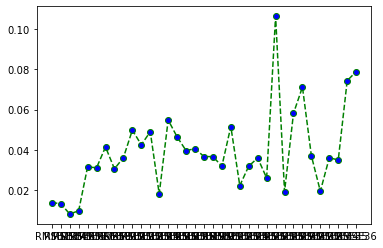

<Figure size 432x288 with 0 Axes>

In [766]:
# plot a line graph
plt.plot(RMSE_df_1c_rnn[0], linestyle='dashed', marker ='o',markerfacecolor='blue',color='green')
plt.show()
plt.savefig('RMSE_df_1c_rnn.png')

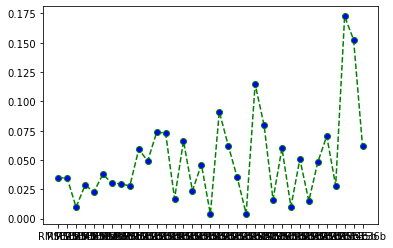

<Figure size 432x288 with 0 Axes>

In [767]:
# plot a line graph
plt.plot(RMSE_df_2c_rnn[0], linestyle='dashed', marker ='o',markerfacecolor='blue',color='green')
plt.show()
plt.savefig('RMSE_df_2c_rnn.png')
plt.savefig('RMSE_df_2c_rnn.pdf')

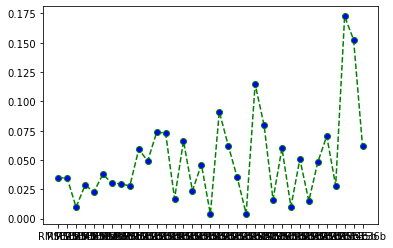

<Figure size 432x288 with 0 Axes>

In [768]:
# plot a line graph
plt.plot(RMSE_df_2c_rnn[0], linestyle='dashed', marker ='o',markerfacecolor='blue',color='green')
plt.show()
plt.savefig('RMSE_df_2c_rnn.png')
plt.savefig('RMSE_df_2c_rnn.pdf')

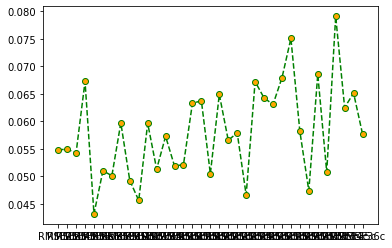

<Figure size 432x288 with 0 Axes>

In [769]:
# plot a line graph
plt.plot(RMSE_df_1c_lstm[0], linestyle='dashed', marker ='o',markerfacecolor='orange',color='green')
plt.show()
plt.savefig('RMSE_df_1c_lstm.png')

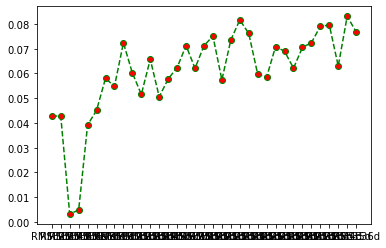

<Figure size 432x288 with 0 Axes>

In [770]:
# plot a line graph
plt.plot(RMSE_df_2c_lstm[0], linestyle='dashed', marker ='o',markerfacecolor='red',color='green')
plt.show()
plt.savefig('RMSE_df_2c_lstm.png')

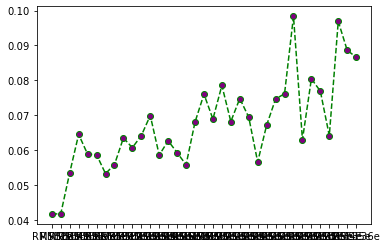

<Figure size 432x288 with 0 Axes>

In [771]:
# plot a line graph
plt.plot(RMSE_df_1c_bilstm[0], linestyle='dashed', marker ='o',markerfacecolor='purple',color='green')
plt.show()
plt.savefig('RMSE_df_1c_bilstm.png')

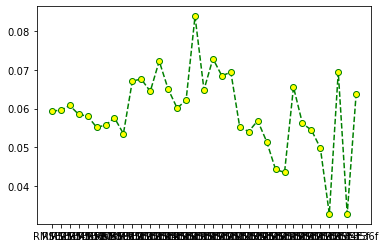

<Figure size 432x288 with 0 Axes>

In [772]:
# plot a line graph
plt.plot(RMSE_df_2c_bilstm[0], linestyle='dashed', marker ='o',markerfacecolor='yellow',color='green')
plt.show()
plt.savefig('RMSE_df_2c_bilstm.png')

In [773]:
#Gráficando el mejor modelo usando MAPE

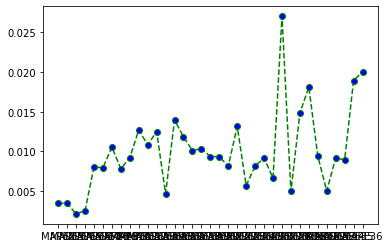

<Figure size 432x288 with 0 Axes>

In [774]:
# plot a line graph
plt.plot(MAPE_df_1c_rnn[0], linestyle='dashed', marker ='o',markerfacecolor='blue',color='green')
plt.show()
plt.savefig('MAPE_df_1c_rnn.png')

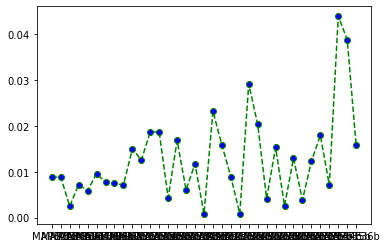

<Figure size 432x288 with 0 Axes>

In [775]:
# plot a line graph
plt.plot(MAPE_df_2c_rnn[0], linestyle='dashed', marker ='o',markerfacecolor='blue',color='green')
plt.show()
plt.savefig('MAPE_df_2c_rnn.png')

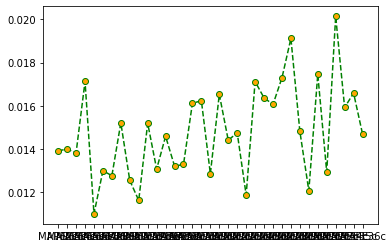

<Figure size 432x288 with 0 Axes>

In [776]:
# plot a line graph
plt.plot(MAPE_df_1c_lstm[0], linestyle='dashed', marker ='o',markerfacecolor='orange',color='green')
plt.show()
plt.savefig('MAPE_df_1c_lstm.png')

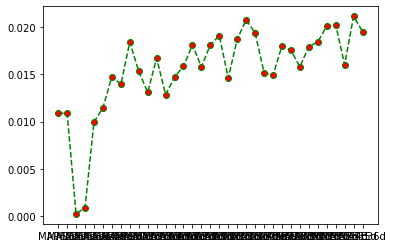

<Figure size 432x288 with 0 Axes>

In [777]:
# plot a line graph
plt.plot(MAPE_df_2c_lstm[0], linestyle='dashed', marker ='o',markerfacecolor='red',color='green')
plt.show()
plt.savefig('MAPE_df_2c_lstm.png')

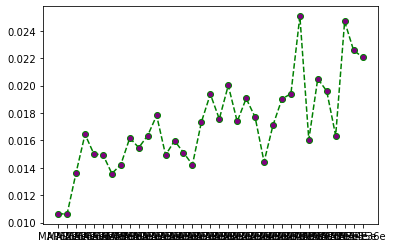

<Figure size 432x288 with 0 Axes>

In [778]:
# plot a line graph
plt.plot(MAPE_df_1c_bilstm[0], linestyle='dashed', marker ='o',markerfacecolor='purple',color='green')
plt.show()
plt.savefig('MAPE_df_1c_bilstm.png')

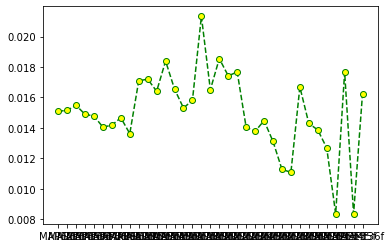

<Figure size 432x288 with 0 Axes>

In [779]:
# plot a line graph
plt.plot(MAPE_df_2c_bilstm[0], linestyle='dashed', marker ='o',markerfacecolor='yellow',color='green')
plt.show()
plt.savefig('MAPE_df_2c_bilstm.png')